In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm 
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from datetime import date

## Data

In [3]:
assets = ['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY', 'IAU']

In [4]:
train_X_ls = []
train_y_ls = []
valid_X_ls = []
valid_y_ls = []
test_X_ls = []
test_y_ls = []

#데이터 로딩
for ass in assets:
    train_X_ls.append(np.load(f'data/modeling/{ass}_train_X.npy'))
    train_y_ls.append(np.load(f'data/modeling/{ass}_train_y.npy'))
    valid_X_ls.append(np.load(f'data/modeling/{ass}_valid_X.npy'))
    valid_y_ls.append(np.load(f'data/modeling/{ass}_valid_y.npy'))
    test_X_ls.append(np.load(f'data/modeling/{ass}_test_X.npy'))
    test_y_ls.append(np.load(f'data/modeling/{ass}_test_y.npy'))

## 모든자산군에 날짜는 같지만..
train_ans_ls = []
valid_ans_ls = []
test_ans_ls = []
for ass in assets:    
    train_ans_ls.append(pd.read_csv(f'data/modeling/{ass}_train_ans.csv', index_col=0))
    valid_ans_ls.append(pd.read_csv(f'data/modeling/{ass}_valid_ans.csv', index_col=0))
    test_ans_ls.append(pd.read_csv(f'data/modeling/{ass}_test_ans.csv', index_col=0))

## Model

In [5]:
#GRU 모델
class scorer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(scorer, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.GRU(input_dim, hidden_dim, bidirectional=False)
        self.l1 = nn.Linear(hidden_dim, hidden_dim+int(hidden_dim/2))
        self.rel = nn.LeakyReLU()
        self.dl1 = nn.Dropout(p=.5)
        self.l2 = nn.Linear(hidden_dim+int(hidden_dim/2),hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        out,_ = self.rnn(x)
        mr = out[-1]
        out = self.l1(mr)
        out = self.rel(out)
        out = self.dl1(out)
        out = self.l2(out)
        out = self.l3(out)
        
        return out.flatten()

In [6]:
#데이터 클래스 정의
class Dataset(Dataset):
    def __init__(self, X, y):

        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __getitem__(self, i):
        return (self.X[i], self.y[i])

    def __len__(self):
        return (len(self.y))

In [7]:
#훈련 하이퍼 파라미터
batch_size = 8
lr = .001
num_epoch = 3000
log_interval = 10
loss_fn = nn.MSELoss()
model_name = 'scoring.pth'
sc_hidden_dim = 200

In [8]:
trainloss_ls = []
validloss_ls = []
testloss_ls = []
ans_ls = []
hat_ls = []

for i in  range(len(assets)):
    print(f"{assets[i]} 시작!!")
    #GRU모델
    model = scorer(train_X_ls[i].shape[2], sc_hidden_dim).cuda()
    ## optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0) ## lr 스케줄러

    ## Dataset
    traindataset = Dataset(train_X_ls[i],train_y_ls[i])
    validataset = Dataset(valid_X_ls[i],valid_y_ls[i])
    testdataset = Dataset(test_X_ls[i],test_y_ls[i])
    train_dataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size)
    valid_dataloader = torch.utils.data.DataLoader(validataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size)


    print("Train 시작!")
    trl = []
    vll = []
    #training scheme
    for i in range(num_epoch):
        train_loss = 0
        valid_loss = 0
        model.train()
        #### Training
        for batch_id, (X,y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            out = model(X.cuda())

            loss = loss_fn(out,y.cuda())

            loss.backward()
            optimizer.step()

            lossavg = (loss/len(y)).data.cpu().numpy()
            train_loss += lossavg

            if batch_id % log_interval == 0:
                print('Epoch: ',i+1,' Batch ID: ',batch_id,' Train Loss: ',train_loss / (batch_id+1))
            trl.append(train_loss / (batch_id+1))
        scheduler.step()


        #### Evaluation on Validset
        model.eval()
        for batch_id, (X,y) in enumerate(valid_dataloader):
            out = model(X.cuda())

            loss = loss_fn(out,y.cuda())

            lossavg = (loss/len(y)).data.cpu().numpy()
            valid_loss += lossavg
        print('epoch: ',i+1,' Valid Loss: ',valid_loss / (batch_id+1))
        if len(vll) > 0:
            if max(vll) < valid_loss.item():
                torch.save(model.state_dict(),model_name)
        else:
            torch.save(model.state_dict(),model_name)
        vll.append((valid_loss/ (batch_id+1)))
        
    trainloss_ls.append(trl)
    validloss_ls.append(vll)

    ## Best Model
    model.load_state_dict(torch.load(model_name))

    print("Test 시작!")
    outs = []
    ys = []
    
    model.eval()
    ## trainset
    for batch_id, (X,y) in enumerate(train_dataloader):
        out = model(X.cuda())
        outs += out.tolist()
        ys += y.tolist()
    ## validset
    for batch_id, (X,y) in enumerate(valid_dataloader):
        out = model(X.cuda())
        outs += out.tolist()
        ys += y.tolist()
    ## testset
    test_loss=0
    for batch_id, (X,y) in enumerate(test_dataloader):
        out = model(X.cuda())
        loss = loss_fn(out,y.cuda())
        lossavg = (loss/len(y)).data.cpu().numpy()
        test_loss += lossavg
        outs += out.tolist()
        ys += y.tolist()
        
    print('Test Loss: ',test_loss / (batch_id+1))
    testloss_ls.append(test_loss)
    hat_ls.append(outs) 
    ans_ls.append(ys)

SPY 시작!!
Train 시작!
Epoch:  1  Batch ID:  0  Train Loss:  0.000243191490881145
Epoch:  1  Batch ID:  10  Train Loss:  7.973417020614512e-05
epoch:  1  Valid Loss:  1.896094702639554e-05
Epoch:  2  Batch ID:  0  Train Loss:  0.00043703243136405945
Epoch:  2  Batch ID:  10  Train Loss:  0.00010754094711790623
epoch:  2  Valid Loss:  2.572285863304084e-05
Epoch:  3  Batch ID:  0  Train Loss:  0.00010242141433991492
Epoch:  3  Batch ID:  10  Train Loss:  2.891429424132432e-05
epoch:  3  Valid Loss:  6.007823321851902e-05
Epoch:  4  Batch ID:  0  Train Loss:  0.00010459746408741921
Epoch:  4  Batch ID:  10  Train Loss:  4.797520705324132e-05
epoch:  4  Valid Loss:  8.021568828553427e-05
Epoch:  5  Batch ID:  0  Train Loss:  9.159842738881707e-05
Epoch:  5  Batch ID:  10  Train Loss:  4.834761173035738e-05
epoch:  5  Valid Loss:  3.07442413429726e-05
Epoch:  6  Batch ID:  0  Train Loss:  7.709922647336498e-05
Epoch:  6  Batch ID:  10  Train Loss:  3.439152128108121e-05
epoch:  6  Valid Loss: 

Epoch:  50  Batch ID:  0  Train Loss:  1.5365787476184778e-05
Epoch:  50  Batch ID:  10  Train Loss:  1.4663876692628202e-05
epoch:  50  Valid Loss:  2.0700866571132792e-05
Epoch:  51  Batch ID:  0  Train Loss:  1.8181628547608852e-05
Epoch:  51  Batch ID:  10  Train Loss:  1.1749289466355219e-05
epoch:  51  Valid Loss:  1.7113406859910658e-05
Epoch:  52  Batch ID:  0  Train Loss:  1.2586357115651481e-05
Epoch:  52  Batch ID:  10  Train Loss:  1.0176575146529517e-05
epoch:  52  Valid Loss:  1.5961668945389345e-05
Epoch:  53  Batch ID:  0  Train Loss:  4.070973773195874e-06
Epoch:  53  Batch ID:  10  Train Loss:  8.700892460017878e-06
epoch:  53  Valid Loss:  1.8644850873291336e-05
Epoch:  54  Batch ID:  0  Train Loss:  5.221430001256522e-06
Epoch:  54  Batch ID:  10  Train Loss:  8.349305248471369e-06
epoch:  54  Valid Loss:  1.7119907719613064e-05
Epoch:  55  Batch ID:  0  Train Loss:  1.5383268419100204e-06
Epoch:  55  Batch ID:  10  Train Loss:  7.646196040282534e-06
epoch:  55  Val

Epoch:  100  Batch ID:  0  Train Loss:  3.47729587701906e-06
Epoch:  100  Batch ID:  10  Train Loss:  5.59437732631936e-06
epoch:  100  Valid Loss:  1.5188574195690308e-05
Epoch:  101  Batch ID:  0  Train Loss:  2.6398352019896265e-06
Epoch:  101  Batch ID:  10  Train Loss:  5.437827863633257e-06
epoch:  101  Valid Loss:  1.5188574195690308e-05
Epoch:  102  Batch ID:  0  Train Loss:  9.870574103842955e-06
Epoch:  102  Batch ID:  10  Train Loss:  7.1622229246382964e-06
epoch:  102  Valid Loss:  1.5187226817185243e-05
Epoch:  103  Batch ID:  0  Train Loss:  5.320853688317584e-06
Epoch:  103  Batch ID:  10  Train Loss:  6.40748068938344e-06
epoch:  103  Valid Loss:  1.5241128267007298e-05
Epoch:  104  Batch ID:  0  Train Loss:  6.713979928463232e-06
Epoch:  104  Batch ID:  10  Train Loss:  6.568991507678716e-06
epoch:  104  Valid Loss:  1.5339073343056953e-05
Epoch:  105  Batch ID:  0  Train Loss:  9.204908565152436e-06
Epoch:  105  Batch ID:  10  Train Loss:  6.4915838348414665e-06
epoch

Epoch:  148  Batch ID:  10  Train Loss:  6.669960198864415e-06
epoch:  148  Valid Loss:  1.2324517712158922e-05
Epoch:  149  Batch ID:  0  Train Loss:  1.0205672879237682e-05
Epoch:  149  Batch ID:  10  Train Loss:  6.332674884519789e-06
epoch:  149  Valid Loss:  1.2746533324540602e-05
Epoch:  150  Batch ID:  0  Train Loss:  7.617381470481632e-06
Epoch:  150  Batch ID:  10  Train Loss:  6.041766048590282e-06
epoch:  150  Valid Loss:  1.0458687332478197e-05
Epoch:  151  Batch ID:  0  Train Loss:  1.8069091311190277e-05
Epoch:  151  Batch ID:  10  Train Loss:  7.043006049074889e-06
epoch:  151  Valid Loss:  1.4743871588507318e-05
Epoch:  152  Batch ID:  0  Train Loss:  8.53311394166667e-06
Epoch:  152  Batch ID:  10  Train Loss:  6.00250328633675e-06
epoch:  152  Valid Loss:  1.3312116341997656e-05
Epoch:  153  Batch ID:  0  Train Loss:  9.808067261474207e-06
Epoch:  153  Batch ID:  10  Train Loss:  5.713032113486737e-06
epoch:  153  Valid Loss:  1.1010437712381341e-05
Epoch:  154  Batch

Epoch:  197  Batch ID:  10  Train Loss:  5.210076344817273e-06
epoch:  197  Valid Loss:  1.2084878638537097e-05
Epoch:  198  Batch ID:  0  Train Loss:  1.690960743871983e-05
Epoch:  198  Batch ID:  10  Train Loss:  8.49283403361121e-06
epoch:  198  Valid Loss:  9.574350239442234e-06
Epoch:  199  Batch ID:  0  Train Loss:  1.0792274224513676e-05
Epoch:  199  Batch ID:  10  Train Loss:  5.993569702282415e-06
epoch:  199  Valid Loss:  1.1698129261124754e-05
Epoch:  200  Batch ID:  0  Train Loss:  1.4374008060258348e-05
Epoch:  200  Batch ID:  10  Train Loss:  6.090971272566424e-06
epoch:  200  Valid Loss:  1.4736427033312793e-05
Epoch:  201  Batch ID:  0  Train Loss:  4.902713044430129e-05
Epoch:  201  Batch ID:  10  Train Loss:  1.0126700834172714e-05
epoch:  201  Valid Loss:  1.2015926699859847e-05
Epoch:  202  Batch ID:  0  Train Loss:  1.3442175259115174e-05
Epoch:  202  Batch ID:  10  Train Loss:  5.159113687692628e-06
epoch:  202  Valid Loss:  1.2178171346022282e-05
Epoch:  203  Bat

Epoch:  248  Batch ID:  10  Train Loss:  4.183119094911738e-06
epoch:  248  Valid Loss:  1.1631230260415274e-05
Epoch:  249  Batch ID:  0  Train Loss:  8.52589073474519e-06
Epoch:  249  Batch ID:  10  Train Loss:  3.5065463738316214e-06
epoch:  249  Valid Loss:  1.0441986224426122e-05
Epoch:  250  Batch ID:  0  Train Loss:  1.818289456423372e-05
Epoch:  250  Batch ID:  10  Train Loss:  4.792579209771992e-06
epoch:  250  Valid Loss:  1.0023445687086982e-05
Epoch:  251  Batch ID:  0  Train Loss:  9.39155688683968e-06
Epoch:  251  Batch ID:  10  Train Loss:  4.164477145836414e-06
epoch:  251  Valid Loss:  9.875167582625485e-06
Epoch:  252  Batch ID:  0  Train Loss:  5.138872438692488e-06
Epoch:  252  Batch ID:  10  Train Loss:  4.0919672053198815e-06
epoch:  252  Valid Loss:  1.3733139610394574e-05
Epoch:  253  Batch ID:  0  Train Loss:  9.586023224983364e-06
Epoch:  253  Batch ID:  10  Train Loss:  3.5909774903137244e-06
epoch:  253  Valid Loss:  9.815561876772941e-06
Epoch:  254  Batch 

epoch:  295  Valid Loss:  1.039405489677847e-05
Epoch:  296  Batch ID:  0  Train Loss:  9.802964996197261e-06
Epoch:  296  Batch ID:  10  Train Loss:  3.3639481154585322e-06
epoch:  296  Valid Loss:  9.780583070551074e-06
Epoch:  297  Batch ID:  0  Train Loss:  7.136222848203033e-06
Epoch:  297  Batch ID:  10  Train Loss:  3.6428225795051814e-06
epoch:  297  Valid Loss:  9.799273755106697e-06
Epoch:  298  Batch ID:  0  Train Loss:  4.148305379203521e-06
Epoch:  298  Batch ID:  10  Train Loss:  3.3772257665987127e-06
epoch:  298  Valid Loss:  9.82258004948259e-06
Epoch:  299  Batch ID:  0  Train Loss:  3.1104630124900723e-06
Epoch:  299  Batch ID:  10  Train Loss:  3.2969675513330996e-06
epoch:  299  Valid Loss:  9.83323366199329e-06
Epoch:  300  Batch ID:  0  Train Loss:  3.037489022972295e-06
Epoch:  300  Batch ID:  10  Train Loss:  3.115344632285335e-06
epoch:  300  Valid Loss:  9.863361981388152e-06
Epoch:  301  Batch ID:  0  Train Loss:  9.292445611208677e-06
Epoch:  301  Batch ID:

epoch:  343  Valid Loss:  1.0018978305955292e-05
Epoch:  344  Batch ID:  0  Train Loss:  6.9904363044770434e-06
Epoch:  344  Batch ID:  10  Train Loss:  2.3067174920883686e-06
epoch:  344  Valid Loss:  9.857360993237307e-06
Epoch:  345  Batch ID:  0  Train Loss:  9.801130545383785e-06
Epoch:  345  Batch ID:  10  Train Loss:  3.1265171339162574e-06
epoch:  345  Valid Loss:  1.0003881953934979e-05
Epoch:  346  Batch ID:  0  Train Loss:  2.9698699108848814e-06
Epoch:  346  Batch ID:  10  Train Loss:  2.0146538304288697e-06
epoch:  346  Valid Loss:  9.907151915437376e-06
Epoch:  347  Batch ID:  0  Train Loss:  1.2116179277654737e-05
Epoch:  347  Batch ID:  10  Train Loss:  3.2164032394245044e-06
epoch:  347  Valid Loss:  1.0250954138276333e-05
Epoch:  348  Batch ID:  0  Train Loss:  2.710611170186894e-06
Epoch:  348  Batch ID:  10  Train Loss:  2.6510078689832217e-06
epoch:  348  Valid Loss:  9.794878091421802e-06
Epoch:  349  Batch ID:  0  Train Loss:  1.2385055015329272e-05
Epoch:  349  

Epoch:  393  Batch ID:  10  Train Loss:  2.8406824102686104e-06
epoch:  393  Valid Loss:  9.455573281987503e-06
Epoch:  394  Batch ID:  0  Train Loss:  1.093623632186791e-05
Epoch:  394  Batch ID:  10  Train Loss:  4.160721728525956e-06
epoch:  394  Valid Loss:  1.0841901920836486e-05
Epoch:  395  Batch ID:  0  Train Loss:  2.720435986702796e-06
Epoch:  395  Batch ID:  10  Train Loss:  2.2825393712495994e-06
epoch:  395  Valid Loss:  1.2319067271467551e-05
Epoch:  396  Batch ID:  0  Train Loss:  1.6037884051911533e-05
Epoch:  396  Batch ID:  10  Train Loss:  3.990274396156482e-06
epoch:  396  Valid Loss:  1.064635080183507e-05
Epoch:  397  Batch ID:  0  Train Loss:  1.330978307123587e-06
Epoch:  397  Batch ID:  10  Train Loss:  3.0625111135536414e-06
epoch:  397  Valid Loss:  8.912165147497339e-06
Epoch:  398  Batch ID:  0  Train Loss:  1.4588585145247635e-05
Epoch:  398  Batch ID:  10  Train Loss:  7.0126683443628614e-06
epoch:  398  Valid Loss:  1.2707060174458698e-05
Epoch:  399  Ba

epoch:  441  Valid Loss:  9.987247646373968e-06
Epoch:  442  Batch ID:  0  Train Loss:  1.0047710929939058e-05
Epoch:  442  Batch ID:  10  Train Loss:  6.262312498702985e-06
epoch:  442  Valid Loss:  1.7083296711462026e-05
Epoch:  443  Batch ID:  0  Train Loss:  4.232636911183363e-06
Epoch:  443  Batch ID:  10  Train Loss:  9.13792675047179e-06
epoch:  443  Valid Loss:  1.9682018167562394e-05
Epoch:  444  Batch ID:  0  Train Loss:  2.3834159947000444e-05
Epoch:  444  Batch ID:  10  Train Loss:  7.424933249405347e-06
epoch:  444  Valid Loss:  1.0648703910950038e-05
Epoch:  445  Batch ID:  0  Train Loss:  1.8385091607342474e-05
Epoch:  445  Batch ID:  10  Train Loss:  7.962097945644267e-06
epoch:  445  Valid Loss:  9.51720990845691e-06
Epoch:  446  Batch ID:  0  Train Loss:  2.1604100766126066e-05
Epoch:  446  Batch ID:  10  Train Loss:  8.40938812209722e-06
epoch:  446  Valid Loss:  9.033564917141726e-06
Epoch:  447  Batch ID:  0  Train Loss:  1.2392612006806303e-05
Epoch:  447  Batch I

Epoch:  489  Batch ID:  10  Train Loss:  7.468774232289764e-06
epoch:  489  Valid Loss:  1.1033757952342663e-05
Epoch:  490  Batch ID:  0  Train Loss:  7.909542546258308e-06
Epoch:  490  Batch ID:  10  Train Loss:  4.385311068621046e-06
epoch:  490  Valid Loss:  1.13534524264954e-05
Epoch:  491  Batch ID:  0  Train Loss:  4.421294306666823e-06
Epoch:  491  Batch ID:  10  Train Loss:  3.1300983623209917e-06
epoch:  491  Valid Loss:  1.0160467581954435e-05
Epoch:  492  Batch ID:  0  Train Loss:  1.3748670426139142e-05
Epoch:  492  Batch ID:  10  Train Loss:  3.796654730401563e-06
epoch:  492  Valid Loss:  1.0820546852604215e-05
Epoch:  493  Batch ID:  0  Train Loss:  1.3238666724646464e-05
Epoch:  493  Batch ID:  10  Train Loss:  3.986616945894639e-06
epoch:  493  Valid Loss:  9.905964930112532e-06
Epoch:  494  Batch ID:  0  Train Loss:  8.77924139786046e-06
Epoch:  494  Batch ID:  10  Train Loss:  3.392483165498561e-06
epoch:  494  Valid Loss:  1.0230699643898333e-05
Epoch:  495  Batch 

epoch:  539  Valid Loss:  9.700470930814239e-06
Epoch:  540  Batch ID:  0  Train Loss:  1.0243834367429372e-05
Epoch:  540  Batch ID:  10  Train Loss:  3.4574210665348137e-06
epoch:  540  Valid Loss:  9.731351582331627e-06
Epoch:  541  Batch ID:  0  Train Loss:  1.0587620636215433e-05
Epoch:  541  Batch ID:  10  Train Loss:  2.910655488428595e-06
epoch:  541  Valid Loss:  9.731351582331627e-06
Epoch:  542  Batch ID:  0  Train Loss:  6.856854270154145e-06
Epoch:  542  Batch ID:  10  Train Loss:  2.8084117192603033e-06
epoch:  542  Valid Loss:  9.723583711244524e-06
Epoch:  543  Batch ID:  0  Train Loss:  9.997586857934948e-06
Epoch:  543  Batch ID:  10  Train Loss:  3.49337949501205e-06
epoch:  543  Valid Loss:  9.667350932810828e-06
Epoch:  544  Batch ID:  0  Train Loss:  8.19993147160858e-06
Epoch:  544  Batch ID:  10  Train Loss:  2.940788766119857e-06
epoch:  544  Valid Loss:  9.815676539422688e-06
Epoch:  545  Batch ID:  0  Train Loss:  9.36045398702845e-06
Epoch:  545  Batch ID:  

Epoch:  588  Batch ID:  10  Train Loss:  2.686617707778086e-06
epoch:  588  Valid Loss:  9.913469625644211e-06
Epoch:  589  Batch ID:  0  Train Loss:  4.865325990976999e-06
Epoch:  589  Batch ID:  10  Train Loss:  2.64323358578622e-06
epoch:  589  Valid Loss:  1.0823067214005277e-05
Epoch:  590  Batch ID:  0  Train Loss:  6.900474545545876e-06
Epoch:  590  Batch ID:  10  Train Loss:  2.8349683857827173e-06
epoch:  590  Valid Loss:  1.0452427413080537e-05
Epoch:  591  Batch ID:  0  Train Loss:  3.5695420592674054e-06
Epoch:  591  Batch ID:  10  Train Loss:  1.8196203293221267e-06
epoch:  591  Valid Loss:  1.090132366243779e-05
Epoch:  592  Batch ID:  0  Train Loss:  2.5401072889508214e-06
Epoch:  592  Batch ID:  10  Train Loss:  2.2415449724245593e-06
epoch:  592  Valid Loss:  9.76008009464143e-06
Epoch:  593  Batch ID:  0  Train Loss:  2.4694461444596527e-06
Epoch:  593  Batch ID:  10  Train Loss:  2.169096647590281e-06
epoch:  593  Valid Loss:  1.0713202783563247e-05
Epoch:  594  Batc

epoch:  635  Valid Loss:  1.0891489987822448e-05
Epoch:  636  Batch ID:  0  Train Loss:  6.3499378484266344e-06
Epoch:  636  Batch ID:  10  Train Loss:  2.8130880051238902e-06
epoch:  636  Valid Loss:  1.0810359848771137e-05
Epoch:  637  Batch ID:  0  Train Loss:  1.1055257346015424e-05
Epoch:  637  Batch ID:  10  Train Loss:  4.006172859631492e-06
epoch:  637  Valid Loss:  9.948544250922472e-06
Epoch:  638  Batch ID:  0  Train Loss:  5.1439452363410965e-05
Epoch:  638  Batch ID:  10  Train Loss:  7.939029025940478e-06
epoch:  638  Valid Loss:  1.1141837887862494e-05
Epoch:  639  Batch ID:  0  Train Loss:  8.931310730986297e-05
Epoch:  639  Batch ID:  10  Train Loss:  1.6837170061411268e-05
epoch:  639  Valid Loss:  1.256488303624792e-05
Epoch:  640  Batch ID:  0  Train Loss:  2.956736170744989e-05
Epoch:  640  Batch ID:  10  Train Loss:  8.188870176375282e-06
epoch:  640  Valid Loss:  1.8516974023441435e-05
Epoch:  641  Batch ID:  0  Train Loss:  1.619488830328919e-05
Epoch:  641  Bat

Epoch:  685  Batch ID:  0  Train Loss:  7.583801107102772e-06
Epoch:  685  Batch ID:  10  Train Loss:  4.665665125519974e-06
epoch:  685  Valid Loss:  9.374229080094665e-06
Epoch:  686  Batch ID:  0  Train Loss:  7.944249773572665e-06
Epoch:  686  Batch ID:  10  Train Loss:  5.179037667734189e-06
epoch:  686  Valid Loss:  1.207290292389492e-05
Epoch:  687  Batch ID:  0  Train Loss:  2.2483984594146023e-06
Epoch:  687  Batch ID:  10  Train Loss:  2.703284714946428e-06
epoch:  687  Valid Loss:  1.0126390141825444e-05
Epoch:  688  Batch ID:  0  Train Loss:  1.4318945432023611e-05
Epoch:  688  Batch ID:  10  Train Loss:  2.960156238755603e-06
epoch:  688  Valid Loss:  9.361312142649089e-06
Epoch:  689  Batch ID:  0  Train Loss:  9.398742804478388e-06
Epoch:  689  Batch ID:  10  Train Loss:  3.086540382148748e-06
epoch:  689  Valid Loss:  1.1250235009659567e-05
Epoch:  690  Batch ID:  0  Train Loss:  2.8236272555659525e-06
Epoch:  690  Batch ID:  10  Train Loss:  2.5412583475124184e-06
epoc

epoch:  735  Valid Loss:  9.785513536068416e-06
Epoch:  736  Batch ID:  0  Train Loss:  3.5831267268804368e-06
Epoch:  736  Batch ID:  10  Train Loss:  1.9961537883649396e-06
epoch:  736  Valid Loss:  9.64121580674752e-06
Epoch:  737  Batch ID:  0  Train Loss:  8.303239155793563e-06
Epoch:  737  Batch ID:  10  Train Loss:  2.499895665344163e-06
epoch:  737  Valid Loss:  9.507996916606013e-06
Epoch:  738  Batch ID:  0  Train Loss:  5.103924650029512e-06
Epoch:  738  Batch ID:  10  Train Loss:  1.8950088464076875e-06
epoch:  738  Valid Loss:  9.510077082571419e-06
Epoch:  739  Batch ID:  0  Train Loss:  5.9284898270561825e-06
Epoch:  739  Batch ID:  10  Train Loss:  2.3000611639128525e-06
epoch:  739  Valid Loss:  9.564879585847544e-06
Epoch:  740  Batch ID:  0  Train Loss:  3.265792202000739e-06
Epoch:  740  Batch ID:  10  Train Loss:  1.9974321503468673e-06
epoch:  740  Valid Loss:  9.569584610365686e-06
Epoch:  741  Batch ID:  0  Train Loss:  6.713828042848036e-06
Epoch:  741  Batch I

epoch:  786  Valid Loss:  1.0405486335685055e-05
Epoch:  787  Batch ID:  0  Train Loss:  8.347504262928851e-06
Epoch:  787  Batch ID:  10  Train Loss:  2.381567185238964e-06
epoch:  787  Valid Loss:  1.013752436544261e-05
Epoch:  788  Batch ID:  0  Train Loss:  2.9513837489503203e-06
Epoch:  788  Batch ID:  10  Train Loss:  1.7426234638729843e-06
epoch:  788  Valid Loss:  1.0731693852979637e-05
Epoch:  789  Batch ID:  0  Train Loss:  3.259131062804954e-06
Epoch:  789  Batch ID:  10  Train Loss:  1.7624578586864201e-06
epoch:  789  Valid Loss:  9.893989423896224e-06
Epoch:  790  Batch ID:  0  Train Loss:  4.188428647466935e-06
Epoch:  790  Batch ID:  10  Train Loss:  2.0306097264272633e-06
epoch:  790  Valid Loss:  1.0271131676139097e-05
Epoch:  791  Batch ID:  0  Train Loss:  1.8040435634247842e-06
Epoch:  791  Batch ID:  10  Train Loss:  2.1200682970795075e-06
epoch:  791  Valid Loss:  1.0388578706018356e-05
Epoch:  792  Batch ID:  0  Train Loss:  2.1545110939769074e-06
Epoch:  792  B

Epoch:  835  Batch ID:  0  Train Loss:  3.007031637025648e-06
Epoch:  835  Batch ID:  10  Train Loss:  1.8240751118851635e-06
epoch:  835  Valid Loss:  9.918833294856691e-06
Epoch:  836  Batch ID:  0  Train Loss:  1.78831960511161e-05
Epoch:  836  Batch ID:  10  Train Loss:  3.8633006599039534e-06
epoch:  836  Valid Loss:  1.0797060554068594e-05
Epoch:  837  Batch ID:  0  Train Loss:  2.8045116778230295e-05
Epoch:  837  Batch ID:  10  Train Loss:  4.52277962184863e-06
epoch:  837  Valid Loss:  1.1677944352565342e-05
Epoch:  838  Batch ID:  0  Train Loss:  2.975036068164627e-06
Epoch:  838  Batch ID:  10  Train Loss:  2.4763940121953385e-06
epoch:  838  Valid Loss:  9.332884682559476e-06
Epoch:  839  Batch ID:  0  Train Loss:  8.138340490404516e-06
Epoch:  839  Batch ID:  10  Train Loss:  2.931213295844579e-06
epoch:  839  Valid Loss:  9.1997246537782e-06
Epoch:  840  Batch ID:  0  Train Loss:  1.1038489901693538e-05
Epoch:  840  Batch ID:  10  Train Loss:  4.0547137545714085e-06
epoch:

Epoch:  885  Batch ID:  10  Train Loss:  4.048142583004929e-06
epoch:  885  Valid Loss:  1.478746528012683e-05
Epoch:  886  Batch ID:  0  Train Loss:  1.1818678103736602e-05
Epoch:  886  Batch ID:  10  Train Loss:  4.016840421172674e-06
epoch:  886  Valid Loss:  9.66369219668195e-06
Epoch:  887  Batch ID:  0  Train Loss:  7.30912961444119e-06
Epoch:  887  Batch ID:  10  Train Loss:  4.628479742181795e-06
epoch:  887  Valid Loss:  8.989746504539653e-06
Epoch:  888  Batch ID:  0  Train Loss:  3.7244517443468794e-06
Epoch:  888  Batch ID:  10  Train Loss:  2.9857436733106044e-06
epoch:  888  Valid Loss:  1.0911151984297854e-05
Epoch:  889  Batch ID:  0  Train Loss:  7.83676568971714e-06
Epoch:  889  Batch ID:  10  Train Loss:  3.71377267459717e-06
epoch:  889  Valid Loss:  9.488520438101963e-06
Epoch:  890  Batch ID:  0  Train Loss:  4.294675363780698e-06
Epoch:  890  Batch ID:  10  Train Loss:  2.9317242561691357e-06
epoch:  890  Valid Loss:  9.364246892573647e-06
Epoch:  891  Batch ID: 

epoch:  933  Valid Loss:  9.711812576066828e-06
Epoch:  934  Batch ID:  0  Train Loss:  5.025495738664176e-06
Epoch:  934  Batch ID:  10  Train Loss:  1.9807335640755563e-06
epoch:  934  Valid Loss:  9.442512483322693e-06
Epoch:  935  Batch ID:  0  Train Loss:  6.309134732873645e-06
Epoch:  935  Batch ID:  10  Train Loss:  2.0377621632922622e-06
epoch:  935  Valid Loss:  9.00212321160628e-06
Epoch:  936  Batch ID:  0  Train Loss:  7.290323082997929e-06
Epoch:  936  Batch ID:  10  Train Loss:  2.2532966878233394e-06
epoch:  936  Valid Loss:  9.2129216492746e-06
Epoch:  937  Batch ID:  0  Train Loss:  1.3109410019751522e-06
Epoch:  937  Batch ID:  10  Train Loss:  1.511542408975815e-06
epoch:  937  Valid Loss:  9.45415659240704e-06
Epoch:  938  Batch ID:  0  Train Loss:  7.962228664837312e-06
Epoch:  938  Batch ID:  10  Train Loss:  2.7183612019143766e-06
epoch:  938  Valid Loss:  9.519704785058517e-06
Epoch:  939  Batch ID:  0  Train Loss:  3.6284209272707812e-06
Epoch:  939  Batch ID: 

Epoch:  981  Batch ID:  10  Train Loss:  2.381498523556564e-06
epoch:  981  Valid Loss:  8.481383967288517e-06
Epoch:  982  Batch ID:  0  Train Loss:  4.09432823289535e-06
Epoch:  982  Batch ID:  10  Train Loss:  1.673649700767948e-06
epoch:  982  Valid Loss:  8.506977602943758e-06
Epoch:  983  Batch ID:  0  Train Loss:  3.814217052422464e-06
Epoch:  983  Batch ID:  10  Train Loss:  2.01722129779889e-06
epoch:  983  Valid Loss:  8.665932038335692e-06
Epoch:  984  Batch ID:  0  Train Loss:  4.480233656067867e-06
Epoch:  984  Batch ID:  10  Train Loss:  2.370343726066825e-06
epoch:  984  Valid Loss:  8.899894055502955e-06
Epoch:  985  Batch ID:  0  Train Loss:  4.747644197777845e-06
Epoch:  985  Batch ID:  10  Train Loss:  2.2895572184014865e-06
epoch:  985  Valid Loss:  8.98102384401985e-06
Epoch:  986  Batch ID:  0  Train Loss:  2.52897211794334e-06
Epoch:  986  Batch ID:  10  Train Loss:  2.464695388549775e-06
epoch:  986  Valid Loss:  8.73745580065588e-06
Epoch:  987  Batch ID:  0  T

epoch:  1028  Valid Loss:  8.682352283055176e-06
Epoch:  1029  Batch ID:  0  Train Loss:  5.677065928466618e-06
Epoch:  1029  Batch ID:  10  Train Loss:  1.508131819346917e-06
epoch:  1029  Valid Loss:  9.530257178388032e-06
Epoch:  1030  Batch ID:  0  Train Loss:  3.486483137749019e-06
Epoch:  1030  Batch ID:  10  Train Loss:  2.015659612714609e-06
epoch:  1030  Valid Loss:  8.439341058874561e-06
Epoch:  1031  Batch ID:  0  Train Loss:  3.665814119813149e-06
Epoch:  1031  Batch ID:  10  Train Loss:  1.6604899118729835e-06
epoch:  1031  Valid Loss:  9.16984540329698e-06
Epoch:  1032  Batch ID:  0  Train Loss:  6.334442332445178e-06
Epoch:  1032  Batch ID:  10  Train Loss:  2.1442871255575566e-06
epoch:  1032  Valid Loss:  7.974734055930336e-06
Epoch:  1033  Batch ID:  0  Train Loss:  3.8466055229946505e-06
Epoch:  1033  Batch ID:  10  Train Loss:  1.5406391960161934e-06
epoch:  1033  Valid Loss:  8.920204588018047e-06
Epoch:  1034  Batch ID:  0  Train Loss:  2.1585883587249555e-06
Epoc

epoch:  1076  Valid Loss:  9.200879806788484e-06
Epoch:  1077  Batch ID:  0  Train Loss:  6.391202077793423e-06
Epoch:  1077  Batch ID:  10  Train Loss:  2.5268443860940435e-06
epoch:  1077  Valid Loss:  8.476658981256454e-06
Epoch:  1078  Batch ID:  0  Train Loss:  2.6126443117391318e-05
Epoch:  1078  Batch ID:  10  Train Loss:  4.321995747473424e-06
epoch:  1078  Valid Loss:  1.0635817299468423e-05
Epoch:  1079  Batch ID:  0  Train Loss:  3.5344033676665276e-05
Epoch:  1079  Batch ID:  10  Train Loss:  6.79658396827356e-06
epoch:  1079  Valid Loss:  1.4003852091567145e-05
Epoch:  1080  Batch ID:  0  Train Loss:  1.871256245067343e-05
Epoch:  1080  Batch ID:  10  Train Loss:  5.755260683703124e-06
epoch:  1080  Valid Loss:  1.4827214992389296e-05
Epoch:  1081  Batch ID:  0  Train Loss:  5.691024853149429e-05
Epoch:  1081  Batch ID:  10  Train Loss:  8.033515996430651e-06
epoch:  1081  Valid Loss:  7.844053034962902e-06
Epoch:  1082  Batch ID:  0  Train Loss:  1.2628115655388683e-05
Ep

Epoch:  1124  Batch ID:  10  Train Loss:  4.957043147028757e-06
epoch:  1124  Valid Loss:  1.3135089905820982e-05
Epoch:  1125  Batch ID:  0  Train Loss:  1.002122644422343e-05
Epoch:  1125  Batch ID:  10  Train Loss:  5.221444253451906e-06
epoch:  1125  Valid Loss:  8.508176999081721e-06
Epoch:  1126  Batch ID:  0  Train Loss:  1.7632381059229374e-05
Epoch:  1126  Batch ID:  10  Train Loss:  6.241716340065812e-06
epoch:  1126  Valid Loss:  7.899815614109684e-06
Epoch:  1127  Batch ID:  0  Train Loss:  4.172560693405103e-06
Epoch:  1127  Batch ID:  10  Train Loss:  3.055034302302705e-06
epoch:  1127  Valid Loss:  1.3215632748142525e-05
Epoch:  1128  Batch ID:  0  Train Loss:  7.892179382906761e-06
Epoch:  1128  Batch ID:  10  Train Loss:  5.321941898728255e-06
epoch:  1128  Valid Loss:  8.81649659352964e-06
Epoch:  1129  Batch ID:  0  Train Loss:  1.4069716598896775e-05
Epoch:  1129  Batch ID:  10  Train Loss:  4.787719014778056e-06
epoch:  1129  Valid Loss:  9.096291402480952e-06
Epoc

Epoch:  1171  Batch ID:  10  Train Loss:  1.932147277081888e-06
epoch:  1171  Valid Loss:  9.029591675850194e-06
Epoch:  1172  Batch ID:  0  Train Loss:  1.9279009393358137e-06
Epoch:  1172  Batch ID:  10  Train Loss:  1.2624434733962433e-06
epoch:  1172  Valid Loss:  8.313077709469022e-06
Epoch:  1173  Batch ID:  0  Train Loss:  4.978306151315337e-06
Epoch:  1173  Batch ID:  10  Train Loss:  1.8836728734392885e-06
epoch:  1173  Valid Loss:  8.97904142978708e-06
Epoch:  1174  Batch ID:  0  Train Loss:  8.427095963270403e-06
Epoch:  1174  Batch ID:  10  Train Loss:  2.2211076859755186e-06
epoch:  1174  Valid Loss:  8.591838347153194e-06
Epoch:  1175  Batch ID:  0  Train Loss:  4.1528323890815955e-06
Epoch:  1175  Batch ID:  10  Train Loss:  2.0158080463840054e-06
epoch:  1175  Valid Loss:  8.666658781445827e-06
Epoch:  1176  Batch ID:  0  Train Loss:  2.3669922484259587e-06
Epoch:  1176  Batch ID:  10  Train Loss:  1.8013951251883886e-06
epoch:  1176  Valid Loss:  8.352474405152558e-06


epoch:  1218  Valid Loss:  8.97748536014357e-06
Epoch:  1219  Batch ID:  0  Train Loss:  6.419627425202634e-06
Epoch:  1219  Batch ID:  10  Train Loss:  1.9880687163591078e-06
epoch:  1219  Valid Loss:  9.065507128980244e-06
Epoch:  1220  Batch ID:  0  Train Loss:  4.168710802332498e-06
Epoch:  1220  Batch ID:  10  Train Loss:  1.6104128752141895e-06
epoch:  1220  Valid Loss:  9.093666695510668e-06
Epoch:  1221  Batch ID:  0  Train Loss:  1.6499416233273223e-06
Epoch:  1221  Batch ID:  10  Train Loss:  1.5967571171544974e-06
epoch:  1221  Valid Loss:  9.093666695510668e-06
Epoch:  1222  Batch ID:  0  Train Loss:  3.856235252897022e-06
Epoch:  1222  Batch ID:  10  Train Loss:  2.0286216071822722e-06
epoch:  1222  Valid Loss:  9.117561641384478e-06
Epoch:  1223  Batch ID:  0  Train Loss:  2.2007125153322704e-06
Epoch:  1223  Batch ID:  10  Train Loss:  1.7493392761025461e-06
epoch:  1223  Valid Loss:  9.140328624350028e-06
Epoch:  1224  Batch ID:  0  Train Loss:  2.7267260520602576e-06
E

epoch:  1265  Valid Loss:  8.56413703331782e-06
Epoch:  1266  Batch ID:  0  Train Loss:  3.9576211747771595e-06
Epoch:  1266  Batch ID:  10  Train Loss:  1.6356483650332103e-06
epoch:  1266  Valid Loss:  8.298390108999834e-06
Epoch:  1267  Batch ID:  0  Train Loss:  4.540222107607406e-06
Epoch:  1267  Batch ID:  10  Train Loss:  1.6986314402732783e-06
epoch:  1267  Valid Loss:  8.216393913092665e-06
Epoch:  1268  Batch ID:  0  Train Loss:  1.6757626326580066e-06
Epoch:  1268  Batch ID:  10  Train Loss:  1.252716259614317e-06
epoch:  1268  Valid Loss:  8.810563599581656e-06
Epoch:  1269  Batch ID:  0  Train Loss:  2.2584531507163774e-06
Epoch:  1269  Batch ID:  10  Train Loss:  1.2723732900419484e-06
epoch:  1269  Valid Loss:  9.221408978040321e-06
Epoch:  1270  Batch ID:  0  Train Loss:  6.449416105169803e-06
Epoch:  1270  Batch ID:  10  Train Loss:  2.1577205302492075e-06
epoch:  1270  Valid Loss:  8.177753651731715e-06
Epoch:  1271  Batch ID:  0  Train Loss:  2.8789772841264494e-06
E

epoch:  1313  Valid Loss:  8.119993234837844e-06
Epoch:  1314  Batch ID:  0  Train Loss:  2.820489953592187e-06
Epoch:  1314  Batch ID:  10  Train Loss:  2.036580843361497e-06
epoch:  1314  Valid Loss:  9.185579756376683e-06
Epoch:  1315  Batch ID:  0  Train Loss:  3.6115309285378316e-06
Epoch:  1315  Batch ID:  10  Train Loss:  1.7997638327539212e-06
epoch:  1315  Valid Loss:  8.77468374937962e-06
Epoch:  1316  Batch ID:  0  Train Loss:  5.428430540632689e-06
Epoch:  1316  Batch ID:  10  Train Loss:  1.9631274674545485e-06
epoch:  1316  Valid Loss:  8.444852596767305e-06
Epoch:  1317  Batch ID:  0  Train Loss:  1.289772626478225e-05
Epoch:  1317  Batch ID:  10  Train Loss:  3.63309838617583e-06
epoch:  1317  Valid Loss:  8.09858617382512e-06
Epoch:  1318  Batch ID:  0  Train Loss:  1.0891926649492234e-05
Epoch:  1318  Batch ID:  10  Train Loss:  2.7076722930856207e-06
epoch:  1318  Valid Loss:  1.156486598574702e-05
Epoch:  1319  Batch ID:  0  Train Loss:  1.8138691302738152e-05
Epoch

epoch:  1360  Valid Loss:  7.3434795998158125e-06
Epoch:  1361  Batch ID:  0  Train Loss:  5.6952480917971116e-06
Epoch:  1361  Batch ID:  10  Train Loss:  2.838560228404028e-06
epoch:  1361  Valid Loss:  1.0834503181437563e-05
Epoch:  1362  Batch ID:  0  Train Loss:  4.411426289152587e-06
Epoch:  1362  Batch ID:  10  Train Loss:  2.3532082309429825e-06
epoch:  1362  Valid Loss:  1.3462963352139923e-05
Epoch:  1363  Batch ID:  0  Train Loss:  1.7011818727041828e-06
Epoch:  1363  Batch ID:  10  Train Loss:  2.0754137143409355e-06
epoch:  1363  Valid Loss:  8.43085532172457e-06
Epoch:  1364  Batch ID:  0  Train Loss:  9.385008524986915e-06
Epoch:  1364  Batch ID:  10  Train Loss:  3.5406793547177915e-06
epoch:  1364  Valid Loss:  1.0009071350699136e-05
Epoch:  1365  Batch ID:  0  Train Loss:  8.547045581508428e-06
Epoch:  1365  Batch ID:  10  Train Loss:  4.127781768271564e-06
epoch:  1365  Valid Loss:  1.3933611550479933e-05
Epoch:  1366  Batch ID:  0  Train Loss:  2.7417954697739333e-0

epoch:  1408  Valid Loss:  8.605627651074125e-06
Epoch:  1409  Batch ID:  0  Train Loss:  8.344057278009132e-06
Epoch:  1409  Batch ID:  10  Train Loss:  3.3044729160668464e-06
epoch:  1409  Valid Loss:  8.948244461256158e-06
Epoch:  1410  Batch ID:  0  Train Loss:  2.893002829296165e-06
Epoch:  1410  Batch ID:  10  Train Loss:  1.8420038517516248e-06
epoch:  1410  Valid Loss:  1.0314674985541691e-05
Epoch:  1411  Batch ID:  0  Train Loss:  4.067213467351394e-06
Epoch:  1411  Batch ID:  10  Train Loss:  1.88897623006183e-06
epoch:  1411  Valid Loss:  8.844839555877115e-06
Epoch:  1412  Batch ID:  0  Train Loss:  4.094405539945001e-06
Epoch:  1412  Batch ID:  10  Train Loss:  1.706372700027714e-06
epoch:  1412  Valid Loss:  9.045151121730063e-06
Epoch:  1413  Batch ID:  0  Train Loss:  3.080903297814075e-06
Epoch:  1413  Batch ID:  10  Train Loss:  2.025356547040825e-06
epoch:  1413  Valid Loss:  8.938749109195973e-06
Epoch:  1414  Batch ID:  0  Train Loss:  4.762166099681053e-06
Epoch:

Epoch:  1455  Batch ID:  10  Train Loss:  1.279779827324422e-06
epoch:  1455  Valid Loss:  1.079751677934837e-05
Epoch:  1456  Batch ID:  0  Train Loss:  5.248673005553428e-06
Epoch:  1456  Batch ID:  10  Train Loss:  1.4945386123020976e-06
epoch:  1456  Valid Loss:  1.1450351451003371e-05
Epoch:  1457  Batch ID:  0  Train Loss:  5.248600700724637e-06
Epoch:  1457  Batch ID:  10  Train Loss:  1.506633561182918e-06
epoch:  1457  Valid Loss:  1.1560256363433533e-05
Epoch:  1458  Batch ID:  0  Train Loss:  5.107543074700516e-06
Epoch:  1458  Batch ID:  10  Train Loss:  1.4240377946738259e-06
epoch:  1458  Valid Loss:  1.0993684857870297e-05
Epoch:  1459  Batch ID:  0  Train Loss:  2.7006726668332703e-06
Epoch:  1459  Batch ID:  10  Train Loss:  1.2694924345685814e-06
epoch:  1459  Valid Loss:  1.1014548287372842e-05
Epoch:  1460  Batch ID:  0  Train Loss:  2.3932589101605117e-06
Epoch:  1460  Batch ID:  10  Train Loss:  1.5320981596935532e-06
epoch:  1460  Valid Loss:  1.0999191014586055e

epoch:  1504  Valid Loss:  1.0171263141955933e-05
Epoch:  1505  Batch ID:  0  Train Loss:  1.360734040645184e-05
Epoch:  1505  Batch ID:  10  Train Loss:  6.311900707797494e-06
epoch:  1505  Valid Loss:  1.0255409241229549e-05
Epoch:  1506  Batch ID:  0  Train Loss:  2.418993244646117e-05
Epoch:  1506  Batch ID:  10  Train Loss:  7.072339997193922e-06
epoch:  1506  Valid Loss:  1.0397467785120776e-05
Epoch:  1507  Batch ID:  0  Train Loss:  8.195081136364024e-06
Epoch:  1507  Batch ID:  10  Train Loss:  6.1189641139042745e-06
epoch:  1507  Valid Loss:  1.0245920710379627e-05
Epoch:  1508  Batch ID:  0  Train Loss:  1.2548938684631139e-05
Epoch:  1508  Batch ID:  10  Train Loss:  6.144921681797396e-06
epoch:  1508  Valid Loss:  1.0669866630526789e-05
Epoch:  1509  Batch ID:  0  Train Loss:  1.542789686936885e-05
Epoch:  1509  Batch ID:  10  Train Loss:  5.583040293996336e-06
epoch:  1509  Valid Loss:  9.72131804625557e-06
Epoch:  1510  Batch ID:  0  Train Loss:  1.3310615031514317e-05
E

epoch:  1551  Valid Loss:  1.1078456528442379e-05
Epoch:  1552  Batch ID:  0  Train Loss:  1.8163987988373265e-05
Epoch:  1552  Batch ID:  10  Train Loss:  4.5746150734967985e-06
epoch:  1552  Valid Loss:  1.05444786508239e-05
Epoch:  1553  Batch ID:  0  Train Loss:  7.628005278093042e-06
Epoch:  1553  Batch ID:  10  Train Loss:  4.086568194142356e-06
epoch:  1553  Valid Loss:  1.0600342742842864e-05
Epoch:  1554  Batch ID:  0  Train Loss:  1.3813931218464859e-05
Epoch:  1554  Batch ID:  10  Train Loss:  3.931836328196038e-06
epoch:  1554  Valid Loss:  9.30779494486463e-06
Epoch:  1555  Batch ID:  0  Train Loss:  2.004841371672228e-05
Epoch:  1555  Batch ID:  10  Train Loss:  5.086447923862249e-06
epoch:  1555  Valid Loss:  1.0013576741130237e-05
Epoch:  1556  Batch ID:  0  Train Loss:  1.506204716861248e-05
Epoch:  1556  Batch ID:  10  Train Loss:  5.409268786913592e-06
epoch:  1556  Valid Loss:  1.1312993137835292e-05
Epoch:  1557  Batch ID:  0  Train Loss:  1.0855726031877566e-05
Ep

Epoch:  1601  Batch ID:  10  Train Loss:  5.433966986278062e-06
epoch:  1601  Valid Loss:  1.1064799139148818e-05
Epoch:  1602  Batch ID:  0  Train Loss:  3.5156874218955636e-05
Epoch:  1602  Batch ID:  10  Train Loss:  8.353382725090341e-06
epoch:  1602  Valid Loss:  1.2813458719544238e-05
Epoch:  1603  Batch ID:  0  Train Loss:  1.73117750819074e-05
Epoch:  1603  Batch ID:  10  Train Loss:  4.506559073227188e-06
epoch:  1603  Valid Loss:  1.1645541273234509e-05
Epoch:  1604  Batch ID:  0  Train Loss:  3.644609751063399e-05
Epoch:  1604  Batch ID:  10  Train Loss:  7.387615069505542e-06
epoch:  1604  Valid Loss:  1.056889010442319e-05
Epoch:  1605  Batch ID:  0  Train Loss:  4.094689211342484e-05
Epoch:  1605  Batch ID:  10  Train Loss:  9.120726774240625e-06
epoch:  1605  Valid Loss:  1.2121045131152641e-05
Epoch:  1606  Batch ID:  0  Train Loss:  2.0711831894004717e-05
Epoch:  1606  Batch ID:  10  Train Loss:  4.765499749158732e-06
epoch:  1606  Valid Loss:  1.0855648402715209e-05
E

Epoch:  1649  Batch ID:  10  Train Loss:  4.103224724035086e-06
epoch:  1649  Valid Loss:  8.451236756930788e-06
Epoch:  1650  Batch ID:  0  Train Loss:  4.5910223889222834e-06
Epoch:  1650  Batch ID:  10  Train Loss:  2.5128086814551023e-06
epoch:  1650  Valid Loss:  8.432468822168934e-06
Epoch:  1651  Batch ID:  0  Train Loss:  8.909128155210055e-06
Epoch:  1651  Batch ID:  10  Train Loss:  2.6760314788341266e-06
epoch:  1651  Valid Loss:  8.73555059873373e-06
Epoch:  1652  Batch ID:  0  Train Loss:  1.0502778422960546e-05
Epoch:  1652  Batch ID:  10  Train Loss:  3.5483998730838224e-06
epoch:  1652  Valid Loss:  1.0104629808438403e-05
Epoch:  1653  Batch ID:  0  Train Loss:  1.0938592822640203e-05
Epoch:  1653  Batch ID:  10  Train Loss:  2.962391616537471e-06
epoch:  1653  Valid Loss:  9.52358739899258e-06
Epoch:  1654  Batch ID:  0  Train Loss:  2.6947811875288608e-06
Epoch:  1654  Batch ID:  10  Train Loss:  2.3996895337900654e-06
epoch:  1654  Valid Loss:  8.937898134793917e-06


epoch:  1697  Valid Loss:  9.395363197957826e-06
Epoch:  1698  Batch ID:  0  Train Loss:  4.140196324442513e-06
Epoch:  1698  Batch ID:  10  Train Loss:  1.943683648939689e-06
epoch:  1698  Valid Loss:  9.491910238542308e-06
Epoch:  1699  Batch ID:  0  Train Loss:  3.7477313981071347e-06
Epoch:  1699  Batch ID:  10  Train Loss:  1.8515475465557591e-06
epoch:  1699  Valid Loss:  9.547776727458768e-06
Epoch:  1700  Batch ID:  0  Train Loss:  3.01491490972694e-06
Epoch:  1700  Batch ID:  10  Train Loss:  2.080805560663893e-06
epoch:  1700  Valid Loss:  9.529732418892914e-06
Epoch:  1701  Batch ID:  0  Train Loss:  3.8718153518857434e-06
Epoch:  1701  Batch ID:  10  Train Loss:  2.60630631807792e-06
epoch:  1701  Valid Loss:  9.529732418892914e-06
Epoch:  1702  Batch ID:  0  Train Loss:  3.3479457215435104e-06
Epoch:  1702  Batch ID:  10  Train Loss:  2.1630103116298085e-06
epoch:  1702  Valid Loss:  9.507822994692106e-06
Epoch:  1703  Batch ID:  0  Train Loss:  3.0922049063519808e-06
Epoc

epoch:  1745  Valid Loss:  8.900342777451442e-06
Epoch:  1746  Batch ID:  0  Train Loss:  5.810665243188851e-06
Epoch:  1746  Batch ID:  10  Train Loss:  2.107316364882453e-06
epoch:  1746  Valid Loss:  9.168636779577355e-06
Epoch:  1747  Batch ID:  0  Train Loss:  3.954770363634452e-06
Epoch:  1747  Batch ID:  10  Train Loss:  2.303412078287114e-06
epoch:  1747  Valid Loss:  8.665699397170101e-06
Epoch:  1748  Batch ID:  0  Train Loss:  2.795558202706161e-06
Epoch:  1748  Batch ID:  10  Train Loss:  2.4362976928800477e-06
epoch:  1748  Valid Loss:  9.742021878385762e-06
Epoch:  1749  Batch ID:  0  Train Loss:  3.4125446291000117e-06
Epoch:  1749  Batch ID:  10  Train Loss:  1.8052758874050183e-06
epoch:  1749  Valid Loss:  8.64119194451026e-06
Epoch:  1750  Batch ID:  0  Train Loss:  4.521187747741351e-06
Epoch:  1750  Batch ID:  10  Train Loss:  2.0748744253234524e-06
epoch:  1750  Valid Loss:  9.751752524304417e-06
Epoch:  1751  Batch ID:  0  Train Loss:  5.289490218274295e-06
Epoch

epoch:  1792  Valid Loss:  7.640172422422134e-06
Epoch:  1793  Batch ID:  0  Train Loss:  7.0581618274445646e-06
Epoch:  1793  Batch ID:  10  Train Loss:  1.927816849832776e-06
epoch:  1793  Valid Loss:  8.309006185906279e-06
Epoch:  1794  Batch ID:  0  Train Loss:  6.097095592849655e-06
Epoch:  1794  Batch ID:  10  Train Loss:  2.2523788113010763e-06
epoch:  1794  Valid Loss:  9.187408143892148e-06
Epoch:  1795  Batch ID:  0  Train Loss:  1.2728994988719933e-05
Epoch:  1795  Batch ID:  10  Train Loss:  2.8240168138505726e-06
epoch:  1795  Valid Loss:  9.1419584199078e-06
Epoch:  1796  Batch ID:  0  Train Loss:  1.1189370525244158e-05
Epoch:  1796  Batch ID:  10  Train Loss:  2.976384357886921e-06
epoch:  1796  Valid Loss:  9.98071338168908e-06
Epoch:  1797  Batch ID:  0  Train Loss:  3.168658622598741e-06
Epoch:  1797  Batch ID:  10  Train Loss:  2.340874208977601e-06
epoch:  1797  Valid Loss:  9.575407678615496e-06
Epoch:  1798  Batch ID:  0  Train Loss:  1.4590468708775006e-06
Epoch

Epoch:  1839  Batch ID:  10  Train Loss:  2.51196561087206e-06
epoch:  1839  Valid Loss:  1.0065383264645789e-05
Epoch:  1840  Batch ID:  0  Train Loss:  5.268719178275205e-06
Epoch:  1840  Batch ID:  10  Train Loss:  2.12633809000677e-06
epoch:  1840  Valid Loss:  9.295867423967744e-06
Epoch:  1841  Batch ID:  0  Train Loss:  1.5508001524722204e-05
Epoch:  1841  Batch ID:  10  Train Loss:  3.839926974209944e-06
epoch:  1841  Valid Loss:  9.34690130331243e-06
Epoch:  1842  Batch ID:  0  Train Loss:  2.6794894438353367e-05
Epoch:  1842  Batch ID:  10  Train Loss:  5.684344495710485e-06
epoch:  1842  Valid Loss:  1.1442624914555685e-05
Epoch:  1843  Batch ID:  0  Train Loss:  4.7209186959662475e-06
Epoch:  1843  Batch ID:  10  Train Loss:  2.3912616107033746e-06
epoch:  1843  Valid Loss:  8.823319054348152e-06
Epoch:  1844  Batch ID:  0  Train Loss:  9.630550266592763e-06
Epoch:  1844  Batch ID:  10  Train Loss:  2.3613956779461827e-06
epoch:  1844  Valid Loss:  8.644004537927685e-06
Epo

Epoch:  1887  Batch ID:  10  Train Loss:  4.838203809950673e-06
epoch:  1887  Valid Loss:  8.736274821785628e-06
Epoch:  1888  Batch ID:  0  Train Loss:  2.407089232292492e-05
Epoch:  1888  Batch ID:  10  Train Loss:  8.948007958183139e-06
epoch:  1888  Valid Loss:  8.766932694470597e-06
Epoch:  1889  Batch ID:  0  Train Loss:  8.004219125723466e-06
Epoch:  1889  Batch ID:  10  Train Loss:  3.2572065823511696e-06
epoch:  1889  Valid Loss:  1.1595504399034931e-05
Epoch:  1890  Batch ID:  0  Train Loss:  4.4512325985124335e-06
Epoch:  1890  Batch ID:  10  Train Loss:  2.506503247704214e-06
epoch:  1890  Valid Loss:  8.877083814695652e-06
Epoch:  1891  Batch ID:  0  Train Loss:  9.290967682318296e-06
Epoch:  1891  Batch ID:  10  Train Loss:  3.0084736460428925e-06
epoch:  1891  Valid Loss:  9.913608588855519e-06
Epoch:  1892  Batch ID:  0  Train Loss:  1.2762546248268336e-05
Epoch:  1892  Batch ID:  10  Train Loss:  3.1389174275566556e-06
epoch:  1892  Valid Loss:  9.103214608785493e-06
E

epoch:  1935  Valid Loss:  9.758200718579246e-06
Epoch:  1936  Batch ID:  0  Train Loss:  2.3181426058727084e-06
Epoch:  1936  Batch ID:  10  Train Loss:  1.3759036428175684e-06
epoch:  1936  Valid Loss:  1.0332109392644876e-05
Epoch:  1937  Batch ID:  0  Train Loss:  2.6421735128678847e-06
Epoch:  1937  Batch ID:  10  Train Loss:  1.127163505481638e-06
epoch:  1937  Valid Loss:  9.99499942129963e-06
Epoch:  1938  Batch ID:  0  Train Loss:  4.888245712209027e-06
Epoch:  1938  Batch ID:  10  Train Loss:  1.5596304944086692e-06
epoch:  1938  Valid Loss:  9.800619598839452e-06
Epoch:  1939  Batch ID:  0  Train Loss:  4.411731424625032e-06
Epoch:  1939  Batch ID:  10  Train Loss:  1.6055324439631393e-06
epoch:  1939  Valid Loss:  9.761693301394795e-06
Epoch:  1940  Batch ID:  0  Train Loss:  2.6746292860480025e-06
Epoch:  1940  Batch ID:  10  Train Loss:  1.5488724123067434e-06
epoch:  1940  Valid Loss:  9.770855058377492e-06
Epoch:  1941  Batch ID:  0  Train Loss:  1.2613569424502202e-06


epoch:  1983  Valid Loss:  9.28917180923842e-06
Epoch:  1984  Batch ID:  0  Train Loss:  3.433983692957554e-06
Epoch:  1984  Batch ID:  10  Train Loss:  1.3727906000646974e-06
epoch:  1984  Valid Loss:  9.436831154137812e-06
Epoch:  1985  Batch ID:  0  Train Loss:  1.920440581670846e-06
Epoch:  1985  Batch ID:  10  Train Loss:  1.1518876086504612e-06
epoch:  1985  Valid Loss:  9.456024448203001e-06
Epoch:  1986  Batch ID:  0  Train Loss:  7.777553946652915e-06
Epoch:  1986  Batch ID:  10  Train Loss:  1.8735348832747563e-06
epoch:  1986  Valid Loss:  9.235946246614427e-06
Epoch:  1987  Batch ID:  0  Train Loss:  2.9555073979281588e-06
Epoch:  1987  Batch ID:  10  Train Loss:  1.1334767216133266e-06
epoch:  1987  Valid Loss:  1.0675353754171132e-05
Epoch:  1988  Batch ID:  0  Train Loss:  8.245148819696624e-06
Epoch:  1988  Batch ID:  10  Train Loss:  1.8330548398766537e-06
epoch:  1988  Valid Loss:  9.423947062714433e-06
Epoch:  1989  Batch ID:  0  Train Loss:  2.760886673058849e-06
Ep

epoch:  2030  Valid Loss:  1.039454476388831e-05
Epoch:  2031  Batch ID:  0  Train Loss:  1.7611561133890064e-06
Epoch:  2031  Batch ID:  10  Train Loss:  1.6964536061178395e-06
epoch:  2031  Valid Loss:  9.741003945388608e-06
Epoch:  2032  Batch ID:  0  Train Loss:  3.6361416277941316e-06
Epoch:  2032  Batch ID:  10  Train Loss:  1.4893890300465336e-06
epoch:  2032  Valid Loss:  1.2298853922250904e-05
Epoch:  2033  Batch ID:  0  Train Loss:  9.55671339397668e-07
Epoch:  2033  Batch ID:  10  Train Loss:  1.3553718748550059e-06
epoch:  2033  Valid Loss:  1.0316743669136486e-05
Epoch:  2034  Batch ID:  0  Train Loss:  4.331624495534925e-06
Epoch:  2034  Batch ID:  10  Train Loss:  2.08817927862335e-06
epoch:  2034  Valid Loss:  1.0821733458972934e-05
Epoch:  2035  Batch ID:  0  Train Loss:  7.216398898890475e-06
Epoch:  2035  Batch ID:  10  Train Loss:  2.1933070322368375e-06
epoch:  2035  Valid Loss:  8.91390230132553e-06
Epoch:  2036  Batch ID:  0  Train Loss:  3.3486003303551115e-06
E

Epoch:  2078  Batch ID:  10  Train Loss:  2.250174136716768e-06
epoch:  2078  Valid Loss:  9.841709584179625e-06
Epoch:  2079  Batch ID:  0  Train Loss:  3.8033399505366106e-06
Epoch:  2079  Batch ID:  10  Train Loss:  1.782603801943465e-06
epoch:  2079  Valid Loss:  1.3465079727363142e-05
Epoch:  2080  Batch ID:  0  Train Loss:  1.5404679061248316e-06
Epoch:  2080  Batch ID:  10  Train Loss:  1.5356128167034264e-06
epoch:  2080  Valid Loss:  1.3560586713386632e-05
Epoch:  2081  Batch ID:  0  Train Loss:  4.6734953684790526e-06
Epoch:  2081  Batch ID:  10  Train Loss:  3.2521848797015e-06
epoch:  2081  Valid Loss:  8.163948412705698e-06
Epoch:  2082  Batch ID:  0  Train Loss:  1.0581166861811653e-05
Epoch:  2082  Batch ID:  10  Train Loss:  3.790101495517526e-06
epoch:  2082  Valid Loss:  7.557285698567284e-06
Epoch:  2083  Batch ID:  0  Train Loss:  1.820760007831268e-05
Epoch:  2083  Batch ID:  10  Train Loss:  3.675169032455663e-06
epoch:  2083  Valid Loss:  9.685779730261856e-06
Ep

Epoch:  2125  Batch ID:  10  Train Loss:  3.3615900437408444e-06
epoch:  2125  Valid Loss:  2.3347640421889082e-05
Epoch:  2126  Batch ID:  0  Train Loss:  1.5638384866178967e-05
Epoch:  2126  Batch ID:  10  Train Loss:  5.590220759834417e-06
epoch:  2126  Valid Loss:  8.872715132686912e-06
Epoch:  2127  Batch ID:  0  Train Loss:  1.1076846021751408e-05
Epoch:  2127  Batch ID:  10  Train Loss:  4.180551989272565e-06
epoch:  2127  Valid Loss:  7.892170136377294e-06
Epoch:  2128  Batch ID:  0  Train Loss:  1.2690085895883385e-05
Epoch:  2128  Batch ID:  10  Train Loss:  2.600263366564997e-06
epoch:  2128  Valid Loss:  9.231179243821922e-06
Epoch:  2129  Batch ID:  0  Train Loss:  5.974665327812545e-06
Epoch:  2129  Batch ID:  10  Train Loss:  2.2555162166265124e-06
epoch:  2129  Valid Loss:  1.0697514123118404e-05
Epoch:  2130  Batch ID:  0  Train Loss:  4.297789473639568e-06
Epoch:  2130  Batch ID:  10  Train Loss:  2.4043920503076648e-06
epoch:  2130  Valid Loss:  8.333398549590735e-06

epoch:  2173  Valid Loss:  1.2541043361125048e-05
Epoch:  2174  Batch ID:  0  Train Loss:  9.490826187175117e-07
Epoch:  2174  Batch ID:  10  Train Loss:  1.2210470365723516e-06
epoch:  2174  Valid Loss:  1.1698019894386865e-05
Epoch:  2175  Batch ID:  0  Train Loss:  3.580434167815838e-06
Epoch:  2175  Batch ID:  10  Train Loss:  1.3522122230824607e-06
epoch:  2175  Valid Loss:  1.2165913081692755e-05
Epoch:  2176  Batch ID:  0  Train Loss:  2.0899055925838184e-06
Epoch:  2176  Batch ID:  10  Train Loss:  1.0406198679323675e-06
epoch:  2176  Valid Loss:  1.244017054583916e-05
Epoch:  2177  Batch ID:  0  Train Loss:  4.665265350922709e-06
Epoch:  2177  Batch ID:  10  Train Loss:  1.5103267297821399e-06
epoch:  2177  Valid Loss:  1.2724229179639224e-05
Epoch:  2178  Batch ID:  0  Train Loss:  5.213115400692914e-06
Epoch:  2178  Batch ID:  10  Train Loss:  1.3854631659300636e-06
epoch:  2178  Valid Loss:  1.2987132170868184e-05
Epoch:  2179  Batch ID:  0  Train Loss:  4.215748504066141e-

epoch:  2221  Valid Loss:  1.215512313971582e-05
Epoch:  2222  Batch ID:  0  Train Loss:  3.260160610807361e-06
Epoch:  2222  Batch ID:  10  Train Loss:  1.431109198661447e-06
epoch:  2222  Valid Loss:  1.2188261033922268e-05
Epoch:  2223  Batch ID:  0  Train Loss:  4.4844846343039535e-06
Epoch:  2223  Batch ID:  10  Train Loss:  1.292517190811602e-06
epoch:  2223  Valid Loss:  1.212963631284462e-05
Epoch:  2224  Batch ID:  0  Train Loss:  1.0629366897774162e-06
Epoch:  2224  Batch ID:  10  Train Loss:  1.0912560500483695e-06
epoch:  2224  Valid Loss:  1.1787992756732516e-05
Epoch:  2225  Batch ID:  0  Train Loss:  1.6530876791875926e-06
Epoch:  2225  Batch ID:  10  Train Loss:  1.354979402053273e-06
epoch:  2225  Valid Loss:  1.1643148278987306e-05
Epoch:  2226  Batch ID:  0  Train Loss:  4.902537511952687e-06
Epoch:  2226  Batch ID:  10  Train Loss:  1.344037382399289e-06
epoch:  2226  Valid Loss:  1.1992961996535692e-05
Epoch:  2227  Batch ID:  0  Train Loss:  2.0704167127405526e-06

epoch:  2269  Valid Loss:  1.2457428965717554e-05
Epoch:  2270  Batch ID:  0  Train Loss:  3.0460496418527327e-06
Epoch:  2270  Batch ID:  10  Train Loss:  1.4435631576568333e-06
epoch:  2270  Valid Loss:  1.708852998187164e-05
Epoch:  2271  Batch ID:  0  Train Loss:  1.951202193595236e-06
Epoch:  2271  Batch ID:  10  Train Loss:  1.0896608996931305e-06
epoch:  2271  Valid Loss:  1.4411497545552265e-05
Epoch:  2272  Batch ID:  0  Train Loss:  1.9051917661272455e-06
Epoch:  2272  Batch ID:  10  Train Loss:  1.1717098325127815e-06
epoch:  2272  Valid Loss:  1.860977215528692e-05
Epoch:  2273  Batch ID:  0  Train Loss:  9.446264925827563e-07
Epoch:  2273  Batch ID:  10  Train Loss:  1.4146147526100157e-06
epoch:  2273  Valid Loss:  1.1707840902393704e-05
Epoch:  2274  Batch ID:  0  Train Loss:  3.2665593607816845e-06
Epoch:  2274  Batch ID:  10  Train Loss:  1.50692282183875e-06
epoch:  2274  Valid Loss:  1.0080516517518845e-05
Epoch:  2275  Batch ID:  0  Train Loss:  3.4341740047239e-06


epoch:  2317  Valid Loss:  1.1820553140751144e-05
Epoch:  2318  Batch ID:  0  Train Loss:  5.183766916161403e-06
Epoch:  2318  Batch ID:  10  Train Loss:  1.8993155001887565e-06
epoch:  2318  Valid Loss:  1.130429465471631e-05
Epoch:  2319  Batch ID:  0  Train Loss:  7.0131982283783145e-06
Epoch:  2319  Batch ID:  10  Train Loss:  2.5037344797014653e-06
epoch:  2319  Valid Loss:  1.069865671373312e-05
Epoch:  2320  Batch ID:  0  Train Loss:  7.326315881073242e-06
Epoch:  2320  Batch ID:  10  Train Loss:  2.990529145046656e-06
epoch:  2320  Valid Loss:  9.110586764412195e-06
Epoch:  2321  Batch ID:  0  Train Loss:  1.256481368727691e-06
Epoch:  2321  Batch ID:  10  Train Loss:  2.5255487695506997e-06
epoch:  2321  Valid Loss:  1.3174398702631152e-05
Epoch:  2322  Batch ID:  0  Train Loss:  3.4823938221961726e-06
Epoch:  2322  Batch ID:  10  Train Loss:  1.8948326550633448e-06
epoch:  2322  Valid Loss:  1.1621152187520542e-05
Epoch:  2323  Batch ID:  0  Train Loss:  4.750323114421917e-06

Epoch:  2367  Batch ID:  10  Train Loss:  3.0818264762770426e-06
epoch:  2367  Valid Loss:  1.3393097447078617e-05
Epoch:  2368  Batch ID:  0  Train Loss:  7.22778486306197e-06
Epoch:  2368  Batch ID:  10  Train Loss:  3.0123797552567506e-06
epoch:  2368  Valid Loss:  9.054373208527977e-06
Epoch:  2369  Batch ID:  0  Train Loss:  2.1313808247214183e-06
Epoch:  2369  Batch ID:  10  Train Loss:  1.7679927075484805e-06
epoch:  2369  Valid Loss:  1.2048005222216792e-05
Epoch:  2370  Batch ID:  0  Train Loss:  7.796897079970222e-06
Epoch:  2370  Batch ID:  10  Train Loss:  1.6608075684003283e-06
epoch:  2370  Valid Loss:  9.838210758061905e-06
Epoch:  2371  Batch ID:  0  Train Loss:  6.456148184952326e-06
Epoch:  2371  Batch ID:  10  Train Loss:  1.7562768861849194e-06
epoch:  2371  Valid Loss:  1.0556421140487752e-05
Epoch:  2372  Batch ID:  0  Train Loss:  4.204970991850132e-06
Epoch:  2372  Batch ID:  10  Train Loss:  1.3732872513504513e-06
epoch:  2372  Valid Loss:  9.852473226601433e-0

epoch:  2413  Valid Loss:  1.6920874562250294e-05
Epoch:  2414  Batch ID:  0  Train Loss:  1.4909912806615466e-06
Epoch:  2414  Batch ID:  10  Train Loss:  1.1596253841617e-06
epoch:  2414  Valid Loss:  1.6672433673647902e-05
Epoch:  2415  Batch ID:  0  Train Loss:  3.720355834957445e-06
Epoch:  2415  Batch ID:  10  Train Loss:  9.776056812556404e-07
epoch:  2415  Valid Loss:  1.6225157348041346e-05
Epoch:  2416  Batch ID:  0  Train Loss:  3.3128117138403468e-06
Epoch:  2416  Batch ID:  10  Train Loss:  9.177779325207005e-07
epoch:  2416  Valid Loss:  1.5788350272790314e-05
Epoch:  2417  Batch ID:  0  Train Loss:  1.0678828630261705e-06
Epoch:  2417  Batch ID:  10  Train Loss:  9.303611146936998e-07
epoch:  2417  Valid Loss:  1.6160556034113444e-05
Epoch:  2418  Batch ID:  0  Train Loss:  1.2028417586407159e-06
Epoch:  2418  Batch ID:  10  Train Loss:  9.317735470465943e-07
epoch:  2418  Valid Loss:  1.5785130661546038e-05
Epoch:  2419  Batch ID:  0  Train Loss:  4.415209787111962e-06


Epoch:  2461  Batch ID:  0  Train Loss:  2.8493843728938373e-06
Epoch:  2461  Batch ID:  10  Train Loss:  1.0070625313057298e-06
epoch:  2461  Valid Loss:  1.6652989605366503e-05
Epoch:  2462  Batch ID:  0  Train Loss:  4.673246166930767e-06
Epoch:  2462  Batch ID:  10  Train Loss:  1.091973977260998e-06
epoch:  2462  Valid Loss:  1.666131294086881e-05
Epoch:  2463  Batch ID:  0  Train Loss:  4.306974915380124e-06
Epoch:  2463  Batch ID:  10  Train Loss:  1.5162352414418736e-06
epoch:  2463  Valid Loss:  1.6705918994830427e-05
Epoch:  2464  Batch ID:  0  Train Loss:  2.457567006786121e-06
Epoch:  2464  Batch ID:  10  Train Loss:  9.566526893484644e-07
epoch:  2464  Valid Loss:  1.65391295089042e-05
Epoch:  2465  Batch ID:  0  Train Loss:  5.2101281653449405e-06
Epoch:  2465  Batch ID:  10  Train Loss:  1.2890943049176877e-06
epoch:  2465  Valid Loss:  1.6821689105957677e-05
Epoch:  2466  Batch ID:  0  Train Loss:  1.5021942090243101e-06
Epoch:  2466  Batch ID:  10  Train Loss:  8.99186

Epoch:  2509  Batch ID:  0  Train Loss:  1.8765475715554203e-06
Epoch:  2509  Batch ID:  10  Train Loss:  1.3645939961034772e-06
epoch:  2509  Valid Loss:  1.1907565787320587e-05
Epoch:  2510  Batch ID:  0  Train Loss:  7.110432306944858e-06
Epoch:  2510  Batch ID:  10  Train Loss:  2.1815582701120464e-06
epoch:  2510  Valid Loss:  1.1125158607683261e-05
Epoch:  2511  Batch ID:  0  Train Loss:  2.8240597202966455e-06
Epoch:  2511  Batch ID:  10  Train Loss:  1.678923374790677e-06
epoch:  2511  Valid Loss:  1.0341732301336984e-05
Epoch:  2512  Batch ID:  0  Train Loss:  4.497258601077192e-07
Epoch:  2512  Batch ID:  10  Train Loss:  9.580758754426908e-07
epoch:  2512  Valid Loss:  1.2291248140172684e-05
Epoch:  2513  Batch ID:  0  Train Loss:  2.9448601708281785e-06
Epoch:  2513  Batch ID:  10  Train Loss:  1.5401661192465161e-06
epoch:  2513  Valid Loss:  1.1745749986857845e-05
Epoch:  2514  Batch ID:  0  Train Loss:  3.3881462968565756e-06
Epoch:  2514  Batch ID:  10  Train Loss:  1.6

epoch:  2558  Valid Loss:  1.8528148909050895e-05
Epoch:  2559  Batch ID:  0  Train Loss:  2.144910695278668e-06
Epoch:  2559  Batch ID:  10  Train Loss:  1.2950109077213379e-06
epoch:  2559  Valid Loss:  2.0547328650385072e-05
Epoch:  2560  Batch ID:  0  Train Loss:  7.41906342227594e-06
Epoch:  2560  Batch ID:  10  Train Loss:  2.7190699566662344e-06
epoch:  2560  Valid Loss:  1.2088050842370043e-05
Epoch:  2561  Batch ID:  0  Train Loss:  6.627612947340822e-06
Epoch:  2561  Batch ID:  10  Train Loss:  2.6766423027104547e-06
epoch:  2561  Valid Loss:  1.862283681930421e-05
Epoch:  2562  Batch ID:  0  Train Loss:  1.5685079688410042e-06
Epoch:  2562  Batch ID:  10  Train Loss:  1.7571038287397558e-06
epoch:  2562  Valid Loss:  2.393651499232874e-05
Epoch:  2563  Batch ID:  0  Train Loss:  4.943756721331738e-06
Epoch:  2563  Batch ID:  10  Train Loss:  1.8378092156787964e-06
epoch:  2563  Valid Loss:  2.6861618986610363e-05
Epoch:  2564  Batch ID:  0  Train Loss:  6.157767984404927e-06

epoch:  2607  Valid Loss:  1.7940865670122246e-05
Epoch:  2608  Batch ID:  0  Train Loss:  4.908172741124872e-06
Epoch:  2608  Batch ID:  10  Train Loss:  1.9093758499945e-06
epoch:  2608  Valid Loss:  1.8236820759890786e-05
Epoch:  2609  Batch ID:  0  Train Loss:  1.2646739378396887e-05
Epoch:  2609  Batch ID:  10  Train Loss:  2.7298160499743642e-06
epoch:  2609  Valid Loss:  2.727350831340421e-05
Epoch:  2610  Batch ID:  0  Train Loss:  4.043894477945287e-06
Epoch:  2610  Batch ID:  10  Train Loss:  1.757601363682294e-06
epoch:  2610  Valid Loss:  2.4625338407228508e-05
Epoch:  2611  Batch ID:  0  Train Loss:  2.2269452983891824e-06
Epoch:  2611  Batch ID:  10  Train Loss:  1.2660542965518702e-06
epoch:  2611  Valid Loss:  2.5098316484672978e-05
Epoch:  2612  Batch ID:  0  Train Loss:  4.0284112401423045e-06
Epoch:  2612  Batch ID:  10  Train Loss:  1.4762047700597494e-06
epoch:  2612  Valid Loss:  3.2002756825022516e-05
Epoch:  2613  Batch ID:  0  Train Loss:  2.1047694644948933e-0

epoch:  2656  Valid Loss:  5.862392689929644e-05
Epoch:  2657  Batch ID:  0  Train Loss:  1.7763271671356051e-06
Epoch:  2657  Batch ID:  10  Train Loss:  9.255339663964564e-07
epoch:  2657  Valid Loss:  5.7689547456144887e-05
Epoch:  2658  Batch ID:  0  Train Loss:  1.7860912748801638e-06
Epoch:  2658  Batch ID:  10  Train Loss:  7.841862761572636e-07
epoch:  2658  Valid Loss:  5.8580916572736896e-05
Epoch:  2659  Batch ID:  0  Train Loss:  2.177248688894906e-06
Epoch:  2659  Batch ID:  10  Train Loss:  9.25280435705066e-07
epoch:  2659  Valid Loss:  6.0046112480449665e-05
Epoch:  2660  Batch ID:  0  Train Loss:  3.023005319846561e-06
Epoch:  2660  Batch ID:  10  Train Loss:  8.725861277980584e-07
epoch:  2660  Valid Loss:  6.02295317548851e-05
Epoch:  2661  Batch ID:  0  Train Loss:  4.919599177810596e-06
Epoch:  2661  Batch ID:  10  Train Loss:  1.4069481721890043e-06
epoch:  2661  Valid Loss:  6.02295317548851e-05
Epoch:  2662  Batch ID:  0  Train Loss:  4.1165480979543645e-06
Epoc

Epoch:  2705  Batch ID:  0  Train Loss:  1.7229589275302715e-06
Epoch:  2705  Batch ID:  10  Train Loss:  7.37408749335538e-07
epoch:  2705  Valid Loss:  8.658021454266418e-05
Epoch:  2706  Batch ID:  0  Train Loss:  3.514258423820138e-06
Epoch:  2706  Batch ID:  10  Train Loss:  7.981272231399378e-07
epoch:  2706  Valid Loss:  8.98953938417435e-05
Epoch:  2707  Batch ID:  0  Train Loss:  3.224977717763977e-06
Epoch:  2707  Batch ID:  10  Train Loss:  1.1106035577251367e-06
epoch:  2707  Valid Loss:  9.74859011269776e-05
Epoch:  2708  Batch ID:  0  Train Loss:  7.774693813189515e-07
Epoch:  2708  Batch ID:  10  Train Loss:  8.845838692650432e-07
epoch:  2708  Valid Loss:  9.390299671470832e-05
Epoch:  2709  Batch ID:  0  Train Loss:  2.982325213451986e-06
Epoch:  2709  Batch ID:  10  Train Loss:  1.1571442684044086e-06
epoch:  2709  Valid Loss:  9.360410234648953e-05
Epoch:  2710  Batch ID:  0  Train Loss:  1.4600822169086314e-06
Epoch:  2710  Batch ID:  10  Train Loss:  7.480988906329

Epoch:  2752  Batch ID:  0  Train Loss:  3.896491307386896e-06
Epoch:  2752  Batch ID:  10  Train Loss:  1.5902687974548e-06
epoch:  2752  Valid Loss:  3.012718834346136e-05
Epoch:  2753  Batch ID:  0  Train Loss:  5.893686648050789e-06
Epoch:  2753  Batch ID:  10  Train Loss:  2.281545611346949e-06
epoch:  2753  Valid Loss:  1.8874477973440662e-05
Epoch:  2754  Batch ID:  0  Train Loss:  5.836248419655021e-06
Epoch:  2754  Batch ID:  10  Train Loss:  2.053346300747514e-06
epoch:  2754  Valid Loss:  2.914343842045734e-05
Epoch:  2755  Batch ID:  0  Train Loss:  3.4981794669874944e-06
Epoch:  2755  Batch ID:  10  Train Loss:  1.2596677265719336e-06
epoch:  2755  Valid Loss:  3.131500272957055e-05
Epoch:  2756  Batch ID:  0  Train Loss:  3.01283716908074e-06
Epoch:  2756  Batch ID:  10  Train Loss:  1.2503351120523638e-06
epoch:  2756  Valid Loss:  3.418038587218083e-05
Epoch:  2757  Batch ID:  0  Train Loss:  5.642296855512541e-06
Epoch:  2757  Batch ID:  10  Train Loss:  1.606665124013

Epoch:  2801  Batch ID:  10  Train Loss:  2.138134546343777e-06
epoch:  2801  Valid Loss:  0.00013967914054546782
Epoch:  2802  Batch ID:  0  Train Loss:  3.6917194847774226e-06
Epoch:  2802  Batch ID:  10  Train Loss:  1.5372332184555986e-06
epoch:  2802  Valid Loss:  0.00015247449281711548
Epoch:  2803  Batch ID:  0  Train Loss:  2.3074489945429377e-06
Epoch:  2803  Batch ID:  10  Train Loss:  2.5426576361165973e-06
epoch:  2803  Valid Loss:  1.6841235871349152e-05
Epoch:  2804  Batch ID:  0  Train Loss:  3.1627328098693397e-06
Epoch:  2804  Batch ID:  10  Train Loss:  2.3883803289043666e-06
epoch:  2804  Valid Loss:  1.4906752464109255e-05
Epoch:  2805  Batch ID:  0  Train Loss:  2.8634178306674585e-05
Epoch:  2805  Batch ID:  10  Train Loss:  5.372772415574383e-06
epoch:  2805  Valid Loss:  1.5981831438693916e-05
Epoch:  2806  Batch ID:  0  Train Loss:  1.581359902047552e-05
Epoch:  2806  Batch ID:  10  Train Loss:  7.2624594312483994e-06
epoch:  2806  Valid Loss:  1.70066155836442

epoch:  2847  Valid Loss:  7.873542640860857e-05
Epoch:  2848  Batch ID:  0  Train Loss:  5.172676992515335e-06
Epoch:  2848  Batch ID:  10  Train Loss:  2.211309477347227e-06
epoch:  2848  Valid Loss:  6.129017867806397e-05
Epoch:  2849  Batch ID:  0  Train Loss:  4.070916020282311e-06
Epoch:  2849  Batch ID:  10  Train Loss:  1.261441259326933e-06
epoch:  2849  Valid Loss:  7.489473201379344e-05
Epoch:  2850  Batch ID:  0  Train Loss:  5.487462658493314e-06
Epoch:  2850  Batch ID:  10  Train Loss:  1.259715658492992e-06
epoch:  2850  Valid Loss:  6.45376726235251e-05
Epoch:  2851  Batch ID:  0  Train Loss:  3.736945927812485e-06
Epoch:  2851  Batch ID:  10  Train Loss:  1.1927996038965913e-06
epoch:  2851  Valid Loss:  7.648328066049241e-05
Epoch:  2852  Batch ID:  0  Train Loss:  2.6971063107339432e-06
Epoch:  2852  Batch ID:  10  Train Loss:  1.2697188780789888e-06
epoch:  2852  Valid Loss:  7.866172776023934e-05
Epoch:  2853  Batch ID:  0  Train Loss:  1.869323796199751e-06
Epoch:

Epoch:  2896  Batch ID:  10  Train Loss:  1.4312576581687608e-06
epoch:  2896  Valid Loss:  1.0879794691239416e-05
Epoch:  2897  Batch ID:  0  Train Loss:  3.8862463043187745e-06
Epoch:  2897  Batch ID:  10  Train Loss:  1.7621862453283525e-06
epoch:  2897  Valid Loss:  1.066617486837155e-05
Epoch:  2898  Batch ID:  0  Train Loss:  4.43970884589362e-06
Epoch:  2898  Batch ID:  10  Train Loss:  1.641158069725696e-06
epoch:  2898  Valid Loss:  1.1066771548939869e-05
Epoch:  2899  Batch ID:  0  Train Loss:  4.075170181749854e-06
Epoch:  2899  Batch ID:  10  Train Loss:  1.7257597733078e-06
epoch:  2899  Valid Loss:  1.1261627681354488e-05
Epoch:  2900  Batch ID:  0  Train Loss:  1.731068323351792e-06
Epoch:  2900  Batch ID:  10  Train Loss:  1.4932859461292869e-06
epoch:  2900  Valid Loss:  1.1315062901455045e-05
Epoch:  2901  Batch ID:  0  Train Loss:  3.0194755709089804e-06
Epoch:  2901  Batch ID:  10  Train Loss:  1.1842287687035091e-06
epoch:  2901  Valid Loss:  1.1315062901455045e-05

Epoch:  2945  Batch ID:  0  Train Loss:  8.325103522111021e-07
Epoch:  2945  Batch ID:  10  Train Loss:  8.946450252138178e-07
epoch:  2945  Valid Loss:  2.8568390803229704e-05
Epoch:  2946  Batch ID:  0  Train Loss:  1.5968323623383185e-06
Epoch:  2946  Batch ID:  10  Train Loss:  1.2744357578950174e-06
epoch:  2946  Valid Loss:  3.142369977619334e-05
Epoch:  2947  Batch ID:  0  Train Loss:  3.0943158435547957e-06
Epoch:  2947  Batch ID:  10  Train Loss:  1.2014229314031994e-06
epoch:  2947  Valid Loss:  3.32393206387375e-05
Epoch:  2948  Batch ID:  0  Train Loss:  2.16377452488814e-06
Epoch:  2948  Batch ID:  10  Train Loss:  1.161895640548623e-06
epoch:  2948  Valid Loss:  3.8591454445698524e-05
Epoch:  2949  Batch ID:  0  Train Loss:  3.0806891118118074e-06
Epoch:  2949  Batch ID:  10  Train Loss:  1.0926399431293083e-06
epoch:  2949  Valid Loss:  4.34101680563496e-05
Epoch:  2950  Batch ID:  0  Train Loss:  4.001031356892781e-06
Epoch:  2950  Batch ID:  10  Train Loss:  1.23807446

Epoch:  2992  Batch ID:  10  Train Loss:  8.652255639224843e-07
epoch:  2992  Valid Loss:  1.3881850691177533e-05
Epoch:  2993  Batch ID:  0  Train Loss:  2.3567426978843287e-06
Epoch:  2993  Batch ID:  10  Train Loss:  8.983645898297254e-07
epoch:  2993  Valid Loss:  1.5004363926133616e-05
Epoch:  2994  Batch ID:  0  Train Loss:  2.9682437343581114e-06
Epoch:  2994  Batch ID:  10  Train Loss:  1.0150809272731336e-06
epoch:  2994  Valid Loss:  1.6698307471566903e-05
Epoch:  2995  Batch ID:  0  Train Loss:  2.0162510736554395e-06
Epoch:  2995  Batch ID:  10  Train Loss:  9.975765919989499e-07
epoch:  2995  Valid Loss:  1.6536016592757125e-05
Epoch:  2996  Batch ID:  0  Train Loss:  1.8467492282070452e-06
Epoch:  2996  Batch ID:  10  Train Loss:  1.017366530091253e-06
epoch:  2996  Valid Loss:  1.9869057913031913e-05
Epoch:  2997  Batch ID:  0  Train Loss:  3.4540717024356127e-06
Epoch:  2997  Batch ID:  10  Train Loss:  1.598467967121244e-06
epoch:  2997  Valid Loss:  2.552632406604971e

Epoch:  40  Batch ID:  10  Train Loss:  1.9823835517937287e-05
epoch:  40  Valid Loss:  2.753648133572521e-05
Epoch:  41  Batch ID:  0  Train Loss:  1.4026081771589816e-05
Epoch:  41  Batch ID:  10  Train Loss:  1.4587747087220619e-05
epoch:  41  Valid Loss:  3.307969685314068e-05
Epoch:  42  Batch ID:  0  Train Loss:  2.5672870833659545e-05
Epoch:  42  Batch ID:  10  Train Loss:  1.6769777175795753e-05
epoch:  42  Valid Loss:  2.6746274556899152e-05
Epoch:  43  Batch ID:  0  Train Loss:  1.4882646610203665e-05
Epoch:  43  Batch ID:  10  Train Loss:  1.4153624885114947e-05
epoch:  43  Valid Loss:  3.5693876194879216e-05
Epoch:  44  Batch ID:  0  Train Loss:  4.544546391116455e-05
Epoch:  44  Batch ID:  10  Train Loss:  1.6335991218015394e-05
epoch:  44  Valid Loss:  3.214351196826707e-05
Epoch:  45  Batch ID:  0  Train Loss:  1.930439429997932e-05
Epoch:  45  Batch ID:  10  Train Loss:  1.5039535562457537e-05
epoch:  45  Valid Loss:  2.6176061207176342e-05
Epoch:  46  Batch ID:  0  Tra

epoch:  90  Valid Loss:  1.8442137691939326e-05
Epoch:  91  Batch ID:  0  Train Loss:  6.075762485124869e-06
Epoch:  91  Batch ID:  10  Train Loss:  1.0305664731773009e-05
epoch:  91  Valid Loss:  1.6334924225702707e-05
Epoch:  92  Batch ID:  0  Train Loss:  1.8533284674049355e-05
Epoch:  92  Batch ID:  10  Train Loss:  1.0218318410889795e-05
epoch:  92  Valid Loss:  1.5010285399815379e-05
Epoch:  93  Batch ID:  0  Train Loss:  9.422563380212523e-06
Epoch:  93  Batch ID:  10  Train Loss:  7.184718211564442e-06
epoch:  93  Valid Loss:  1.5920577084216347e-05
Epoch:  94  Batch ID:  0  Train Loss:  8.150658686645329e-06
Epoch:  94  Batch ID:  10  Train Loss:  7.220111311570773e-06
epoch:  94  Valid Loss:  1.5131900075478674e-05
Epoch:  95  Batch ID:  0  Train Loss:  1.409311607858399e-05
Epoch:  95  Batch ID:  10  Train Loss:  8.218677180593659e-06
epoch:  95  Valid Loss:  1.5354288052549236e-05
Epoch:  96  Batch ID:  0  Train Loss:  5.90607078265748e-06
Epoch:  96  Batch ID:  10  Train L

Epoch:  139  Batch ID:  10  Train Loss:  5.577152912585668e-06
epoch:  139  Valid Loss:  1.2018780656338398e-05
Epoch:  140  Batch ID:  0  Train Loss:  5.469238658406539e-06
Epoch:  140  Batch ID:  10  Train Loss:  5.5401745529789794e-06
epoch:  140  Valid Loss:  1.2011244810613183e-05
Epoch:  141  Batch ID:  0  Train Loss:  5.079057700640988e-06
Epoch:  141  Batch ID:  10  Train Loss:  4.910985766896787e-06
epoch:  141  Valid Loss:  1.2011244810613183e-05
Epoch:  142  Batch ID:  0  Train Loss:  7.010979061305989e-06
Epoch:  142  Batch ID:  10  Train Loss:  4.9886644278144976e-06
epoch:  142  Valid Loss:  1.2000446872661996e-05
Epoch:  143  Batch ID:  0  Train Loss:  5.543662155105267e-06
Epoch:  143  Batch ID:  10  Train Loss:  5.549692311681363e-06
epoch:  143  Valid Loss:  1.2060042308803531e-05
Epoch:  144  Batch ID:  0  Train Loss:  6.698797278659185e-06
Epoch:  144  Batch ID:  10  Train Loss:  5.2432513836141546e-06
epoch:  144  Valid Loss:  1.1939752577442656e-05
Epoch:  145  Ba

Epoch:  190  Batch ID:  10  Train Loss:  6.301606369809385e-06
epoch:  190  Valid Loss:  1.2401730979642403e-05
Epoch:  191  Batch ID:  0  Train Loss:  7.637819180672523e-06
Epoch:  191  Batch ID:  10  Train Loss:  5.90544575309402e-06
epoch:  191  Valid Loss:  1.209813941234946e-05
Epoch:  192  Batch ID:  0  Train Loss:  1.1270602044533007e-05
Epoch:  192  Batch ID:  10  Train Loss:  5.487556811865281e-06
epoch:  192  Valid Loss:  1.267723240516716e-05
Epoch:  193  Batch ID:  0  Train Loss:  6.5209087551920675e-06
Epoch:  193  Batch ID:  10  Train Loss:  6.179600652764996e-06
epoch:  193  Valid Loss:  1.4663392581345155e-05
Epoch:  194  Batch ID:  0  Train Loss:  1.9234115825383924e-05
Epoch:  194  Batch ID:  10  Train Loss:  8.121705129517729e-06
epoch:  194  Valid Loss:  1.2102198525099084e-05
Epoch:  195  Batch ID:  0  Train Loss:  9.001461876323447e-06
Epoch:  195  Batch ID:  10  Train Loss:  6.4692396170523185e-06
epoch:  195  Valid Loss:  1.2615853089907128e-05
Epoch:  196  Batc

Epoch:  238  Batch ID:  10  Train Loss:  4.676112088087724e-06
epoch:  238  Valid Loss:  9.78403655456835e-06
Epoch:  239  Batch ID:  0  Train Loss:  1.1835854820674285e-05
Epoch:  239  Batch ID:  10  Train Loss:  8.60528738981388e-06
epoch:  239  Valid Loss:  9.208950359607115e-06
Epoch:  240  Batch ID:  0  Train Loss:  3.87324462280958e-06
Epoch:  240  Batch ID:  10  Train Loss:  6.597007458450125e-06
epoch:  240  Valid Loss:  1.1088967805032249e-05
Epoch:  241  Batch ID:  0  Train Loss:  2.3600474378326908e-05
Epoch:  241  Batch ID:  10  Train Loss:  9.36175547911427e-06
epoch:  241  Valid Loss:  1.614803909433249e-05
Epoch:  242  Batch ID:  0  Train Loss:  2.032183328992687e-05
Epoch:  242  Batch ID:  10  Train Loss:  1.0632771115772563e-05
epoch:  242  Valid Loss:  9.563937965140212e-06
Epoch:  243  Batch ID:  0  Train Loss:  9.151335689239204e-06
Epoch:  243  Batch ID:  10  Train Loss:  8.152164520486787e-06
epoch:  243  Valid Loss:  1.3159916079530376e-05
Epoch:  244  Batch ID: 

epoch:  287  Valid Loss:  9.357759154227097e-06
Epoch:  288  Batch ID:  0  Train Loss:  1.149721720139496e-05
Epoch:  288  Batch ID:  10  Train Loss:  6.879404571174581e-06
epoch:  288  Valid Loss:  1.1218943276010881e-05
Epoch:  289  Batch ID:  0  Train Loss:  1.2509804037108552e-05
Epoch:  289  Batch ID:  10  Train Loss:  6.164169876270038e-06
epoch:  289  Valid Loss:  1.403127803693375e-05
Epoch:  290  Batch ID:  0  Train Loss:  1.0540093171584886e-05
Epoch:  290  Batch ID:  10  Train Loss:  9.932423050816976e-06
epoch:  290  Valid Loss:  1.9551586243930313e-05
Epoch:  291  Batch ID:  0  Train Loss:  9.665936886449344e-06
Epoch:  291  Batch ID:  10  Train Loss:  8.182562479222808e-06
epoch:  291  Valid Loss:  1.2424646759730725e-05
Epoch:  292  Batch ID:  0  Train Loss:  2.5381001250934787e-05
Epoch:  292  Batch ID:  10  Train Loss:  9.413150213400844e-06
epoch:  292  Valid Loss:  1.1091583777063837e-05
Epoch:  293  Batch ID:  0  Train Loss:  7.814141099515837e-06
Epoch:  293  Batch

Epoch:  335  Batch ID:  10  Train Loss:  4.640027875459716e-06
epoch:  335  Valid Loss:  1.1425161536256686e-05
Epoch:  336  Batch ID:  0  Train Loss:  5.689227691618726e-06
Epoch:  336  Batch ID:  10  Train Loss:  3.972832504669813e-06
epoch:  336  Valid Loss:  1.0926158438451239e-05
Epoch:  337  Batch ID:  0  Train Loss:  7.672411811654456e-06
Epoch:  337  Batch ID:  10  Train Loss:  4.54795498295756e-06
epoch:  337  Valid Loss:  1.1348113692595993e-05
Epoch:  338  Batch ID:  0  Train Loss:  4.125474333704915e-06
Epoch:  338  Batch ID:  10  Train Loss:  4.430295792768778e-06
epoch:  338  Valid Loss:  1.1603366488088795e-05
Epoch:  339  Batch ID:  0  Train Loss:  3.85857856599614e-06
Epoch:  339  Batch ID:  10  Train Loss:  4.2348168459615074e-06
epoch:  339  Valid Loss:  1.145024373272463e-05
Epoch:  340  Batch ID:  0  Train Loss:  9.310267159889918e-06
Epoch:  340  Batch ID:  10  Train Loss:  4.669161884604281e-06
epoch:  340  Valid Loss:  1.1404930887692899e-05
Epoch:  341  Batch I

epoch:  385  Valid Loss:  1.0576452117068888e-05
Epoch:  386  Batch ID:  0  Train Loss:  9.078727089217864e-06
Epoch:  386  Batch ID:  10  Train Loss:  4.184426968963222e-06
epoch:  386  Valid Loss:  1.1166525136256192e-05
Epoch:  387  Batch ID:  0  Train Loss:  5.1847146096406505e-06
Epoch:  387  Batch ID:  10  Train Loss:  4.198261546083483e-06
epoch:  387  Valid Loss:  1.1220745288179993e-05
Epoch:  388  Batch ID:  0  Train Loss:  7.496887974411948e-06
Epoch:  388  Batch ID:  10  Train Loss:  5.010106178815477e-06
epoch:  388  Valid Loss:  1.0974253276193243e-05
Epoch:  389  Batch ID:  0  Train Loss:  6.752128228981746e-06
Epoch:  389  Batch ID:  10  Train Loss:  4.484112537284091e-06
epoch:  389  Valid Loss:  1.1884786526176564e-05
Epoch:  390  Batch ID:  0  Train Loss:  4.383496161608491e-06
Epoch:  390  Batch ID:  10  Train Loss:  4.002456421403622e-06
epoch:  390  Valid Loss:  1.2144220041439743e-05
Epoch:  391  Batch ID:  0  Train Loss:  4.429130513017299e-06
Epoch:  391  Batch

Epoch:  436  Batch ID:  10  Train Loss:  6.704806382499968e-06
epoch:  436  Valid Loss:  1.2156453882046966e-05
Epoch:  437  Batch ID:  0  Train Loss:  4.9396048780181445e-06
Epoch:  437  Batch ID:  10  Train Loss:  5.8079873910669866e-06
epoch:  437  Valid Loss:  1.2562680543245127e-05
Epoch:  438  Batch ID:  0  Train Loss:  6.403680345101748e-06
Epoch:  438  Batch ID:  10  Train Loss:  6.167664940386947e-06
epoch:  438  Valid Loss:  1.1206460271750984e-05
Epoch:  439  Batch ID:  0  Train Loss:  1.0710073183872737e-05
Epoch:  439  Batch ID:  10  Train Loss:  6.4742720992812375e-06
epoch:  439  Valid Loss:  1.2048173365049783e-05
Epoch:  440  Batch ID:  0  Train Loss:  8.956631063483655e-06
Epoch:  440  Batch ID:  10  Train Loss:  4.7988830157340665e-06
epoch:  440  Valid Loss:  1.2014098028127288e-05
Epoch:  441  Batch ID:  0  Train Loss:  1.0679643310140818e-05
Epoch:  441  Batch ID:  10  Train Loss:  8.42784681315772e-06
epoch:  441  Valid Loss:  1.618167262525579e-05
Epoch:  442  B

Epoch:  484  Batch ID:  10  Train Loss:  6.121989310320879e-06
epoch:  484  Valid Loss:  1.0970992642948355e-05
Epoch:  485  Batch ID:  0  Train Loss:  1.0608398952172138e-05
Epoch:  485  Batch ID:  10  Train Loss:  6.071863646701042e-06
epoch:  485  Valid Loss:  1.1413438907463084e-05
Epoch:  486  Batch ID:  0  Train Loss:  1.3493116966856178e-05
Epoch:  486  Batch ID:  10  Train Loss:  4.974783595654034e-06
epoch:  486  Valid Loss:  1.1953674629694433e-05
Epoch:  487  Batch ID:  0  Train Loss:  8.387371053686365e-06
Epoch:  487  Batch ID:  10  Train Loss:  5.1188790166634135e-06
epoch:  487  Valid Loss:  9.5934156737106e-06
Epoch:  488  Batch ID:  0  Train Loss:  8.222024916904047e-06
Epoch:  488  Batch ID:  10  Train Loss:  4.734167305286974e-06
epoch:  488  Valid Loss:  9.81708380246952e-06
Epoch:  489  Batch ID:  0  Train Loss:  4.193363110971404e-06
Epoch:  489  Batch ID:  10  Train Loss:  4.3825711434857855e-06
epoch:  489  Valid Loss:  1.0115002339716739e-05
Epoch:  490  Batch 

Epoch:  535  Batch ID:  0  Train Loss:  1.8384736904408783e-05
Epoch:  535  Batch ID:  10  Train Loss:  5.077099599888739e-06
epoch:  535  Valid Loss:  9.422797120350879e-06
Epoch:  536  Batch ID:  0  Train Loss:  6.518626378237968e-06
Epoch:  536  Batch ID:  10  Train Loss:  3.669431169906933e-06
epoch:  536  Valid Loss:  9.79025783938899e-06
Epoch:  537  Batch ID:  0  Train Loss:  2.189924543927191e-06
Epoch:  537  Batch ID:  10  Train Loss:  3.908804294703507e-06
epoch:  537  Valid Loss:  9.350532801969772e-06
Epoch:  538  Batch ID:  0  Train Loss:  1.1110674677183852e-05
Epoch:  538  Batch ID:  10  Train Loss:  4.521840909629563e-06
epoch:  538  Valid Loss:  9.535516483083484e-06
Epoch:  539  Batch ID:  0  Train Loss:  6.17507248534821e-06
Epoch:  539  Batch ID:  10  Train Loss:  3.8970591834764825e-06
epoch:  539  Valid Loss:  9.525990852428853e-06
Epoch:  540  Batch ID:  0  Train Loss:  4.924912900605705e-06
Epoch:  540  Batch ID:  10  Train Loss:  4.230431613905239e-06
epoch:  5

epoch:  582  Valid Loss:  1.0415469887448126e-05
Epoch:  583  Batch ID:  0  Train Loss:  3.3063811315514613e-06
Epoch:  583  Batch ID:  10  Train Loss:  3.5286287915038304e-06
epoch:  583  Valid Loss:  1.0390601043278972e-05
Epoch:  584  Batch ID:  0  Train Loss:  3.846654635708546e-06
Epoch:  584  Batch ID:  10  Train Loss:  3.574055705774464e-06
epoch:  584  Valid Loss:  1.0444935279944426e-05
Epoch:  585  Batch ID:  0  Train Loss:  7.622528300998965e-06
Epoch:  585  Batch ID:  10  Train Loss:  4.138775145954489e-06
epoch:  585  Valid Loss:  1.076953534114485e-05
Epoch:  586  Batch ID:  0  Train Loss:  3.381437181815272e-06
Epoch:  586  Batch ID:  10  Train Loss:  3.7272065624578814e-06
epoch:  586  Valid Loss:  1.06308094321624e-05
Epoch:  587  Batch ID:  0  Train Loss:  3.4093859540007543e-06
Epoch:  587  Batch ID:  10  Train Loss:  3.748742880237511e-06
epoch:  587  Valid Loss:  1.0460274590210853e-05
Epoch:  588  Batch ID:  0  Train Loss:  2.143989377145772e-06
Epoch:  588  Batch

Epoch:  630  Batch ID:  10  Train Loss:  4.07494010026064e-06
epoch:  630  Valid Loss:  1.0788147543886831e-05
Epoch:  631  Batch ID:  0  Train Loss:  5.012357178202365e-06
Epoch:  631  Batch ID:  10  Train Loss:  3.5925655610795233e-06
epoch:  631  Valid Loss:  1.011233208222014e-05
Epoch:  632  Batch ID:  0  Train Loss:  1.5259731299011037e-05
Epoch:  632  Batch ID:  10  Train Loss:  4.761522074080528e-06
epoch:  632  Valid Loss:  1.1339026741552516e-05
Epoch:  633  Batch ID:  0  Train Loss:  2.1736943381256424e-05
Epoch:  633  Batch ID:  10  Train Loss:  5.782379317183355e-06
epoch:  633  Valid Loss:  1.1913293822847967e-05
Epoch:  634  Batch ID:  0  Train Loss:  2.644266714924015e-06
Epoch:  634  Batch ID:  10  Train Loss:  3.4450952584434575e-06
epoch:  634  Valid Loss:  1.3059630665187191e-05
Epoch:  635  Batch ID:  0  Train Loss:  3.3274332054133993e-06
Epoch:  635  Batch ID:  10  Train Loss:  4.188714745561645e-06
epoch:  635  Valid Loss:  1.228153901896197e-05
Epoch:  636  Bat

Epoch:  678  Batch ID:  10  Train Loss:  5.178688866180892e-06
epoch:  678  Valid Loss:  1.019762294163229e-05
Epoch:  679  Batch ID:  0  Train Loss:  4.659169462684076e-06
Epoch:  679  Batch ID:  10  Train Loss:  3.83215653569509e-06
epoch:  679  Valid Loss:  1.2951802280743626e-05
Epoch:  680  Batch ID:  0  Train Loss:  9.67193136602873e-06
Epoch:  680  Batch ID:  10  Train Loss:  4.691305403784182e-06
epoch:  680  Valid Loss:  9.582111109314914e-06
Epoch:  681  Batch ID:  0  Train Loss:  1.5445144526893273e-05
Epoch:  681  Batch ID:  10  Train Loss:  6.328423131146172e-06
epoch:  681  Valid Loss:  1.0944515603720598e-05
Epoch:  682  Batch ID:  0  Train Loss:  1.4938583262846805e-05
Epoch:  682  Batch ID:  10  Train Loss:  5.819723934440514e-06
epoch:  682  Valid Loss:  8.609371491274942e-06
Epoch:  683  Batch ID:  0  Train Loss:  3.424395799811464e-06
Epoch:  683  Batch ID:  10  Train Loss:  4.842547696171096e-06
epoch:  683  Valid Loss:  1.1143054128600246e-05
Epoch:  684  Batch ID

epoch:  725  Valid Loss:  1.816206810190124e-05
Epoch:  726  Batch ID:  0  Train Loss:  5.233629053691402e-05
Epoch:  726  Batch ID:  10  Train Loss:  1.3423327056278305e-05
epoch:  726  Valid Loss:  2.27594872891738e-05
Epoch:  727  Batch ID:  0  Train Loss:  3.067588113481179e-05
Epoch:  727  Batch ID:  10  Train Loss:  8.725395053426672e-06
epoch:  727  Valid Loss:  2.2846096536947396e-05
Epoch:  728  Batch ID:  0  Train Loss:  3.73277798644267e-05
Epoch:  728  Batch ID:  10  Train Loss:  1.4455776160750908e-05
epoch:  728  Valid Loss:  1.9364936558001016e-05
Epoch:  729  Batch ID:  0  Train Loss:  7.21710966899991e-05
Epoch:  729  Batch ID:  10  Train Loss:  1.2667204445775e-05
epoch:  729  Valid Loss:  1.0874587549854672e-05
Epoch:  730  Batch ID:  0  Train Loss:  2.3307613446377218e-05
Epoch:  730  Batch ID:  10  Train Loss:  6.516816008363755e-06
epoch:  730  Valid Loss:  1.3923039034580142e-05
Epoch:  731  Batch ID:  0  Train Loss:  1.7382713849656284e-05
Epoch:  731  Batch ID:

Epoch:  774  Batch ID:  10  Train Loss:  3.0581604009553716e-06
epoch:  774  Valid Loss:  1.123103557650514e-05
Epoch:  775  Batch ID:  0  Train Loss:  5.6519588724768255e-06
Epoch:  775  Batch ID:  10  Train Loss:  3.0243094318972328e-06
epoch:  775  Valid Loss:  1.1006855136959834e-05
Epoch:  776  Batch ID:  0  Train Loss:  1.1059219104936346e-05
Epoch:  776  Batch ID:  10  Train Loss:  3.6598861573689976e-06
epoch:  776  Valid Loss:  1.1520745564060538e-05
Epoch:  777  Batch ID:  0  Train Loss:  7.602818186569493e-06
Epoch:  777  Batch ID:  10  Train Loss:  3.3892243064573533e-06
epoch:  777  Valid Loss:  1.1214191696732692e-05
Epoch:  778  Batch ID:  0  Train Loss:  4.184780664218124e-06
Epoch:  778  Batch ID:  10  Train Loss:  3.4005464923128867e-06
epoch:  778  Valid Loss:  1.145790508871869e-05
Epoch:  779  Batch ID:  0  Train Loss:  4.011307737528114e-06
Epoch:  779  Batch ID:  10  Train Loss:  2.5356744634502153e-06
epoch:  779  Valid Loss:  1.1520319124732245e-05
Epoch:  780 

Epoch:  823  Batch ID:  0  Train Loss:  4.163310677540721e-06
Epoch:  823  Batch ID:  10  Train Loss:  2.8397040988569313e-06
epoch:  823  Valid Loss:  1.2462395337327811e-05
Epoch:  824  Batch ID:  0  Train Loss:  5.845488431077683e-06
Epoch:  824  Batch ID:  10  Train Loss:  3.0602907992777712e-06
epoch:  824  Valid Loss:  1.277555763105435e-05
Epoch:  825  Batch ID:  0  Train Loss:  4.494235327001661e-06
Epoch:  825  Batch ID:  10  Train Loss:  2.9683026551455525e-06
epoch:  825  Valid Loss:  1.286076193688738e-05
Epoch:  826  Batch ID:  0  Train Loss:  2.3794352728145896e-06
Epoch:  826  Batch ID:  10  Train Loss:  2.3741849045935934e-06
epoch:  826  Valid Loss:  1.2775527314564291e-05
Epoch:  827  Batch ID:  0  Train Loss:  3.6896788060403196e-06
Epoch:  827  Batch ID:  10  Train Loss:  2.7241419450712616e-06
epoch:  827  Valid Loss:  1.2208181298471269e-05
Epoch:  828  Batch ID:  0  Train Loss:  2.322535692655947e-06
Epoch:  828  Batch ID:  10  Train Loss:  3.1521941226938823e-06

Epoch:  872  Batch ID:  0  Train Loss:  7.6009264375898056e-06
Epoch:  872  Batch ID:  10  Train Loss:  3.2316200056150346e-06
epoch:  872  Valid Loss:  1.226234750599057e-05
Epoch:  873  Batch ID:  0  Train Loss:  1.123564834415447e-05
Epoch:  873  Batch ID:  10  Train Loss:  3.38351105710899e-06
epoch:  873  Valid Loss:  1.4430318666806366e-05
Epoch:  874  Batch ID:  0  Train Loss:  5.726815288653597e-06
Epoch:  874  Batch ID:  10  Train Loss:  5.34208359939922e-06
epoch:  874  Valid Loss:  1.4490158681231454e-05
Epoch:  875  Batch ID:  0  Train Loss:  4.630379407899454e-06
Epoch:  875  Batch ID:  10  Train Loss:  4.173809181586628e-06
epoch:  875  Valid Loss:  1.0088240742334165e-05
Epoch:  876  Batch ID:  0  Train Loss:  1.4340596862894017e-05
Epoch:  876  Batch ID:  10  Train Loss:  4.858018221718587e-06
epoch:  876  Valid Loss:  1.2257690627848206e-05
Epoch:  877  Batch ID:  0  Train Loss:  1.314907603955362e-05
Epoch:  877  Batch ID:  10  Train Loss:  4.528550355396212e-06
epoch

Epoch:  922  Batch ID:  10  Train Loss:  4.39647609792618e-06
epoch:  922  Valid Loss:  1.4891035789332818e-05
Epoch:  923  Batch ID:  0  Train Loss:  1.480941955378512e-05
Epoch:  923  Batch ID:  10  Train Loss:  4.659797861511999e-06
epoch:  923  Valid Loss:  1.7737684705328622e-05
Epoch:  924  Batch ID:  0  Train Loss:  1.2926107956445776e-05
Epoch:  924  Batch ID:  10  Train Loss:  5.909456759086011e-06
epoch:  924  Valid Loss:  2.362929715597299e-05
Epoch:  925  Batch ID:  0  Train Loss:  5.4400334192905575e-05
Epoch:  925  Batch ID:  10  Train Loss:  8.536202761371731e-06
epoch:  925  Valid Loss:  1.3153468823171957e-05
Epoch:  926  Batch ID:  0  Train Loss:  8.58747534948634e-06
Epoch:  926  Batch ID:  10  Train Loss:  4.559083498117451e-06
epoch:  926  Valid Loss:  1.5180667332970188e-05
Epoch:  927  Batch ID:  0  Train Loss:  1.3709299309994094e-05
Epoch:  927  Batch ID:  10  Train Loss:  4.18322459112956e-06
epoch:  927  Valid Loss:  1.0685026988236737e-05
Epoch:  928  Batch 

Epoch:  970  Batch ID:  0  Train Loss:  1.0396751349617261e-05
Epoch:  970  Batch ID:  10  Train Loss:  4.581077369245825e-06
epoch:  970  Valid Loss:  1.3542144756684138e-05
Epoch:  971  Batch ID:  0  Train Loss:  1.2105810128559824e-05
Epoch:  971  Batch ID:  10  Train Loss:  3.7948270594576816e-06
epoch:  971  Valid Loss:  1.2394724876685359e-05
Epoch:  972  Batch ID:  0  Train Loss:  4.11765904573258e-06
Epoch:  972  Batch ID:  10  Train Loss:  3.310514666116598e-06
epoch:  972  Valid Loss:  1.3096063980810868e-05
Epoch:  973  Batch ID:  0  Train Loss:  6.908780051162466e-06
Epoch:  973  Batch ID:  10  Train Loss:  3.2931491721848776e-06
epoch:  973  Valid Loss:  1.4411904241266408e-05
Epoch:  974  Batch ID:  0  Train Loss:  8.429765330220107e-06
Epoch:  974  Batch ID:  10  Train Loss:  2.906930805321198e-06
epoch:  974  Valid Loss:  1.3718671122357288e-05
Epoch:  975  Batch ID:  0  Train Loss:  2.8161196041764924e-07
Epoch:  975  Batch ID:  10  Train Loss:  2.4115031775099025e-06


Epoch:  1019  Batch ID:  0  Train Loss:  5.22150594406412e-06
Epoch:  1019  Batch ID:  10  Train Loss:  2.4216262566121505e-06
epoch:  1019  Valid Loss:  1.3817509208517246e-05
Epoch:  1020  Batch ID:  0  Train Loss:  6.287999894993845e-06
Epoch:  1020  Batch ID:  10  Train Loss:  2.599122074736277e-06
epoch:  1020  Valid Loss:  1.3861602648527574e-05
Epoch:  1021  Batch ID:  0  Train Loss:  1.404833255946869e-06
Epoch:  1021  Batch ID:  10  Train Loss:  2.2114835008902776e-06
epoch:  1021  Valid Loss:  1.3861602648527574e-05
Epoch:  1022  Batch ID:  0  Train Loss:  4.03749390898156e-06
Epoch:  1022  Batch ID:  10  Train Loss:  2.779208557512902e-06
epoch:  1022  Valid Loss:  1.3920817082180292e-05
Epoch:  1023  Batch ID:  0  Train Loss:  3.8007005969120655e-06
Epoch:  1023  Batch ID:  10  Train Loss:  2.331235815621436e-06
epoch:  1023  Valid Loss:  1.4100286345334704e-05
Epoch:  1024  Batch ID:  0  Train Loss:  3.761243078770349e-06
Epoch:  1024  Batch ID:  10  Train Loss:  2.0823597

Epoch:  1065  Batch ID:  10  Train Loss:  2.7308093783837895e-06
epoch:  1065  Valid Loss:  1.5364783924572596e-05
Epoch:  1066  Batch ID:  0  Train Loss:  2.6895727387454826e-06
Epoch:  1066  Batch ID:  10  Train Loss:  2.4866521770987178e-06
epoch:  1066  Valid Loss:  1.4576429066437413e-05
Epoch:  1067  Batch ID:  0  Train Loss:  1.0081500931846676e-06
Epoch:  1067  Batch ID:  10  Train Loss:  2.6725432255923143e-06
epoch:  1067  Valid Loss:  1.5174341190989557e-05
Epoch:  1068  Batch ID:  0  Train Loss:  4.932953743264079e-06
Epoch:  1068  Batch ID:  10  Train Loss:  2.779781363477179e-06
epoch:  1068  Valid Loss:  1.317108190808843e-05
Epoch:  1069  Batch ID:  0  Train Loss:  8.211815838876646e-06
Epoch:  1069  Batch ID:  10  Train Loss:  3.060946493281914e-06
epoch:  1069  Valid Loss:  1.4171551962742038e-05
Epoch:  1070  Batch ID:  0  Train Loss:  3.073810148634948e-06
Epoch:  1070  Batch ID:  10  Train Loss:  2.2311025883358195e-06
epoch:  1070  Valid Loss:  1.4745320224089179e

epoch:  1113  Valid Loss:  1.4532189349362548e-05
Epoch:  1114  Batch ID:  0  Train Loss:  2.3122495349525707e-06
Epoch:  1114  Batch ID:  10  Train Loss:  3.711769481511014e-06
epoch:  1114  Valid Loss:  1.3555542788405242e-05
Epoch:  1115  Batch ID:  0  Train Loss:  2.4489027055096813e-06
Epoch:  1115  Batch ID:  10  Train Loss:  3.0102412748337057e-06
epoch:  1115  Valid Loss:  1.0997030206757094e-05
Epoch:  1116  Batch ID:  0  Train Loss:  3.9768583519617096e-06
Epoch:  1116  Batch ID:  10  Train Loss:  3.844471574542364e-06
epoch:  1116  Valid Loss:  1.1227516930982043e-05
Epoch:  1117  Batch ID:  0  Train Loss:  5.132691512699239e-06
Epoch:  1117  Batch ID:  10  Train Loss:  3.847100649843262e-06
epoch:  1117  Valid Loss:  1.4550543255609227e-05
Epoch:  1118  Batch ID:  0  Train Loss:  5.176561899133958e-06
Epoch:  1118  Batch ID:  10  Train Loss:  2.9002813422804055e-06
epoch:  1118  Valid Loss:  1.826062370469117e-05
Epoch:  1119  Batch ID:  0  Train Loss:  6.2149783843779005e-

epoch:  1161  Valid Loss:  1.883381245685693e-05
Epoch:  1162  Batch ID:  0  Train Loss:  7.199376341304742e-06
Epoch:  1162  Batch ID:  10  Train Loss:  4.093663237240848e-06
epoch:  1162  Valid Loss:  1.6932959359413264e-05
Epoch:  1163  Batch ID:  0  Train Loss:  1.3743947420152836e-05
Epoch:  1163  Batch ID:  10  Train Loss:  5.21085751808476e-06
epoch:  1163  Valid Loss:  1.3556392635412825e-05
Epoch:  1164  Batch ID:  0  Train Loss:  1.5882898878771812e-05
Epoch:  1164  Batch ID:  10  Train Loss:  7.137842058827201e-06
epoch:  1164  Valid Loss:  1.0315477766198455e-05
Epoch:  1165  Batch ID:  0  Train Loss:  4.745880687551107e-06
Epoch:  1165  Batch ID:  10  Train Loss:  5.59392266164981e-06
epoch:  1165  Valid Loss:  1.555541151295377e-05
Epoch:  1166  Batch ID:  0  Train Loss:  3.0638400403404376e-06
Epoch:  1166  Batch ID:  10  Train Loss:  3.567497535848154e-06
epoch:  1166  Valid Loss:  1.7132487594532602e-05
Epoch:  1167  Batch ID:  0  Train Loss:  7.907007784524467e-06
Epo

epoch:  1210  Valid Loss:  1.4364376890322697e-05
Epoch:  1211  Batch ID:  0  Train Loss:  4.619025276042521e-06
Epoch:  1211  Batch ID:  10  Train Loss:  2.860555200227695e-06
epoch:  1211  Valid Loss:  1.2447124997076267e-05
Epoch:  1212  Batch ID:  0  Train Loss:  5.05902153236093e-06
Epoch:  1212  Batch ID:  10  Train Loss:  2.475187453786599e-06
epoch:  1212  Valid Loss:  1.379528210539623e-05
Epoch:  1213  Batch ID:  0  Train Loss:  1.9055537450185511e-06
Epoch:  1213  Batch ID:  10  Train Loss:  2.4690855763186517e-06
epoch:  1213  Valid Loss:  1.1712309969880152e-05
Epoch:  1214  Batch ID:  0  Train Loss:  5.608671017398592e-06
Epoch:  1214  Batch ID:  10  Train Loss:  2.486268199804313e-06
epoch:  1214  Valid Loss:  1.3957823815265632e-05
Epoch:  1215  Batch ID:  0  Train Loss:  1.1196272680535913e-05
Epoch:  1215  Batch ID:  10  Train Loss:  2.8156615909128133e-06
epoch:  1215  Valid Loss:  1.2888626770291012e-05
Epoch:  1216  Batch ID:  0  Train Loss:  4.568155702600052e-07


Epoch:  1258  Batch ID:  10  Train Loss:  2.314448427010906e-06
epoch:  1258  Valid Loss:  1.3993410902912728e-05
Epoch:  1259  Batch ID:  0  Train Loss:  3.981377631134819e-06
Epoch:  1259  Batch ID:  10  Train Loss:  2.1379105574355477e-06
epoch:  1259  Valid Loss:  1.4001569335656919e-05
Epoch:  1260  Batch ID:  0  Train Loss:  1.8672955093279597e-06
Epoch:  1260  Batch ID:  10  Train Loss:  1.378551572046986e-06
epoch:  1260  Valid Loss:  1.3982916129862133e-05
Epoch:  1261  Batch ID:  0  Train Loss:  6.193845365487505e-06
Epoch:  1261  Batch ID:  10  Train Loss:  2.2859331197237638e-06
epoch:  1261  Valid Loss:  1.3982916129862133e-05
Epoch:  1262  Batch ID:  0  Train Loss:  5.21108722750796e-06
Epoch:  1262  Batch ID:  10  Train Loss:  2.3889443034683855e-06
epoch:  1262  Valid Loss:  1.3981820302433334e-05
Epoch:  1263  Batch ID:  0  Train Loss:  3.2694956644263584e-06
Epoch:  1263  Batch ID:  10  Train Loss:  1.878976222128999e-06
epoch:  1263  Valid Loss:  1.3910095882844567e-

epoch:  1306  Valid Loss:  1.2713792481614897e-05
Epoch:  1307  Batch ID:  0  Train Loss:  4.1429871089349035e-06
Epoch:  1307  Batch ID:  10  Train Loss:  2.408562553765395e-06
epoch:  1307  Valid Loss:  1.2952154747836175e-05
Epoch:  1308  Batch ID:  0  Train Loss:  4.083085059392033e-06
Epoch:  1308  Batch ID:  10  Train Loss:  2.1207744422016814e-06
epoch:  1308  Valid Loss:  1.319949736474276e-05
Epoch:  1309  Batch ID:  0  Train Loss:  7.840331818442792e-06
Epoch:  1309  Batch ID:  10  Train Loss:  2.966354507159188e-06
epoch:  1309  Valid Loss:  1.363398159052546e-05
Epoch:  1310  Batch ID:  0  Train Loss:  2.8314987048361218e-06
Epoch:  1310  Batch ID:  10  Train Loss:  2.5619712005209294e-06
epoch:  1310  Valid Loss:  1.3042695892787984e-05
Epoch:  1311  Batch ID:  0  Train Loss:  6.687260338367196e-06
Epoch:  1311  Batch ID:  10  Train Loss:  2.5491917871146472e-06
epoch:  1311  Valid Loss:  1.3889817144748426e-05
Epoch:  1312  Batch ID:  0  Train Loss:  4.076756795257097e-06

Epoch:  1354  Batch ID:  0  Train Loss:  3.266911107857595e-06
Epoch:  1354  Batch ID:  10  Train Loss:  2.2659307164345095e-06
epoch:  1354  Valid Loss:  1.2416445921796063e-05
Epoch:  1355  Batch ID:  0  Train Loss:  5.5355239965138026e-06
Epoch:  1355  Batch ID:  10  Train Loss:  2.6105832065778403e-06
epoch:  1355  Valid Loss:  1.4947484639075507e-05
Epoch:  1356  Batch ID:  0  Train Loss:  2.043329914158676e-06
Epoch:  1356  Batch ID:  10  Train Loss:  1.7705539789858449e-06
epoch:  1356  Valid Loss:  1.4832619323594068e-05
Epoch:  1357  Batch ID:  0  Train Loss:  4.189123046671739e-06
Epoch:  1357  Batch ID:  10  Train Loss:  2.339048406115167e-06
epoch:  1357  Valid Loss:  1.498285318272489e-05
Epoch:  1358  Batch ID:  0  Train Loss:  4.125272425881121e-06
Epoch:  1358  Batch ID:  10  Train Loss:  2.371930525607075e-06
epoch:  1358  Valid Loss:  1.2486338240099334e-05
Epoch:  1359  Batch ID:  0  Train Loss:  3.07666869048262e-06
Epoch:  1359  Batch ID:  10  Train Loss:  3.440577

Epoch:  1402  Batch ID:  0  Train Loss:  3.929984086425975e-05
Epoch:  1402  Batch ID:  10  Train Loss:  7.131352772789383e-06
epoch:  1402  Valid Loss:  1.820313791730162e-05
Epoch:  1403  Batch ID:  0  Train Loss:  6.371021299855784e-06
Epoch:  1403  Batch ID:  10  Train Loss:  3.797384031465547e-06
epoch:  1403  Valid Loss:  2.1872845991310896e-05
Epoch:  1404  Batch ID:  0  Train Loss:  1.5031551811262034e-05
Epoch:  1404  Batch ID:  10  Train Loss:  5.057046290734103e-06
epoch:  1404  Valid Loss:  1.960888785864275e-05
Epoch:  1405  Batch ID:  0  Train Loss:  1.4376706531038508e-05
Epoch:  1405  Batch ID:  10  Train Loss:  4.4246809032053784e-06
epoch:  1405  Valid Loss:  1.6036975542495686e-05
Epoch:  1406  Batch ID:  0  Train Loss:  1.4025957170815673e-05
Epoch:  1406  Batch ID:  10  Train Loss:  6.544232540115693e-06
epoch:  1406  Valid Loss:  1.8122193144639216e-05
Epoch:  1407  Batch ID:  0  Train Loss:  2.3784883524058387e-05
Epoch:  1407  Batch ID:  10  Train Loss:  6.61557

epoch:  1449  Valid Loss:  1.3039550140092615e-05
Epoch:  1450  Batch ID:  0  Train Loss:  2.2699955479765777e-06
Epoch:  1450  Batch ID:  10  Train Loss:  2.553394066043521e-06
epoch:  1450  Valid Loss:  1.4334281559058581e-05
Epoch:  1451  Batch ID:  0  Train Loss:  4.0654404074302875e-06
Epoch:  1451  Batch ID:  10  Train Loss:  2.739744197490588e-06
epoch:  1451  Valid Loss:  1.2816118934703505e-05
Epoch:  1452  Batch ID:  0  Train Loss:  6.37069115327904e-06
Epoch:  1452  Batch ID:  10  Train Loss:  2.319465357397183e-06
epoch:  1452  Valid Loss:  1.5575752551436988e-05
Epoch:  1453  Batch ID:  0  Train Loss:  5.9797703215735964e-06
Epoch:  1453  Batch ID:  10  Train Loss:  3.1157085283501313e-06
epoch:  1453  Valid Loss:  1.4119022239356127e-05
Epoch:  1454  Batch ID:  0  Train Loss:  4.016177626908757e-06
Epoch:  1454  Batch ID:  10  Train Loss:  2.2278414968985256e-06
epoch:  1454  Valid Loss:  1.533147523484028e-05
Epoch:  1455  Batch ID:  0  Train Loss:  5.9732533372880425e-0

Epoch:  1496  Batch ID:  0  Train Loss:  1.3043197668594075e-06
Epoch:  1496  Batch ID:  10  Train Loss:  1.7293611216990195e-06
epoch:  1496  Valid Loss:  1.4225853268120167e-05
Epoch:  1497  Batch ID:  0  Train Loss:  5.809242793475278e-06
Epoch:  1497  Batch ID:  10  Train Loss:  1.962339307614126e-06
epoch:  1497  Valid Loss:  1.4775169309662791e-05
Epoch:  1498  Batch ID:  0  Train Loss:  2.4460207441734383e-06
Epoch:  1498  Batch ID:  10  Train Loss:  1.562563924876899e-06
epoch:  1498  Valid Loss:  1.4815599570283666e-05
Epoch:  1499  Batch ID:  0  Train Loss:  8.17125601315638e-06
Epoch:  1499  Batch ID:  10  Train Loss:  2.327528792730763e-06
epoch:  1499  Valid Loss:  1.484811654487809e-05
Epoch:  1500  Batch ID:  0  Train Loss:  2.4547648536099587e-06
Epoch:  1500  Batch ID:  10  Train Loss:  1.9571210404220354e-06
epoch:  1500  Valid Loss:  1.4859804764455475e-05
Epoch:  1501  Batch ID:  0  Train Loss:  4.269822511560051e-06
Epoch:  1501  Batch ID:  10  Train Loss:  2.05049

Epoch:  1542  Batch ID:  10  Train Loss:  1.7748596431746675e-06
epoch:  1542  Valid Loss:  1.526893834125076e-05
Epoch:  1543  Batch ID:  0  Train Loss:  7.197154900495661e-06
Epoch:  1543  Batch ID:  10  Train Loss:  2.4662055941669014e-06
epoch:  1543  Valid Loss:  1.5290605119844258e-05
Epoch:  1544  Batch ID:  0  Train Loss:  1.0591950285743224e-06
Epoch:  1544  Batch ID:  10  Train Loss:  1.9314175703625964e-06
epoch:  1544  Valid Loss:  1.518494150332117e-05
Epoch:  1545  Batch ID:  0  Train Loss:  2.9322861792024923e-06
Epoch:  1545  Batch ID:  10  Train Loss:  1.8021124943019955e-06
epoch:  1545  Valid Loss:  1.5125337389084356e-05
Epoch:  1546  Batch ID:  0  Train Loss:  2.6396305656817276e-06
Epoch:  1546  Batch ID:  10  Train Loss:  1.913718056750275e-06
epoch:  1546  Valid Loss:  1.4559064235678912e-05
Epoch:  1547  Batch ID:  0  Train Loss:  2.0792410850845044e-06
Epoch:  1547  Batch ID:  10  Train Loss:  2.143417754558124e-06
epoch:  1547  Valid Loss:  1.5429166448181302

Epoch:  1590  Batch ID:  10  Train Loss:  1.9283669571863853e-06
epoch:  1590  Valid Loss:  1.4959337401402687e-05
Epoch:  1591  Batch ID:  0  Train Loss:  4.416945557750296e-06
Epoch:  1591  Batch ID:  10  Train Loss:  1.983497350527779e-06
epoch:  1591  Valid Loss:  1.724253077857914e-05
Epoch:  1592  Batch ID:  0  Train Loss:  8.05100535217207e-06
Epoch:  1592  Batch ID:  10  Train Loss:  2.458507969487817e-06
epoch:  1592  Valid Loss:  1.5218871340039186e-05
Epoch:  1593  Batch ID:  0  Train Loss:  2.2538588382303715e-06
Epoch:  1593  Batch ID:  10  Train Loss:  1.935144336006157e-06
epoch:  1593  Valid Loss:  1.530834970253636e-05
Epoch:  1594  Batch ID:  0  Train Loss:  6.56001020615804e-06
Epoch:  1594  Batch ID:  10  Train Loss:  1.8925058343070718e-06
epoch:  1594  Valid Loss:  1.5235435967042577e-05
Epoch:  1595  Batch ID:  0  Train Loss:  2.4175810722226743e-06
Epoch:  1595  Batch ID:  10  Train Loss:  2.1403274698431316e-06
epoch:  1595  Valid Loss:  2.1178943522196885e-05


Epoch:  1639  Batch ID:  10  Train Loss:  9.054626347774915e-06
epoch:  1639  Valid Loss:  1.5094309522586022e-05
Epoch:  1640  Batch ID:  0  Train Loss:  1.3401187970885076e-05
Epoch:  1640  Batch ID:  10  Train Loss:  7.356711648753844e-06
epoch:  1640  Valid Loss:  1.7685759530650103e-05
Epoch:  1641  Batch ID:  0  Train Loss:  3.806205313594546e-06
Epoch:  1641  Batch ID:  10  Train Loss:  5.9052938261381564e-06
epoch:  1641  Valid Loss:  1.9058409255497583e-05
Epoch:  1642  Batch ID:  0  Train Loss:  1.1037611329811625e-05
Epoch:  1642  Batch ID:  10  Train Loss:  5.45595561230915e-06
epoch:  1642  Valid Loss:  2.9394992282050225e-05
Epoch:  1643  Batch ID:  0  Train Loss:  2.4588849555584602e-05
Epoch:  1643  Batch ID:  10  Train Loss:  9.334901071931448e-06
epoch:  1643  Valid Loss:  1.807190983527107e-05
Epoch:  1644  Batch ID:  0  Train Loss:  6.150919944047928e-05
Epoch:  1644  Batch ID:  10  Train Loss:  1.374145656220869e-05
epoch:  1644  Valid Loss:  1.086842235054064e-05


Epoch:  1688  Batch ID:  0  Train Loss:  1.5590670955134556e-05
Epoch:  1688  Batch ID:  10  Train Loss:  3.702030043810241e-06
epoch:  1688  Valid Loss:  2.0657746356770684e-05
Epoch:  1689  Batch ID:  0  Train Loss:  2.936098553618649e-06
Epoch:  1689  Batch ID:  10  Train Loss:  2.074614123805738e-06
epoch:  1689  Valid Loss:  1.5159747969543483e-05
Epoch:  1690  Batch ID:  0  Train Loss:  4.973080649506301e-06
Epoch:  1690  Batch ID:  10  Train Loss:  2.1082464937452725e-06
epoch:  1690  Valid Loss:  1.6748896503789485e-05
Epoch:  1691  Batch ID:  0  Train Loss:  2.015711743297288e-06
Epoch:  1691  Batch ID:  10  Train Loss:  1.8137125462916712e-06
epoch:  1691  Valid Loss:  1.5058739336382132e-05
Epoch:  1692  Batch ID:  0  Train Loss:  5.286267423798563e-06
Epoch:  1692  Batch ID:  10  Train Loss:  2.282055044650571e-06
epoch:  1692  Valid Loss:  1.7318009895461728e-05
Epoch:  1693  Batch ID:  0  Train Loss:  4.415574949234724e-06
Epoch:  1693  Batch ID:  10  Train Loss:  1.66578

Epoch:  1735  Batch ID:  10  Train Loss:  1.939975504683389e-06
epoch:  1735  Valid Loss:  1.648062777803716e-05
Epoch:  1736  Batch ID:  0  Train Loss:  7.163211193983443e-06
Epoch:  1736  Batch ID:  10  Train Loss:  2.022177847555378e-06
epoch:  1736  Valid Loss:  1.6954117503094796e-05
Epoch:  1737  Batch ID:  0  Train Loss:  8.784665510574996e-07
Epoch:  1737  Batch ID:  10  Train Loss:  1.528715867752081e-06
epoch:  1737  Valid Loss:  1.6387708266544603e-05
Epoch:  1738  Batch ID:  0  Train Loss:  3.447992412475287e-06
Epoch:  1738  Batch ID:  10  Train Loss:  1.378875212636062e-06
epoch:  1738  Valid Loss:  1.6478305080151284e-05
Epoch:  1739  Batch ID:  0  Train Loss:  3.597949671529932e-06
Epoch:  1739  Batch ID:  10  Train Loss:  1.679600317898307e-06
epoch:  1739  Valid Loss:  1.647479242213497e-05
Epoch:  1740  Batch ID:  0  Train Loss:  2.459860070302966e-06
Epoch:  1740  Batch ID:  10  Train Loss:  2.346885160229497e-06
epoch:  1740  Valid Loss:  1.6461339176506346e-05
Epo

Epoch:  1782  Batch ID:  0  Train Loss:  2.612491471154499e-06
Epoch:  1782  Batch ID:  10  Train Loss:  1.8140961308497274e-06
epoch:  1782  Valid Loss:  1.512453710953802e-05
Epoch:  1783  Batch ID:  0  Train Loss:  2.6990587684849743e-06
Epoch:  1783  Batch ID:  10  Train Loss:  1.402675092198148e-06
epoch:  1783  Valid Loss:  1.5152278213766598e-05
Epoch:  1784  Batch ID:  0  Train Loss:  1.4789447959628887e-06
Epoch:  1784  Batch ID:  10  Train Loss:  1.4322807311890011e-06
epoch:  1784  Valid Loss:  1.5120792037729794e-05
Epoch:  1785  Batch ID:  0  Train Loss:  3.173692448399379e-06
Epoch:  1785  Batch ID:  10  Train Loss:  1.2531140033512533e-06
epoch:  1785  Valid Loss:  1.5048341576099725e-05
Epoch:  1786  Batch ID:  0  Train Loss:  1.3392779010246159e-06
Epoch:  1786  Batch ID:  10  Train Loss:  1.628950795665415e-06
epoch:  1786  Valid Loss:  1.4777380935508214e-05
Epoch:  1787  Batch ID:  0  Train Loss:  4.440394604898756e-06
Epoch:  1787  Batch ID:  10  Train Loss:  1.689

Epoch:  1828  Batch ID:  10  Train Loss:  2.05561006664952e-06
epoch:  1828  Valid Loss:  1.554313098495186e-05
Epoch:  1829  Batch ID:  0  Train Loss:  5.384481937653618e-06
Epoch:  1829  Batch ID:  10  Train Loss:  2.1481632524517575e-06
epoch:  1829  Valid Loss:  1.6207027215386915e-05
Epoch:  1830  Batch ID:  0  Train Loss:  2.626534751470899e-06
Epoch:  1830  Batch ID:  10  Train Loss:  1.4535194064923085e-06
epoch:  1830  Valid Loss:  1.5012950067709122e-05
Epoch:  1831  Batch ID:  0  Train Loss:  2.6907721348834457e-06
Epoch:  1831  Batch ID:  10  Train Loss:  1.5990325333735778e-06
epoch:  1831  Valid Loss:  1.6237997139493625e-05
Epoch:  1832  Batch ID:  0  Train Loss:  2.879278781620087e-06
Epoch:  1832  Batch ID:  10  Train Loss:  1.9348480422691368e-06
epoch:  1832  Valid Loss:  1.568709467392182e-05
Epoch:  1833  Batch ID:  0  Train Loss:  1.8647331216925522e-06
Epoch:  1833  Batch ID:  10  Train Loss:  1.7136470453558352e-06
epoch:  1833  Valid Loss:  1.8124284944557683e-

Epoch:  1875  Batch ID:  0  Train Loss:  3.8756484173063654e-06
Epoch:  1875  Batch ID:  10  Train Loss:  1.9406115825404413e-06
epoch:  1875  Valid Loss:  1.8764839201897605e-05
Epoch:  1876  Batch ID:  0  Train Loss:  2.7414744181442074e-06
Epoch:  1876  Batch ID:  10  Train Loss:  1.7683615748286352e-06
epoch:  1876  Valid Loss:  1.4733238989113792e-05
Epoch:  1877  Batch ID:  0  Train Loss:  1.0279923117195722e-05
Epoch:  1877  Batch ID:  10  Train Loss:  2.713577890228242e-06
epoch:  1877  Valid Loss:  1.566298222617964e-05
Epoch:  1878  Batch ID:  0  Train Loss:  1.2476117262849584e-05
Epoch:  1878  Batch ID:  10  Train Loss:  4.416955024763328e-06
epoch:  1878  Valid Loss:  1.616840188489732e-05
Epoch:  1879  Batch ID:  0  Train Loss:  2.18889817915624e-06
Epoch:  1879  Batch ID:  10  Train Loss:  2.4906526541392604e-06
epoch:  1879  Valid Loss:  2.4098050327362824e-05
Epoch:  1880  Batch ID:  0  Train Loss:  1.1115549568785354e-05
Epoch:  1880  Batch ID:  10  Train Loss:  3.728

Epoch:  1924  Batch ID:  10  Train Loss:  1.680015175638387e-05
epoch:  1924  Valid Loss:  1.447913844761691e-05
Epoch:  1925  Batch ID:  0  Train Loss:  1.7917322111316025e-05
Epoch:  1925  Batch ID:  10  Train Loss:  9.030408405537441e-06
epoch:  1925  Valid Loss:  2.3111916107154684e-05
Epoch:  1926  Batch ID:  0  Train Loss:  7.395443390123546e-05
Epoch:  1926  Batch ID:  10  Train Loss:  1.1723961899240914e-05
epoch:  1926  Valid Loss:  2.1349500836246687e-05
Epoch:  1927  Batch ID:  0  Train Loss:  5.069146936875768e-06
Epoch:  1927  Batch ID:  10  Train Loss:  6.573656243993107e-06
epoch:  1927  Valid Loss:  2.7717353077605367e-05
Epoch:  1928  Batch ID:  0  Train Loss:  6.440530705731362e-05
Epoch:  1928  Batch ID:  10  Train Loss:  9.557618630589621e-06
epoch:  1928  Valid Loss:  1.4529224661904058e-05
Epoch:  1929  Batch ID:  0  Train Loss:  2.5784061108424794e-06
Epoch:  1929  Batch ID:  10  Train Loss:  5.384225491153219e-06
epoch:  1929  Valid Loss:  1.3546305353884236e-05

Epoch:  1973  Batch ID:  10  Train Loss:  1.4351591721089625e-06
epoch:  1973  Valid Loss:  1.5841771907313767e-05
Epoch:  1974  Batch ID:  0  Train Loss:  3.826516149274539e-06
Epoch:  1974  Batch ID:  10  Train Loss:  1.5241849330943131e-06
epoch:  1974  Valid Loss:  1.515872346165755e-05
Epoch:  1975  Batch ID:  0  Train Loss:  4.09185031458037e-06
Epoch:  1975  Batch ID:  10  Train Loss:  1.5851971191047844e-06
epoch:  1975  Valid Loss:  1.5233920142539622e-05
Epoch:  1976  Batch ID:  0  Train Loss:  4.944944521412253e-06
Epoch:  1976  Batch ID:  10  Train Loss:  1.6307886079919791e-06
epoch:  1976  Valid Loss:  1.5033115384236831e-05
Epoch:  1977  Batch ID:  0  Train Loss:  5.47219906366081e-06
Epoch:  1977  Batch ID:  10  Train Loss:  1.9059930206243403e-06
epoch:  1977  Valid Loss:  1.576302971291928e-05
Epoch:  1978  Batch ID:  0  Train Loss:  3.8467578633571975e-06
Epoch:  1978  Batch ID:  10  Train Loss:  1.4578677161642355e-06
epoch:  1978  Valid Loss:  1.5901420094148005e-0

Epoch:  2021  Batch ID:  0  Train Loss:  2.8463630314945476e-06
Epoch:  2021  Batch ID:  10  Train Loss:  1.3692911473774736e-06
epoch:  2021  Valid Loss:  1.5146704072321882e-05
Epoch:  2022  Batch ID:  0  Train Loss:  1.9074150259257294e-06
Epoch:  2022  Batch ID:  10  Train Loss:  1.166672309306126e-06
epoch:  2022  Valid Loss:  1.509063061651735e-05
Epoch:  2023  Batch ID:  0  Train Loss:  5.667259756592102e-06
Epoch:  2023  Batch ID:  10  Train Loss:  1.8230518683346666e-06
epoch:  2023  Valid Loss:  1.495436659600576e-05
Epoch:  2024  Batch ID:  0  Train Loss:  3.789379661611747e-06
Epoch:  2024  Batch ID:  10  Train Loss:  2.042740360056169e-06
epoch:  2024  Valid Loss:  1.4731038011935501e-05
Epoch:  2025  Batch ID:  0  Train Loss:  1.9841065750370035e-06
Epoch:  2025  Batch ID:  10  Train Loss:  1.6291160808247118e-06
epoch:  2025  Valid Loss:  1.4810472900232222e-05
Epoch:  2026  Batch ID:  0  Train Loss:  1.6306793213516357e-06
Epoch:  2026  Batch ID:  10  Train Loss:  1.624

Epoch:  2067  Batch ID:  10  Train Loss:  1.986574251201422e-06
epoch:  2067  Valid Loss:  1.5843551940027584e-05
Epoch:  2068  Batch ID:  0  Train Loss:  2.510533704480622e-06
Epoch:  2068  Batch ID:  10  Train Loss:  1.3995839625832476e-06
epoch:  2068  Valid Loss:  1.5876187489993754e-05
Epoch:  2069  Batch ID:  0  Train Loss:  6.098863195802551e-06
Epoch:  2069  Batch ID:  10  Train Loss:  1.720067946176972e-06
epoch:  2069  Valid Loss:  1.5878582795873324e-05
Epoch:  2070  Batch ID:  0  Train Loss:  6.231636234588223e-06
Epoch:  2070  Batch ID:  10  Train Loss:  2.0935561854623135e-06
epoch:  2070  Valid Loss:  1.6035597582231276e-05
Epoch:  2071  Batch ID:  0  Train Loss:  2.774513404801837e-06
Epoch:  2071  Batch ID:  10  Train Loss:  1.6794039807295618e-06
epoch:  2071  Valid Loss:  1.5322491359863005e-05
Epoch:  2072  Batch ID:  0  Train Loss:  2.559409949753899e-06
Epoch:  2072  Batch ID:  10  Train Loss:  1.3379285829531993e-06
epoch:  2072  Valid Loss:  1.8761096043817815e-

Epoch:  2114  Batch ID:  0  Train Loss:  3.5900443435821217e-06
Epoch:  2114  Batch ID:  10  Train Loss:  2.101114147153153e-06
epoch:  2114  Valid Loss:  1.866905586211942e-05
Epoch:  2115  Batch ID:  0  Train Loss:  8.416600394411944e-06
Epoch:  2115  Batch ID:  10  Train Loss:  3.0875510322981756e-06
epoch:  2115  Valid Loss:  1.585035101925314e-05
Epoch:  2116  Batch ID:  0  Train Loss:  7.799996637913864e-06
Epoch:  2116  Batch ID:  10  Train Loss:  3.1389792266881242e-06
epoch:  2116  Valid Loss:  1.884158659019401e-05
Epoch:  2117  Batch ID:  0  Train Loss:  1.8957562133437023e-06
Epoch:  2117  Batch ID:  10  Train Loss:  2.006284820378245e-06
epoch:  2117  Valid Loss:  1.8919577087217476e-05
Epoch:  2118  Batch ID:  0  Train Loss:  3.7270337998052128e-06
Epoch:  2118  Batch ID:  10  Train Loss:  2.076159957327532e-06
epoch:  2118  Valid Loss:  1.8417183052103308e-05
Epoch:  2119  Batch ID:  0  Train Loss:  5.3022263273305725e-06
Epoch:  2119  Batch ID:  10  Train Loss:  1.50653

Epoch:  2160  Batch ID:  10  Train Loss:  2.885812343513614e-06
epoch:  2160  Valid Loss:  1.5043797096344255e-05
Epoch:  2161  Batch ID:  0  Train Loss:  9.563325875205919e-06
Epoch:  2161  Batch ID:  10  Train Loss:  2.9441228703448856e-06
epoch:  2161  Valid Loss:  1.549843932480144e-05
Epoch:  2162  Batch ID:  0  Train Loss:  7.128400739020435e-06
Epoch:  2162  Batch ID:  10  Train Loss:  2.4503623049812715e-06
epoch:  2162  Valid Loss:  1.6234755700376507e-05
Epoch:  2163  Batch ID:  0  Train Loss:  1.322678872384131e-05
Epoch:  2163  Batch ID:  10  Train Loss:  3.0931392881360478e-06
epoch:  2163  Valid Loss:  1.71871061714531e-05
Epoch:  2164  Batch ID:  0  Train Loss:  1.6622694602119736e-05
Epoch:  2164  Batch ID:  10  Train Loss:  3.538513551988713e-06
epoch:  2164  Valid Loss:  1.7800721271517734e-05
Epoch:  2165  Batch ID:  0  Train Loss:  4.620134859578684e-06
Epoch:  2165  Batch ID:  10  Train Loss:  2.447472649113148e-06
epoch:  2165  Valid Loss:  1.4834733519819565e-05


epoch:  2209  Valid Loss:  1.2718060891832769e-05
Epoch:  2210  Batch ID:  0  Train Loss:  2.414455821053707e-06
Epoch:  2210  Batch ID:  10  Train Loss:  1.9618150304268056e-06
epoch:  2210  Valid Loss:  1.5182982982272128e-05
Epoch:  2211  Batch ID:  0  Train Loss:  7.631352673342917e-06
Epoch:  2211  Batch ID:  10  Train Loss:  2.0807400305371133e-06
epoch:  2211  Valid Loss:  1.6073995463254203e-05
Epoch:  2212  Batch ID:  0  Train Loss:  3.592823304643389e-06
Epoch:  2212  Batch ID:  10  Train Loss:  1.5817266552692837e-06
epoch:  2212  Valid Loss:  1.5791793771313678e-05
Epoch:  2213  Batch ID:  0  Train Loss:  2.34685285249725e-06
Epoch:  2213  Batch ID:  10  Train Loss:  1.5284393012651973e-06
epoch:  2213  Valid Loss:  1.477379282732727e-05
Epoch:  2214  Batch ID:  0  Train Loss:  2.0779903024958912e-06
Epoch:  2214  Batch ID:  10  Train Loss:  1.7617181294388666e-06
epoch:  2214  Valid Loss:  1.532001321417435e-05
Epoch:  2215  Batch ID:  0  Train Loss:  2.8726312848448288e-0

Epoch:  2256  Batch ID:  10  Train Loss:  2.1276220071409955e-06
epoch:  2256  Valid Loss:  1.5669751595244936e-05
Epoch:  2257  Batch ID:  0  Train Loss:  1.9858364339597756e-06
Epoch:  2257  Batch ID:  10  Train Loss:  1.6925528350177708e-06
epoch:  2257  Valid Loss:  1.5660846732619877e-05
Epoch:  2258  Batch ID:  0  Train Loss:  2.10692223845399e-06
Epoch:  2258  Batch ID:  10  Train Loss:  1.5656009964004625e-06
epoch:  2258  Valid Loss:  1.5423116262051433e-05
Epoch:  2259  Batch ID:  0  Train Loss:  2.2298954718280584e-06
Epoch:  2259  Batch ID:  10  Train Loss:  1.621913601080781e-06
epoch:  2259  Valid Loss:  1.5340149881618952e-05
Epoch:  2260  Batch ID:  0  Train Loss:  1.943859160746797e-06
Epoch:  2260  Batch ID:  10  Train Loss:  1.5204638543764304e-06
epoch:  2260  Valid Loss:  1.529240444142488e-05
Epoch:  2261  Batch ID:  0  Train Loss:  5.138444521435304e-06
Epoch:  2261  Batch ID:  10  Train Loss:  1.8677781978030081e-06
epoch:  2261  Valid Loss:  1.529240444142488e-

Epoch:  2305  Batch ID:  0  Train Loss:  5.282543042994803e-06
Epoch:  2305  Batch ID:  10  Train Loss:  1.6647131608558332e-06
epoch:  2305  Valid Loss:  1.5881882670025032e-05
Epoch:  2306  Batch ID:  0  Train Loss:  2.42338592215674e-06
Epoch:  2306  Batch ID:  10  Train Loss:  1.3187449832747171e-06
epoch:  2306  Valid Loss:  1.574042547266193e-05
Epoch:  2307  Batch ID:  0  Train Loss:  2.874076926673297e-06
Epoch:  2307  Batch ID:  10  Train Loss:  1.5859932938672665e-06
epoch:  2307  Valid Loss:  1.506721249218875e-05
Epoch:  2308  Batch ID:  0  Train Loss:  4.9254749683314e-06
Epoch:  2308  Batch ID:  10  Train Loss:  1.489392352802745e-06
epoch:  2308  Valid Loss:  1.585503150636214e-05
Epoch:  2309  Batch ID:  0  Train Loss:  3.571500883481349e-06
Epoch:  2309  Batch ID:  10  Train Loss:  1.200997374439794e-06
epoch:  2309  Valid Loss:  1.5566926814850984e-05
Epoch:  2310  Batch ID:  0  Train Loss:  1.9003621218871558e-06
Epoch:  2310  Batch ID:  10  Train Loss:  1.3686408289

Epoch:  2354  Batch ID:  10  Train Loss:  1.6947337671395375e-06
epoch:  2354  Valid Loss:  1.4957406089403472e-05
Epoch:  2355  Batch ID:  0  Train Loss:  1.6786769947430003e-06
Epoch:  2355  Batch ID:  10  Train Loss:  1.513134076379753e-06
epoch:  2355  Valid Loss:  1.8355593131976395e-05
Epoch:  2356  Batch ID:  0  Train Loss:  4.1988050725194626e-06
Epoch:  2356  Batch ID:  10  Train Loss:  1.611555247067868e-06
epoch:  2356  Valid Loss:  1.5973376927528687e-05
Epoch:  2357  Batch ID:  0  Train Loss:  4.7688940867374185e-06
Epoch:  2357  Batch ID:  10  Train Loss:  1.7754399550540256e-06
epoch:  2357  Valid Loss:  1.4048118146092747e-05
Epoch:  2358  Batch ID:  0  Train Loss:  4.4425087253330275e-06
Epoch:  2358  Batch ID:  10  Train Loss:  2.088422041362554e-06
epoch:  2358  Valid Loss:  1.7349785139231244e-05
Epoch:  2359  Batch ID:  0  Train Loss:  4.404700121085625e-06
Epoch:  2359  Batch ID:  10  Train Loss:  1.5096062291129122e-06
epoch:  2359  Valid Loss:  1.585536142556520

epoch:  2403  Valid Loss:  2.0945201129052293e-05
Epoch:  2404  Batch ID:  0  Train Loss:  1.1632203495537397e-05
Epoch:  2404  Batch ID:  10  Train Loss:  4.77309086218983e-06
epoch:  2404  Valid Loss:  3.072644862337862e-05
Epoch:  2405  Batch ID:  0  Train Loss:  5.431590398075059e-05
Epoch:  2405  Batch ID:  10  Train Loss:  8.813615595086462e-06
epoch:  2405  Valid Loss:  2.3789271362299285e-05
Epoch:  2406  Batch ID:  0  Train Loss:  7.882346835685894e-06
Epoch:  2406  Batch ID:  10  Train Loss:  3.241813725584176e-06
epoch:  2406  Valid Loss:  2.2499283507689444e-05
Epoch:  2407  Batch ID:  0  Train Loss:  3.728421143023297e-05
Epoch:  2407  Batch ID:  10  Train Loss:  1.5004207873723566e-05
epoch:  2407  Valid Loss:  2.0626834611903178e-05
Epoch:  2408  Batch ID:  0  Train Loss:  4.1278559365309775e-05
Epoch:  2408  Batch ID:  10  Train Loss:  8.25693802074635e-06
epoch:  2408  Valid Loss:  1.1975381312367972e-05
Epoch:  2409  Batch ID:  0  Train Loss:  5.625166522804648e-06
Ep

epoch:  2450  Valid Loss:  1.5251386760913496e-05
Epoch:  2451  Batch ID:  0  Train Loss:  1.8126789882444427e-06
Epoch:  2451  Batch ID:  10  Train Loss:  1.575979532410863e-06
epoch:  2451  Valid Loss:  1.7877077728674824e-05
Epoch:  2452  Batch ID:  0  Train Loss:  6.148969532659976e-06
Epoch:  2452  Batch ID:  10  Train Loss:  1.5738002306617007e-06
epoch:  2452  Valid Loss:  1.6545316536091075e-05
Epoch:  2453  Batch ID:  0  Train Loss:  1.4499325970973587e-06
Epoch:  2453  Batch ID:  10  Train Loss:  1.2513324837729298e-06
epoch:  2453  Valid Loss:  1.625261855527545e-05
Epoch:  2454  Batch ID:  0  Train Loss:  4.213240117678652e-06
Epoch:  2454  Batch ID:  10  Train Loss:  1.8071011915956412e-06
epoch:  2454  Valid Loss:  1.619370194324195e-05
Epoch:  2455  Batch ID:  0  Train Loss:  3.4063100429193582e-06
Epoch:  2455  Batch ID:  10  Train Loss:  1.5558903473075505e-06
epoch:  2455  Valid Loss:  1.7013696454644862e-05
Epoch:  2456  Batch ID:  0  Train Loss:  9.161356501863338e-

Epoch:  2500  Batch ID:  10  Train Loss:  1.6317834944278398e-06
epoch:  2500  Valid Loss:  1.567229920359144e-05
Epoch:  2501  Batch ID:  0  Train Loss:  2.0062498151673935e-06
Epoch:  2501  Batch ID:  10  Train Loss:  1.3761113641728364e-06
epoch:  2501  Valid Loss:  1.567229920359144e-05
Epoch:  2502  Batch ID:  0  Train Loss:  2.393656131971511e-06
Epoch:  2502  Batch ID:  10  Train Loss:  1.461515751088882e-06
epoch:  2502  Valid Loss:  1.566675886503314e-05
Epoch:  2503  Batch ID:  0  Train Loss:  3.701384002852137e-06
Epoch:  2503  Batch ID:  10  Train Loss:  1.6200105893527839e-06
epoch:  2503  Valid Loss:  1.6023789612518158e-05
Epoch:  2504  Batch ID:  0  Train Loss:  1.8721062815529876e-06
Epoch:  2504  Batch ID:  10  Train Loss:  1.113437279669101e-06
epoch:  2504  Valid Loss:  1.6474104692557983e-05
Epoch:  2505  Batch ID:  0  Train Loss:  8.577915650676005e-06
Epoch:  2505  Batch ID:  10  Train Loss:  2.015813978769901e-06
epoch:  2505  Valid Loss:  1.6092664812579944e-05

Epoch:  2547  Batch ID:  10  Train Loss:  1.3484707789178752e-06
epoch:  2547  Valid Loss:  1.7258075748335006e-05
Epoch:  2548  Batch ID:  0  Train Loss:  2.9220368560345378e-06
Epoch:  2548  Batch ID:  10  Train Loss:  1.6252051295850833e-06
epoch:  2548  Valid Loss:  1.636936034780471e-05
Epoch:  2549  Batch ID:  0  Train Loss:  4.084913598489948e-06
Epoch:  2549  Batch ID:  10  Train Loss:  1.4851100796807837e-06
epoch:  2549  Valid Loss:  1.8138497125619324e-05
Epoch:  2550  Batch ID:  0  Train Loss:  3.4925442378153093e-06
Epoch:  2550  Batch ID:  10  Train Loss:  1.3311358254048338e-06
epoch:  2550  Valid Loss:  1.628552475570662e-05
Epoch:  2551  Batch ID:  0  Train Loss:  2.2223514406505274e-06
Epoch:  2551  Batch ID:  10  Train Loss:  1.0940853369137669e-06
epoch:  2551  Valid Loss:  1.8825810040349705e-05
Epoch:  2552  Batch ID:  0  Train Loss:  2.4595053673692746e-06
Epoch:  2552  Batch ID:  10  Train Loss:  1.771079123035303e-06
epoch:  2552  Valid Loss:  1.486206095554128

epoch:  2595  Valid Loss:  1.6721280947725365e-05
Epoch:  2596  Batch ID:  0  Train Loss:  5.402230272011366e-06
Epoch:  2596  Batch ID:  10  Train Loss:  2.1136920519314697e-06
epoch:  2596  Valid Loss:  1.9733347054777067e-05
Epoch:  2597  Batch ID:  0  Train Loss:  2.6348211576987524e-06
Epoch:  2597  Batch ID:  10  Train Loss:  2.092517428826051e-06
epoch:  2597  Valid Loss:  1.662324734752474e-05
Epoch:  2598  Batch ID:  0  Train Loss:  3.0805294954916462e-06
Epoch:  2598  Batch ID:  10  Train Loss:  4.1658787753559325e-06
epoch:  2598  Valid Loss:  1.7726887184229174e-05
Epoch:  2599  Batch ID:  0  Train Loss:  3.2625996482238406e-06
Epoch:  2599  Batch ID:  10  Train Loss:  5.063112253496498e-06
epoch:  2599  Valid Loss:  1.625587136307634e-05
Epoch:  2600  Batch ID:  0  Train Loss:  8.101188541331794e-06
Epoch:  2600  Batch ID:  10  Train Loss:  5.113204513856379e-06
epoch:  2600  Valid Loss:  1.1275908794535402e-05
Epoch:  2601  Batch ID:  0  Train Loss:  8.570394129492342e-06

Epoch:  2643  Batch ID:  0  Train Loss:  2.7837618290504906e-06
Epoch:  2643  Batch ID:  10  Train Loss:  1.801405493944747e-06
epoch:  2643  Valid Loss:  1.6558191722045496e-05
Epoch:  2644  Batch ID:  0  Train Loss:  8.813225576886907e-06
Epoch:  2644  Batch ID:  10  Train Loss:  2.815042876136431e-06
epoch:  2644  Valid Loss:  1.4240035852708388e-05
Epoch:  2645  Batch ID:  0  Train Loss:  1.8224156519863755e-05
Epoch:  2645  Batch ID:  10  Train Loss:  3.0084931743410626e-06
epoch:  2645  Valid Loss:  2.344613884967354e-05
Epoch:  2646  Batch ID:  0  Train Loss:  1.4699034181830939e-05
Epoch:  2646  Batch ID:  10  Train Loss:  3.5919939488270427e-06
epoch:  2646  Valid Loss:  2.3035423661591874e-05
Epoch:  2647  Batch ID:  0  Train Loss:  8.077469829004258e-06
Epoch:  2647  Batch ID:  10  Train Loss:  2.5826421495945726e-06
epoch:  2647  Valid Loss:  1.582751739685288e-05
Epoch:  2648  Batch ID:  0  Train Loss:  3.263315420554136e-06
Epoch:  2648  Batch ID:  10  Train Loss:  2.3692

epoch:  2689  Valid Loss:  1.886238711297968e-05
Epoch:  2690  Batch ID:  0  Train Loss:  6.892355031595798e-06
Epoch:  2690  Batch ID:  10  Train Loss:  2.0675210779782818e-06
epoch:  2690  Valid Loss:  1.663039120103349e-05
Epoch:  2691  Batch ID:  0  Train Loss:  2.639827698658337e-06
Epoch:  2691  Batch ID:  10  Train Loss:  1.4676011362139847e-06
epoch:  2691  Valid Loss:  1.7299339106102707e-05
Epoch:  2692  Batch ID:  0  Train Loss:  2.5676545192254707e-06
Epoch:  2692  Batch ID:  10  Train Loss:  1.359272475424818e-06
epoch:  2692  Valid Loss:  1.817613087951031e-05
Epoch:  2693  Batch ID:  0  Train Loss:  1.9054648419114528e-06
Epoch:  2693  Batch ID:  10  Train Loss:  9.92599831823265e-07
epoch:  2693  Valid Loss:  1.810528021906066e-05
Epoch:  2694  Batch ID:  0  Train Loss:  1.016781084217655e-06
Epoch:  2694  Batch ID:  10  Train Loss:  9.796247892071817e-07
epoch:  2694  Valid Loss:  1.6925340257027226e-05
Epoch:  2695  Batch ID:  0  Train Loss:  1.3248612731331377e-06
Ep

Epoch:  2737  Batch ID:  10  Train Loss:  1.2005001456765803e-06
epoch:  2737  Valid Loss:  1.8022884887614055e-05
Epoch:  2738  Batch ID:  0  Train Loss:  5.327468443283578e-06
Epoch:  2738  Batch ID:  10  Train Loss:  1.3778465302038967e-06
epoch:  2738  Valid Loss:  1.7973578261868777e-05
Epoch:  2739  Batch ID:  0  Train Loss:  2.1509458747459576e-06
Epoch:  2739  Batch ID:  10  Train Loss:  1.1180506579545513e-06
epoch:  2739  Valid Loss:  1.7860388349314842e-05
Epoch:  2740  Batch ID:  0  Train Loss:  1.6108908766909735e-06
Epoch:  2740  Batch ID:  10  Train Loss:  1.460406854841329e-06
epoch:  2740  Valid Loss:  1.7847617679459898e-05
Epoch:  2741  Batch ID:  0  Train Loss:  4.345422894402873e-06
Epoch:  2741  Batch ID:  10  Train Loss:  1.546345518218831e-06
epoch:  2741  Valid Loss:  1.7847617679459898e-05
Epoch:  2742  Batch ID:  0  Train Loss:  2.6902837362285936e-06
Epoch:  2742  Batch ID:  10  Train Loss:  1.262655923090444e-06
epoch:  2742  Valid Loss:  1.7919381586276966

Epoch:  2785  Batch ID:  0  Train Loss:  4.597820407070685e-06
Epoch:  2785  Batch ID:  10  Train Loss:  1.8997587277040524e-06
epoch:  2785  Valid Loss:  1.416641271134722e-05
Epoch:  2786  Batch ID:  0  Train Loss:  4.980384346708888e-06
Epoch:  2786  Batch ID:  10  Train Loss:  1.984369863418e-06
epoch:  2786  Valid Loss:  1.3777863083911749e-05
Epoch:  2787  Batch ID:  0  Train Loss:  4.536876531346934e-06
Epoch:  2787  Batch ID:  10  Train Loss:  1.895367021957513e-06
epoch:  2787  Valid Loss:  1.3471160097348426e-05
Epoch:  2788  Batch ID:  0  Train Loss:  3.329535729790223e-06
Epoch:  2788  Batch ID:  10  Train Loss:  1.252575875748169e-06
epoch:  2788  Valid Loss:  1.3603448223875603e-05
Epoch:  2789  Batch ID:  0  Train Loss:  3.4288036658836063e-06
Epoch:  2789  Batch ID:  10  Train Loss:  1.4617318645998074e-06
epoch:  2789  Valid Loss:  1.3747040460051116e-05
Epoch:  2790  Batch ID:  0  Train Loss:  8.09344055596739e-06
Epoch:  2790  Batch ID:  10  Train Loss:  1.8547985017

Epoch:  2833  Batch ID:  10  Train Loss:  2.2172034577620665e-06
epoch:  2833  Valid Loss:  1.611149908361161e-05
Epoch:  2834  Batch ID:  0  Train Loss:  2.8594827199412975e-06
Epoch:  2834  Batch ID:  10  Train Loss:  2.448025358345066e-06
epoch:  2834  Valid Loss:  1.7783421602265054e-05
Epoch:  2835  Batch ID:  0  Train Loss:  5.443256668513641e-06
Epoch:  2835  Batch ID:  10  Train Loss:  2.0389468473199073e-06
epoch:  2835  Valid Loss:  1.3653837489376505e-05
Epoch:  2836  Batch ID:  0  Train Loss:  4.768984581460245e-06
Epoch:  2836  Batch ID:  10  Train Loss:  2.190692715554509e-06
epoch:  2836  Valid Loss:  1.4327637472888455e-05
Epoch:  2837  Batch ID:  0  Train Loss:  4.002816694992362e-06
Epoch:  2837  Batch ID:  10  Train Loss:  2.6648462313584207e-06
epoch:  2837  Valid Loss:  2.1115924027981237e-05
Epoch:  2838  Batch ID:  0  Train Loss:  8.213604814955033e-06
Epoch:  2838  Batch ID:  10  Train Loss:  2.1038124719490785e-06
epoch:  2838  Valid Loss:  1.7165022313747613e-

epoch:  2881  Valid Loss:  1.2947497680215747e-05
Epoch:  2882  Batch ID:  0  Train Loss:  1.9204013369744644e-05
Epoch:  2882  Batch ID:  10  Train Loss:  3.984909359256893e-06
epoch:  2882  Valid Loss:  2.3475978120283496e-05
Epoch:  2883  Batch ID:  0  Train Loss:  1.54419267346384e-05
Epoch:  2883  Batch ID:  10  Train Loss:  2.8886494502247926e-06
epoch:  2883  Valid Loss:  2.0821216745995724e-05
Epoch:  2884  Batch ID:  0  Train Loss:  2.4685217795195058e-05
Epoch:  2884  Batch ID:  10  Train Loss:  5.839708034148895e-06
epoch:  2884  Valid Loss:  1.5555685346650232e-05
Epoch:  2885  Batch ID:  0  Train Loss:  1.1733647625078447e-05
Epoch:  2885  Batch ID:  10  Train Loss:  7.5162737299582325e-06
epoch:  2885  Valid Loss:  1.3933438973860271e-05
Epoch:  2886  Batch ID:  0  Train Loss:  1.0584890333120711e-05
Epoch:  2886  Batch ID:  10  Train Loss:  7.51728446795658e-06
epoch:  2886  Valid Loss:  1.964549104134979e-05
Epoch:  2887  Batch ID:  0  Train Loss:  1.2722228348138742e-0

epoch:  2929  Valid Loss:  1.720199645660614e-05
Epoch:  2930  Batch ID:  0  Train Loss:  7.041348453640239e-06
Epoch:  2930  Batch ID:  10  Train Loss:  1.9687509765472813e-06
epoch:  2930  Valid Loss:  1.73749951576004e-05
Epoch:  2931  Batch ID:  0  Train Loss:  1.4265087884268723e-06
Epoch:  2931  Batch ID:  10  Train Loss:  1.3961134909963717e-06
epoch:  2931  Valid Loss:  1.5831164394815762e-05
Epoch:  2932  Batch ID:  0  Train Loss:  1.6313900914610713e-06
Epoch:  2932  Batch ID:  10  Train Loss:  1.2534950532095868e-06
epoch:  2932  Valid Loss:  1.8605953300721012e-05
Epoch:  2933  Batch ID:  0  Train Loss:  1.5630056395821157e-06
Epoch:  2933  Batch ID:  10  Train Loss:  1.1983699999198258e-06
epoch:  2933  Valid Loss:  1.689539510607574e-05
Epoch:  2934  Batch ID:  0  Train Loss:  1.5251491731760325e-06
Epoch:  2934  Batch ID:  10  Train Loss:  1.1643076334166835e-06
epoch:  2934  Valid Loss:  1.7412805580837205e-05
Epoch:  2935  Batch ID:  0  Train Loss:  4.524373252934311e-

epoch:  2976  Valid Loss:  1.6391292395686225e-05
Epoch:  2977  Batch ID:  0  Train Loss:  9.947259513864992e-07
Epoch:  2977  Batch ID:  10  Train Loss:  9.409376750888689e-07
epoch:  2977  Valid Loss:  1.5812386322977545e-05
Epoch:  2978  Batch ID:  0  Train Loss:  2.4047319584497018e-06
Epoch:  2978  Batch ID:  10  Train Loss:  1.168424479270801e-06
epoch:  2978  Valid Loss:  1.5760233206189394e-05
Epoch:  2979  Batch ID:  0  Train Loss:  1.2086583183190669e-06
Epoch:  2979  Batch ID:  10  Train Loss:  1.2167619910418248e-06
epoch:  2979  Valid Loss:  1.586401162967377e-05
Epoch:  2980  Batch ID:  0  Train Loss:  3.285446382506052e-06
Epoch:  2980  Batch ID:  10  Train Loss:  1.3832113552325609e-06
epoch:  2980  Valid Loss:  1.5876895645305922e-05
Epoch:  2981  Batch ID:  0  Train Loss:  1.842252231654129e-06
Epoch:  2981  Batch ID:  10  Train Loss:  1.0394901850800538e-06
epoch:  2981  Valid Loss:  1.5876895645305922e-05
Epoch:  2982  Batch ID:  0  Train Loss:  1.1626189007074572e-

Epoch:  24  Batch ID:  0  Train Loss:  7.499429921153933e-05
Epoch:  24  Batch ID:  10  Train Loss:  2.146874695344278e-05
epoch:  24  Valid Loss:  1.967110764174625e-05
Epoch:  25  Batch ID:  0  Train Loss:  6.793049396947026e-05
Epoch:  25  Batch ID:  10  Train Loss:  2.0641574740858975e-05
epoch:  25  Valid Loss:  1.97528126288186e-05
Epoch:  26  Batch ID:  0  Train Loss:  6.81263700244017e-05
Epoch:  26  Batch ID:  10  Train Loss:  2.1982253325735325e-05
epoch:  26  Valid Loss:  1.959955481349122e-05
Epoch:  27  Batch ID:  0  Train Loss:  5.452898403746076e-05
Epoch:  27  Batch ID:  10  Train Loss:  1.8096327892180852e-05
epoch:  27  Valid Loss:  2.1274675456576613e-05
Epoch:  28  Batch ID:  0  Train Loss:  9.169535769615322e-05
Epoch:  28  Batch ID:  10  Train Loss:  2.235695708143546e-05
epoch:  28  Valid Loss:  1.754104141582502e-05
Epoch:  29  Batch ID:  0  Train Loss:  8.051979966694489e-05
Epoch:  29  Batch ID:  10  Train Loss:  2.202090447347225e-05
epoch:  29  Valid Loss:  

epoch:  73  Valid Loss:  1.981433865694271e-05
Epoch:  74  Batch ID:  0  Train Loss:  1.0483045116416179e-05
Epoch:  74  Batch ID:  10  Train Loss:  9.178432760977143e-06
epoch:  74  Valid Loss:  2.0377850811807246e-05
Epoch:  75  Batch ID:  0  Train Loss:  2.0806355678359978e-05
Epoch:  75  Batch ID:  10  Train Loss:  1.3923285409460236e-05
epoch:  75  Valid Loss:  2.296072432272922e-05
Epoch:  76  Batch ID:  0  Train Loss:  4.511941733653657e-05
Epoch:  76  Batch ID:  10  Train Loss:  1.396587553740987e-05
epoch:  76  Valid Loss:  3.359310676387395e-05
Epoch:  77  Batch ID:  0  Train Loss:  1.6791211237432435e-05
Epoch:  77  Batch ID:  10  Train Loss:  2.8798834116307923e-05
epoch:  77  Valid Loss:  3.1699439356695315e-05
Epoch:  78  Batch ID:  0  Train Loss:  4.0864972106646746e-05
Epoch:  78  Batch ID:  10  Train Loss:  1.4276319027637577e-05
epoch:  78  Valid Loss:  3.7017375082844715e-05
Epoch:  79  Batch ID:  0  Train Loss:  3.3612537663429976e-05
Epoch:  79  Batch ID:  10  Trai

epoch:  124  Valid Loss:  8.520980676015219e-06
Epoch:  125  Batch ID:  0  Train Loss:  2.3447746571036987e-05
Epoch:  125  Batch ID:  10  Train Loss:  1.029646767330467e-05
epoch:  125  Valid Loss:  1.0802269647077386e-05
Epoch:  126  Batch ID:  0  Train Loss:  2.906724148488138e-05
Epoch:  126  Batch ID:  10  Train Loss:  1.0232942734298625e-05
epoch:  126  Valid Loss:  1.2626510018283929e-05
Epoch:  127  Batch ID:  0  Train Loss:  1.2926831004733685e-05
Epoch:  127  Batch ID:  10  Train Loss:  8.17442711112645e-06
epoch:  127  Valid Loss:  9.57606645594448e-06
Epoch:  128  Batch ID:  0  Train Loss:  1.2552000953292008e-05
Epoch:  128  Batch ID:  10  Train Loss:  6.419828816268074e-06
epoch:  128  Valid Loss:  9.939460805223158e-06
Epoch:  129  Batch ID:  0  Train Loss:  7.26261714589782e-05
Epoch:  129  Batch ID:  10  Train Loss:  1.7274211586482124e-05
epoch:  129  Valid Loss:  1.304787042499811e-05
Epoch:  130  Batch ID:  0  Train Loss:  5.292090281727724e-05
Epoch:  130  Batch ID

epoch:  172  Valid Loss:  8.047456428054526e-06
Epoch:  173  Batch ID:  0  Train Loss:  1.0124746950168628e-05
Epoch:  173  Batch ID:  10  Train Loss:  5.823020728712436e-06
epoch:  173  Valid Loss:  7.851874518867893e-06
Epoch:  174  Batch ID:  0  Train Loss:  1.0531702173466329e-05
Epoch:  174  Batch ID:  10  Train Loss:  5.735052757865395e-06
epoch:  174  Valid Loss:  8.41621048645417e-06
Epoch:  175  Batch ID:  0  Train Loss:  1.1452040780568495e-05
Epoch:  175  Batch ID:  10  Train Loss:  6.713753071546142e-06
epoch:  175  Valid Loss:  8.064660126668363e-06
Epoch:  176  Batch ID:  0  Train Loss:  1.031298415909987e-05
Epoch:  176  Batch ID:  10  Train Loss:  5.381930060883116e-06
epoch:  176  Valid Loss:  8.100783626711442e-06
Epoch:  177  Batch ID:  0  Train Loss:  5.985762982163578e-06
Epoch:  177  Batch ID:  10  Train Loss:  4.883636413730776e-06
epoch:  177  Valid Loss:  7.927997235886627e-06
Epoch:  178  Batch ID:  0  Train Loss:  4.3385789467720315e-06
Epoch:  178  Batch ID:

epoch:  223  Valid Loss:  8.536309148136448e-06
Epoch:  224  Batch ID:  0  Train Loss:  2.2163578250911087e-05
Epoch:  224  Batch ID:  10  Train Loss:  5.5772038442889675e-06
epoch:  224  Valid Loss:  8.205680993948286e-06
Epoch:  225  Batch ID:  0  Train Loss:  1.904066084534861e-05
Epoch:  225  Batch ID:  10  Train Loss:  5.156406132300617e-06
epoch:  225  Valid Loss:  8.46235059270839e-06
Epoch:  226  Batch ID:  0  Train Loss:  1.0460078556207009e-05
Epoch:  226  Batch ID:  10  Train Loss:  5.0213599458650355e-06
epoch:  226  Valid Loss:  9.389735055265191e-06
Epoch:  227  Batch ID:  0  Train Loss:  3.7532622627622914e-06
Epoch:  227  Batch ID:  10  Train Loss:  4.723951633422985e-06
epoch:  227  Valid Loss:  8.708973875097096e-06
Epoch:  228  Batch ID:  0  Train Loss:  1.2548392078315374e-05
Epoch:  228  Batch ID:  10  Train Loss:  5.089108960667297e-06
epoch:  228  Valid Loss:  8.678454605615116e-06
Epoch:  229  Batch ID:  0  Train Loss:  9.758838132256642e-06
Epoch:  229  Batch I

epoch:  271  Valid Loss:  1.1060289883365234e-05
Epoch:  272  Batch ID:  0  Train Loss:  1.4121649655862711e-05
Epoch:  272  Batch ID:  10  Train Loss:  6.0727271292390386e-06
epoch:  272  Valid Loss:  8.528154201788615e-06
Epoch:  273  Batch ID:  0  Train Loss:  3.989979177276837e-06
Epoch:  273  Batch ID:  10  Train Loss:  5.3949320937879914e-06
epoch:  273  Valid Loss:  9.09366387228753e-06
Epoch:  274  Batch ID:  0  Train Loss:  1.7145437595900148e-05
Epoch:  274  Batch ID:  10  Train Loss:  5.8532507823243085e-06
epoch:  274  Valid Loss:  9.963679152254675e-06
Epoch:  275  Batch ID:  0  Train Loss:  1.5415700545418076e-05
Epoch:  275  Batch ID:  10  Train Loss:  6.841565209469991e-06
epoch:  275  Valid Loss:  1.0747291791327976e-05
Epoch:  276  Batch ID:  0  Train Loss:  2.3637638150830753e-05
Epoch:  276  Batch ID:  10  Train Loss:  7.8151522715912e-06
epoch:  276  Valid Loss:  1.1585306936012785e-05
Epoch:  277  Batch ID:  0  Train Loss:  2.726683760556625e-06
Epoch:  277  Batch

Epoch:  319  Batch ID:  10  Train Loss:  1.6268531515544797e-05
epoch:  319  Valid Loss:  7.908754090143097e-06
Epoch:  320  Batch ID:  0  Train Loss:  4.070240265718894e-06
Epoch:  320  Batch ID:  10  Train Loss:  1.3511521873707268e-05
epoch:  320  Valid Loss:  1.4704813414330905e-05
Epoch:  321  Batch ID:  0  Train Loss:  2.5054461730178446e-05
Epoch:  321  Batch ID:  10  Train Loss:  9.410793195870196e-06
epoch:  321  Valid Loss:  2.0178144647312973e-05
Epoch:  322  Batch ID:  0  Train Loss:  1.4028630175744183e-05
Epoch:  322  Batch ID:  10  Train Loss:  1.07426941957039e-05
epoch:  322  Valid Loss:  1.6320827000981808e-05
Epoch:  323  Batch ID:  0  Train Loss:  3.105877112830058e-05
Epoch:  323  Batch ID:  10  Train Loss:  9.69396077462906e-06
epoch:  323  Valid Loss:  1.2425182111049557e-05
Epoch:  324  Batch ID:  0  Train Loss:  1.790301212167833e-05
Epoch:  324  Batch ID:  10  Train Loss:  9.618541711957237e-06
epoch:  324  Valid Loss:  8.265922398701756e-06
Epoch:  325  Batch

Epoch:  369  Batch ID:  10  Train Loss:  5.39273791714963e-06
epoch:  369  Valid Loss:  9.376232545340221e-06
Epoch:  370  Batch ID:  0  Train Loss:  1.1632919267867692e-05
Epoch:  370  Batch ID:  10  Train Loss:  4.969889749356133e-06
epoch:  370  Valid Loss:  9.901626488802625e-06
Epoch:  371  Batch ID:  0  Train Loss:  1.7757811292540282e-05
Epoch:  371  Batch ID:  10  Train Loss:  6.124288636948966e-06
epoch:  371  Valid Loss:  9.265587190535976e-06
Epoch:  372  Batch ID:  0  Train Loss:  7.675766937609296e-06
Epoch:  372  Batch ID:  10  Train Loss:  4.76155055780096e-06
epoch:  372  Valid Loss:  9.331792815222192e-06
Epoch:  373  Batch ID:  0  Train Loss:  1.9334464013809338e-05
Epoch:  373  Batch ID:  10  Train Loss:  6.339000058439772e-06
epoch:  373  Valid Loss:  9.798576570574369e-06
Epoch:  374  Batch ID:  0  Train Loss:  6.319451131275855e-06
Epoch:  374  Batch ID:  10  Train Loss:  4.916945468638997e-06
epoch:  374  Valid Loss:  8.908873610380397e-06
Epoch:  375  Batch ID: 

Epoch:  417  Batch ID:  10  Train Loss:  3.6082899234977295e-06
epoch:  417  Valid Loss:  9.090309125288817e-06
Epoch:  418  Batch ID:  0  Train Loss:  9.692621460999362e-06
Epoch:  418  Batch ID:  10  Train Loss:  4.189308552585399e-06
epoch:  418  Valid Loss:  8.949598244119747e-06
Epoch:  419  Batch ID:  0  Train Loss:  3.082499824813567e-05
Epoch:  419  Batch ID:  10  Train Loss:  5.854236157822677e-06
epoch:  419  Valid Loss:  9.1073897010574e-06
Epoch:  420  Batch ID:  0  Train Loss:  6.527887762786122e-06
Epoch:  420  Batch ID:  10  Train Loss:  4.124929815092897e-06
epoch:  420  Valid Loss:  9.127149003991994e-06
Epoch:  421  Batch ID:  0  Train Loss:  1.3428500096779317e-05
Epoch:  421  Batch ID:  10  Train Loss:  4.953159863031363e-06
epoch:  421  Valid Loss:  9.127149003991994e-06
Epoch:  422  Batch ID:  0  Train Loss:  4.107834683964029e-06
Epoch:  422  Batch ID:  10  Train Loss:  4.854559496049081e-06
epoch:  422  Valid Loss:  9.088967052169513e-06
Epoch:  423  Batch ID:  

epoch:  466  Valid Loss:  9.640201293829401e-06
Epoch:  467  Batch ID:  0  Train Loss:  7.1012791522662155e-06
Epoch:  467  Batch ID:  10  Train Loss:  3.566097265403104e-06
epoch:  467  Valid Loss:  1.0922202818619553e-05
Epoch:  468  Batch ID:  0  Train Loss:  5.558156317420071e-06
Epoch:  468  Batch ID:  10  Train Loss:  3.839967989320443e-06
epoch:  468  Valid Loss:  9.907072012538265e-06
Epoch:  469  Batch ID:  0  Train Loss:  1.546900193716283e-06
Epoch:  469  Batch ID:  10  Train Loss:  3.5484815932498104e-06
epoch:  469  Valid Loss:  1.1059284740137324e-05
Epoch:  470  Batch ID:  0  Train Loss:  9.457020496483892e-06
Epoch:  470  Batch ID:  10  Train Loss:  4.340361763090848e-06
epoch:  470  Valid Loss:  1.0130557977087543e-05
Epoch:  471  Batch ID:  0  Train Loss:  7.191351869550999e-06
Epoch:  471  Batch ID:  10  Train Loss:  3.84742268331386e-06
epoch:  471  Valid Loss:  1.1072586858063005e-05
Epoch:  472  Batch ID:  0  Train Loss:  6.7561968535301276e-06
Epoch:  472  Batch 

Epoch:  517  Batch ID:  10  Train Loss:  4.428738582811837e-06
epoch:  517  Valid Loss:  1.2507210916131347e-05
Epoch:  518  Batch ID:  0  Train Loss:  1.1270919458183926e-05
Epoch:  518  Batch ID:  10  Train Loss:  6.37833930092959e-06
epoch:  518  Valid Loss:  1.546607734326244e-05
Epoch:  519  Batch ID:  0  Train Loss:  6.571086942130933e-06
Epoch:  519  Batch ID:  10  Train Loss:  4.1820942571617214e-06
epoch:  519  Valid Loss:  1.6085879508409562e-05
Epoch:  520  Batch ID:  0  Train Loss:  7.491868018405512e-06
Epoch:  520  Batch ID:  10  Train Loss:  6.566474574108063e-06
epoch:  520  Valid Loss:  1.081655091184075e-05
Epoch:  521  Batch ID:  0  Train Loss:  7.3326809797436e-06
Epoch:  521  Batch ID:  10  Train Loss:  5.335818514140556e-06
epoch:  521  Valid Loss:  9.229751981365553e-06
Epoch:  522  Batch ID:  0  Train Loss:  4.754067958856467e-06
Epoch:  522  Batch ID:  10  Train Loss:  5.412985977024866e-06
epoch:  522  Valid Loss:  9.825238767765162e-06
Epoch:  523  Batch ID: 

Epoch:  567  Batch ID:  10  Train Loss:  3.8129553558974294e-06
epoch:  567  Valid Loss:  1.3061416173817028e-05
Epoch:  568  Batch ID:  0  Train Loss:  6.05942432230222e-06
Epoch:  568  Batch ID:  10  Train Loss:  3.991205320827166e-06
epoch:  568  Valid Loss:  1.22734876413233e-05
Epoch:  569  Batch ID:  0  Train Loss:  7.144383289414691e-06
Epoch:  569  Batch ID:  10  Train Loss:  3.823545243490529e-06
epoch:  569  Valid Loss:  1.1432938587555933e-05
Epoch:  570  Batch ID:  0  Train Loss:  2.0697108993772417e-05
Epoch:  570  Batch ID:  10  Train Loss:  7.185621908237491e-06
epoch:  570  Valid Loss:  1.1621824683061277e-05
Epoch:  571  Batch ID:  0  Train Loss:  1.8113798432750627e-05
Epoch:  571  Batch ID:  10  Train Loss:  7.403026446891917e-06
epoch:  571  Valid Loss:  1.833167345921538e-05
Epoch:  572  Batch ID:  0  Train Loss:  5.611445885733701e-06
Epoch:  572  Batch ID:  10  Train Loss:  5.918915100912934e-06
epoch:  572  Valid Loss:  1.003887050880318e-05
Epoch:  573  Batch I

Epoch:  617  Batch ID:  10  Train Loss:  3.85501715010667e-06
epoch:  617  Valid Loss:  1.0661477782984244e-05
Epoch:  618  Batch ID:  0  Train Loss:  1.590729516465217e-05
Epoch:  618  Batch ID:  10  Train Loss:  5.014574288576444e-06
epoch:  618  Valid Loss:  1.0985665691502314e-05
Epoch:  619  Batch ID:  0  Train Loss:  8.006535608728882e-06
Epoch:  619  Batch ID:  10  Train Loss:  3.978662096993833e-06
epoch:  619  Valid Loss:  1.0719114091746936e-05
Epoch:  620  Batch ID:  0  Train Loss:  3.6680623907159315e-06
Epoch:  620  Batch ID:  10  Train Loss:  3.758481501460086e-06
epoch:  620  Valid Loss:  1.0612880108358999e-05
Epoch:  621  Batch ID:  0  Train Loss:  1.2367498129606247e-05
Epoch:  621  Batch ID:  10  Train Loss:  4.538799885267508e-06
epoch:  621  Valid Loss:  1.0612880108358999e-05
Epoch:  622  Batch ID:  0  Train Loss:  5.870045697520254e-06
Epoch:  622  Batch ID:  10  Train Loss:  3.569947218486711e-06
epoch:  622  Valid Loss:  1.0554026327251146e-05
Epoch:  623  Batc

Epoch:  665  Batch ID:  10  Train Loss:  3.6467026492656176e-06
epoch:  665  Valid Loss:  1.2286709193176648e-05
Epoch:  666  Batch ID:  0  Train Loss:  7.583802471344825e-06
Epoch:  666  Batch ID:  10  Train Loss:  3.7606523619615473e-06
epoch:  666  Valid Loss:  1.2506336436975593e-05
Epoch:  667  Batch ID:  0  Train Loss:  9.509750270808581e-06
Epoch:  667  Batch ID:  10  Train Loss:  3.5045256419669553e-06
epoch:  667  Valid Loss:  1.333482191512303e-05
Epoch:  668  Batch ID:  0  Train Loss:  6.4713585743447766e-06
Epoch:  668  Batch ID:  10  Train Loss:  3.27006419163147e-06
epoch:  668  Valid Loss:  1.1772015625410859e-05
Epoch:  669  Batch ID:  0  Train Loss:  9.017404408950824e-06
Epoch:  669  Batch ID:  10  Train Loss:  3.728450348138391e-06
epoch:  669  Valid Loss:  1.4305743813262476e-05
Epoch:  670  Batch ID:  0  Train Loss:  4.405144409247441e-06
Epoch:  670  Batch ID:  10  Train Loss:  3.141256797789538e-06
epoch:  670  Valid Loss:  1.252907990571354e-05
Epoch:  671  Batc

epoch:  713  Valid Loss:  1.343765385778776e-05
Epoch:  714  Batch ID:  0  Train Loss:  6.569496690644883e-06
Epoch:  714  Batch ID:  10  Train Loss:  5.145393908440548e-06
epoch:  714  Valid Loss:  1.1630308260161351e-05
Epoch:  715  Batch ID:  0  Train Loss:  7.120842838048702e-06
Epoch:  715  Batch ID:  10  Train Loss:  3.7289126298260684e-06
epoch:  715  Valid Loss:  1.1546387251352522e-05
Epoch:  716  Batch ID:  0  Train Loss:  2.829335062415339e-05
Epoch:  716  Batch ID:  10  Train Loss:  7.608051977182516e-06
epoch:  716  Valid Loss:  1.2566338871996171e-05
Epoch:  717  Batch ID:  0  Train Loss:  4.32247034041211e-05
Epoch:  717  Batch ID:  10  Train Loss:  1.107558141070926e-05
epoch:  717  Valid Loss:  1.1730072325614552e-05
Epoch:  718  Batch ID:  0  Train Loss:  1.711881486698985e-05
Epoch:  718  Batch ID:  10  Train Loss:  7.060076851220484e-06
epoch:  718  Valid Loss:  1.4680609107623846e-05
Epoch:  719  Batch ID:  0  Train Loss:  8.252202860603575e-06
Epoch:  719  Batch I

epoch:  761  Valid Loss:  1.859286097290654e-05
Epoch:  762  Batch ID:  0  Train Loss:  1.0710794413171243e-05
Epoch:  762  Batch ID:  10  Train Loss:  7.688349218038969e-06
epoch:  762  Valid Loss:  1.6895076328182768e-05
Epoch:  763  Batch ID:  0  Train Loss:  2.0649091311497614e-05
Epoch:  763  Batch ID:  10  Train Loss:  6.1225074742568806e-06
epoch:  763  Valid Loss:  1.7477062556281453e-05
Epoch:  764  Batch ID:  0  Train Loss:  2.2370264559867792e-05
Epoch:  764  Batch ID:  10  Train Loss:  9.06030916005627e-06
epoch:  764  Valid Loss:  1.1099912853751448e-05
Epoch:  765  Batch ID:  0  Train Loss:  1.1705368706316222e-05
Epoch:  765  Batch ID:  10  Train Loss:  4.768113450898619e-06
epoch:  765  Valid Loss:  1.697380832865747e-05
Epoch:  766  Batch ID:  0  Train Loss:  1.786671782610938e-05
Epoch:  766  Batch ID:  10  Train Loss:  6.051647904893219e-06
epoch:  766  Valid Loss:  1.1659444491366836e-05
Epoch:  767  Batch ID:  0  Train Loss:  5.7709530665306374e-06
Epoch:  767  Bat

Epoch:  811  Batch ID:  10  Train Loss:  4.962917201241495e-06
epoch:  811  Valid Loss:  1.0667386087940637e-05
Epoch:  812  Batch ID:  0  Train Loss:  5.636693003907567e-06
Epoch:  812  Batch ID:  10  Train Loss:  4.089428629909393e-06
epoch:  812  Valid Loss:  1.0804167648833149e-05
Epoch:  813  Batch ID:  0  Train Loss:  1.3694985682377592e-05
Epoch:  813  Batch ID:  10  Train Loss:  5.340075610795545e-06
epoch:  813  Valid Loss:  1.107621369556e-05
Epoch:  814  Batch ID:  0  Train Loss:  5.788583621324506e-06
Epoch:  814  Batch ID:  10  Train Loss:  4.224086203728141e-06
epoch:  814  Valid Loss:  1.0854694740676981e-05
Epoch:  815  Batch ID:  0  Train Loss:  5.0804201237042435e-06
Epoch:  815  Batch ID:  10  Train Loss:  3.072614865893477e-06
epoch:  815  Valid Loss:  1.2240755874396806e-05
Epoch:  816  Batch ID:  0  Train Loss:  4.878544586972566e-06
Epoch:  816  Batch ID:  10  Train Loss:  3.623259420816215e-06
epoch:  816  Valid Loss:  1.1417939617786033e-05
Epoch:  817  Batch I

Epoch:  859  Batch ID:  10  Train Loss:  3.8039855367473634e-06
epoch:  859  Valid Loss:  1.2519376544635937e-05
Epoch:  860  Batch ID:  0  Train Loss:  9.605626473785378e-06
Epoch:  860  Batch ID:  10  Train Loss:  3.748083207194048e-06
epoch:  860  Valid Loss:  1.244805582700792e-05
Epoch:  861  Batch ID:  0  Train Loss:  2.7416231205279473e-06
Epoch:  861  Batch ID:  10  Train Loss:  2.690891175337707e-06
epoch:  861  Valid Loss:  1.244805582700792e-05
Epoch:  862  Batch ID:  0  Train Loss:  2.496959496056661e-06
Epoch:  862  Batch ID:  10  Train Loss:  2.2830957339630746e-06
epoch:  862  Valid Loss:  1.2466128282540012e-05
Epoch:  863  Batch ID:  0  Train Loss:  7.2549073593108915e-06
Epoch:  863  Batch ID:  10  Train Loss:  2.9839467081480753e-06
epoch:  863  Valid Loss:  1.255396489341365e-05
Epoch:  864  Batch ID:  0  Train Loss:  1.2112162949051708e-05
Epoch:  864  Batch ID:  10  Train Loss:  3.71988083067911e-06
epoch:  864  Valid Loss:  1.2539695073125282e-05
Epoch:  865  Bat

Epoch:  910  Batch ID:  10  Train Loss:  3.0034506825028404e-06
epoch:  910  Valid Loss:  1.3993654874866479e-05
Epoch:  911  Batch ID:  0  Train Loss:  5.125845746078994e-06
Epoch:  911  Batch ID:  10  Train Loss:  2.142057212495274e-06
epoch:  911  Valid Loss:  1.3162097919424317e-05
Epoch:  912  Batch ID:  0  Train Loss:  5.907579634367721e-06
Epoch:  912  Batch ID:  10  Train Loss:  3.0712736505930396e-06
epoch:  912  Valid Loss:  1.6462904037931974e-05
Epoch:  913  Batch ID:  0  Train Loss:  4.801583600055892e-06
Epoch:  913  Batch ID:  10  Train Loss:  2.9904408620495815e-06
epoch:  913  Valid Loss:  1.9521775053969275e-05
Epoch:  914  Batch ID:  0  Train Loss:  9.275478078052402e-06
Epoch:  914  Batch ID:  10  Train Loss:  3.9876375901506185e-06
epoch:  914  Valid Loss:  1.2629352606078706e-05
Epoch:  915  Batch ID:  0  Train Loss:  3.3708445243973983e-06
Epoch:  915  Batch ID:  10  Train Loss:  2.803516591401686e-06
epoch:  915  Valid Loss:  1.623166436578079e-05
Epoch:  916  B

Epoch:  959  Batch ID:  10  Train Loss:  3.797628008586881e-06
epoch:  959  Valid Loss:  1.3386529493194152e-05
Epoch:  960  Batch ID:  0  Train Loss:  2.809942452586256e-05
Epoch:  960  Batch ID:  10  Train Loss:  7.485985448015113e-06
epoch:  960  Valid Loss:  2.6672983343208518e-05
Epoch:  961  Batch ID:  0  Train Loss:  9.691957529867068e-06
Epoch:  961  Batch ID:  10  Train Loss:  5.760303669045573e-06
epoch:  961  Valid Loss:  1.8181050108978525e-05
Epoch:  962  Batch ID:  0  Train Loss:  4.2579056753311306e-05
Epoch:  962  Batch ID:  10  Train Loss:  9.838327648801417e-06
epoch:  962  Valid Loss:  9.882395412811698e-06
Epoch:  963  Batch ID:  0  Train Loss:  1.4118902981863357e-05
Epoch:  963  Batch ID:  10  Train Loss:  7.442394514162681e-06
epoch:  963  Valid Loss:  1.3926091014582198e-05
Epoch:  964  Batch ID:  0  Train Loss:  2.4084172764560208e-05
Epoch:  964  Batch ID:  10  Train Loss:  6.661870801591166e-06
epoch:  964  Valid Loss:  1.3713409837616078e-05
Epoch:  965  Bat

Epoch:  1008  Batch ID:  10  Train Loss:  5.162558223177753e-06
epoch:  1008  Valid Loss:  1.1034182307412266e-05
Epoch:  1009  Batch ID:  0  Train Loss:  1.6653684724587947e-05
Epoch:  1009  Batch ID:  10  Train Loss:  4.243944834508346e-06
epoch:  1009  Valid Loss:  1.6950376476643214e-05
Epoch:  1010  Batch ID:  0  Train Loss:  5.4091442507342435e-06
Epoch:  1010  Batch ID:  10  Train Loss:  3.2325188137540617e-06
epoch:  1010  Valid Loss:  1.1110941803356885e-05
Epoch:  1011  Batch ID:  0  Train Loss:  3.482835836621234e-06
Epoch:  1011  Batch ID:  10  Train Loss:  3.0055459567599674e-06
epoch:  1011  Valid Loss:  1.3548958728885433e-05
Epoch:  1012  Batch ID:  0  Train Loss:  4.875314971286571e-06
Epoch:  1012  Batch ID:  10  Train Loss:  2.486463699824526e-06
epoch:  1012  Valid Loss:  1.2900225556222722e-05
Epoch:  1013  Batch ID:  0  Train Loss:  4.726953193312511e-06
Epoch:  1013  Batch ID:  10  Train Loss:  2.3694281439516502e-06
epoch:  1013  Valid Loss:  1.3190743743507483e

Epoch:  1056  Batch ID:  0  Train Loss:  6.001598194416147e-06
Epoch:  1056  Batch ID:  10  Train Loss:  2.1734312915875553e-06
epoch:  1056  Valid Loss:  1.5872223002588726e-05
Epoch:  1057  Batch ID:  0  Train Loss:  5.5067057473934256e-06
Epoch:  1057  Batch ID:  10  Train Loss:  2.314402014359406e-06
epoch:  1057  Valid Loss:  1.6280905356325093e-05
Epoch:  1058  Batch ID:  0  Train Loss:  7.900580385467038e-06
Epoch:  1058  Batch ID:  10  Train Loss:  2.8146047063935176e-06
epoch:  1058  Valid Loss:  1.6229392182746476e-05
Epoch:  1059  Batch ID:  0  Train Loss:  6.1170226217655e-06
Epoch:  1059  Batch ID:  10  Train Loss:  2.5704131458455364e-06
epoch:  1059  Valid Loss:  1.617771314007162e-05
Epoch:  1060  Batch ID:  0  Train Loss:  3.5737957659875974e-06
Epoch:  1060  Batch ID:  10  Train Loss:  2.6787437160568186e-06
epoch:  1060  Valid Loss:  1.6167176492369133e-05
Epoch:  1061  Batch ID:  0  Train Loss:  2.8480778837547405e-06
Epoch:  1061  Batch ID:  10  Train Loss:  2.4039

epoch:  1103  Valid Loss:  1.145435430771613e-05
Epoch:  1104  Batch ID:  0  Train Loss:  5.2532336667354684e-06
Epoch:  1104  Batch ID:  10  Train Loss:  2.7565396139421368e-06
epoch:  1104  Valid Loss:  1.1459044496101948e-05
Epoch:  1105  Batch ID:  0  Train Loss:  2.778815769488574e-06
Epoch:  1105  Batch ID:  10  Train Loss:  2.3289926812966852e-06
epoch:  1105  Valid Loss:  1.152421718112843e-05
Epoch:  1106  Batch ID:  0  Train Loss:  2.6338661882618908e-06
Epoch:  1106  Batch ID:  10  Train Loss:  2.0833678449476296e-06
epoch:  1106  Valid Loss:  1.1007333265903677e-05
Epoch:  1107  Batch ID:  0  Train Loss:  6.259285783016821e-06
Epoch:  1107  Batch ID:  10  Train Loss:  2.4814066509034918e-06
epoch:  1107  Valid Loss:  1.1311208027109387e-05
Epoch:  1108  Batch ID:  0  Train Loss:  6.823587682447396e-06
Epoch:  1108  Batch ID:  10  Train Loss:  3.0718326487741168e-06
epoch:  1108  Valid Loss:  1.1556527852008003e-05
Epoch:  1109  Batch ID:  0  Train Loss:  1.297738890571054e-

Epoch:  1152  Batch ID:  10  Train Loss:  3.2277702178941e-06
epoch:  1152  Valid Loss:  1.4033101990662544e-05
Epoch:  1153  Batch ID:  0  Train Loss:  5.343556040315889e-06
Epoch:  1153  Batch ID:  10  Train Loss:  3.067333626528456e-06
epoch:  1153  Valid Loss:  1.965601018127927e-05
Epoch:  1154  Batch ID:  0  Train Loss:  1.4684534107800573e-05
Epoch:  1154  Batch ID:  10  Train Loss:  3.6371370904155564e-06
epoch:  1154  Valid Loss:  1.743514458970215e-05
Epoch:  1155  Batch ID:  0  Train Loss:  1.985686321859248e-05
Epoch:  1155  Batch ID:  10  Train Loss:  4.543113561794598e-06
epoch:  1155  Valid Loss:  2.4814125595185033e-05
Epoch:  1156  Batch ID:  0  Train Loss:  8.404954314755742e-06
Epoch:  1156  Batch ID:  10  Train Loss:  3.580517851663568e-06
epoch:  1156  Valid Loss:  1.5912642841916142e-05
Epoch:  1157  Batch ID:  0  Train Loss:  1.6885658624232747e-05
Epoch:  1157  Batch ID:  10  Train Loss:  5.9242608937314465e-06
epoch:  1157  Valid Loss:  1.5531498888776696e-05
E

Epoch:  1201  Batch ID:  10  Train Loss:  5.027311007407579e-06
epoch:  1201  Valid Loss:  2.507269205883252e-05
Epoch:  1202  Batch ID:  0  Train Loss:  1.6221660189330578e-05
Epoch:  1202  Batch ID:  10  Train Loss:  5.679929596557155e-06
epoch:  1202  Valid Loss:  2.616206002888551e-05
Epoch:  1203  Batch ID:  0  Train Loss:  1.5360577890533023e-05
Epoch:  1203  Batch ID:  10  Train Loss:  4.082372676996536e-06
epoch:  1203  Valid Loss:  7.167242320823182e-05
Epoch:  1204  Batch ID:  0  Train Loss:  7.001146150287241e-05
Epoch:  1204  Batch ID:  10  Train Loss:  1.8927201432978276e-05
epoch:  1204  Valid Loss:  2.2095607998077565e-05
Epoch:  1205  Batch ID:  0  Train Loss:  8.75405385158956e-05
Epoch:  1205  Batch ID:  10  Train Loss:  1.6968152976915007e-05
epoch:  1205  Valid Loss:  1.094960483290682e-05
Epoch:  1206  Batch ID:  0  Train Loss:  1.757736026775092e-05
Epoch:  1206  Batch ID:  10  Train Loss:  1.010992613456355e-05
epoch:  1206  Valid Loss:  8.685877181354348e-06
Epo

Epoch:  1250  Batch ID:  10  Train Loss:  6.850698716996042e-06
epoch:  1250  Valid Loss:  1.3200299936973655e-05
Epoch:  1251  Batch ID:  0  Train Loss:  9.875325304165017e-06
Epoch:  1251  Batch ID:  10  Train Loss:  4.068016825054986e-06
epoch:  1251  Valid Loss:  2.0902751619663224e-05
Epoch:  1252  Batch ID:  0  Train Loss:  7.3231458372902125e-06
Epoch:  1252  Batch ID:  10  Train Loss:  2.9794787327442793e-06
epoch:  1252  Valid Loss:  1.678456881866926e-05
Epoch:  1253  Batch ID:  0  Train Loss:  3.609023679018719e-06
Epoch:  1253  Batch ID:  10  Train Loss:  2.5595595099565056e-06
epoch:  1253  Valid Loss:  1.4410785278566133e-05
Epoch:  1254  Batch ID:  0  Train Loss:  9.642556506150868e-06
Epoch:  1254  Batch ID:  10  Train Loss:  2.6582867772876026e-06
epoch:  1254  Valid Loss:  1.4390335195457737e-05
Epoch:  1255  Batch ID:  0  Train Loss:  6.0778124861826655e-06
Epoch:  1255  Batch ID:  10  Train Loss:  2.0824617453482377e-06
epoch:  1255  Valid Loss:  1.6206794877386226e

Epoch:  1297  Batch ID:  10  Train Loss:  1.912421675404568e-06
epoch:  1297  Valid Loss:  1.9006731766542846e-05
Epoch:  1298  Batch ID:  0  Train Loss:  3.837887561530806e-06
Epoch:  1298  Batch ID:  10  Train Loss:  1.5876220283478852e-06
epoch:  1298  Valid Loss:  1.975563994468151e-05
Epoch:  1299  Batch ID:  0  Train Loss:  1.0686870155041106e-05
Epoch:  1299  Batch ID:  10  Train Loss:  2.7288841072897245e-06
epoch:  1299  Valid Loss:  1.9971152103911056e-05
Epoch:  1300  Batch ID:  0  Train Loss:  4.208381596981781e-06
Epoch:  1300  Batch ID:  10  Train Loss:  2.061594572792687e-06
epoch:  1300  Valid Loss:  1.9977408101112815e-05
Epoch:  1301  Batch ID:  0  Train Loss:  4.5844294618291315e-06
Epoch:  1301  Batch ID:  10  Train Loss:  2.6994247522535177e-06
epoch:  1301  Valid Loss:  1.9977408101112815e-05
Epoch:  1302  Batch ID:  0  Train Loss:  8.36091294331709e-06
Epoch:  1302  Batch ID:  10  Train Loss:  2.6114650030318773e-06
epoch:  1302  Valid Loss:  2.0002222678764763e-

Epoch:  1344  Batch ID:  10  Train Loss:  2.7769974105302193e-06
epoch:  1344  Valid Loss:  2.080097863199626e-05
Epoch:  1345  Batch ID:  0  Train Loss:  2.957158358185552e-06
Epoch:  1345  Batch ID:  10  Train Loss:  2.0251944244426507e-06
epoch:  1345  Valid Loss:  2.051232104349765e-05
Epoch:  1346  Batch ID:  0  Train Loss:  2.337688783882186e-06
Epoch:  1346  Batch ID:  10  Train Loss:  1.715428662795272e-06
epoch:  1346  Valid Loss:  1.9560942178031837e-05
Epoch:  1347  Batch ID:  0  Train Loss:  2.2711660676577594e-06
Epoch:  1347  Batch ID:  10  Train Loss:  2.092307748956624e-06
epoch:  1347  Valid Loss:  2.015531557238622e-05
Epoch:  1348  Batch ID:  0  Train Loss:  1.6279491319437511e-06
Epoch:  1348  Batch ID:  10  Train Loss:  1.6816963982984652e-06
epoch:  1348  Valid Loss:  2.2067324418154993e-05
Epoch:  1349  Batch ID:  0  Train Loss:  4.431284196471097e-06
Epoch:  1349  Batch ID:  10  Train Loss:  1.941704159559198e-06
epoch:  1349  Valid Loss:  2.099160618248182e-05


epoch:  1393  Valid Loss:  1.9809569797265187e-05
Epoch:  1394  Batch ID:  0  Train Loss:  1.652570972510148e-05
Epoch:  1394  Batch ID:  10  Train Loss:  4.917302776034789e-06
epoch:  1394  Valid Loss:  3.734895333688352e-05
Epoch:  1395  Batch ID:  0  Train Loss:  8.436067219008692e-06
Epoch:  1395  Batch ID:  10  Train Loss:  3.2862705397333643e-06
epoch:  1395  Valid Loss:  1.660727798480366e-05
Epoch:  1396  Batch ID:  0  Train Loss:  1.1783360605477355e-05
Epoch:  1396  Batch ID:  10  Train Loss:  3.460871374210745e-06
epoch:  1396  Valid Loss:  3.012138658201972e-05
Epoch:  1397  Batch ID:  0  Train Loss:  1.9329110727994703e-05
Epoch:  1397  Batch ID:  10  Train Loss:  4.332152322852132e-06
epoch:  1397  Valid Loss:  1.8642017683608476e-05
Epoch:  1398  Batch ID:  0  Train Loss:  2.5285880838055164e-05
Epoch:  1398  Batch ID:  10  Train Loss:  6.211528753655412e-06
epoch:  1398  Valid Loss:  3.516959742455583e-05
Epoch:  1399  Batch ID:  0  Train Loss:  1.6648100427119061e-06
E

epoch:  1440  Valid Loss:  1.4530430613982995e-05
Epoch:  1441  Batch ID:  0  Train Loss:  5.632658485410502e-06
Epoch:  1441  Batch ID:  10  Train Loss:  4.843229889543594e-06
epoch:  1441  Valid Loss:  1.786849198500325e-05
Epoch:  1442  Batch ID:  0  Train Loss:  1.3967581253382377e-05
Epoch:  1442  Batch ID:  10  Train Loss:  4.282795792030149e-06
epoch:  1442  Valid Loss:  1.7604945317846916e-05
Epoch:  1443  Batch ID:  0  Train Loss:  2.788843266898766e-05
Epoch:  1443  Batch ID:  10  Train Loss:  6.716636314443101e-06
epoch:  1443  Valid Loss:  3.225659886159823e-05
Epoch:  1444  Batch ID:  0  Train Loss:  7.701620234001894e-06
Epoch:  1444  Batch ID:  10  Train Loss:  3.789389182884406e-06
epoch:  1444  Valid Loss:  2.4024108824960422e-05
Epoch:  1445  Batch ID:  0  Train Loss:  6.922693501110189e-06
Epoch:  1445  Batch ID:  10  Train Loss:  3.0029541449039243e-06
epoch:  1445  Valid Loss:  1.2781453146241498e-05
Epoch:  1446  Batch ID:  0  Train Loss:  1.4826341612206306e-05
E

Epoch:  1487  Batch ID:  10  Train Loss:  4.81247273207621e-06
epoch:  1487  Valid Loss:  1.6654264375877876e-05
Epoch:  1488  Batch ID:  0  Train Loss:  3.986185402027331e-05
Epoch:  1488  Batch ID:  10  Train Loss:  9.489742193512608e-06
epoch:  1488  Valid Loss:  2.13676782436778e-05
Epoch:  1489  Batch ID:  0  Train Loss:  1.0565449883870315e-05
Epoch:  1489  Batch ID:  10  Train Loss:  4.7863804711183055e-06
epoch:  1489  Valid Loss:  1.1217224672085043e-05
Epoch:  1490  Batch ID:  0  Train Loss:  1.1067999366787262e-05
Epoch:  1490  Batch ID:  10  Train Loss:  4.338032578165109e-06
epoch:  1490  Valid Loss:  1.6687433458173473e-05
Epoch:  1491  Batch ID:  0  Train Loss:  8.718592653167434e-06
Epoch:  1491  Batch ID:  10  Train Loss:  2.7682403304590313e-06
epoch:  1491  Valid Loss:  1.607012836757349e-05
Epoch:  1492  Batch ID:  0  Train Loss:  2.4070744984783232e-05
Epoch:  1492  Batch ID:  10  Train Loss:  4.554878180649459e-06
epoch:  1492  Valid Loss:  2.048214688935938e-05
E

epoch:  1533  Valid Loss:  1.4651950171658731e-05
Epoch:  1534  Batch ID:  0  Train Loss:  4.4545126911543775e-06
Epoch:  1534  Batch ID:  10  Train Loss:  2.294845144619599e-06
epoch:  1534  Valid Loss:  1.6340980550921813e-05
Epoch:  1535  Batch ID:  0  Train Loss:  4.96929942528368e-06
Epoch:  1535  Batch ID:  10  Train Loss:  2.3281717615604562e-06
epoch:  1535  Valid Loss:  1.4458234015061558e-05
Epoch:  1536  Batch ID:  0  Train Loss:  3.657870593087864e-06
Epoch:  1536  Batch ID:  10  Train Loss:  2.0932565844718325e-06
epoch:  1536  Valid Loss:  1.4658464124295278e-05
Epoch:  1537  Batch ID:  0  Train Loss:  6.111766651883954e-06
Epoch:  1537  Batch ID:  10  Train Loss:  2.0686512129941548e-06
epoch:  1537  Valid Loss:  1.473401399228654e-05
Epoch:  1538  Batch ID:  0  Train Loss:  2.9593556973850355e-06
Epoch:  1538  Batch ID:  10  Train Loss:  1.7744388494313832e-06
epoch:  1538  Valid Loss:  1.4327274887667349e-05
Epoch:  1539  Batch ID:  0  Train Loss:  5.345496902009472e-0

epoch:  1582  Valid Loss:  2.4807101681290078e-05
Epoch:  1583  Batch ID:  0  Train Loss:  3.2451939659949858e-06
Epoch:  1583  Batch ID:  10  Train Loss:  1.5473376555002523e-06
epoch:  1583  Valid Loss:  2.4598710297141224e-05
Epoch:  1584  Batch ID:  0  Train Loss:  6.6602897277334705e-06
Epoch:  1584  Batch ID:  10  Train Loss:  2.258100605248811e-06
epoch:  1584  Valid Loss:  2.3561369099904066e-05
Epoch:  1585  Batch ID:  0  Train Loss:  3.341795718370122e-06
Epoch:  1585  Batch ID:  10  Train Loss:  1.6144757120690139e-06
epoch:  1585  Valid Loss:  2.2201923608614987e-05
Epoch:  1586  Batch ID:  0  Train Loss:  4.6639070205856115e-06
Epoch:  1586  Batch ID:  10  Train Loss:  1.80684727204359e-06
epoch:  1586  Valid Loss:  2.4141614706726006e-05
Epoch:  1587  Batch ID:  0  Train Loss:  2.8995732463954482e-06
Epoch:  1587  Batch ID:  10  Train Loss:  1.667835817897867e-06
epoch:  1587  Valid Loss:  2.3720187603733695e-05
Epoch:  1588  Batch ID:  0  Train Loss:  3.3075664873649657e

Epoch:  1629  Batch ID:  10  Train Loss:  1.9043239273163304e-06
epoch:  1629  Valid Loss:  2.6829525609173288e-05
Epoch:  1630  Batch ID:  0  Train Loss:  5.029826752434019e-06
Epoch:  1630  Batch ID:  10  Train Loss:  2.147560068847683e-06
epoch:  1630  Valid Loss:  2.6055815813682177e-05
Epoch:  1631  Batch ID:  0  Train Loss:  8.418438483204227e-06
Epoch:  1631  Batch ID:  10  Train Loss:  2.0531616449013446e-06
epoch:  1631  Valid Loss:  3.355072184755651e-05
Epoch:  1632  Batch ID:  0  Train Loss:  6.851412308606086e-06
Epoch:  1632  Batch ID:  10  Train Loss:  2.046837116929303e-06
epoch:  1632  Valid Loss:  1.9239028498911164e-05
Epoch:  1633  Batch ID:  0  Train Loss:  7.477743565686978e-06
Epoch:  1633  Batch ID:  10  Train Loss:  2.8022777459310335e-06
epoch:  1633  Valid Loss:  4.512436574562647e-05
Epoch:  1634  Batch ID:  0  Train Loss:  2.3134334696806036e-06
Epoch:  1634  Batch ID:  10  Train Loss:  2.2695636878531578e-06
epoch:  1634  Valid Loss:  1.7662309346633265e-0

Epoch:  1678  Batch ID:  0  Train Loss:  4.681685823015869e-06
Epoch:  1678  Batch ID:  10  Train Loss:  2.391480935867466e-06
epoch:  1678  Valid Loss:  3.1046764358203895e-05
Epoch:  1679  Batch ID:  0  Train Loss:  1.83452975761611e-05
Epoch:  1679  Batch ID:  10  Train Loss:  4.823583946166433e-06
epoch:  1679  Valid Loss:  7.746346166944325e-05
Epoch:  1680  Batch ID:  0  Train Loss:  4.9482123358757235e-06
Epoch:  1680  Batch ID:  10  Train Loss:  4.623481665724037e-06
epoch:  1680  Valid Loss:  2.0018292985923836e-05
Epoch:  1681  Batch ID:  0  Train Loss:  2.0847448467975482e-05
Epoch:  1681  Batch ID:  10  Train Loss:  5.37990080250562e-06
epoch:  1681  Valid Loss:  2.63355865399717e-05
Epoch:  1682  Batch ID:  0  Train Loss:  2.8152941013104282e-05
Epoch:  1682  Batch ID:  10  Train Loss:  1.210407946349402e-05
epoch:  1682  Valid Loss:  1.8188024644890295e-05
Epoch:  1683  Batch ID:  0  Train Loss:  2.4071232473943383e-05
Epoch:  1683  Batch ID:  10  Train Loss:  6.360187006

Epoch:  1724  Batch ID:  10  Train Loss:  3.1743209919196405e-06
epoch:  1724  Valid Loss:  1.60115692248534e-05
Epoch:  1725  Batch ID:  0  Train Loss:  1.3634216884383932e-05
Epoch:  1725  Batch ID:  10  Train Loss:  3.4078225791166585e-06
epoch:  1725  Valid Loss:  2.802578622625636e-05
Epoch:  1726  Batch ID:  0  Train Loss:  5.2112536650383845e-06
Epoch:  1726  Batch ID:  10  Train Loss:  2.661117977450803e-06
epoch:  1726  Valid Loss:  1.2143032904532447e-05
Epoch:  1727  Batch ID:  0  Train Loss:  7.966529665281996e-06
Epoch:  1727  Batch ID:  10  Train Loss:  2.8718679500756976e-06
epoch:  1727  Valid Loss:  1.5464123293895682e-05
Epoch:  1728  Batch ID:  0  Train Loss:  1.1655737580440473e-05
Epoch:  1728  Batch ID:  10  Train Loss:  2.8692026086735662e-06
epoch:  1728  Valid Loss:  1.656627349196545e-05
Epoch:  1729  Batch ID:  0  Train Loss:  1.0639595529937651e-05
Epoch:  1729  Batch ID:  10  Train Loss:  3.1452774154868992e-06
epoch:  1729  Valid Loss:  2.4175768658096786e

Epoch:  1771  Batch ID:  10  Train Loss:  3.0298480737656064e-06
epoch:  1771  Valid Loss:  2.0826919808314415e-05
Epoch:  1772  Batch ID:  0  Train Loss:  6.924317858647555e-06
Epoch:  1772  Batch ID:  10  Train Loss:  2.2632160091068894e-06
epoch:  1772  Valid Loss:  1.6639198368769332e-05
Epoch:  1773  Batch ID:  0  Train Loss:  4.250552592566237e-06
Epoch:  1773  Batch ID:  10  Train Loss:  1.7895171863942365e-06
epoch:  1773  Valid Loss:  1.6694388970487733e-05
Epoch:  1774  Batch ID:  0  Train Loss:  2.6068073566420935e-06
Epoch:  1774  Batch ID:  10  Train Loss:  1.4488335476802272e-06
epoch:  1774  Valid Loss:  1.9856277807169438e-05
Epoch:  1775  Batch ID:  0  Train Loss:  3.223216481273994e-06
Epoch:  1775  Batch ID:  10  Train Loss:  1.6593106796459656e-06
epoch:  1775  Valid Loss:  1.878191983450961e-05
Epoch:  1776  Batch ID:  0  Train Loss:  5.9171070461161435e-06
Epoch:  1776  Batch ID:  10  Train Loss:  2.055746821580132e-06
epoch:  1776  Valid Loss:  1.782559904010365e

epoch:  1818  Valid Loss:  1.685158713371493e-05
Epoch:  1819  Batch ID:  0  Train Loss:  5.794586286356207e-06
Epoch:  1819  Batch ID:  10  Train Loss:  2.4133416797088683e-06
epoch:  1819  Valid Loss:  1.6890355027499027e-05
Epoch:  1820  Batch ID:  0  Train Loss:  8.327042451128364e-06
Epoch:  1820  Batch ID:  10  Train Loss:  2.831072074307237e-06
epoch:  1820  Valid Loss:  1.6945958729290094e-05
Epoch:  1821  Batch ID:  0  Train Loss:  7.505329904233804e-06
Epoch:  1821  Batch ID:  10  Train Loss:  2.564069642506762e-06
epoch:  1821  Valid Loss:  1.6945958729290094e-05
Epoch:  1822  Batch ID:  0  Train Loss:  4.820145932171727e-06
Epoch:  1822  Batch ID:  10  Train Loss:  2.4810694454076425e-06
epoch:  1822  Valid Loss:  1.6918722508307837e-05
Epoch:  1823  Batch ID:  0  Train Loss:  5.951593266217969e-06
Epoch:  1823  Batch ID:  10  Train Loss:  2.4161301284535015e-06
epoch:  1823  Valid Loss:  1.6855542715651e-05
Epoch:  1824  Batch ID:  0  Train Loss:  5.089360456622671e-06
Epo

Epoch:  1866  Batch ID:  0  Train Loss:  4.152353540121112e-06
Epoch:  1866  Batch ID:  10  Train Loss:  1.512243704320843e-06
epoch:  1866  Valid Loss:  3.0212159837598545e-05
Epoch:  1867  Batch ID:  0  Train Loss:  5.460929969558492e-06
Epoch:  1867  Batch ID:  10  Train Loss:  1.8162424194914903e-06
epoch:  1867  Valid Loss:  3.1204921621489724e-05
Epoch:  1868  Batch ID:  0  Train Loss:  9.91140586847905e-06
Epoch:  1868  Batch ID:  10  Train Loss:  1.9174097474206064e-06
epoch:  1868  Valid Loss:  2.830596440617228e-05
Epoch:  1869  Batch ID:  0  Train Loss:  3.479881343082525e-06
Epoch:  1869  Batch ID:  10  Train Loss:  1.7519608118990702e-06
epoch:  1869  Valid Loss:  3.074037617049422e-05
Epoch:  1870  Batch ID:  0  Train Loss:  6.7877190303988755e-06
Epoch:  1870  Batch ID:  10  Train Loss:  1.938129506904509e-06
epoch:  1870  Valid Loss:  4.520387930521489e-05
Epoch:  1871  Batch ID:  0  Train Loss:  1.0321760782971978e-05
Epoch:  1871  Batch ID:  10  Train Loss:  2.4550684

epoch:  1913  Valid Loss:  2.89569136763627e-05
Epoch:  1914  Batch ID:  0  Train Loss:  5.2560048970917705e-06
Epoch:  1914  Batch ID:  10  Train Loss:  1.631076145258703e-06
epoch:  1914  Valid Loss:  3.443958147878826e-05
Epoch:  1915  Batch ID:  0  Train Loss:  3.6899737096973695e-06
Epoch:  1915  Batch ID:  10  Train Loss:  1.7183923339623355e-06
epoch:  1915  Valid Loss:  3.68571612246645e-05
Epoch:  1916  Batch ID:  0  Train Loss:  7.757956154819112e-06
Epoch:  1916  Batch ID:  10  Train Loss:  2.0964526625407003e-06
epoch:  1916  Valid Loss:  3.6678462644583e-05
Epoch:  1917  Batch ID:  0  Train Loss:  3.872941306326538e-06
Epoch:  1917  Batch ID:  10  Train Loss:  2.056401848965999e-06
epoch:  1917  Valid Loss:  3.566931263776496e-05
Epoch:  1918  Batch ID:  0  Train Loss:  5.554500148718944e-06
Epoch:  1918  Batch ID:  10  Train Loss:  2.3013221731492774e-06
epoch:  1918  Valid Loss:  4.4464238726504846e-05
Epoch:  1919  Batch ID:  0  Train Loss:  6.621937245654408e-06
Epoch:

Epoch:  1961  Batch ID:  0  Train Loss:  4.993039510736708e-06
Epoch:  1961  Batch ID:  10  Train Loss:  3.333278073114343e-06
epoch:  1961  Valid Loss:  1.6676359109624173e-05
Epoch:  1962  Batch ID:  0  Train Loss:  1.9936116586904973e-05
Epoch:  1962  Batch ID:  10  Train Loss:  5.037746745983895e-06
epoch:  1962  Valid Loss:  3.400158167702708e-05
Epoch:  1963  Batch ID:  0  Train Loss:  1.0865374861168675e-05
Epoch:  1963  Batch ID:  10  Train Loss:  5.085335064078126e-06
epoch:  1963  Valid Loss:  2.0138227606973185e-05
Epoch:  1964  Batch ID:  0  Train Loss:  1.5599745893268846e-05
Epoch:  1964  Batch ID:  10  Train Loss:  3.9499629193332195e-06
epoch:  1964  Valid Loss:  2.3925405457703164e-05
Epoch:  1965  Batch ID:  0  Train Loss:  3.241821104893461e-05
Epoch:  1965  Batch ID:  10  Train Loss:  8.244787894992358e-06
epoch:  1965  Valid Loss:  1.5957984563404654e-05
Epoch:  1966  Batch ID:  0  Train Loss:  3.8554197089979425e-05
Epoch:  1966  Batch ID:  10  Train Loss:  9.9164

Epoch:  2010  Batch ID:  10  Train Loss:  4.101507784071146e-06
epoch:  2010  Valid Loss:  5.815931387094982e-05
Epoch:  2011  Batch ID:  0  Train Loss:  5.181915184948593e-06
Epoch:  2011  Batch ID:  10  Train Loss:  2.8509943723003577e-06
epoch:  2011  Valid Loss:  1.829087167000883e-05
Epoch:  2012  Batch ID:  0  Train Loss:  5.657969268213492e-06
Epoch:  2012  Batch ID:  10  Train Loss:  2.0181347922103172e-06
epoch:  2012  Valid Loss:  2.358455583362229e-05
Epoch:  2013  Batch ID:  0  Train Loss:  5.091909770271741e-06
Epoch:  2013  Batch ID:  10  Train Loss:  2.0347980270426804e-06
epoch:  2013  Valid Loss:  2.398983970882303e-05
Epoch:  2014  Batch ID:  0  Train Loss:  5.345610588847194e-06
Epoch:  2014  Batch ID:  10  Train Loss:  1.6661226089292376e-06
epoch:  2014  Valid Loss:  2.9800576536824035e-05
Epoch:  2015  Batch ID:  0  Train Loss:  8.551281098334584e-06
Epoch:  2015  Batch ID:  10  Train Loss:  2.111874550791981e-06
epoch:  2015  Valid Loss:  3.104647464624577e-05
Ep

Epoch:  2059  Batch ID:  0  Train Loss:  5.678532488673227e-06
Epoch:  2059  Batch ID:  10  Train Loss:  1.978722797895733e-06
epoch:  2059  Valid Loss:  6.807642921557999e-05
Epoch:  2060  Batch ID:  0  Train Loss:  3.5940763609687565e-06
Epoch:  2060  Batch ID:  10  Train Loss:  1.351506098630621e-06
epoch:  2060  Valid Loss:  6.811942383440812e-05
Epoch:  2061  Batch ID:  0  Train Loss:  2.894816134357825e-06
Epoch:  2061  Batch ID:  10  Train Loss:  1.2800216366444643e-06
epoch:  2061  Valid Loss:  6.811942383440812e-05
Epoch:  2062  Batch ID:  0  Train Loss:  1.9081928712694207e-06
Epoch:  2062  Batch ID:  10  Train Loss:  1.3314938304244028e-06
epoch:  2062  Valid Loss:  6.850797922197671e-05
Epoch:  2063  Batch ID:  0  Train Loss:  2.4071432562777773e-06
Epoch:  2063  Batch ID:  10  Train Loss:  1.4911149280165277e-06
epoch:  2063  Valid Loss:  7.039607138873787e-05
Epoch:  2064  Batch ID:  0  Train Loss:  2.776799192361068e-06
Epoch:  2064  Batch ID:  10  Train Loss:  1.4348368

Epoch:  2108  Batch ID:  0  Train Loss:  2.002222117880592e-06
Epoch:  2108  Batch ID:  10  Train Loss:  1.2356592161598778e-06
epoch:  2108  Valid Loss:  3.7943385033637846e-05
Epoch:  2109  Batch ID:  0  Train Loss:  5.660190254275221e-06
Epoch:  2109  Batch ID:  10  Train Loss:  2.012310401059122e-06
epoch:  2109  Valid Loss:  4.540318881633235e-05
Epoch:  2110  Batch ID:  0  Train Loss:  2.62403432316205e-06
Epoch:  2110  Batch ID:  10  Train Loss:  1.5564083355457115e-06
epoch:  2110  Valid Loss:  5.6357776012797935e-05
Epoch:  2111  Batch ID:  0  Train Loss:  1.3260894775157794e-05
Epoch:  2111  Batch ID:  10  Train Loss:  2.6653543314254917e-06
epoch:  2111  Valid Loss:  5.327560707731512e-05
Epoch:  2112  Batch ID:  0  Train Loss:  3.3111316497524967e-06
Epoch:  2112  Batch ID:  10  Train Loss:  1.8555812692449598e-06
epoch:  2112  Valid Loss:  6.0369893200610626e-05
Epoch:  2113  Batch ID:  0  Train Loss:  2.9495479338947916e-06
Epoch:  2113  Batch ID:  10  Train Loss:  2.0754

epoch:  2157  Valid Loss:  1.3133763464641865e-05
Epoch:  2158  Batch ID:  0  Train Loss:  3.431936784181744e-05
Epoch:  2158  Batch ID:  10  Train Loss:  8.243640309046896e-06
epoch:  2158  Valid Loss:  1.448813964088913e-05
Epoch:  2159  Batch ID:  0  Train Loss:  9.56977419264149e-06
Epoch:  2159  Batch ID:  10  Train Loss:  3.855928316521716e-06
epoch:  2159  Valid Loss:  1.6582263924647123e-05
Epoch:  2160  Batch ID:  0  Train Loss:  6.355081950459862e-06
Epoch:  2160  Batch ID:  10  Train Loss:  2.4734375601424703e-06
epoch:  2160  Valid Loss:  3.080597313479908e-05
Epoch:  2161  Batch ID:  0  Train Loss:  4.9483846851217095e-06
Epoch:  2161  Batch ID:  10  Train Loss:  3.218754391747842e-06
epoch:  2161  Valid Loss:  4.4704211783634186e-05
Epoch:  2162  Batch ID:  0  Train Loss:  1.4939937500457745e-05
Epoch:  2162  Batch ID:  10  Train Loss:  3.6899239251976144e-06
epoch:  2162  Valid Loss:  3.092829084986685e-05
Epoch:  2163  Batch ID:  0  Train Loss:  3.892375389114022e-06
Ep

Epoch:  2204  Batch ID:  0  Train Loss:  8.532078936696053e-06
Epoch:  2204  Batch ID:  10  Train Loss:  4.870254917415712e-06
epoch:  2204  Valid Loss:  2.414481294484479e-05
Epoch:  2205  Batch ID:  0  Train Loss:  1.4101553460932337e-05
Epoch:  2205  Batch ID:  10  Train Loss:  4.269496437039131e-06
epoch:  2205  Valid Loss:  2.875995172265296e-05
Epoch:  2206  Batch ID:  0  Train Loss:  1.9593007891671732e-05
Epoch:  2206  Batch ID:  10  Train Loss:  6.565421368908243e-06
epoch:  2206  Valid Loss:  0.0001345254532338913
Epoch:  2207  Batch ID:  0  Train Loss:  4.8794809117680416e-06
Epoch:  2207  Batch ID:  10  Train Loss:  5.564248257624885e-06
epoch:  2207  Valid Loss:  3.4421629910260286e-05
Epoch:  2208  Batch ID:  0  Train Loss:  1.710485048533883e-05
Epoch:  2208  Batch ID:  10  Train Loss:  8.229548381099118e-06
epoch:  2208  Valid Loss:  1.4473291533552887e-05
Epoch:  2209  Batch ID:  0  Train Loss:  1.2017920198559295e-05
Epoch:  2209  Batch ID:  10  Train Loss:  5.7909657

epoch:  2251  Valid Loss:  2.1242410790970705e-05
Epoch:  2252  Batch ID:  0  Train Loss:  7.047793133097002e-06
Epoch:  2252  Batch ID:  10  Train Loss:  3.425970827596426e-06
epoch:  2252  Valid Loss:  2.278553893120261e-05
Epoch:  2253  Batch ID:  0  Train Loss:  1.1328855180181563e-05
Epoch:  2253  Batch ID:  10  Train Loss:  2.9355552338860105e-06
epoch:  2253  Valid Loss:  2.5321670970394432e-05
Epoch:  2254  Batch ID:  0  Train Loss:  8.632492608739994e-06
Epoch:  2254  Batch ID:  10  Train Loss:  2.3374236455062847e-06
epoch:  2254  Valid Loss:  3.0076429235729545e-05
Epoch:  2255  Batch ID:  0  Train Loss:  6.118927558418363e-06
Epoch:  2255  Batch ID:  10  Train Loss:  1.974465538461862e-06
epoch:  2255  Valid Loss:  2.971949864634856e-05
Epoch:  2256  Batch ID:  0  Train Loss:  7.23961420590058e-06
Epoch:  2256  Batch ID:  10  Train Loss:  2.40693857862921e-06
epoch:  2256  Valid Loss:  3.057938359537123e-05
Epoch:  2257  Batch ID:  0  Train Loss:  7.300178367586341e-06
Epoc

Epoch:  2299  Batch ID:  10  Train Loss:  2.3953250392465137e-06
epoch:  2299  Valid Loss:  1.59733139829162e-05
Epoch:  2300  Batch ID:  0  Train Loss:  1.6186617131097591e-06
Epoch:  2300  Batch ID:  10  Train Loss:  1.4774449280966193e-06
epoch:  2300  Valid Loss:  1.5897292655608908e-05
Epoch:  2301  Batch ID:  0  Train Loss:  2.6547063498583157e-06
Epoch:  2301  Batch ID:  10  Train Loss:  1.5319659444850748e-06
epoch:  2301  Valid Loss:  1.5897292655608908e-05
Epoch:  2302  Batch ID:  0  Train Loss:  3.88595663025626e-06
Epoch:  2302  Batch ID:  10  Train Loss:  1.84273369541188e-06
epoch:  2302  Valid Loss:  1.5882637550627503e-05
Epoch:  2303  Batch ID:  0  Train Loss:  6.593612397409743e-06
Epoch:  2303  Batch ID:  10  Train Loss:  1.789396264939569e-06
epoch:  2303  Valid Loss:  1.5996318021886207e-05
Epoch:  2304  Batch ID:  0  Train Loss:  3.6917024317517644e-06
Epoch:  2304  Batch ID:  10  Train Loss:  1.2934126800701051e-06
epoch:  2304  Valid Loss:  1.6051181773946155e-0

epoch:  2345  Valid Loss:  3.968193330668631e-05
Epoch:  2346  Batch ID:  0  Train Loss:  5.98176757193869e-06
Epoch:  2346  Batch ID:  10  Train Loss:  1.7787576186120448e-06
epoch:  2346  Valid Loss:  4.22725244106914e-05
Epoch:  2347  Batch ID:  0  Train Loss:  4.091412392881466e-06
Epoch:  2347  Batch ID:  10  Train Loss:  1.6776817801655852e-06
epoch:  2347  Valid Loss:  4.2336595849216487e-05
Epoch:  2348  Batch ID:  0  Train Loss:  6.859120276203612e-06
Epoch:  2348  Batch ID:  10  Train Loss:  2.071611207425535e-06
epoch:  2348  Valid Loss:  4.0973202544591913e-05
Epoch:  2349  Batch ID:  0  Train Loss:  8.444114428129978e-06
Epoch:  2349  Batch ID:  10  Train Loss:  2.3566479657430053e-06
epoch:  2349  Valid Loss:  4.072185273192493e-05
Epoch:  2350  Batch ID:  0  Train Loss:  3.2373836802435108e-06
Epoch:  2350  Batch ID:  10  Train Loss:  1.2602902963656313e-06
epoch:  2350  Valid Loss:  6.543796818429352e-05
Epoch:  2351  Batch ID:  0  Train Loss:  9.098825103137642e-06
Epo

Epoch:  2395  Batch ID:  10  Train Loss:  1.796010959186457e-06
epoch:  2395  Valid Loss:  3.2542919370825985e-05
Epoch:  2396  Batch ID:  0  Train Loss:  1.3851055882696528e-05
Epoch:  2396  Batch ID:  10  Train Loss:  2.8179391258411424e-06
epoch:  2396  Valid Loss:  5.786845652740643e-05
Epoch:  2397  Batch ID:  0  Train Loss:  4.821130914933747e-06
Epoch:  2397  Batch ID:  10  Train Loss:  1.6394762383242778e-06
epoch:  2397  Valid Loss:  3.586217549885381e-05
Epoch:  2398  Batch ID:  0  Train Loss:  5.009998858440667e-06
Epoch:  2398  Batch ID:  10  Train Loss:  2.1229164004084438e-06
epoch:  2398  Valid Loss:  7.446018491918949e-05
Epoch:  2399  Batch ID:  0  Train Loss:  1.129439624492079e-05
Epoch:  2399  Batch ID:  10  Train Loss:  3.4811791093406184e-06
epoch:  2399  Valid Loss:  3.3161350832718504e-05
Epoch:  2400  Batch ID:  0  Train Loss:  1.3879438483854756e-05
Epoch:  2400  Batch ID:  10  Train Loss:  4.756801315993058e-06
epoch:  2400  Valid Loss:  1.3491832229798698e-0

Epoch:  2444  Batch ID:  10  Train Loss:  4.7773779256617255e-06
epoch:  2444  Valid Loss:  1.8195083839600557e-05
Epoch:  2445  Batch ID:  0  Train Loss:  2.237640364910476e-05
Epoch:  2445  Batch ID:  10  Train Loss:  4.900951012132282e-06
epoch:  2445  Valid Loss:  0.00010581631102013489
Epoch:  2446  Batch ID:  0  Train Loss:  1.023505592456786e-05
Epoch:  2446  Batch ID:  10  Train Loss:  3.848516386865826e-06
epoch:  2446  Valid Loss:  1.589663618991229e-05
Epoch:  2447  Batch ID:  0  Train Loss:  2.0725698050227948e-05
Epoch:  2447  Batch ID:  10  Train Loss:  3.7364148914259037e-06
epoch:  2447  Valid Loss:  2.75454863564543e-05
Epoch:  2448  Batch ID:  0  Train Loss:  3.826037300314056e-06
Epoch:  2448  Batch ID:  10  Train Loss:  2.991672627930794e-06
epoch:  2448  Valid Loss:  1.458382522893468e-05
Epoch:  2449  Batch ID:  0  Train Loss:  4.343942691775737e-06
Epoch:  2449  Batch ID:  10  Train Loss:  2.459854228349782e-06
epoch:  2449  Valid Loss:  1.7826454533557506e-05
Ep

Epoch:  2494  Batch ID:  0  Train Loss:  3.986985575465951e-06
Epoch:  2494  Batch ID:  10  Train Loss:  1.9892377219383146e-06
epoch:  2494  Valid Loss:  6.435204894235842e-05
Epoch:  2495  Batch ID:  0  Train Loss:  4.962068032909883e-06
Epoch:  2495  Batch ID:  10  Train Loss:  1.5289469336659585e-06
epoch:  2495  Valid Loss:  7.411800811496505e-05
Epoch:  2496  Batch ID:  0  Train Loss:  6.6151255850854795e-06
Epoch:  2496  Batch ID:  10  Train Loss:  1.7270714972090155e-06
epoch:  2496  Valid Loss:  8.046680928449253e-05
Epoch:  2497  Batch ID:  0  Train Loss:  2.717781171668321e-06
Epoch:  2497  Batch ID:  10  Train Loss:  1.2842491592188956e-06
epoch:  2497  Valid Loss:  7.486824692174802e-05
Epoch:  2498  Batch ID:  0  Train Loss:  2.9267880563565996e-06
Epoch:  2498  Batch ID:  10  Train Loss:  9.86068654769538e-07
epoch:  2498  Valid Loss:  7.445066322967857e-05
Epoch:  2499  Batch ID:  0  Train Loss:  2.251715841339319e-06
Epoch:  2499  Batch ID:  10  Train Loss:  1.63742100

Epoch:  2543  Batch ID:  0  Train Loss:  1.9150345451635076e-06
Epoch:  2543  Batch ID:  10  Train Loss:  1.4854921217151555e-06
epoch:  2543  Valid Loss:  4.4139327731803256e-05
Epoch:  2544  Batch ID:  0  Train Loss:  4.746547347167507e-06
Epoch:  2544  Batch ID:  10  Train Loss:  1.5001887202391695e-06
epoch:  2544  Valid Loss:  4.514788277750389e-05
Epoch:  2545  Batch ID:  0  Train Loss:  3.4113645597244613e-06
Epoch:  2545  Batch ID:  10  Train Loss:  1.3296467758746902e-06
epoch:  2545  Valid Loss:  4.7691696295260044e-05
Epoch:  2546  Batch ID:  0  Train Loss:  4.749168510898016e-06
Epoch:  2546  Batch ID:  10  Train Loss:  1.4894341456345666e-06
epoch:  2546  Valid Loss:  4.727907465470101e-05
Epoch:  2547  Batch ID:  0  Train Loss:  2.614222466945648e-06
Epoch:  2547  Batch ID:  10  Train Loss:  1.386812388401185e-06
epoch:  2547  Valid Loss:  4.9549685854799463e-05
Epoch:  2548  Batch ID:  0  Train Loss:  3.1331774152931757e-06
Epoch:  2548  Batch ID:  10  Train Loss:  1.325

Epoch:  2589  Batch ID:  10  Train Loss:  1.5524142172167061e-06
epoch:  2589  Valid Loss:  2.0729028998781967e-05
Epoch:  2590  Batch ID:  0  Train Loss:  6.73202612233581e-06
Epoch:  2590  Batch ID:  10  Train Loss:  1.7644619767700285e-06
epoch:  2590  Valid Loss:  2.400515044579758e-05
Epoch:  2591  Batch ID:  0  Train Loss:  7.217523034341866e-06
Epoch:  2591  Batch ID:  10  Train Loss:  1.9935360455747286e-06
epoch:  2591  Valid Loss:  3.84607788722254e-05
Epoch:  2592  Batch ID:  0  Train Loss:  6.224968728929525e-06
Epoch:  2592  Batch ID:  10  Train Loss:  1.7518067042229548e-06
epoch:  2592  Valid Loss:  2.6886355878256534e-05
Epoch:  2593  Batch ID:  0  Train Loss:  3.7021884509158554e-06
Epoch:  2593  Batch ID:  10  Train Loss:  1.7057721803129509e-06
epoch:  2593  Valid Loss:  5.311611812430783e-05
Epoch:  2594  Batch ID:  0  Train Loss:  3.6510491554508917e-06
Epoch:  2594  Batch ID:  10  Train Loss:  1.4306232236032719e-06
epoch:  2594  Valid Loss:  6.06570440595533e-05


Epoch:  2639  Batch ID:  0  Train Loss:  1.98631323655718e-06
Epoch:  2639  Batch ID:  10  Train Loss:  2.108587691199401e-06
epoch:  2639  Valid Loss:  1.4631655479509694e-05
Epoch:  2640  Batch ID:  0  Train Loss:  4.8423798943986185e-06
Epoch:  2640  Batch ID:  10  Train Loss:  2.0508748134902404e-06
epoch:  2640  Valid Loss:  1.564235693270651e-05
Epoch:  2641  Batch ID:  0  Train Loss:  4.626778718375135e-06
Epoch:  2641  Batch ID:  10  Train Loss:  1.8129092919397491e-06
epoch:  2641  Valid Loss:  1.24941316244076e-05
Epoch:  2642  Batch ID:  0  Train Loss:  5.635910383716691e-06
Epoch:  2642  Batch ID:  10  Train Loss:  2.498071668552174e-06
epoch:  2642  Valid Loss:  1.5140977779992681e-05
Epoch:  2643  Batch ID:  0  Train Loss:  1.1011796232196502e-05
Epoch:  2643  Batch ID:  10  Train Loss:  2.6380394873823123e-06
epoch:  2643  Valid Loss:  2.0729374076230062e-05
Epoch:  2644  Batch ID:  0  Train Loss:  2.5170402295771055e-06
Epoch:  2644  Batch ID:  10  Train Loss:  2.119948

Epoch:  2687  Batch ID:  0  Train Loss:  6.0913780544069596e-06
Epoch:  2687  Batch ID:  10  Train Loss:  2.604431818492065e-06
epoch:  2687  Valid Loss:  5.0047946956510714e-05
Epoch:  2688  Batch ID:  0  Train Loss:  1.535706724098418e-05
Epoch:  2688  Batch ID:  10  Train Loss:  4.381035347995004e-06
epoch:  2688  Valid Loss:  1.3408075953217727e-05
Epoch:  2689  Batch ID:  0  Train Loss:  1.1452779290266335e-05
Epoch:  2689  Batch ID:  10  Train Loss:  3.155497593483729e-06
epoch:  2689  Valid Loss:  2.151485531006377e-05
Epoch:  2690  Batch ID:  0  Train Loss:  8.537594112567604e-06
Epoch:  2690  Batch ID:  10  Train Loss:  2.7441103301581196e-06
epoch:  2690  Valid Loss:  1.8765802299943363e-05
Epoch:  2691  Batch ID:  0  Train Loss:  1.991226099562482e-06
Epoch:  2691  Batch ID:  10  Train Loss:  1.4697807867750354e-06
epoch:  2691  Valid Loss:  2.2903775516169844e-05
Epoch:  2692  Batch ID:  0  Train Loss:  5.668066478392575e-06
Epoch:  2692  Batch ID:  10  Train Loss:  1.86609

Epoch:  2735  Batch ID:  10  Train Loss:  2.123867455400779e-06
epoch:  2735  Valid Loss:  6.154992388474056e-05
Epoch:  2736  Batch ID:  0  Train Loss:  1.9239323592046276e-06
Epoch:  2736  Batch ID:  10  Train Loss:  1.858387174086767e-06
epoch:  2736  Valid Loss:  6.087384175164819e-05
Epoch:  2737  Batch ID:  0  Train Loss:  4.051303221785929e-06
Epoch:  2737  Batch ID:  10  Train Loss:  1.5632310702461505e-06
epoch:  2737  Valid Loss:  6.752126364517608e-05
Epoch:  2738  Batch ID:  0  Train Loss:  1.1821368843811797e-06
Epoch:  2738  Batch ID:  10  Train Loss:  1.2500167398146997e-06
epoch:  2738  Valid Loss:  6.903781847237649e-05
Epoch:  2739  Batch ID:  0  Train Loss:  1.5231717043207027e-05
Epoch:  2739  Batch ID:  10  Train Loss:  2.3944498056235632e-06
epoch:  2739  Valid Loss:  7.02468708292751e-05
Epoch:  2740  Batch ID:  0  Train Loss:  1.462149612052599e-06
Epoch:  2740  Batch ID:  10  Train Loss:  1.1977367106200374e-06
epoch:  2740  Valid Loss:  7.05523127635388e-05
Ep

epoch:  2783  Valid Loss:  1.619979654302976e-05
Epoch:  2784  Batch ID:  0  Train Loss:  7.13154258846771e-06
Epoch:  2784  Batch ID:  10  Train Loss:  1.8474297937907316e-06
epoch:  2784  Valid Loss:  1.635976010068892e-05
Epoch:  2785  Batch ID:  0  Train Loss:  5.971483915345743e-06
Epoch:  2785  Batch ID:  10  Train Loss:  1.6160539695936842e-06
epoch:  2785  Valid Loss:  1.73845815728176e-05
Epoch:  2786  Batch ID:  0  Train Loss:  3.0444848562183324e-06
Epoch:  2786  Batch ID:  10  Train Loss:  1.4726392511089548e-06
epoch:  2786  Valid Loss:  1.8962526003936848e-05
Epoch:  2787  Batch ID:  0  Train Loss:  1.8983853351528523e-06
Epoch:  2787  Batch ID:  10  Train Loss:  1.940451025720077e-06
epoch:  2787  Valid Loss:  1.8032932113480154e-05
Epoch:  2788  Batch ID:  0  Train Loss:  5.5347550187434535e-06
Epoch:  2788  Batch ID:  10  Train Loss:  1.8674241356496746e-06
epoch:  2788  Valid Loss:  2.298975270302132e-05
Epoch:  2789  Batch ID:  0  Train Loss:  2.102362259392976e-06
E

Epoch:  2831  Batch ID:  0  Train Loss:  1.6261608379863901e-06
Epoch:  2831  Batch ID:  10  Train Loss:  1.220005902847664e-06
epoch:  2831  Valid Loss:  8.311488075681457e-05
Epoch:  2832  Batch ID:  0  Train Loss:  4.292206085665384e-06
Epoch:  2832  Batch ID:  10  Train Loss:  1.674873255358927e-06
epoch:  2832  Valid Loss:  6.262625098922096e-05
Epoch:  2833  Batch ID:  0  Train Loss:  3.2745210774010047e-06
Epoch:  2833  Batch ID:  10  Train Loss:  1.872190461488737e-06
epoch:  2833  Valid Loss:  0.00010991074555022351
Epoch:  2834  Batch ID:  0  Train Loss:  3.6027536225446966e-06
Epoch:  2834  Batch ID:  10  Train Loss:  1.3454144323077344e-06
epoch:  2834  Valid Loss:  6.943108352667575e-05
Epoch:  2835  Batch ID:  0  Train Loss:  4.154444468440488e-06
Epoch:  2835  Batch ID:  10  Train Loss:  1.8477109826810854e-06
epoch:  2835  Valid Loss:  7.718170862365999e-05
Epoch:  2836  Batch ID:  0  Train Loss:  1.880777745100204e-06
Epoch:  2836  Batch ID:  10  Train Loss:  2.4580710

epoch:  2877  Valid Loss:  0.0002118165837714514
Epoch:  2878  Batch ID:  0  Train Loss:  5.407039679994341e-06
Epoch:  2878  Batch ID:  10  Train Loss:  1.9115650915905875e-06
epoch:  2878  Valid Loss:  9.94431935623652e-05
Epoch:  2879  Batch ID:  0  Train Loss:  6.450217370002065e-06
Epoch:  2879  Batch ID:  10  Train Loss:  2.3291674127986797e-06
epoch:  2879  Valid Loss:  0.00011262605729219406
Epoch:  2880  Batch ID:  0  Train Loss:  3.674816070997622e-06
Epoch:  2880  Batch ID:  10  Train Loss:  2.0408556854983377e-06
epoch:  2880  Valid Loss:  6.760457578517769e-05
Epoch:  2881  Batch ID:  0  Train Loss:  9.039355063578114e-06
Epoch:  2881  Batch ID:  10  Train Loss:  2.7706829335081484e-06
epoch:  2881  Valid Loss:  0.0001489572508338218
Epoch:  2882  Batch ID:  0  Train Loss:  9.085508281714283e-06
Epoch:  2882  Batch ID:  10  Train Loss:  2.913709067797754e-06
epoch:  2882  Valid Loss:  0.00015268356465488372
Epoch:  2883  Batch ID:  0  Train Loss:  7.956416993692983e-06
Epo

Epoch:  2924  Batch ID:  10  Train Loss:  6.460848536252425e-06
epoch:  2924  Valid Loss:  3.909318479600188e-05
Epoch:  2925  Batch ID:  0  Train Loss:  1.7997985196416266e-05
Epoch:  2925  Batch ID:  10  Train Loss:  5.209816198327065e-06
epoch:  2925  Valid Loss:  2.8634198163975572e-05
Epoch:  2926  Batch ID:  0  Train Loss:  3.632356310845353e-05
Epoch:  2926  Batch ID:  10  Train Loss:  1.1394508791537108e-05
epoch:  2926  Valid Loss:  9.39521713310872e-05
Epoch:  2927  Batch ID:  0  Train Loss:  4.682650251197629e-05
Epoch:  2927  Batch ID:  10  Train Loss:  1.0305111138884307e-05
epoch:  2927  Valid Loss:  1.5044720157675329e-05
Epoch:  2928  Batch ID:  0  Train Loss:  7.092000487318728e-06
Epoch:  2928  Batch ID:  10  Train Loss:  5.915341592877997e-06
epoch:  2928  Valid Loss:  1.7452604727926275e-05
Epoch:  2929  Batch ID:  0  Train Loss:  3.127869149466278e-06
Epoch:  2929  Batch ID:  10  Train Loss:  4.323438634979869e-06
epoch:  2929  Valid Loss:  2.5509050222657e-05
Epoc

Epoch:  2971  Batch ID:  10  Train Loss:  1.973525374151822e-06
epoch:  2971  Valid Loss:  3.7398617905637366e-05
Epoch:  2972  Batch ID:  0  Train Loss:  2.2624790290137753e-06
Epoch:  2972  Batch ID:  10  Train Loss:  1.7789199065728925e-06
epoch:  2972  Valid Loss:  5.293182971399801e-05
Epoch:  2973  Batch ID:  0  Train Loss:  3.1411136660608463e-06
Epoch:  2973  Batch ID:  10  Train Loss:  2.1902013300363747e-06
epoch:  2973  Valid Loss:  5.5702065689426185e-05
Epoch:  2974  Batch ID:  0  Train Loss:  4.65526773041347e-06
Epoch:  2974  Batch ID:  10  Train Loss:  1.5204525890443288e-06
epoch:  2974  Valid Loss:  7.735334869115225e-05
Epoch:  2975  Batch ID:  0  Train Loss:  9.12764880922623e-06
Epoch:  2975  Batch ID:  10  Train Loss:  2.1604286799133248e-06
epoch:  2975  Valid Loss:  9.227562039389643e-05
Epoch:  2976  Batch ID:  0  Train Loss:  9.357711405755254e-07
Epoch:  2976  Batch ID:  10  Train Loss:  1.5736556055013684e-06
epoch:  2976  Valid Loss:  9.379174131633287e-05


Epoch:  20  Batch ID:  10  Train Loss:  5.6268518764310017e-05
epoch:  20  Valid Loss:  3.691054477409731e-05
Epoch:  21  Batch ID:  0  Train Loss:  0.00032315569114871323
Epoch:  21  Batch ID:  10  Train Loss:  4.8029468333962456e-05
epoch:  21  Valid Loss:  3.691054477409731e-05
Epoch:  22  Batch ID:  0  Train Loss:  0.00031812454108148813
Epoch:  22  Batch ID:  10  Train Loss:  4.9362886226266376e-05
epoch:  22  Valid Loss:  3.66360886800976e-05
Epoch:  23  Batch ID:  0  Train Loss:  0.00032028357964009047
Epoch:  23  Batch ID:  10  Train Loss:  4.9216734313714284e-05
epoch:  23  Valid Loss:  3.580833496622896e-05
Epoch:  24  Batch ID:  0  Train Loss:  0.0003765718429349363
Epoch:  24  Batch ID:  10  Train Loss:  5.738455566147009e-05
epoch:  24  Valid Loss:  3.4605203685108186e-05
Epoch:  25  Batch ID:  0  Train Loss:  0.00028080574702471495
Epoch:  25  Batch ID:  10  Train Loss:  4.9453385682599304e-05
epoch:  25  Valid Loss:  3.7584579634616e-05
Epoch:  26  Batch ID:  0  Train Lo

Epoch:  69  Batch ID:  10  Train Loss:  1.428911090525534e-05
epoch:  69  Valid Loss:  1.7851347744605544e-05
Epoch:  70  Batch ID:  0  Train Loss:  2.33200698858127e-05
Epoch:  70  Batch ID:  10  Train Loss:  1.7510727626689583e-05
epoch:  70  Valid Loss:  1.9874404794488026e-05
Epoch:  71  Batch ID:  0  Train Loss:  4.196778900222853e-05
Epoch:  71  Batch ID:  10  Train Loss:  1.9348829730667852e-05
epoch:  71  Valid Loss:  2.1274206877327135e-05
Epoch:  72  Batch ID:  0  Train Loss:  4.582305336953141e-05
Epoch:  72  Batch ID:  10  Train Loss:  1.629554452103383e-05
epoch:  72  Valid Loss:  1.919136684591649e-05
Epoch:  73  Batch ID:  0  Train Loss:  5.863092155777849e-05
Epoch:  73  Batch ID:  10  Train Loss:  2.305346660333188e-05
epoch:  73  Valid Loss:  2.3505045495160932e-05
Epoch:  74  Batch ID:  0  Train Loss:  1.8544918930274434e-05
Epoch:  74  Batch ID:  10  Train Loss:  1.5713939154176675e-05
epoch:  74  Valid Loss:  1.5993499952552764e-05
Epoch:  75  Batch ID:  0  Train L

epoch:  119  Valid Loss:  2.0366815078887157e-05
Epoch:  120  Batch ID:  0  Train Loss:  4.3074516725027934e-05
Epoch:  120  Batch ID:  10  Train Loss:  2.6266511833289936e-05
epoch:  120  Valid Loss:  1.0349218882765854e-05
Epoch:  121  Batch ID:  0  Train Loss:  1.4503337297355756e-05
Epoch:  121  Batch ID:  10  Train Loss:  1.385550207156815e-05
epoch:  121  Valid Loss:  1.7375953423955554e-05
Epoch:  122  Batch ID:  0  Train Loss:  6.558292079716921e-05
Epoch:  122  Batch ID:  10  Train Loss:  2.3821550154356043e-05
epoch:  122  Valid Loss:  2.472106098139193e-05
Epoch:  123  Batch ID:  0  Train Loss:  1.3163763469492551e-05
Epoch:  123  Batch ID:  10  Train Loss:  1.5349247550230675e-05
epoch:  123  Valid Loss:  2.776280598482117e-05
Epoch:  124  Batch ID:  0  Train Loss:  7.987985736690462e-05
Epoch:  124  Batch ID:  10  Train Loss:  2.141296026407376e-05
epoch:  124  Valid Loss:  1.4958645654890764e-05
Epoch:  125  Batch ID:  0  Train Loss:  2.4087654310278594e-05
Epoch:  125  B

Epoch:  167  Batch ID:  10  Train Loss:  1.550878255329735e-05
epoch:  167  Valid Loss:  1.418049942003563e-05
Epoch:  168  Batch ID:  0  Train Loss:  2.8754388040397316e-05
Epoch:  168  Batch ID:  10  Train Loss:  1.290866318661508e-05
epoch:  168  Valid Loss:  1.1622862833367739e-05
Epoch:  169  Batch ID:  0  Train Loss:  2.5506315068923868e-05
Epoch:  169  Batch ID:  10  Train Loss:  1.126010544215784e-05
epoch:  169  Valid Loss:  8.491715637622596e-06
Epoch:  170  Batch ID:  0  Train Loss:  3.1112474971450865e-05
Epoch:  170  Batch ID:  10  Train Loss:  1.3088637925565392e-05
epoch:  170  Valid Loss:  1.1027499112969963e-05
Epoch:  171  Batch ID:  0  Train Loss:  5.5104843340814114e-05
Epoch:  171  Batch ID:  10  Train Loss:  1.4061804201694692e-05
epoch:  171  Valid Loss:  1.2226488100471519e-05
Epoch:  172  Batch ID:  0  Train Loss:  1.9948705812566914e-05
Epoch:  172  Batch ID:  10  Train Loss:  1.0381075546981513e-05
epoch:  172  Valid Loss:  8.212528579557935e-06
Epoch:  173  

epoch:  218  Valid Loss:  9.830228918872308e-06
Epoch:  219  Batch ID:  0  Train Loss:  1.8074255422106944e-05
Epoch:  219  Batch ID:  10  Train Loss:  9.195404118145234e-06
epoch:  219  Valid Loss:  9.89119121186377e-06
Epoch:  220  Batch ID:  0  Train Loss:  2.554887396399863e-05
Epoch:  220  Batch ID:  10  Train Loss:  9.526325770407725e-06
epoch:  220  Valid Loss:  9.851634331425885e-06
Epoch:  221  Batch ID:  0  Train Loss:  1.8819373508449644e-05
Epoch:  221  Batch ID:  10  Train Loss:  7.87691616014027e-06
epoch:  221  Valid Loss:  9.851634331425885e-06
Epoch:  222  Batch ID:  0  Train Loss:  3.787065725191496e-05
Epoch:  222  Batch ID:  10  Train Loss:  1.278031583172957e-05
epoch:  222  Valid Loss:  9.779088183374066e-06
Epoch:  223  Batch ID:  0  Train Loss:  3.569794716895558e-05
Epoch:  223  Batch ID:  10  Train Loss:  9.763696115524825e-06
epoch:  223  Valid Loss:  9.29017975674166e-06
Epoch:  224  Batch ID:  0  Train Loss:  2.0050447346875444e-05
Epoch:  224  Batch ID:  1

Epoch:  269  Batch ID:  10  Train Loss:  1.1045261895891269e-05
epoch:  269  Valid Loss:  6.887981877904774e-06
Epoch:  270  Batch ID:  0  Train Loss:  2.3362255888059735e-05
Epoch:  270  Batch ID:  10  Train Loss:  9.600471168431051e-06
epoch:  270  Valid Loss:  9.151459077353744e-06
Epoch:  271  Batch ID:  0  Train Loss:  2.6603660444379784e-05
Epoch:  271  Batch ID:  10  Train Loss:  1.0472160139133022e-05
epoch:  271  Valid Loss:  8.230953729556253e-06
Epoch:  272  Batch ID:  0  Train Loss:  9.358192983199842e-06
Epoch:  272  Batch ID:  10  Train Loss:  8.001550740614634e-06
epoch:  272  Valid Loss:  8.235029289001735e-06
Epoch:  273  Batch ID:  0  Train Loss:  1.696486106084194e-05
Epoch:  273  Batch ID:  10  Train Loss:  1.1233620170969516e-05
epoch:  273  Valid Loss:  8.327732416546496e-06
Epoch:  274  Batch ID:  0  Train Loss:  2.335347016924061e-05
Epoch:  274  Batch ID:  10  Train Loss:  1.1964766103615561e-05
epoch:  274  Valid Loss:  1.2679386979167854e-05
Epoch:  275  Batc

Epoch:  319  Batch ID:  0  Train Loss:  0.0002701797347981483
Epoch:  319  Batch ID:  10  Train Loss:  4.168784374252771e-05
epoch:  319  Valid Loss:  8.384696608724576e-06
Epoch:  320  Batch ID:  0  Train Loss:  5.625484845950268e-05
Epoch:  320  Batch ID:  10  Train Loss:  1.8668865136946394e-05
epoch:  320  Valid Loss:  7.1888900568713625e-06
Epoch:  321  Batch ID:  0  Train Loss:  2.872525146813132e-05
Epoch:  321  Batch ID:  10  Train Loss:  1.028069759327495e-05
epoch:  321  Valid Loss:  1.1267684764485844e-05
Epoch:  322  Batch ID:  0  Train Loss:  5.1784110837616026e-05
Epoch:  322  Batch ID:  10  Train Loss:  1.9618843246214304e-05
epoch:  322  Valid Loss:  9.477521113391655e-06
Epoch:  323  Batch ID:  0  Train Loss:  1.502805662312312e-05
Epoch:  323  Batch ID:  10  Train Loss:  1.3442579405488107e-05
epoch:  323  Valid Loss:  1.2531263867761785e-05
Epoch:  324  Batch ID:  0  Train Loss:  7.630795880686492e-05
Epoch:  324  Batch ID:  10  Train Loss:  2.5485520340721863e-05
ep

epoch:  369  Valid Loss:  7.307244914045441e-06
Epoch:  370  Batch ID:  0  Train Loss:  1.2677237464231439e-05
Epoch:  370  Batch ID:  10  Train Loss:  7.67065516397865e-06
epoch:  370  Valid Loss:  8.412480838160263e-06
Epoch:  371  Batch ID:  0  Train Loss:  6.444126029236941e-06
Epoch:  371  Batch ID:  10  Train Loss:  7.411752077049724e-06
epoch:  371  Valid Loss:  9.526699917235723e-06
Epoch:  372  Batch ID:  0  Train Loss:  1.5293073374778032e-05
Epoch:  372  Batch ID:  10  Train Loss:  8.040745983221727e-06
epoch:  372  Valid Loss:  8.67897748927741e-06
Epoch:  373  Batch ID:  0  Train Loss:  2.0186766050755978e-05
Epoch:  373  Batch ID:  10  Train Loss:  9.506227343081264e-06
epoch:  373  Valid Loss:  7.67636121660568e-06
Epoch:  374  Batch ID:  0  Train Loss:  1.4805751561652869e-05
Epoch:  374  Batch ID:  10  Train Loss:  7.02159143305504e-06
epoch:  374  Valid Loss:  7.861910792901957e-06
Epoch:  375  Batch ID:  0  Train Loss:  3.134114376734942e-05
Epoch:  375  Batch ID:  1

epoch:  420  Valid Loss:  7.630689575914099e-06
Epoch:  421  Batch ID:  0  Train Loss:  1.3788884643872734e-05
Epoch:  421  Batch ID:  10  Train Loss:  7.767625757796024e-06
epoch:  421  Valid Loss:  7.630689575914099e-06
Epoch:  422  Batch ID:  0  Train Loss:  1.7197806300828233e-05
Epoch:  422  Batch ID:  10  Train Loss:  6.105447916773053e-06
epoch:  422  Valid Loss:  7.635056742098337e-06
Epoch:  423  Batch ID:  0  Train Loss:  1.7083164493669756e-05
Epoch:  423  Batch ID:  10  Train Loss:  7.73806201240487e-06
epoch:  423  Valid Loss:  7.861568292355514e-06
Epoch:  424  Batch ID:  0  Train Loss:  2.4551547539886087e-05
Epoch:  424  Batch ID:  10  Train Loss:  8.075924886890624e-06
epoch:  424  Valid Loss:  7.853057847266124e-06
Epoch:  425  Batch ID:  0  Train Loss:  7.077370355546009e-06
Epoch:  425  Batch ID:  10  Train Loss:  6.564592054432565e-06
epoch:  425  Valid Loss:  8.027578132896451e-06
Epoch:  426  Batch ID:  0  Train Loss:  1.7868032955448143e-05
Epoch:  426  Batch ID

Epoch:  471  Batch ID:  10  Train Loss:  7.255928391135637e-06
epoch:  471  Valid Loss:  6.903744861119776e-06
Epoch:  472  Batch ID:  0  Train Loss:  1.4153508345771115e-05
Epoch:  472  Batch ID:  10  Train Loss:  6.919993893461651e-06
epoch:  472  Valid Loss:  1.1560185991280983e-05
Epoch:  473  Batch ID:  0  Train Loss:  2.2174084733705968e-05
Epoch:  473  Batch ID:  10  Train Loss:  8.274767858231577e-06
epoch:  473  Valid Loss:  8.233328571805032e-06
Epoch:  474  Batch ID:  0  Train Loss:  9.309860615758225e-06
Epoch:  474  Batch ID:  10  Train Loss:  6.796138264193856e-06
epoch:  474  Valid Loss:  1.1969011135685529e-05
Epoch:  475  Batch ID:  0  Train Loss:  3.148535324726254e-05
Epoch:  475  Batch ID:  10  Train Loss:  8.098796756299139e-06
epoch:  475  Valid Loss:  7.975148037075996e-06
Epoch:  476  Batch ID:  0  Train Loss:  1.4184488463797607e-05
Epoch:  476  Batch ID:  10  Train Loss:  6.1913889029793525e-06
epoch:  476  Valid Loss:  1.020260276618501e-05
Epoch:  477  Batch

Epoch:  520  Batch ID:  10  Train Loss:  7.316243661328124e-06
epoch:  520  Valid Loss:  1.1791177295587355e-05
Epoch:  521  Batch ID:  0  Train Loss:  2.616361598484218e-05
Epoch:  521  Batch ID:  10  Train Loss:  1.2709652971600669e-05
epoch:  521  Valid Loss:  7.542180355812889e-06
Epoch:  522  Batch ID:  0  Train Loss:  4.01315264753066e-05
Epoch:  522  Batch ID:  10  Train Loss:  1.0116181577111341e-05
epoch:  522  Valid Loss:  1.6441142633993877e-05
Epoch:  523  Batch ID:  0  Train Loss:  0.0001523814134998247
Epoch:  523  Batch ID:  10  Train Loss:  2.5990012752365807e-05
epoch:  523  Valid Loss:  7.68421000429953e-06
Epoch:  524  Batch ID:  0  Train Loss:  3.918653237633407e-05
Epoch:  524  Batch ID:  10  Train Loss:  1.2486973777082643e-05
epoch:  524  Valid Loss:  2.2909837904686963e-05
Epoch:  525  Batch ID:  0  Train Loss:  0.00013486685929819942
Epoch:  525  Batch ID:  10  Train Loss:  2.467930471539148e-05
epoch:  525  Valid Loss:  9.905525833649639e-06
Epoch:  526  Batch

Epoch:  568  Batch ID:  10  Train Loss:  7.807330544809785e-06
epoch:  568  Valid Loss:  1.1869311151713191e-05
Epoch:  569  Batch ID:  0  Train Loss:  5.053333006799221e-05
Epoch:  569  Batch ID:  10  Train Loss:  1.3841233980697739e-05
epoch:  569  Valid Loss:  1.450736635888461e-05
Epoch:  570  Batch ID:  0  Train Loss:  3.603469303925522e-05
Epoch:  570  Batch ID:  10  Train Loss:  1.0698542403340319e-05
epoch:  570  Valid Loss:  7.2357195222139126e-06
Epoch:  571  Batch ID:  0  Train Loss:  3.1446266802959144e-05
Epoch:  571  Batch ID:  10  Train Loss:  9.168291378294022e-06
epoch:  571  Valid Loss:  7.0627079367113765e-06
Epoch:  572  Batch ID:  0  Train Loss:  5.7487395679345354e-06
Epoch:  572  Batch ID:  10  Train Loss:  6.324149322526037e-06
epoch:  572  Valid Loss:  8.136712722262018e-06
Epoch:  573  Batch ID:  0  Train Loss:  5.2926097851013765e-06
Epoch:  573  Batch ID:  10  Train Loss:  5.560311468467592e-06
epoch:  573  Valid Loss:  7.5490440091622686e-06
Epoch:  574  Ba

epoch:  615  Valid Loss:  7.010181661826209e-06
Epoch:  616  Batch ID:  0  Train Loss:  6.0191187003511e-06
Epoch:  616  Batch ID:  10  Train Loss:  5.288121470088796e-06
epoch:  616  Valid Loss:  7.107156382820297e-06
Epoch:  617  Batch ID:  0  Train Loss:  8.44989699544385e-06
Epoch:  617  Batch ID:  10  Train Loss:  5.371871995149294e-06
epoch:  617  Valid Loss:  6.8745421231142245e-06
Epoch:  618  Batch ID:  0  Train Loss:  3.24781249219086e-05
Epoch:  618  Batch ID:  10  Train Loss:  8.563117510427467e-06
epoch:  618  Valid Loss:  6.946282686233947e-06
Epoch:  619  Batch ID:  0  Train Loss:  2.1419496988528408e-05
Epoch:  619  Batch ID:  10  Train Loss:  7.069341036598913e-06
epoch:  619  Valid Loss:  6.986874041103874e-06
Epoch:  620  Batch ID:  0  Train Loss:  1.4720331819262356e-05
Epoch:  620  Batch ID:  10  Train Loss:  6.493508615015096e-06
epoch:  620  Valid Loss:  7.012088114303576e-06
Epoch:  621  Batch ID:  0  Train Loss:  9.958786904462613e-06
Epoch:  621  Batch ID:  10

epoch:  666  Valid Loss:  7.968250353466525e-06
Epoch:  667  Batch ID:  0  Train Loss:  9.647296792536508e-06
Epoch:  667  Batch ID:  10  Train Loss:  5.560302931619597e-06
epoch:  667  Valid Loss:  7.467052682841313e-06
Epoch:  668  Batch ID:  0  Train Loss:  4.174262812739471e-06
Epoch:  668  Batch ID:  10  Train Loss:  5.634929369658824e-06
epoch:  668  Valid Loss:  7.755468232062412e-06
Epoch:  669  Batch ID:  0  Train Loss:  1.2425060049281456e-05
Epoch:  669  Batch ID:  10  Train Loss:  6.014958485552184e-06
epoch:  669  Valid Loss:  7.462893715152556e-06
Epoch:  670  Batch ID:  0  Train Loss:  1.5334597264882177e-05
Epoch:  670  Batch ID:  10  Train Loss:  5.945983296194092e-06
epoch:  670  Valid Loss:  7.603575340908719e-06
Epoch:  671  Batch ID:  0  Train Loss:  7.408853434753837e-06
Epoch:  671  Batch ID:  10  Train Loss:  5.66137702083903e-06
epoch:  671  Valid Loss:  7.65798874150884e-06
Epoch:  672  Batch ID:  0  Train Loss:  7.936563633847982e-06
Epoch:  672  Batch ID:  1

epoch:  717  Valid Loss:  9.089441012595975e-06
Epoch:  718  Batch ID:  0  Train Loss:  2.5908990210155025e-05
Epoch:  718  Batch ID:  10  Train Loss:  5.7248286938457484e-06
epoch:  718  Valid Loss:  8.372730690098251e-06
Epoch:  719  Batch ID:  0  Train Loss:  2.1658353944076225e-05
Epoch:  719  Batch ID:  10  Train Loss:  6.64603875189972e-06
epoch:  719  Valid Loss:  9.624368734269714e-06
Epoch:  720  Batch ID:  0  Train Loss:  2.2223417545319535e-05
Epoch:  720  Batch ID:  10  Train Loss:  8.766901125702795e-06
epoch:  720  Valid Loss:  1.0404173849565268e-05
Epoch:  721  Batch ID:  0  Train Loss:  2.743984805420041e-05
Epoch:  721  Batch ID:  10  Train Loss:  9.149802487875355e-06
epoch:  721  Valid Loss:  1.5696537995305942e-05
Epoch:  722  Batch ID:  0  Train Loss:  8.674441778566688e-05
Epoch:  722  Batch ID:  10  Train Loss:  1.832718633274701e-05
epoch:  722  Valid Loss:  1.05652117478409e-05
Epoch:  723  Batch ID:  0  Train Loss:  4.3257670768070966e-05
Epoch:  723  Batch I

Epoch:  767  Batch ID:  0  Train Loss:  4.377041113912128e-05
Epoch:  767  Batch ID:  10  Train Loss:  1.3930059512032047e-05
epoch:  767  Valid Loss:  9.435044868647916e-06
Epoch:  768  Batch ID:  0  Train Loss:  6.921459862496704e-05
Epoch:  768  Batch ID:  10  Train Loss:  1.4850754785749649e-05
epoch:  768  Valid Loss:  1.9820268410815817e-05
Epoch:  769  Batch ID:  0  Train Loss:  0.00015616195742040873
Epoch:  769  Batch ID:  10  Train Loss:  2.8765824770909436e-05
epoch:  769  Valid Loss:  1.5959932625264628e-05
Epoch:  770  Batch ID:  0  Train Loss:  1.204216096084565e-05
Epoch:  770  Batch ID:  10  Train Loss:  1.0757751500601774e-05
epoch:  770  Valid Loss:  1.3341715809171243e-05
Epoch:  771  Batch ID:  0  Train Loss:  3.5064196708844975e-05
Epoch:  771  Batch ID:  10  Train Loss:  1.1718724356962246e-05
epoch:  771  Valid Loss:  1.5476508224310237e-05
Epoch:  772  Batch ID:  0  Train Loss:  4.408941094879992e-05
Epoch:  772  Batch ID:  10  Train Loss:  9.605474753532855e-06

epoch:  817  Valid Loss:  7.877481872734885e-06
Epoch:  818  Batch ID:  0  Train Loss:  1.4915455722075421e-05
Epoch:  818  Batch ID:  10  Train Loss:  5.5649015745406025e-06
epoch:  818  Valid Loss:  7.80253678082469e-06
Epoch:  819  Batch ID:  0  Train Loss:  4.674808678828413e-06
Epoch:  819  Batch ID:  10  Train Loss:  4.680989852865671e-06
epoch:  819  Valid Loss:  7.808163369797208e-06
Epoch:  820  Batch ID:  0  Train Loss:  1.3106502592563629e-05
Epoch:  820  Batch ID:  10  Train Loss:  5.377475138795324e-06
epoch:  820  Valid Loss:  7.802879053997458e-06
Epoch:  821  Batch ID:  0  Train Loss:  6.31769398751203e-06
Epoch:  821  Batch ID:  10  Train Loss:  4.747908157944701e-06
epoch:  821  Valid Loss:  7.802879053997458e-06
Epoch:  822  Batch ID:  0  Train Loss:  1.5577579688397236e-05
Epoch:  822  Batch ID:  10  Train Loss:  5.341487213751282e-06
epoch:  822  Valid Loss:  7.788142359762181e-06
Epoch:  823  Batch ID:  0  Train Loss:  2.162127202609554e-05
Epoch:  823  Batch ID: 

Epoch:  867  Batch ID:  10  Train Loss:  5.5243171304523875e-06
epoch:  867  Valid Loss:  8.185930558587037e-06
Epoch:  868  Batch ID:  0  Train Loss:  1.0575803571555298e-05
Epoch:  868  Batch ID:  10  Train Loss:  4.7443957100767875e-06
epoch:  868  Valid Loss:  8.277970133955629e-06
Epoch:  869  Batch ID:  0  Train Loss:  9.2053514890722e-06
Epoch:  869  Batch ID:  10  Train Loss:  3.799476065647799e-06
epoch:  869  Valid Loss:  8.296736723423237e-06
Epoch:  870  Batch ID:  0  Train Loss:  1.5069486835272983e-05
Epoch:  870  Batch ID:  10  Train Loss:  5.227520628895118e-06
epoch:  870  Valid Loss:  8.5832862926812e-06
Epoch:  871  Batch ID:  0  Train Loss:  1.2107820111850742e-05
Epoch:  871  Batch ID:  10  Train Loss:  4.982230104195134e-06
epoch:  871  Valid Loss:  9.510948226913266e-06
Epoch:  872  Batch ID:  0  Train Loss:  3.1790212233318016e-05
Epoch:  872  Batch ID:  10  Train Loss:  6.70889599777266e-06
epoch:  872  Valid Loss:  8.284366761775649e-06
Epoch:  873  Batch ID: 

Epoch:  918  Batch ID:  10  Train Loss:  8.338460020240746e-06
epoch:  918  Valid Loss:  7.830646154616261e-06
Epoch:  919  Batch ID:  0  Train Loss:  3.911260137101635e-05
Epoch:  919  Batch ID:  10  Train Loss:  9.531634842377654e-06
epoch:  919  Valid Loss:  1.054515845074396e-05
Epoch:  920  Batch ID:  0  Train Loss:  6.701150414301082e-05
Epoch:  920  Batch ID:  10  Train Loss:  1.7318450194249056e-05
epoch:  920  Valid Loss:  2.211174675418685e-05
Epoch:  921  Batch ID:  0  Train Loss:  2.5453146008658223e-05
Epoch:  921  Batch ID:  10  Train Loss:  1.517570940863648e-05
epoch:  921  Valid Loss:  2.4350774613897858e-05
Epoch:  922  Batch ID:  0  Train Loss:  0.00014015950728207827
Epoch:  922  Batch ID:  10  Train Loss:  2.914800934790533e-05
epoch:  922  Valid Loss:  1.7699754001417507e-05
Epoch:  923  Batch ID:  0  Train Loss:  2.1817513697897084e-05
Epoch:  923  Batch ID:  10  Train Loss:  1.736569679037943e-05
epoch:  923  Valid Loss:  2.1076018432116445e-05
Epoch:  924  Batc

Epoch:  968  Batch ID:  10  Train Loss:  9.717108324283883e-06
epoch:  968  Valid Loss:  1.0524239845229507e-05
Epoch:  969  Batch ID:  0  Train Loss:  2.8140257199993357e-05
Epoch:  969  Batch ID:  10  Train Loss:  9.07224687745673e-06
epoch:  969  Valid Loss:  8.549764364336928e-06
Epoch:  970  Batch ID:  0  Train Loss:  2.3938922822708264e-05
Epoch:  970  Batch ID:  10  Train Loss:  9.07934575231841e-06
epoch:  970  Valid Loss:  9.594585814435655e-06
Epoch:  971  Batch ID:  0  Train Loss:  1.5594903743476607e-05
Epoch:  971  Batch ID:  10  Train Loss:  9.098247491320679e-06
epoch:  971  Valid Loss:  9.338124414171034e-06
Epoch:  972  Batch ID:  0  Train Loss:  2.8353946618153714e-05
Epoch:  972  Batch ID:  10  Train Loss:  7.950774261189508e-06
epoch:  972  Valid Loss:  8.09540460977587e-06
Epoch:  973  Batch ID:  0  Train Loss:  1.4512823327095248e-05
Epoch:  973  Batch ID:  10  Train Loss:  5.862017277732693e-06
epoch:  973  Valid Loss:  8.100458596042396e-06
Epoch:  974  Batch ID

epoch:  1018  Valid Loss:  8.312542528680448e-06
Epoch:  1019  Batch ID:  0  Train Loss:  6.369258699123748e-06
Epoch:  1019  Batch ID:  10  Train Loss:  4.074093794770306e-06
epoch:  1019  Valid Loss:  8.30203460585229e-06
Epoch:  1020  Batch ID:  0  Train Loss:  2.0117120584473014e-05
Epoch:  1020  Batch ID:  10  Train Loss:  5.137822478735126e-06
epoch:  1020  Valid Loss:  8.304844034986067e-06
Epoch:  1021  Batch ID:  0  Train Loss:  3.1270681120076915e-06
Epoch:  1021  Batch ID:  10  Train Loss:  3.0035949355971585e-06
epoch:  1021  Valid Loss:  8.304844034986067e-06
Epoch:  1022  Batch ID:  0  Train Loss:  1.2287896424822975e-05
Epoch:  1022  Batch ID:  10  Train Loss:  5.058341302670173e-06
epoch:  1022  Valid Loss:  8.305070650749258e-06
Epoch:  1023  Batch ID:  0  Train Loss:  1.8136675862479024e-05
Epoch:  1023  Batch ID:  10  Train Loss:  4.991626631387837e-06
epoch:  1023  Valid Loss:  8.314039253794666e-06
Epoch:  1024  Batch ID:  0  Train Loss:  1.9273114958195947e-05
Epo

Epoch:  1066  Batch ID:  10  Train Loss:  4.6829035123995375e-06
epoch:  1066  Valid Loss:  9.200813034719127e-06
Epoch:  1067  Batch ID:  0  Train Loss:  1.4549746992997825e-05
Epoch:  1067  Batch ID:  10  Train Loss:  3.7083184038651367e-06
epoch:  1067  Valid Loss:  9.264097419266667e-06
Epoch:  1068  Batch ID:  0  Train Loss:  1.3197591215430293e-05
Epoch:  1068  Batch ID:  10  Train Loss:  4.9785050206000134e-06
epoch:  1068  Valid Loss:  9.363687847023053e-06
Epoch:  1069  Batch ID:  0  Train Loss:  8.842517672746908e-06
Epoch:  1069  Batch ID:  10  Train Loss:  3.7496190646958314e-06
epoch:  1069  Valid Loss:  8.832135411770045e-06
Epoch:  1070  Batch ID:  0  Train Loss:  1.5609712136210874e-05
Epoch:  1070  Batch ID:  10  Train Loss:  5.823100929608865e-06
epoch:  1070  Valid Loss:  9.2934061891962e-06
Epoch:  1071  Batch ID:  0  Train Loss:  1.9557694031391293e-05
Epoch:  1071  Batch ID:  10  Train Loss:  4.700504984033284e-06
epoch:  1071  Valid Loss:  9.085205344187367e-06
E

epoch:  1112  Valid Loss:  7.74339650888578e-06
Epoch:  1113  Batch ID:  0  Train Loss:  1.008475010166876e-05
Epoch:  1113  Batch ID:  10  Train Loss:  4.348662674725677e-06
epoch:  1113  Valid Loss:  7.44355368927548e-06
Epoch:  1114  Batch ID:  0  Train Loss:  1.5165313016041182e-05
Epoch:  1114  Batch ID:  10  Train Loss:  4.4807272429765854e-06
epoch:  1114  Valid Loss:  9.18826655530817e-06
Epoch:  1115  Batch ID:  0  Train Loss:  1.8205133528681472e-05
Epoch:  1115  Batch ID:  10  Train Loss:  5.4894278905108384e-06
epoch:  1115  Valid Loss:  8.139345709423651e-06
Epoch:  1116  Batch ID:  0  Train Loss:  2.2021924451109953e-05
Epoch:  1116  Batch ID:  10  Train Loss:  5.860694789754978e-06
epoch:  1116  Valid Loss:  7.86679864480296e-06
Epoch:  1117  Batch ID:  0  Train Loss:  2.603071516205091e-05
Epoch:  1117  Batch ID:  10  Train Loss:  7.112168976742726e-06
epoch:  1117  Valid Loss:  1.4567525226993894e-05
Epoch:  1118  Batch ID:  0  Train Loss:  9.394659718964249e-05
Epoch:

epoch:  1162  Valid Loss:  9.63887441685074e-06
Epoch:  1163  Batch ID:  0  Train Loss:  3.707706127897836e-05
Epoch:  1163  Batch ID:  10  Train Loss:  6.4502607260279054e-06
epoch:  1163  Valid Loss:  1.1625274585943165e-05
Epoch:  1164  Batch ID:  0  Train Loss:  5.510425762622617e-05
Epoch:  1164  Batch ID:  10  Train Loss:  9.72422288792917e-06
epoch:  1164  Valid Loss:  8.653085539359987e-06
Epoch:  1165  Batch ID:  0  Train Loss:  4.444359365152195e-05
Epoch:  1165  Batch ID:  10  Train Loss:  7.544979883856616e-06
epoch:  1165  Valid Loss:  1.270656609146196e-05
Epoch:  1166  Batch ID:  0  Train Loss:  7.568168803118169e-05
Epoch:  1166  Batch ID:  10  Train Loss:  1.3355170350140808e-05
epoch:  1166  Valid Loss:  9.937538986074893e-06
Epoch:  1167  Batch ID:  0  Train Loss:  1.495636570325587e-05
Epoch:  1167  Batch ID:  10  Train Loss:  5.488785384179871e-06
epoch:  1167  Valid Loss:  1.1428320514520843e-05
Epoch:  1168  Batch ID:  0  Train Loss:  1.1041252037102822e-05
Epoch

Epoch:  1212  Batch ID:  10  Train Loss:  6.483369630090734e-06
epoch:  1212  Valid Loss:  9.140973361354554e-06
Epoch:  1213  Batch ID:  0  Train Loss:  1.2561999028548598e-05
Epoch:  1213  Batch ID:  10  Train Loss:  4.518198011282948e-06
epoch:  1213  Valid Loss:  9.082434795952091e-06
Epoch:  1214  Batch ID:  0  Train Loss:  1.1968667422479484e-05
Epoch:  1214  Batch ID:  10  Train Loss:  4.703290719796562e-06
epoch:  1214  Valid Loss:  8.743996962342257e-06
Epoch:  1215  Batch ID:  0  Train Loss:  2.2294845621217974e-05
Epoch:  1215  Batch ID:  10  Train Loss:  6.118289852772498e-06
epoch:  1215  Valid Loss:  8.741812204486147e-06
Epoch:  1216  Batch ID:  0  Train Loss:  1.2092746146663558e-05
Epoch:  1216  Batch ID:  10  Train Loss:  4.286892796947293e-06
epoch:  1216  Valid Loss:  8.794559789748746e-06
Epoch:  1217  Batch ID:  0  Train Loss:  1.074827741831541e-05
Epoch:  1217  Batch ID:  10  Train Loss:  4.4474529865758745e-06
epoch:  1217  Valid Loss:  8.785064816644686e-06
Ep

epoch:  1262  Valid Loss:  9.386399218177152e-06
Epoch:  1263  Batch ID:  0  Train Loss:  4.193978747935034e-05
Epoch:  1263  Batch ID:  10  Train Loss:  6.940660300229369e-06
epoch:  1263  Valid Loss:  9.40833160711918e-06
Epoch:  1264  Batch ID:  0  Train Loss:  1.3225946531747468e-05
Epoch:  1264  Batch ID:  10  Train Loss:  4.973290536079069e-06
epoch:  1264  Valid Loss:  9.31933035038431e-06
Epoch:  1265  Batch ID:  0  Train Loss:  2.2490310584544204e-05
Epoch:  1265  Batch ID:  10  Train Loss:  5.844550328633473e-06
epoch:  1265  Valid Loss:  9.40714888505075e-06
Epoch:  1266  Batch ID:  0  Train Loss:  2.8200969609315507e-05
Epoch:  1266  Batch ID:  10  Train Loss:  5.558514751349073e-06
epoch:  1266  Valid Loss:  9.565265751613575e-06
Epoch:  1267  Batch ID:  0  Train Loss:  9.221648724633269e-06
Epoch:  1267  Batch ID:  10  Train Loss:  4.629318523670505e-06
epoch:  1267  Valid Loss:  9.37473593391284e-06
Epoch:  1268  Batch ID:  0  Train Loss:  3.2070638553705066e-05
Epoch:  

epoch:  1310  Valid Loss:  9.509973097010516e-06
Epoch:  1311  Batch ID:  0  Train Loss:  2.2268059183261357e-05
Epoch:  1311  Batch ID:  10  Train Loss:  5.239474066084685e-06
epoch:  1311  Valid Loss:  9.524353193531473e-06
Epoch:  1312  Batch ID:  0  Train Loss:  1.3875765034754295e-05
Epoch:  1312  Batch ID:  10  Train Loss:  5.321986484638976e-06
epoch:  1312  Valid Loss:  9.95244689268778e-06
Epoch:  1313  Batch ID:  0  Train Loss:  4.185656871413812e-05
Epoch:  1313  Batch ID:  10  Train Loss:  6.9580017183894105e-06
epoch:  1313  Valid Loss:  9.193944075983987e-06
Epoch:  1314  Batch ID:  0  Train Loss:  1.4276345609687269e-05
Epoch:  1314  Batch ID:  10  Train Loss:  3.713838664638884e-06
epoch:  1314  Valid Loss:  9.702265742816962e-06
Epoch:  1315  Batch ID:  0  Train Loss:  1.2789083484676667e-05
Epoch:  1315  Batch ID:  10  Train Loss:  4.504356401081498e-06
epoch:  1315  Valid Loss:  9.127452055205746e-06
Epoch:  1316  Batch ID:  0  Train Loss:  7.336881026276387e-06
Epoc

Epoch:  1357  Batch ID:  10  Train Loss:  5.406271187976844e-06
epoch:  1357  Valid Loss:  1.1008499010737674e-05
Epoch:  1358  Batch ID:  0  Train Loss:  2.9122051273589022e-05
Epoch:  1358  Batch ID:  10  Train Loss:  5.92188696786748e-06
epoch:  1358  Valid Loss:  9.935821708495496e-06
Epoch:  1359  Batch ID:  0  Train Loss:  1.3384315934672486e-05
Epoch:  1359  Batch ID:  10  Train Loss:  5.654995737297048e-06
epoch:  1359  Valid Loss:  1.0955145967272983e-05
Epoch:  1360  Batch ID:  0  Train Loss:  2.597912316559814e-05
Epoch:  1360  Batch ID:  10  Train Loss:  9.396848513047603e-06
epoch:  1360  Valid Loss:  1.0361547159239612e-05
Epoch:  1361  Batch ID:  0  Train Loss:  8.45980775920907e-06
Epoch:  1361  Batch ID:  10  Train Loss:  6.135176632100907e-06
epoch:  1361  Valid Loss:  1.5347162161560846e-05
Epoch:  1362  Batch ID:  0  Train Loss:  1.9244725990574807e-05
Epoch:  1362  Batch ID:  10  Train Loss:  8.853748578406918e-06
epoch:  1362  Valid Loss:  1.0070800537202254e-05
E

Epoch:  1404  Batch ID:  0  Train Loss:  2.3410564608639106e-05
Epoch:  1404  Batch ID:  10  Train Loss:  1.4020564466673848e-05
epoch:  1404  Valid Loss:  2.0499215831174904e-05
Epoch:  1405  Batch ID:  0  Train Loss:  6.317492807283998e-05
Epoch:  1405  Batch ID:  10  Train Loss:  1.9602659986875633e-05
epoch:  1405  Valid Loss:  3.0191978339644265e-05
Epoch:  1406  Batch ID:  0  Train Loss:  7.544788240920752e-05
Epoch:  1406  Batch ID:  10  Train Loss:  1.631752982947629e-05
epoch:  1406  Valid Loss:  1.9196886455574713e-05
Epoch:  1407  Batch ID:  0  Train Loss:  8.09986813692376e-05
Epoch:  1407  Batch ID:  10  Train Loss:  2.1262828836783726e-05
epoch:  1407  Valid Loss:  2.040049381927626e-05
Epoch:  1408  Batch ID:  0  Train Loss:  5.4226435167947784e-05
Epoch:  1408  Batch ID:  10  Train Loss:  1.90571243944181e-05
epoch:  1408  Valid Loss:  1.548164285244032e-05
Epoch:  1409  Batch ID:  0  Train Loss:  6.490728992503136e-05
Epoch:  1409  Batch ID:  10  Train Loss:  1.2188014

Epoch:  1451  Batch ID:  10  Train Loss:  6.789027782939559e-06
epoch:  1451  Valid Loss:  9.51192426631072e-06
Epoch:  1452  Batch ID:  0  Train Loss:  2.3537482775282115e-05
Epoch:  1452  Batch ID:  10  Train Loss:  5.9408351221050415e-06
epoch:  1452  Valid Loss:  9.814065151658724e-06
Epoch:  1453  Batch ID:  0  Train Loss:  1.5048687600938138e-05
Epoch:  1453  Batch ID:  10  Train Loss:  4.902361669420233e-06
epoch:  1453  Valid Loss:  9.094486851305797e-06
Epoch:  1454  Batch ID:  0  Train Loss:  9.046798368217424e-06
Epoch:  1454  Batch ID:  10  Train Loss:  4.389138604727288e-06
epoch:  1454  Valid Loss:  9.867577356696225e-06
Epoch:  1455  Batch ID:  0  Train Loss:  1.9376908312551677e-05
Epoch:  1455  Batch ID:  10  Train Loss:  4.9622265226968345e-06
epoch:  1455  Valid Loss:  1.0210261507381801e-05
Epoch:  1456  Batch ID:  0  Train Loss:  2.0947538359905593e-05
Epoch:  1456  Batch ID:  10  Train Loss:  5.017231801089523e-06
epoch:  1456  Valid Loss:  9.62919405840997e-06
Ep

Epoch:  1498  Batch ID:  10  Train Loss:  2.4787166963009937e-06
epoch:  1498  Valid Loss:  1.0140782554420488e-05
Epoch:  1499  Batch ID:  0  Train Loss:  1.684354901954066e-05
Epoch:  1499  Batch ID:  10  Train Loss:  3.394534318927485e-06
epoch:  1499  Valid Loss:  1.0124592639234228e-05
Epoch:  1500  Batch ID:  0  Train Loss:  1.0547635611146688e-05
Epoch:  1500  Batch ID:  10  Train Loss:  3.9351113256006185e-06
epoch:  1500  Valid Loss:  1.0125711090343733e-05
Epoch:  1501  Batch ID:  0  Train Loss:  2.8822405511164106e-06
Epoch:  1501  Batch ID:  10  Train Loss:  2.7973680764923548e-06
epoch:  1501  Valid Loss:  1.0125711090343733e-05
Epoch:  1502  Batch ID:  0  Train Loss:  9.060371667146683e-06
Epoch:  1502  Batch ID:  10  Train Loss:  2.5034319926155812e-06
epoch:  1502  Valid Loss:  1.0117890042238287e-05
Epoch:  1503  Batch ID:  0  Train Loss:  2.5143735911115073e-05
Epoch:  1503  Batch ID:  10  Train Loss:  5.002599529937222e-06
epoch:  1503  Valid Loss:  1.008330150398251

Epoch:  1546  Batch ID:  10  Train Loss:  2.7906792700543353e-06
epoch:  1546  Valid Loss:  1.0097616268467391e-05
Epoch:  1547  Batch ID:  0  Train Loss:  8.801598596619442e-06
Epoch:  1547  Batch ID:  10  Train Loss:  3.226662287984668e-06
epoch:  1547  Valid Loss:  9.965875430377006e-06
Epoch:  1548  Batch ID:  0  Train Loss:  6.28887937637046e-06
Epoch:  1548  Batch ID:  10  Train Loss:  2.6871360267415927e-06
epoch:  1548  Valid Loss:  1.0127930105833608e-05
Epoch:  1549  Batch ID:  0  Train Loss:  1.2267775673535652e-05
Epoch:  1549  Batch ID:  10  Train Loss:  3.2951834741239012e-06
epoch:  1549  Valid Loss:  1.0003942331119712e-05
Epoch:  1550  Batch ID:  0  Train Loss:  8.84137443790678e-06
Epoch:  1550  Batch ID:  10  Train Loss:  3.732527251155592e-06
epoch:  1550  Valid Loss:  1.0067756799495934e-05
Epoch:  1551  Batch ID:  0  Train Loss:  1.1657662980724126e-05
Epoch:  1551  Batch ID:  10  Train Loss:  3.102679474150963e-06
epoch:  1551  Valid Loss:  9.87223643278412e-06
E

epoch:  1595  Valid Loss:  9.729017089436335e-06
Epoch:  1596  Batch ID:  0  Train Loss:  2.447297993057873e-05
Epoch:  1596  Batch ID:  10  Train Loss:  6.876789494857473e-06
epoch:  1596  Valid Loss:  1.2499367964361833e-05
Epoch:  1597  Batch ID:  0  Train Loss:  2.3162534489529207e-05
Epoch:  1597  Batch ID:  10  Train Loss:  8.041395522633882e-06
epoch:  1597  Valid Loss:  1.0748544127636706e-05
Epoch:  1598  Batch ID:  0  Train Loss:  1.2854825399699621e-05
Epoch:  1598  Batch ID:  10  Train Loss:  9.411951251339898e-06
epoch:  1598  Valid Loss:  1.5232106306939386e-05
Epoch:  1599  Batch ID:  0  Train Loss:  3.7542118661804125e-05
Epoch:  1599  Batch ID:  10  Train Loss:  1.1589572068260168e-05
epoch:  1599  Valid Loss:  1.0084297021724828e-05
Epoch:  1600  Batch ID:  0  Train Loss:  3.38072313752491e-05
Epoch:  1600  Batch ID:  10  Train Loss:  9.790126176250686e-06
epoch:  1600  Valid Loss:  1.826662726974367e-05
Epoch:  1601  Batch ID:  0  Train Loss:  6.970882532186806e-05
E

epoch:  1642  Valid Loss:  1.3357037232708535e-05
Epoch:  1643  Batch ID:  0  Train Loss:  1.4461967111856211e-05
Epoch:  1643  Batch ID:  10  Train Loss:  5.4652220610891655e-06
epoch:  1643  Valid Loss:  1.4291916007399172e-05
Epoch:  1644  Batch ID:  0  Train Loss:  1.238161166838836e-05
Epoch:  1644  Batch ID:  10  Train Loss:  1.0173207540860444e-05
epoch:  1644  Valid Loss:  1.1332890835547005e-05
Epoch:  1645  Batch ID:  0  Train Loss:  4.660510967369191e-06
Epoch:  1645  Batch ID:  10  Train Loss:  7.297633746103119e-06
epoch:  1645  Valid Loss:  1.2239732844439763e-05
Epoch:  1646  Batch ID:  0  Train Loss:  1.8249473214382306e-05
Epoch:  1646  Batch ID:  10  Train Loss:  8.466236016085366e-06
epoch:  1646  Valid Loss:  1.5429127832552087e-05
Epoch:  1647  Batch ID:  0  Train Loss:  3.474611366982572e-05
Epoch:  1647  Batch ID:  10  Train Loss:  7.703383516854956e-06
epoch:  1647  Valid Loss:  9.368114888275159e-06
Epoch:  1648  Batch ID:  0  Train Loss:  2.7173027774551883e-0

Epoch:  1692  Batch ID:  0  Train Loss:  1.5740704839117825e-05
Epoch:  1692  Batch ID:  10  Train Loss:  4.339833594713127e-06
epoch:  1692  Valid Loss:  1.1429860630111458e-05
Epoch:  1693  Batch ID:  0  Train Loss:  9.26080065255519e-06
Epoch:  1693  Batch ID:  10  Train Loss:  3.2583499412133032e-06
epoch:  1693  Valid Loss:  1.0560162309047882e-05
Epoch:  1694  Batch ID:  0  Train Loss:  4.829649242310552e-06
Epoch:  1694  Batch ID:  10  Train Loss:  2.5842242414662242e-06
epoch:  1694  Valid Loss:  1.0174766468177646e-05
Epoch:  1695  Batch ID:  0  Train Loss:  2.0525563741102815e-05
Epoch:  1695  Batch ID:  10  Train Loss:  4.852277767626716e-06
epoch:  1695  Valid Loss:  1.0668578397599049e-05
Epoch:  1696  Batch ID:  0  Train Loss:  7.555905085609993e-06
Epoch:  1696  Batch ID:  10  Train Loss:  3.505229394497953e-06
epoch:  1696  Valid Loss:  1.0548156296863453e-05
Epoch:  1697  Batch ID:  0  Train Loss:  1.6397634681197815e-05
Epoch:  1697  Batch ID:  10  Train Loss:  4.0830

epoch:  1741  Valid Loss:  1.1018529145682502e-05
Epoch:  1742  Batch ID:  0  Train Loss:  1.01898313005222e-05
Epoch:  1742  Batch ID:  10  Train Loss:  3.118693743172943e-06
epoch:  1742  Valid Loss:  1.1014272483104529e-05
Epoch:  1743  Batch ID:  0  Train Loss:  5.223089829087257e-06
Epoch:  1743  Batch ID:  10  Train Loss:  2.7552884334495915e-06
epoch:  1743  Valid Loss:  1.1045428285190914e-05
Epoch:  1744  Batch ID:  0  Train Loss:  1.2028942364850082e-05
Epoch:  1744  Batch ID:  10  Train Loss:  3.599192868105919e-06
epoch:  1744  Valid Loss:  1.1015681745144926e-05
Epoch:  1745  Batch ID:  0  Train Loss:  1.3320867765287403e-05
Epoch:  1745  Batch ID:  10  Train Loss:  3.6876023262845012e-06
epoch:  1745  Valid Loss:  1.1078019194125469e-05
Epoch:  1746  Batch ID:  0  Train Loss:  8.382607120438479e-06
Epoch:  1746  Batch ID:  10  Train Loss:  2.9129039686185107e-06
epoch:  1746  Valid Loss:  1.158583904725674e-05
Epoch:  1747  Batch ID:  0  Train Loss:  1.2880112990387715e-0

epoch:  1788  Valid Loss:  1.1830546175891262e-05
Epoch:  1789  Batch ID:  0  Train Loss:  9.327866791863926e-06
Epoch:  1789  Batch ID:  10  Train Loss:  2.894957302404774e-06
epoch:  1789  Valid Loss:  1.1720781155114915e-05
Epoch:  1790  Batch ID:  0  Train Loss:  5.939106358709978e-06
Epoch:  1790  Batch ID:  10  Train Loss:  3.3752630356916184e-06
epoch:  1790  Valid Loss:  1.1635926284725429e-05
Epoch:  1791  Batch ID:  0  Train Loss:  1.2143716958235018e-05
Epoch:  1791  Batch ID:  10  Train Loss:  4.2714075334515655e-06
epoch:  1791  Valid Loss:  1.1841435480164364e-05
Epoch:  1792  Batch ID:  0  Train Loss:  1.9286851511424175e-06
Epoch:  1792  Batch ID:  10  Train Loss:  2.073658275879676e-06
epoch:  1792  Valid Loss:  1.117386599010691e-05
Epoch:  1793  Batch ID:  0  Train Loss:  5.712816800951259e-06
Epoch:  1793  Batch ID:  10  Train Loss:  2.973291156071024e-06
epoch:  1793  Valid Loss:  1.1443027157535349e-05
Epoch:  1794  Batch ID:  0  Train Loss:  1.8706958144321106e-0

epoch:  1835  Valid Loss:  1.0643661463897539e-05
Epoch:  1836  Batch ID:  0  Train Loss:  1.0360802662034985e-05
Epoch:  1836  Batch ID:  10  Train Loss:  4.912822367425013e-06
epoch:  1836  Valid Loss:  1.1691508158643652e-05
Epoch:  1837  Batch ID:  0  Train Loss:  2.7008845790987834e-05
Epoch:  1837  Batch ID:  10  Train Loss:  7.468017201972543e-06
epoch:  1837  Valid Loss:  1.198685784705352e-05
Epoch:  1838  Batch ID:  0  Train Loss:  4.4232561776880175e-05
Epoch:  1838  Batch ID:  10  Train Loss:  8.765402345612859e-06
epoch:  1838  Valid Loss:  8.676420141758475e-06
Epoch:  1839  Batch ID:  0  Train Loss:  2.0067649529664777e-05
Epoch:  1839  Batch ID:  10  Train Loss:  3.70423289165377e-06
epoch:  1839  Valid Loss:  1.0966201216433547e-05
Epoch:  1840  Batch ID:  0  Train Loss:  3.1960411433828995e-05
Epoch:  1840  Batch ID:  10  Train Loss:  5.861789459645066e-06
epoch:  1840  Valid Loss:  9.429251652666911e-06
Epoch:  1841  Batch ID:  0  Train Loss:  2.458299059071578e-05
E

epoch:  1883  Valid Loss:  1.622112415589072e-05
Epoch:  1884  Batch ID:  0  Train Loss:  4.85425625811331e-05
Epoch:  1884  Batch ID:  10  Train Loss:  9.37341789350202e-06
epoch:  1884  Valid Loss:  2.0510791197618044e-05
Epoch:  1885  Batch ID:  0  Train Loss:  0.0001713551173452288
Epoch:  1885  Batch ID:  10  Train Loss:  2.7580018871214467e-05
epoch:  1885  Valid Loss:  7.933799944718581e-06
Epoch:  1886  Batch ID:  0  Train Loss:  3.270257730036974e-05
Epoch:  1886  Batch ID:  10  Train Loss:  8.908717084275189e-06
epoch:  1886  Valid Loss:  1.7168006290072906e-05
Epoch:  1887  Batch ID:  0  Train Loss:  7.108320278348401e-05
Epoch:  1887  Batch ID:  10  Train Loss:  9.431672052332116e-06
epoch:  1887  Valid Loss:  1.1353706516577708e-05
Epoch:  1888  Batch ID:  0  Train Loss:  3.6992521927459165e-05
Epoch:  1888  Batch ID:  10  Train Loss:  7.57258922848533e-06
epoch:  1888  Valid Loss:  1.3469539832537217e-05
Epoch:  1889  Batch ID:  0  Train Loss:  3.2606978493276983e-05
Epoc

epoch:  1931  Valid Loss:  1.1968709941356792e-05
Epoch:  1932  Batch ID:  0  Train Loss:  1.1205622286070138e-05
Epoch:  1932  Batch ID:  10  Train Loss:  3.959165367591182e-06
epoch:  1932  Valid Loss:  1.1606064314643541e-05
Epoch:  1933  Batch ID:  0  Train Loss:  2.4452292564092204e-05
Epoch:  1933  Batch ID:  10  Train Loss:  4.63264348127268e-06
epoch:  1933  Valid Loss:  1.1693640317389509e-05
Epoch:  1934  Batch ID:  0  Train Loss:  1.4606752301915549e-05
Epoch:  1934  Batch ID:  10  Train Loss:  4.294863205442115e-06
epoch:  1934  Valid Loss:  1.171385042653128e-05
Epoch:  1935  Batch ID:  0  Train Loss:  9.828429938352201e-06
Epoch:  1935  Batch ID:  10  Train Loss:  2.6012849978294317e-06
epoch:  1935  Valid Loss:  1.1807300476599872e-05
Epoch:  1936  Batch ID:  0  Train Loss:  8.31612396723358e-06
Epoch:  1936  Batch ID:  10  Train Loss:  2.708578387517429e-06
epoch:  1936  Valid Loss:  1.1832209262744678e-05
Epoch:  1937  Batch ID:  0  Train Loss:  8.771881766733713e-06
E

Epoch:  1979  Batch ID:  10  Train Loss:  3.3179564256484313e-06
epoch:  1979  Valid Loss:  1.037957569375673e-05
Epoch:  1980  Batch ID:  0  Train Loss:  1.1991069186478853e-05
Epoch:  1980  Batch ID:  10  Train Loss:  2.7560203467270514e-06
epoch:  1980  Valid Loss:  1.0384446644214526e-05
Epoch:  1981  Batch ID:  0  Train Loss:  1.0740744073700625e-05
Epoch:  1981  Batch ID:  10  Train Loss:  2.9735325132275068e-06
epoch:  1981  Valid Loss:  1.0384446644214526e-05
Epoch:  1982  Batch ID:  0  Train Loss:  8.307983989652712e-06
Epoch:  1982  Batch ID:  10  Train Loss:  2.2284642372224797e-06
epoch:  1982  Valid Loss:  1.037675368327958e-05
Epoch:  1983  Batch ID:  0  Train Loss:  1.8194294170825742e-05
Epoch:  1983  Batch ID:  10  Train Loss:  3.5037968628289078e-06
epoch:  1983  Valid Loss:  1.034567420295692e-05
Epoch:  1984  Batch ID:  0  Train Loss:  2.1288267816998996e-05
Epoch:  1984  Batch ID:  10  Train Loss:  4.320450707175703e-06
epoch:  1984  Valid Loss:  1.0368916567434402

epoch:  2027  Valid Loss:  1.1605407128930286e-05
Epoch:  2028  Batch ID:  0  Train Loss:  7.491504220524803e-06
Epoch:  2028  Batch ID:  10  Train Loss:  3.1175086509061987e-06
epoch:  2028  Valid Loss:  1.1410959814384114e-05
Epoch:  2029  Batch ID:  0  Train Loss:  1.2680686268140562e-05
Epoch:  2029  Batch ID:  10  Train Loss:  3.5810855210498134e-06
epoch:  2029  Valid Loss:  1.1484568631203729e-05
Epoch:  2030  Batch ID:  0  Train Loss:  9.824070730246603e-06
Epoch:  2030  Batch ID:  10  Train Loss:  2.907656225529949e-06
epoch:  2030  Valid Loss:  1.1855568232022051e-05
Epoch:  2031  Batch ID:  0  Train Loss:  2.3687603970756754e-05
Epoch:  2031  Batch ID:  10  Train Loss:  5.510817061349371e-06
epoch:  2031  Valid Loss:  1.2129784560481008e-05
Epoch:  2032  Batch ID:  0  Train Loss:  7.559898222098127e-06
Epoch:  2032  Batch ID:  10  Train Loss:  2.9716361495957244e-06
epoch:  2032  Valid Loss:  1.1463662379658976e-05
Epoch:  2033  Batch ID:  0  Train Loss:  2.393251270405017e-

Epoch:  2075  Batch ID:  10  Train Loss:  8.072505930943986e-06
epoch:  2075  Valid Loss:  1.0261361315618464e-05
Epoch:  2076  Batch ID:  0  Train Loss:  2.2205165805644356e-05
Epoch:  2076  Batch ID:  10  Train Loss:  6.413566717872692e-06
epoch:  2076  Valid Loss:  1.1000256866585309e-05
Epoch:  2077  Batch ID:  0  Train Loss:  5.933029024163261e-05
Epoch:  2077  Batch ID:  10  Train Loss:  1.1079502573093949e-05
epoch:  2077  Valid Loss:  1.2792098383821818e-05
Epoch:  2078  Batch ID:  0  Train Loss:  0.0002021001564571634
Epoch:  2078  Batch ID:  10  Train Loss:  3.180295426442502e-05
epoch:  2078  Valid Loss:  3.1047116560027156e-05
Epoch:  2079  Batch ID:  0  Train Loss:  0.0004340997547842562
Epoch:  2079  Batch ID:  10  Train Loss:  5.630718136341205e-05
epoch:  2079  Valid Loss:  2.6499070903203876e-05
Epoch:  2080  Batch ID:  0  Train Loss:  0.0002798612113110721
Epoch:  2080  Batch ID:  10  Train Loss:  4.167616481771058e-05
epoch:  2080  Valid Loss:  1.2482230279905101e-05

Epoch:  2123  Batch ID:  0  Train Loss:  0.0002786993863992393
Epoch:  2123  Batch ID:  10  Train Loss:  3.3404847034613674e-05
epoch:  2123  Valid Loss:  1.2994901226193178e-05
Epoch:  2124  Batch ID:  0  Train Loss:  0.00010787569044623524
Epoch:  2124  Batch ID:  10  Train Loss:  1.9605232864705613e-05
epoch:  2124  Valid Loss:  8.457211947643373e-06
Epoch:  2125  Batch ID:  0  Train Loss:  6.73831027597771e-06
Epoch:  2125  Batch ID:  10  Train Loss:  6.414859027162575e-06
epoch:  2125  Valid Loss:  1.0849612787448374e-05
Epoch:  2126  Batch ID:  0  Train Loss:  2.4974458938231692e-05
Epoch:  2126  Batch ID:  10  Train Loss:  7.674710466496684e-06
epoch:  2126  Valid Loss:  1.0128510173975277e-05
Epoch:  2127  Batch ID:  0  Train Loss:  6.139649485703558e-05
Epoch:  2127  Batch ID:  10  Train Loss:  9.112125574326704e-06
epoch:  2127  Valid Loss:  1.3689956820902202e-05
Epoch:  2128  Batch ID:  0  Train Loss:  7.248543261084706e-05
Epoch:  2128  Batch ID:  10  Train Loss:  1.101485

epoch:  2173  Valid Loss:  1.0182007864993162e-05
Epoch:  2174  Batch ID:  0  Train Loss:  4.002949935966171e-06
Epoch:  2174  Batch ID:  10  Train Loss:  2.6680418055878943e-06
epoch:  2174  Valid Loss:  1.0373899688905416e-05
Epoch:  2175  Batch ID:  0  Train Loss:  1.0618889064062387e-05
Epoch:  2175  Batch ID:  10  Train Loss:  2.3785614086012754e-06
epoch:  2175  Valid Loss:  1.0336795336722085e-05
Epoch:  2176  Batch ID:  0  Train Loss:  1.0455481969984248e-05
Epoch:  2176  Batch ID:  10  Train Loss:  3.6111518346098652e-06
epoch:  2176  Valid Loss:  1.0774615475384053e-05
Epoch:  2177  Batch ID:  0  Train Loss:  2.4347253201995045e-05
Epoch:  2177  Batch ID:  10  Train Loss:  4.279970022997242e-06
epoch:  2177  Valid Loss:  1.0521931926632533e-05
Epoch:  2178  Batch ID:  0  Train Loss:  2.0802839571842924e-05
Epoch:  2178  Batch ID:  10  Train Loss:  3.6772425563537e-06
epoch:  2178  Valid Loss:  1.0516548324327838e-05
Epoch:  2179  Batch ID:  0  Train Loss:  2.21503505599685e-0

epoch:  2223  Valid Loss:  1.0571508785991076e-05
Epoch:  2224  Batch ID:  0  Train Loss:  5.240586688159965e-06
Epoch:  2224  Batch ID:  10  Train Loss:  2.367404745613881e-06
epoch:  2224  Valid Loss:  1.0581358424133214e-05
Epoch:  2225  Batch ID:  0  Train Loss:  2.207607394666411e-06
Epoch:  2225  Batch ID:  10  Train Loss:  2.231391135865124e-06
epoch:  2225  Valid Loss:  1.0649693952776337e-05
Epoch:  2226  Batch ID:  0  Train Loss:  1.1414715118007734e-05
Epoch:  2226  Batch ID:  10  Train Loss:  2.905468895939769e-06
epoch:  2226  Valid Loss:  1.0731746442615986e-05
Epoch:  2227  Batch ID:  0  Train Loss:  1.939312460308429e-05
Epoch:  2227  Batch ID:  10  Train Loss:  4.2210539535600136e-06
epoch:  2227  Valid Loss:  1.0527969910375154e-05
Epoch:  2228  Batch ID:  0  Train Loss:  2.0414305254234932e-05
Epoch:  2228  Batch ID:  10  Train Loss:  3.953499882217412e-06
epoch:  2228  Valid Loss:  1.070667629695284e-05
Epoch:  2229  Batch ID:  0  Train Loss:  1.4878411093377508e-05

Epoch:  2271  Batch ID:  10  Train Loss:  4.594906670263299e-06
epoch:  2271  Valid Loss:  1.0887587033418336e-05
Epoch:  2272  Batch ID:  0  Train Loss:  1.7152171494672075e-05
Epoch:  2272  Batch ID:  10  Train Loss:  4.068119479101866e-06
epoch:  2272  Valid Loss:  1.2588090650448672e-05
Epoch:  2273  Batch ID:  0  Train Loss:  2.409380249446258e-05
Epoch:  2273  Batch ID:  10  Train Loss:  4.485834665501898e-06
epoch:  2273  Valid Loss:  1.1047584469755142e-05
Epoch:  2274  Batch ID:  0  Train Loss:  3.345280447319965e-06
Epoch:  2274  Batch ID:  10  Train Loss:  2.598197128959741e-06
epoch:  2274  Valid Loss:  1.054396837692669e-05
Epoch:  2275  Batch ID:  0  Train Loss:  2.0835548639297485e-05
Epoch:  2275  Batch ID:  10  Train Loss:  4.015979070262884e-06
epoch:  2275  Valid Loss:  1.1838404930131219e-05
Epoch:  2276  Batch ID:  0  Train Loss:  2.156286791432649e-05
Epoch:  2276  Batch ID:  10  Train Loss:  4.06384253892611e-06
epoch:  2276  Valid Loss:  9.92047269695225e-06
Epo

Epoch:  2318  Batch ID:  0  Train Loss:  1.4776646821701434e-05
Epoch:  2318  Batch ID:  10  Train Loss:  3.7197468662436055e-06
epoch:  2318  Valid Loss:  1.1892655834344623e-05
Epoch:  2319  Batch ID:  0  Train Loss:  5.284976214170456e-05
Epoch:  2319  Batch ID:  10  Train Loss:  7.922103489735575e-06
epoch:  2319  Valid Loss:  1.1884319292221335e-05
Epoch:  2320  Batch ID:  0  Train Loss:  4.616738442564383e-05
Epoch:  2320  Batch ID:  10  Train Loss:  1.0825324848569421e-05
epoch:  2320  Valid Loss:  1.3223737672281763e-05
Epoch:  2321  Batch ID:  0  Train Loss:  5.446071736514568e-05
Epoch:  2321  Batch ID:  10  Train Loss:  1.279561082479962e-05
epoch:  2321  Valid Loss:  1.1755082368836156e-05
Epoch:  2322  Batch ID:  0  Train Loss:  9.339972166344523e-06
Epoch:  2322  Batch ID:  10  Train Loss:  6.301658996480083e-06
epoch:  2322  Valid Loss:  1.3660019021699554e-05
Epoch:  2323  Batch ID:  0  Train Loss:  2.8306982130743563e-05
Epoch:  2323  Batch ID:  10  Train Loss:  8.4425

Epoch:  2367  Batch ID:  10  Train Loss:  3.0620423207107126e-06
epoch:  2367  Valid Loss:  1.0237088038896521e-05
Epoch:  2368  Batch ID:  0  Train Loss:  2.293278885190375e-05
Epoch:  2368  Batch ID:  10  Train Loss:  4.6949589576880415e-06
epoch:  2368  Valid Loss:  1.4016903871076162e-05
Epoch:  2369  Batch ID:  0  Train Loss:  3.5638960980577394e-05
Epoch:  2369  Batch ID:  10  Train Loss:  6.1893606264427285e-06
epoch:  2369  Valid Loss:  1.0343741488820038e-05
Epoch:  2370  Batch ID:  0  Train Loss:  7.733502570772544e-06
Epoch:  2370  Batch ID:  10  Train Loss:  3.728916185123539e-06
epoch:  2370  Valid Loss:  9.93275890929605e-06
Epoch:  2371  Batch ID:  0  Train Loss:  1.1438926776463632e-05
Epoch:  2371  Batch ID:  10  Train Loss:  3.2324408245833847e-06
epoch:  2371  Valid Loss:  1.1269019751125597e-05
Epoch:  2372  Batch ID:  0  Train Loss:  2.9953107514302246e-05
Epoch:  2372  Batch ID:  10  Train Loss:  4.343245194604606e-06
epoch:  2372  Valid Loss:  1.010807560912023e-

Epoch:  2415  Batch ID:  10  Train Loss:  3.058139870145996e-06
epoch:  2415  Valid Loss:  1.1417944506320055e-05
Epoch:  2416  Batch ID:  0  Train Loss:  1.816638177842833e-05
Epoch:  2416  Batch ID:  10  Train Loss:  3.2629074294990543e-06
epoch:  2416  Valid Loss:  1.0614304983391776e-05
Epoch:  2417  Batch ID:  0  Train Loss:  2.3793727450538427e-05
Epoch:  2417  Batch ID:  10  Train Loss:  4.664209479249786e-06
epoch:  2417  Valid Loss:  1.0608619959384669e-05
Epoch:  2418  Batch ID:  0  Train Loss:  1.5843184883124195e-05
Epoch:  2418  Batch ID:  10  Train Loss:  3.1855060817840486e-06
epoch:  2418  Valid Loss:  1.0668880122466362e-05
Epoch:  2419  Batch ID:  0  Train Loss:  8.979111044027377e-06
Epoch:  2419  Batch ID:  10  Train Loss:  2.837473630279419e-06
epoch:  2419  Valid Loss:  1.070176286551335e-05
Epoch:  2420  Batch ID:  0  Train Loss:  7.335398549912497e-06
Epoch:  2420  Batch ID:  10  Train Loss:  2.916205651424455e-06
epoch:  2420  Valid Loss:  1.0706994961158975e-0

Epoch:  2463  Batch ID:  10  Train Loss:  4.262261603054702e-06
epoch:  2463  Valid Loss:  1.04907898427579e-05
Epoch:  2464  Batch ID:  0  Train Loss:  6.204611509019742e-06
Epoch:  2464  Batch ID:  10  Train Loss:  2.2551303738344526e-06
epoch:  2464  Valid Loss:  1.046558433396664e-05
Epoch:  2465  Batch ID:  0  Train Loss:  2.2221780454856344e-05
Epoch:  2465  Batch ID:  10  Train Loss:  3.5701983837167393e-06
epoch:  2465  Valid Loss:  1.0501144174668298e-05
Epoch:  2466  Batch ID:  0  Train Loss:  1.3144630429451354e-05
Epoch:  2466  Batch ID:  10  Train Loss:  2.615718916455411e-06
epoch:  2466  Valid Loss:  1.0400169571767037e-05
Epoch:  2467  Batch ID:  0  Train Loss:  7.1397303145204205e-06
Epoch:  2467  Batch ID:  10  Train Loss:  2.1516675549161266e-06
epoch:  2467  Valid Loss:  1.0536965267723039e-05
Epoch:  2468  Batch ID:  0  Train Loss:  6.005988325341605e-06
Epoch:  2468  Batch ID:  10  Train Loss:  2.2761711358560372e-06
epoch:  2468  Valid Loss:  1.0604456823178529e-

Epoch:  2510  Batch ID:  0  Train Loss:  6.90191791363759e-06
Epoch:  2510  Batch ID:  10  Train Loss:  2.412924965772783e-06
epoch:  2510  Valid Loss:  1.1190286462200069e-05
Epoch:  2511  Batch ID:  0  Train Loss:  4.8529859668633435e-06
Epoch:  2511  Batch ID:  10  Train Loss:  1.6195370449167967e-06
epoch:  2511  Valid Loss:  1.1076157534262165e-05
Epoch:  2512  Batch ID:  0  Train Loss:  6.8636718424386345e-06
Epoch:  2512  Batch ID:  10  Train Loss:  2.0363660630871228e-06
epoch:  2512  Valid Loss:  1.040826676520131e-05
Epoch:  2513  Batch ID:  0  Train Loss:  3.716764467753819e-06
Epoch:  2513  Batch ID:  10  Train Loss:  1.6871998540905637e-06
epoch:  2513  Valid Loss:  1.0945768053716165e-05
Epoch:  2514  Batch ID:  0  Train Loss:  1.9995393813587725e-05
Epoch:  2514  Batch ID:  10  Train Loss:  3.6910676509581788e-06
epoch:  2514  Valid Loss:  1.2316095838590021e-05
Epoch:  2515  Batch ID:  0  Train Loss:  2.889745701395441e-05
Epoch:  2515  Batch ID:  10  Train Loss:  5.602

Epoch:  2559  Batch ID:  10  Train Loss:  6.117708401440971e-06
epoch:  2559  Valid Loss:  1.0108101681301681e-05
Epoch:  2560  Batch ID:  0  Train Loss:  2.860018503270112e-05
Epoch:  2560  Batch ID:  10  Train Loss:  8.809833192654795e-06
epoch:  2560  Valid Loss:  1.5494034869334428e-05
Epoch:  2561  Batch ID:  0  Train Loss:  6.215801113285124e-05
Epoch:  2561  Batch ID:  10  Train Loss:  1.4958027970186032e-05
epoch:  2561  Valid Loss:  1.7078605765163957e-05
Epoch:  2562  Batch ID:  0  Train Loss:  4.491053914534859e-06
Epoch:  2562  Batch ID:  10  Train Loss:  5.994207320079361e-06
epoch:  2562  Valid Loss:  1.3767727371790292e-05
Epoch:  2563  Batch ID:  0  Train Loss:  1.2198889635328669e-05
Epoch:  2563  Batch ID:  10  Train Loss:  4.021197913640538e-06
epoch:  2563  Valid Loss:  1.3737508652411634e-05
Epoch:  2564  Batch ID:  0  Train Loss:  6.116438453318551e-05
Epoch:  2564  Batch ID:  10  Train Loss:  8.68638145654834e-06
epoch:  2564  Valid Loss:  1.630783875346727e-05
E

Epoch:  2606  Batch ID:  10  Train Loss:  3.8073571679640073e-06
epoch:  2606  Valid Loss:  1.4795456839541051e-05
Epoch:  2607  Batch ID:  0  Train Loss:  9.778497769730166e-06
Epoch:  2607  Batch ID:  10  Train Loss:  4.1177160958547825e-06
epoch:  2607  Valid Loss:  1.1194489616173087e-05
Epoch:  2608  Batch ID:  0  Train Loss:  8.779614290688187e-06
Epoch:  2608  Batch ID:  10  Train Loss:  2.4958683142854583e-06
epoch:  2608  Valid Loss:  1.215057595042405e-05
Epoch:  2609  Batch ID:  0  Train Loss:  3.5940851375926286e-05
Epoch:  2609  Batch ID:  10  Train Loss:  5.214332821362239e-06
epoch:  2609  Valid Loss:  1.2015443947651269e-05
Epoch:  2610  Batch ID:  0  Train Loss:  1.2377936400298495e-05
Epoch:  2610  Batch ID:  10  Train Loss:  3.616871453004933e-06
epoch:  2610  Valid Loss:  1.1629528368454581e-05
Epoch:  2611  Batch ID:  0  Train Loss:  6.9546604208881035e-06
Epoch:  2611  Batch ID:  10  Train Loss:  2.911986805222775e-06
epoch:  2611  Valid Loss:  1.2024626736698943e

Epoch:  2654  Batch ID:  10  Train Loss:  4.254849789669441e-06
epoch:  2654  Valid Loss:  1.2289260704771246e-05
Epoch:  2655  Batch ID:  0  Train Loss:  6.833152838225942e-06
Epoch:  2655  Batch ID:  10  Train Loss:  3.474021303356329e-06
epoch:  2655  Valid Loss:  1.2066155250067823e-05
Epoch:  2656  Batch ID:  0  Train Loss:  1.4163111700327136e-05
Epoch:  2656  Batch ID:  10  Train Loss:  5.3930753706894885e-06
epoch:  2656  Valid Loss:  1.1857177545001226e-05
Epoch:  2657  Batch ID:  0  Train Loss:  2.63928304775618e-05
Epoch:  2657  Batch ID:  10  Train Loss:  5.404353342700316e-06
epoch:  2657  Valid Loss:  1.2093908405101198e-05
Epoch:  2658  Batch ID:  0  Train Loss:  2.103754013660364e-05
Epoch:  2658  Batch ID:  10  Train Loss:  4.716232912084127e-06
epoch:  2658  Valid Loss:  1.2006603393880747e-05
Epoch:  2659  Batch ID:  0  Train Loss:  1.123120637203101e-05
Epoch:  2659  Batch ID:  10  Train Loss:  3.6785888255508326e-06
epoch:  2659  Valid Loss:  1.1992800333852452e-05

epoch:  2702  Valid Loss:  1.1206736644453485e-05
Epoch:  2703  Batch ID:  0  Train Loss:  1.9772469386225566e-06
Epoch:  2703  Batch ID:  10  Train Loss:  2.2400753943491676e-06
epoch:  2703  Valid Loss:  1.1184717929306013e-05
Epoch:  2704  Batch ID:  0  Train Loss:  4.240639555064263e-06
Epoch:  2704  Batch ID:  10  Train Loss:  1.7993919062643149e-06
epoch:  2704  Valid Loss:  1.1202601513105037e-05
Epoch:  2705  Batch ID:  0  Train Loss:  4.983732651453465e-06
Epoch:  2705  Batch ID:  10  Train Loss:  1.4505950270466366e-06
epoch:  2705  Valid Loss:  1.1049416381562574e-05
Epoch:  2706  Batch ID:  0  Train Loss:  6.43104431219399e-06
Epoch:  2706  Batch ID:  10  Train Loss:  2.1397269372094096e-06
epoch:  2706  Valid Loss:  1.0925892032294845e-05
Epoch:  2707  Batch ID:  0  Train Loss:  1.4548653780366294e-05
Epoch:  2707  Batch ID:  10  Train Loss:  3.0964637806557054e-06
epoch:  2707  Valid Loss:  1.1142737245487902e-05
Epoch:  2708  Batch ID:  0  Train Loss:  3.302805453131441e

epoch:  2749  Valid Loss:  1.056492980448335e-05
Epoch:  2750  Batch ID:  0  Train Loss:  6.7896417021984234e-06
Epoch:  2750  Batch ID:  10  Train Loss:  3.0011389795121928e-06
epoch:  2750  Valid Loss:  1.0986682658161348e-05
Epoch:  2751  Batch ID:  0  Train Loss:  1.5487819837289862e-05
Epoch:  2751  Batch ID:  10  Train Loss:  3.060233883512741e-06
epoch:  2751  Valid Loss:  1.143178261978998e-05
Epoch:  2752  Batch ID:  0  Train Loss:  9.586115993442945e-06
Epoch:  2752  Batch ID:  10  Train Loss:  2.828730755895363e-06
epoch:  2752  Valid Loss:  1.0384124948359386e-05
Epoch:  2753  Batch ID:  0  Train Loss:  6.25856182523421e-06
Epoch:  2753  Batch ID:  10  Train Loss:  2.3475282246594857e-06
epoch:  2753  Valid Loss:  9.909163698769893e-06
Epoch:  2754  Batch ID:  0  Train Loss:  6.400447091436945e-06
Epoch:  2754  Batch ID:  10  Train Loss:  2.0588216112959015e-06
epoch:  2754  Valid Loss:  1.063452130741401e-05
Epoch:  2755  Batch ID:  0  Train Loss:  1.0474197551957332e-05
E

Epoch:  2799  Batch ID:  10  Train Loss:  4.990173072821397e-06
epoch:  2799  Valid Loss:  1.1304385452604038e-05
Epoch:  2800  Batch ID:  0  Train Loss:  1.5647139662178233e-05
Epoch:  2800  Batch ID:  10  Train Loss:  4.938656300882113e-06
epoch:  2800  Valid Loss:  1.672470076149087e-05
Epoch:  2801  Batch ID:  0  Train Loss:  1.6395490092691034e-05
Epoch:  2801  Batch ID:  10  Train Loss:  7.515354282490576e-06
epoch:  2801  Valid Loss:  1.0178801934065026e-05
Epoch:  2802  Batch ID:  0  Train Loss:  2.6129910111194476e-05
Epoch:  2802  Batch ID:  10  Train Loss:  9.070833713890766e-06
epoch:  2802  Valid Loss:  1.3174837325398888e-05
Epoch:  2803  Batch ID:  0  Train Loss:  2.5246565201086923e-05
Epoch:  2803  Batch ID:  10  Train Loss:  1.1780761429814778e-05
epoch:  2803  Valid Loss:  1.4214198851429197e-05
Epoch:  2804  Batch ID:  0  Train Loss:  7.07887920725625e-06
Epoch:  2804  Batch ID:  10  Train Loss:  8.161638582102817e-06
epoch:  2804  Valid Loss:  2.1311022010195302e-0

epoch:  2847  Valid Loss:  1.7173609345870016e-05
Epoch:  2848  Batch ID:  0  Train Loss:  0.00017702790501061827
Epoch:  2848  Batch ID:  10  Train Loss:  2.3409102802609347e-05
epoch:  2848  Valid Loss:  1.0178961967236925e-05
Epoch:  2849  Batch ID:  0  Train Loss:  5.038868039264344e-06
Epoch:  2849  Batch ID:  10  Train Loss:  4.017415490538538e-06
epoch:  2849  Valid Loss:  1.4028706573299132e-05
Epoch:  2850  Batch ID:  0  Train Loss:  2.804307223414071e-05
Epoch:  2850  Batch ID:  10  Train Loss:  5.028215091649392e-06
epoch:  2850  Valid Loss:  1.103913185337054e-05
Epoch:  2851  Batch ID:  0  Train Loss:  3.5691671655513346e-05
Epoch:  2851  Batch ID:  10  Train Loss:  7.766677185827575e-06
epoch:  2851  Valid Loss:  1.2552844964375254e-05
Epoch:  2852  Batch ID:  0  Train Loss:  2.8969407139811665e-05
Epoch:  2852  Batch ID:  10  Train Loss:  8.451389166194447e-06
epoch:  2852  Valid Loss:  1.1662336305562349e-05
Epoch:  2853  Batch ID:  0  Train Loss:  2.5513336368021555e-0

epoch:  2895  Valid Loss:  1.10523079304888e-05
Epoch:  2896  Batch ID:  0  Train Loss:  9.480820153839886e-06
Epoch:  2896  Batch ID:  10  Train Loss:  2.5376627118847947e-06
epoch:  2896  Valid Loss:  1.085540880770471e-05
Epoch:  2897  Batch ID:  0  Train Loss:  1.4345390809467062e-05
Epoch:  2897  Batch ID:  10  Train Loss:  2.8405350979648407e-06
epoch:  2897  Valid Loss:  1.0726961932050472e-05
Epoch:  2898  Batch ID:  0  Train Loss:  2.031884650932625e-05
Epoch:  2898  Batch ID:  10  Train Loss:  3.6722828285333393e-06
epoch:  2898  Valid Loss:  1.0567840490693925e-05
Epoch:  2899  Batch ID:  0  Train Loss:  6.14838700130349e-06
Epoch:  2899  Batch ID:  10  Train Loss:  1.979665384510554e-06
epoch:  2899  Valid Loss:  1.060377443688291e-05
Epoch:  2900  Batch ID:  0  Train Loss:  5.259063982521184e-06
Epoch:  2900  Batch ID:  10  Train Loss:  2.116823659228182e-06
epoch:  2900  Valid Loss:  1.0605191619106336e-05
Epoch:  2901  Batch ID:  0  Train Loss:  1.583567245688755e-05
Epo

Epoch:  2942  Batch ID:  10  Train Loss:  2.4615329721200396e-06
epoch:  2942  Valid Loss:  1.083576717064716e-05
Epoch:  2943  Batch ID:  0  Train Loss:  1.104978218791075e-05
Epoch:  2943  Batch ID:  10  Train Loss:  1.9663654236203665e-06
epoch:  2943  Valid Loss:  1.0772953601190238e-05
Epoch:  2944  Batch ID:  0  Train Loss:  6.282825779635459e-06
Epoch:  2944  Batch ID:  10  Train Loss:  2.921725369601931e-06
epoch:  2944  Valid Loss:  1.0775928634150963e-05
Epoch:  2945  Batch ID:  0  Train Loss:  1.0106057743541896e-05
Epoch:  2945  Batch ID:  10  Train Loss:  2.2145102114088577e-06
epoch:  2945  Valid Loss:  1.072479244612623e-05
Epoch:  2946  Batch ID:  0  Train Loss:  1.5996261936379597e-05
Epoch:  2946  Batch ID:  10  Train Loss:  3.125220961857684e-06
epoch:  2946  Valid Loss:  1.0799079897575817e-05
Epoch:  2947  Batch ID:  0  Train Loss:  7.4457088885537814e-06
Epoch:  2947  Batch ID:  10  Train Loss:  2.11312016321327e-06
epoch:  2947  Valid Loss:  1.1358178918878062e-0

epoch:  2989  Valid Loss:  1.1094388203976754e-05
Epoch:  2990  Batch ID:  0  Train Loss:  1.343899202765897e-05
Epoch:  2990  Batch ID:  10  Train Loss:  2.3945004169366837e-06
epoch:  2990  Valid Loss:  1.0373660757068137e-05
Epoch:  2991  Batch ID:  0  Train Loss:  9.749132914294023e-06
Epoch:  2991  Batch ID:  10  Train Loss:  2.6157296133533237e-06
epoch:  2991  Valid Loss:  1.0525449094226738e-05
Epoch:  2992  Batch ID:  0  Train Loss:  7.474556696251966e-06
Epoch:  2992  Batch ID:  10  Train Loss:  2.3150268217167733e-06
epoch:  2992  Valid Loss:  1.0402413636256824e-05
Epoch:  2993  Batch ID:  0  Train Loss:  2.970037894556299e-05
Epoch:  2993  Batch ID:  10  Train Loss:  4.349497001757382e-06
epoch:  2993  Valid Loss:  1.0994454366179221e-05
Epoch:  2994  Batch ID:  0  Train Loss:  6.776118425477762e-06
Epoch:  2994  Batch ID:  10  Train Loss:  2.6114180710382326e-06
epoch:  2994  Valid Loss:  1.0453671014450569e-05
Epoch:  2995  Batch ID:  0  Train Loss:  3.5264529287815094e-

epoch:  38  Valid Loss:  1.3507314027568404e-05
Epoch:  39  Batch ID:  0  Train Loss:  1.104489274439402e-05
Epoch:  39  Batch ID:  10  Train Loss:  2.3527202549964635e-05
epoch:  39  Valid Loss:  2.4200775290713256e-05
Epoch:  40  Batch ID:  0  Train Loss:  3.430081778788008e-05
Epoch:  40  Batch ID:  10  Train Loss:  2.799798064436552e-05
epoch:  40  Valid Loss:  4.516042645263951e-05
Epoch:  41  Batch ID:  0  Train Loss:  8.075904770521447e-05
Epoch:  41  Batch ID:  10  Train Loss:  3.252336484200152e-05
epoch:  41  Valid Loss:  4.502212080600051e-05
Epoch:  42  Batch ID:  0  Train Loss:  8.46776383696124e-05
Epoch:  42  Batch ID:  10  Train Loss:  3.1201813106401296e-05
epoch:  42  Valid Loss:  4.6135334135518256e-05
Epoch:  43  Batch ID:  0  Train Loss:  6.832557846792042e-05
Epoch:  43  Batch ID:  10  Train Loss:  2.4781370484561194e-05
epoch:  43  Valid Loss:  1.5057858528659077e-05
Epoch:  44  Batch ID:  0  Train Loss:  3.037575152120553e-05
Epoch:  44  Batch ID:  10  Train Los

epoch:  87  Valid Loss:  4.343066393630579e-06
Epoch:  88  Batch ID:  0  Train Loss:  3.7041413634142373e-06
Epoch:  88  Batch ID:  10  Train Loss:  6.631652468058746e-06
epoch:  88  Valid Loss:  4.178233439233736e-06
Epoch:  89  Batch ID:  0  Train Loss:  1.952322918441496e-06
Epoch:  89  Batch ID:  10  Train Loss:  5.539295671042055e-06
epoch:  89  Valid Loss:  6.692055497599843e-06
Epoch:  90  Batch ID:  0  Train Loss:  2.3632851480215322e-06
Epoch:  90  Batch ID:  10  Train Loss:  5.366778437250601e-06
epoch:  90  Valid Loss:  4.418371825446836e-06
Epoch:  91  Batch ID:  0  Train Loss:  3.880788881360786e-06
Epoch:  91  Batch ID:  10  Train Loss:  3.859085423259372e-06
epoch:  91  Valid Loss:  3.437637673187055e-06
Epoch:  92  Batch ID:  0  Train Loss:  1.585036443429999e-06
Epoch:  92  Batch ID:  10  Train Loss:  6.2900220427764e-06
epoch:  92  Valid Loss:  3.55692262132834e-06
Epoch:  93  Batch ID:  0  Train Loss:  2.7969983875664184e-06
Epoch:  93  Batch ID:  10  Train Loss:  4.

Epoch:  137  Batch ID:  10  Train Loss:  3.013683076667142e-06
epoch:  137  Valid Loss:  3.8028769798377957e-06
Epoch:  138  Batch ID:  0  Train Loss:  2.800148422466009e-06
Epoch:  138  Batch ID:  10  Train Loss:  3.6342242682704553e-06
epoch:  138  Valid Loss:  3.815448565092083e-06
Epoch:  139  Batch ID:  0  Train Loss:  2.3138982214732096e-06
Epoch:  139  Batch ID:  10  Train Loss:  2.8713275448601716e-06
epoch:  139  Valid Loss:  3.8348062124290054e-06
Epoch:  140  Batch ID:  0  Train Loss:  2.7557698558666743e-06
Epoch:  140  Batch ID:  10  Train Loss:  4.522557570784226e-06
epoch:  140  Valid Loss:  3.8156828736646276e-06
Epoch:  141  Batch ID:  0  Train Loss:  2.245666564704152e-06
Epoch:  141  Batch ID:  10  Train Loss:  3.8745694361998835e-06
epoch:  141  Valid Loss:  3.8156828736646276e-06
Epoch:  142  Batch ID:  0  Train Loss:  1.8734343711912516e-06
Epoch:  142  Batch ID:  10  Train Loss:  2.8417191928879633e-06
epoch:  142  Valid Loss:  3.799923850541139e-06
Epoch:  143  

epoch:  184  Valid Loss:  4.5757760365935e-06
Epoch:  185  Batch ID:  0  Train Loss:  2.238022034362075e-06
Epoch:  185  Batch ID:  10  Train Loss:  2.5111271678600713e-06
epoch:  185  Valid Loss:  4.650350736786398e-06
Epoch:  186  Batch ID:  0  Train Loss:  1.7349664176435908e-06
Epoch:  186  Batch ID:  10  Train Loss:  2.75031530608513e-06
epoch:  186  Valid Loss:  4.624134248842893e-06
Epoch:  187  Batch ID:  0  Train Loss:  7.874006655583798e-07
Epoch:  187  Batch ID:  10  Train Loss:  2.746510998266868e-06
epoch:  187  Valid Loss:  4.596166453059898e-06
Epoch:  188  Batch ID:  0  Train Loss:  2.296837010362651e-06
Epoch:  188  Batch ID:  10  Train Loss:  2.550206008064296e-06
epoch:  188  Valid Loss:  5.7230494500496816e-06
Epoch:  189  Batch ID:  0  Train Loss:  9.7965471468342e-07
Epoch:  189  Batch ID:  10  Train Loss:  3.945225495788856e-06
epoch:  189  Valid Loss:  4.600888227438797e-06
Epoch:  190  Batch ID:  0  Train Loss:  1.17505135222018e-06
Epoch:  190  Batch ID:  10  

epoch:  234  Valid Loss:  4.77303920357978e-06
Epoch:  235  Batch ID:  0  Train Loss:  1.9000983684236417e-06
Epoch:  235  Batch ID:  10  Train Loss:  3.755389428761191e-06
epoch:  235  Valid Loss:  6.893927339509294e-06
Epoch:  236  Batch ID:  0  Train Loss:  4.807888217328582e-06
Epoch:  236  Batch ID:  10  Train Loss:  4.914549373841675e-06
epoch:  236  Valid Loss:  5.58092881419725e-06
Epoch:  237  Batch ID:  0  Train Loss:  3.639620899775764e-06
Epoch:  237  Batch ID:  10  Train Loss:  6.206033700354138e-06
epoch:  237  Valid Loss:  5.698668076092872e-06
Epoch:  238  Batch ID:  0  Train Loss:  3.0796861665294273e-06
Epoch:  238  Batch ID:  10  Train Loss:  3.2967524455009633e-06
epoch:  238  Valid Loss:  5.596726017150407e-06
Epoch:  239  Batch ID:  0  Train Loss:  1.538445076221251e-06
Epoch:  239  Batch ID:  10  Train Loss:  4.959539193226771e-06
epoch:  239  Valid Loss:  5.6416537669671625e-06
Epoch:  240  Batch ID:  0  Train Loss:  2.9111183721397538e-06
Epoch:  240  Batch ID:

Epoch:  285  Batch ID:  10  Train Loss:  7.573817645772413e-06
epoch:  285  Valid Loss:  7.039244034482787e-06
Epoch:  286  Batch ID:  0  Train Loss:  7.957762136356905e-06
Epoch:  286  Batch ID:  10  Train Loss:  4.418243065629213e-06
epoch:  286  Valid Loss:  6.170221316400178e-06
Epoch:  287  Batch ID:  0  Train Loss:  5.384843007050222e-06
Epoch:  287  Batch ID:  10  Train Loss:  4.998223423833472e-06
epoch:  287  Valid Loss:  5.679859062486988e-06
Epoch:  288  Batch ID:  0  Train Loss:  1.8895863149737124e-06
Epoch:  288  Batch ID:  10  Train Loss:  4.7249460005167005e-06
epoch:  288  Valid Loss:  7.2597033048775e-06
Epoch:  289  Batch ID:  0  Train Loss:  2.4032158307818463e-06
Epoch:  289  Batch ID:  10  Train Loss:  2.7721199764776183e-06
epoch:  289  Valid Loss:  7.352343194118778e-06
Epoch:  290  Batch ID:  0  Train Loss:  1.0137191566172987e-06
Epoch:  290  Batch ID:  10  Train Loss:  2.8125447629050044e-06
epoch:  290  Valid Loss:  6.920786972841597e-06
Epoch:  291  Batch I

Epoch:  335  Batch ID:  10  Train Loss:  2.9317650490735434e-06
epoch:  335  Valid Loss:  9.502280022388732e-06
Epoch:  336  Batch ID:  0  Train Loss:  1.615413111721864e-06
Epoch:  336  Batch ID:  10  Train Loss:  2.826502121810005e-06
epoch:  336  Valid Loss:  1.0337096436311791e-05
Epoch:  337  Batch ID:  0  Train Loss:  3.808953351835953e-06
Epoch:  337  Batch ID:  10  Train Loss:  2.8724590079450123e-06
epoch:  337  Valid Loss:  1.0237730217947197e-05
Epoch:  338  Batch ID:  0  Train Loss:  1.3166165899747284e-06
Epoch:  338  Batch ID:  10  Train Loss:  3.0700643326946935e-06
epoch:  338  Valid Loss:  1.0274821723517865e-05
Epoch:  339  Batch ID:  0  Train Loss:  1.6082261709016166e-06
Epoch:  339  Batch ID:  10  Train Loss:  2.759735077068564e-06
epoch:  339  Valid Loss:  1.0179259315160985e-05
Epoch:  340  Batch ID:  0  Train Loss:  3.4068127661157632e-06
Epoch:  340  Batch ID:  10  Train Loss:  2.4171916431276426e-06
epoch:  340  Valid Loss:  1.0204830516613583e-05
Epoch:  341 

Epoch:  385  Batch ID:  10  Train Loss:  2.660856254847617e-06
epoch:  385  Valid Loss:  1.0223438380307925e-05
Epoch:  386  Batch ID:  0  Train Loss:  2.574855443526758e-06
Epoch:  386  Batch ID:  10  Train Loss:  2.7700256737261952e-06
epoch:  386  Valid Loss:  1.0240485247929124e-05
Epoch:  387  Batch ID:  0  Train Loss:  1.578739670549112e-06
Epoch:  387  Batch ID:  10  Train Loss:  2.567536057540565e-06
epoch:  387  Valid Loss:  1.2280594849774692e-05
Epoch:  388  Batch ID:  0  Train Loss:  2.3823567971703596e-06
Epoch:  388  Batch ID:  10  Train Loss:  2.6825148738267175e-06
epoch:  388  Valid Loss:  9.731986267524917e-06
Epoch:  389  Batch ID:  0  Train Loss:  1.4179202025843551e-06
Epoch:  389  Batch ID:  10  Train Loss:  3.0395708770149876e-06
epoch:  389  Valid Loss:  1.1644506476689761e-05
Epoch:  390  Batch ID:  0  Train Loss:  8.295277211800567e-07
Epoch:  390  Batch ID:  10  Train Loss:  2.5013541434501265e-06
epoch:  390  Valid Loss:  1.1027239509076026e-05
Epoch:  391  

Epoch:  434  Batch ID:  10  Train Loss:  2.775273380641672e-06
epoch:  434  Valid Loss:  2.39914297139876e-05
Epoch:  435  Batch ID:  0  Train Loss:  1.1003023701050552e-06
Epoch:  435  Batch ID:  10  Train Loss:  3.838805841124585e-06
epoch:  435  Valid Loss:  9.440684569502386e-06
Epoch:  436  Batch ID:  0  Train Loss:  1.826478523980768e-06
Epoch:  436  Batch ID:  10  Train Loss:  4.142548618801811e-06
epoch:  436  Valid Loss:  2.002281101454173e-05
Epoch:  437  Batch ID:  0  Train Loss:  1.0929435347861727e-06
Epoch:  437  Batch ID:  10  Train Loss:  3.7519513398365234e-06
epoch:  437  Valid Loss:  6.0830652254632396e-06
Epoch:  438  Batch ID:  0  Train Loss:  3.116265361313708e-06
Epoch:  438  Batch ID:  10  Train Loss:  3.6442888503271123e-06
epoch:  438  Valid Loss:  8.274389301732299e-06
Epoch:  439  Batch ID:  0  Train Loss:  2.674562892934773e-06
Epoch:  439  Batch ID:  10  Train Loss:  2.842778175446173e-06
epoch:  439  Valid Loss:  1.600569866392713e-05
Epoch:  440  Batch I

Epoch:  484  Batch ID:  0  Train Loss:  4.278560936654685e-06
Epoch:  484  Batch ID:  10  Train Loss:  2.793466922991105e-06
epoch:  484  Valid Loss:  1.0513478116536135e-05
Epoch:  485  Batch ID:  0  Train Loss:  1.4114691566646798e-06
Epoch:  485  Batch ID:  10  Train Loss:  3.713591767832854e-06
epoch:  485  Valid Loss:  1.3951078396227482e-05
Epoch:  486  Batch ID:  0  Train Loss:  1.4599445421481505e-06
Epoch:  486  Batch ID:  10  Train Loss:  2.70206015267666e-06
epoch:  486  Valid Loss:  9.590001155856953e-06
Epoch:  487  Batch ID:  0  Train Loss:  3.396217834961135e-06
Epoch:  487  Batch ID:  10  Train Loss:  2.2929611263448764e-06
epoch:  487  Valid Loss:  1.123721650249839e-05
Epoch:  488  Batch ID:  0  Train Loss:  1.8898133475886425e-06
Epoch:  488  Batch ID:  10  Train Loss:  2.624194590597736e-06
epoch:  488  Valid Loss:  1.2502126651270373e-05
Epoch:  489  Batch ID:  0  Train Loss:  1.903195425256854e-06
Epoch:  489  Batch ID:  10  Train Loss:  2.6187561843471485e-06
epo

Epoch:  534  Batch ID:  10  Train Loss:  2.0035227056392944e-06
epoch:  534  Valid Loss:  9.501770705355739e-06
Epoch:  535  Batch ID:  0  Train Loss:  1.670654000918148e-06
Epoch:  535  Batch ID:  10  Train Loss:  1.8792873985065936e-06
epoch:  535  Valid Loss:  9.962790651722267e-06
Epoch:  536  Batch ID:  0  Train Loss:  2.105715338984737e-06
Epoch:  536  Batch ID:  10  Train Loss:  2.549910970050074e-06
epoch:  536  Valid Loss:  1.0767093234183752e-05
Epoch:  537  Batch ID:  0  Train Loss:  2.358983010708471e-06
Epoch:  537  Batch ID:  10  Train Loss:  1.955949352866975e-06
epoch:  537  Valid Loss:  1.0200713745689427e-05
Epoch:  538  Batch ID:  0  Train Loss:  1.8257177316627349e-06
Epoch:  538  Batch ID:  10  Train Loss:  2.0129114297808637e-06
epoch:  538  Valid Loss:  1.0160090046914169e-05
Epoch:  539  Batch ID:  0  Train Loss:  1.2589996458700625e-06
Epoch:  539  Batch ID:  10  Train Loss:  1.948172640905713e-06
epoch:  539  Valid Loss:  1.015071131860168e-05
Epoch:  540  Bat

Epoch:  582  Batch ID:  10  Train Loss:  2.1162189486031737e-06
epoch:  582  Valid Loss:  8.930835482109009e-06
Epoch:  583  Batch ID:  0  Train Loss:  2.046642293862533e-06
Epoch:  583  Batch ID:  10  Train Loss:  1.9308077154081813e-06
epoch:  583  Valid Loss:  8.969152569685926e-06
Epoch:  584  Batch ID:  0  Train Loss:  2.8135332286183257e-06
Epoch:  584  Batch ID:  10  Train Loss:  2.3177683539705125e-06
epoch:  584  Valid Loss:  8.630817281603717e-06
Epoch:  585  Batch ID:  0  Train Loss:  2.015223799389787e-06
Epoch:  585  Batch ID:  10  Train Loss:  2.3620251257935623e-06
epoch:  585  Valid Loss:  8.917026472469539e-06
Epoch:  586  Batch ID:  0  Train Loss:  2.3819598027330358e-06
Epoch:  586  Batch ID:  10  Train Loss:  2.03170128026448e-06
epoch:  586  Valid Loss:  9.23792257860138e-06
Epoch:  587  Batch ID:  0  Train Loss:  1.244593022420304e-06
Epoch:  587  Batch ID:  10  Train Loss:  1.7878621179079346e-06
epoch:  587  Valid Loss:  1.0048722174360591e-05
Epoch:  588  Batch

Epoch:  631  Batch ID:  10  Train Loss:  1.8648921980002342e-06
epoch:  631  Valid Loss:  1.6819633780566317e-05
Epoch:  632  Batch ID:  0  Train Loss:  2.632901896504336e-06
Epoch:  632  Batch ID:  10  Train Loss:  2.577658351170116e-06
epoch:  632  Valid Loss:  1.054605437881643e-05
Epoch:  633  Batch ID:  0  Train Loss:  1.5241062101267744e-06
Epoch:  633  Batch ID:  10  Train Loss:  2.46205777640088e-06
epoch:  633  Valid Loss:  1.0155812825966374e-05
Epoch:  634  Batch ID:  0  Train Loss:  1.530055669718422e-06
Epoch:  634  Batch ID:  10  Train Loss:  2.3726262425456794e-06
epoch:  634  Valid Loss:  1.5096201650521834e-05
Epoch:  635  Batch ID:  0  Train Loss:  2.4380797185585834e-06
Epoch:  635  Batch ID:  10  Train Loss:  2.4137682223888324e-06
epoch:  635  Valid Loss:  1.5580315865311906e-05
Epoch:  636  Batch ID:  0  Train Loss:  1.2141720162617275e-06
Epoch:  636  Batch ID:  10  Train Loss:  2.5141659782754933e-06
epoch:  636  Valid Loss:  1.3656066395621261e-05
Epoch:  637  

Epoch:  681  Batch ID:  10  Train Loss:  3.890773314196849e-06
epoch:  681  Valid Loss:  1.648955084950406e-05
Epoch:  682  Batch ID:  0  Train Loss:  1.7775513470041915e-06
Epoch:  682  Batch ID:  10  Train Loss:  3.6495108175090123e-06
epoch:  682  Valid Loss:  1.8908393570882254e-05
Epoch:  683  Batch ID:  0  Train Loss:  7.71633131080307e-06
Epoch:  683  Batch ID:  10  Train Loss:  5.066358994554321e-06
epoch:  683  Valid Loss:  6.4618351226878685e-06
Epoch:  684  Batch ID:  0  Train Loss:  4.572396392177325e-06
Epoch:  684  Batch ID:  10  Train Loss:  3.04555120775066e-06
epoch:  684  Valid Loss:  4.124918158746975e-06
Epoch:  685  Batch ID:  0  Train Loss:  2.6772613637149334e-06
Epoch:  685  Batch ID:  10  Train Loss:  3.3517975349571896e-06
epoch:  685  Valid Loss:  5.785929052611512e-06
Epoch:  686  Batch ID:  0  Train Loss:  1.3642905969390995e-06
Epoch:  686  Batch ID:  10  Train Loss:  3.5139076379147642e-06
epoch:  686  Valid Loss:  7.546600954810856e-06
Epoch:  687  Batch

epoch:  729  Valid Loss:  1.189582701499603e-05
Epoch:  730  Batch ID:  0  Train Loss:  2.962982762255706e-06
Epoch:  730  Batch ID:  10  Train Loss:  2.590245024045792e-06
epoch:  730  Valid Loss:  1.463866550466264e-05
Epoch:  731  Batch ID:  0  Train Loss:  1.98501538761775e-06
Epoch:  731  Batch ID:  10  Train Loss:  2.5376159607565736e-06
epoch:  731  Valid Loss:  1.5768223837161106e-05
Epoch:  732  Batch ID:  0  Train Loss:  2.2873261968925362e-06
Epoch:  732  Batch ID:  10  Train Loss:  2.5432016483054296e-06
epoch:  732  Valid Loss:  1.4547222709400861e-05
Epoch:  733  Batch ID:  0  Train Loss:  2.8757954169122968e-06
Epoch:  733  Batch ID:  10  Train Loss:  2.3831898839820167e-06
epoch:  733  Valid Loss:  1.5631421395786067e-05
Epoch:  734  Batch ID:  0  Train Loss:  2.3469915504392702e-06
Epoch:  734  Batch ID:  10  Train Loss:  2.082647948885675e-06
epoch:  734  Valid Loss:  1.8138672961261666e-05
Epoch:  735  Batch ID:  0  Train Loss:  2.3895904632809106e-06
Epoch:  735  Ba

epoch:  779  Valid Loss:  2.514743713769955e-05
Epoch:  780  Batch ID:  0  Train Loss:  2.261370354972314e-06
Epoch:  780  Batch ID:  10  Train Loss:  2.2158291130836005e-06
epoch:  780  Valid Loss:  2.5149692002438922e-05
Epoch:  781  Batch ID:  0  Train Loss:  1.4432093848881777e-06
Epoch:  781  Batch ID:  10  Train Loss:  1.7989385076527304e-06
epoch:  781  Valid Loss:  2.5149692002438922e-05
Epoch:  782  Batch ID:  0  Train Loss:  2.0313766526669497e-06
Epoch:  782  Batch ID:  10  Train Loss:  2.0787922907898477e-06
epoch:  782  Valid Loss:  2.5405601225732728e-05
Epoch:  783  Batch ID:  0  Train Loss:  1.4878174852128723e-06
Epoch:  783  Batch ID:  10  Train Loss:  2.152343189333227e-06
epoch:  783  Valid Loss:  2.6618486989112473e-05
Epoch:  784  Batch ID:  0  Train Loss:  2.345158463867847e-06
Epoch:  784  Batch ID:  10  Train Loss:  1.7915249192025262e-06
epoch:  784  Valid Loss:  2.6791711813226964e-05
Epoch:  785  Batch ID:  0  Train Loss:  3.3994667774095433e-06
Epoch:  785 

epoch:  829  Valid Loss:  6.753145987659082e-05
Epoch:  830  Batch ID:  0  Train Loss:  1.893969283628394e-06
Epoch:  830  Batch ID:  10  Train Loss:  1.9240344603200685e-06
epoch:  830  Valid Loss:  8.6177820814252e-05
Epoch:  831  Batch ID:  0  Train Loss:  4.554110546450829e-06
Epoch:  831  Batch ID:  10  Train Loss:  2.22893566553301e-06
epoch:  831  Valid Loss:  8.491211442181641e-05
Epoch:  832  Batch ID:  0  Train Loss:  1.5464496527783922e-06
Epoch:  832  Batch ID:  10  Train Loss:  3.1059836580673372e-06
epoch:  832  Valid Loss:  4.2051089299851206e-05
Epoch:  833  Batch ID:  0  Train Loss:  1.230964471687912e-06
Epoch:  833  Batch ID:  10  Train Loss:  2.8450138994561382e-06
epoch:  833  Valid Loss:  7.850781078862686e-05
Epoch:  834  Batch ID:  0  Train Loss:  1.69917461789737e-06
Epoch:  834  Batch ID:  10  Train Loss:  2.3102876773670933e-06
epoch:  834  Valid Loss:  7.666498212680987e-05
Epoch:  835  Batch ID:  0  Train Loss:  9.370050975121558e-07
Epoch:  835  Batch ID: 

Epoch:  879  Batch ID:  0  Train Loss:  3.452464170550229e-06
Epoch:  879  Batch ID:  10  Train Loss:  2.449987712018562e-06
epoch:  879  Valid Loss:  2.4846559540492308e-05
Epoch:  880  Batch ID:  0  Train Loss:  1.2226246326463297e-06
Epoch:  880  Batch ID:  10  Train Loss:  1.8953357477419723e-06
epoch:  880  Valid Loss:  1.6721783254070033e-05
Epoch:  881  Batch ID:  0  Train Loss:  2.462139264025609e-06
Epoch:  881  Batch ID:  10  Train Loss:  3.1269338788578436e-06
epoch:  881  Valid Loss:  2.1039511049517994e-05
Epoch:  882  Batch ID:  0  Train Loss:  3.090471636824077e-06
Epoch:  882  Batch ID:  10  Train Loss:  3.3342832611279762e-06
epoch:  882  Valid Loss:  4.291718005333678e-05
Epoch:  883  Batch ID:  0  Train Loss:  2.1997364001435926e-06
Epoch:  883  Batch ID:  10  Train Loss:  2.6527485384907448e-06
epoch:  883  Valid Loss:  5.9996434572440194e-05
Epoch:  884  Batch ID:  0  Train Loss:  5.283379323373083e-06
Epoch:  884  Batch ID:  10  Train Loss:  3.9363440939930365e-06

epoch:  928  Valid Loss:  2.2028196099199704e-05
Epoch:  929  Batch ID:  0  Train Loss:  3.3675905797281303e-06
Epoch:  929  Batch ID:  10  Train Loss:  7.36829210009918e-06
epoch:  929  Valid Loss:  7.785814887029119e-06
Epoch:  930  Batch ID:  0  Train Loss:  2.3460015654563904e-06
Epoch:  930  Batch ID:  10  Train Loss:  5.257968041405547e-06
epoch:  930  Valid Loss:  2.0531928669242916e-05
Epoch:  931  Batch ID:  0  Train Loss:  6.806116289226338e-06
Epoch:  931  Batch ID:  10  Train Loss:  2.7917933235502543e-06
epoch:  931  Valid Loss:  6.950878211379556e-06
Epoch:  932  Batch ID:  0  Train Loss:  3.5763337109528948e-06
Epoch:  932  Batch ID:  10  Train Loss:  2.8231847450528718e-06
epoch:  932  Valid Loss:  1.2285610030933944e-05
Epoch:  933  Batch ID:  0  Train Loss:  1.4932977592252428e-06
Epoch:  933  Batch ID:  10  Train Loss:  3.1383451641886495e-06
epoch:  933  Valid Loss:  7.486550202884246e-06
Epoch:  934  Batch ID:  0  Train Loss:  2.798331479425542e-06
Epoch:  934  Bat

Epoch:  976  Batch ID:  10  Train Loss:  1.502903780254366e-06
epoch:  976  Valid Loss:  3.2966766980280227e-05
Epoch:  977  Batch ID:  0  Train Loss:  7.387346840914688e-07
Epoch:  977  Batch ID:  10  Train Loss:  1.3449024177961375e-06
epoch:  977  Valid Loss:  3.378663662563971e-05
Epoch:  978  Batch ID:  0  Train Loss:  1.5102331190064433e-06
Epoch:  978  Batch ID:  10  Train Loss:  1.2933903070172e-06
epoch:  978  Valid Loss:  3.3592067135638594e-05
Epoch:  979  Batch ID:  0  Train Loss:  1.3496336350726779e-06
Epoch:  979  Batch ID:  10  Train Loss:  1.7296741764932284e-06
epoch:  979  Valid Loss:  3.384859864278648e-05
Epoch:  980  Batch ID:  0  Train Loss:  9.893212791212136e-07
Epoch:  980  Batch ID:  10  Train Loss:  1.608992998957216e-06
epoch:  980  Valid Loss:  3.4034066591933275e-05
Epoch:  981  Batch ID:  0  Train Loss:  1.3760891306446865e-06
Epoch:  981  Batch ID:  10  Train Loss:  1.7019727093528756e-06
epoch:  981  Valid Loss:  3.4034066591933275e-05
Epoch:  982  Bat

epoch:  1023  Valid Loss:  2.9409486880164575e-05
Epoch:  1024  Batch ID:  0  Train Loss:  1.4619338344346033e-06
Epoch:  1024  Batch ID:  10  Train Loss:  1.1969311076013995e-06
epoch:  1024  Valid Loss:  2.9662835459021153e-05
Epoch:  1025  Batch ID:  0  Train Loss:  1.1603636949075735e-06
Epoch:  1025  Batch ID:  10  Train Loss:  1.7627337559712364e-06
epoch:  1025  Valid Loss:  3.2082979335730975e-05
Epoch:  1026  Batch ID:  0  Train Loss:  8.050812425608456e-07
Epoch:  1026  Batch ID:  10  Train Loss:  1.4866970910919586e-06
epoch:  1026  Valid Loss:  3.214326538151605e-05
Epoch:  1027  Batch ID:  0  Train Loss:  1.134010631176352e-06
Epoch:  1027  Batch ID:  10  Train Loss:  2.0956965055450962e-06
epoch:  1027  Valid Loss:  3.73550499640866e-05
Epoch:  1028  Batch ID:  0  Train Loss:  1.209852825923008e-06
Epoch:  1028  Batch ID:  10  Train Loss:  1.3824114882316445e-06
epoch:  1028  Valid Loss:  3.63122011701004e-05
Epoch:  1029  Batch ID:  0  Train Loss:  8.943364377955731e-07


Epoch:  1071  Batch ID:  0  Train Loss:  4.909992412649444e-07
Epoch:  1071  Batch ID:  10  Train Loss:  1.4263883682278076e-06
epoch:  1071  Valid Loss:  7.098760541642453e-05
Epoch:  1072  Batch ID:  0  Train Loss:  1.8693684751269757e-06
Epoch:  1072  Batch ID:  10  Train Loss:  1.3100253113407234e-06
epoch:  1072  Valid Loss:  6.559394050024518e-05
Epoch:  1073  Batch ID:  0  Train Loss:  9.448268656342407e-07
Epoch:  1073  Batch ID:  10  Train Loss:  1.337262848334252e-06
epoch:  1073  Valid Loss:  7.620182774796073e-05
Epoch:  1074  Batch ID:  0  Train Loss:  5.880209528186242e-07
Epoch:  1074  Batch ID:  10  Train Loss:  1.3165307564122486e-06
epoch:  1074  Valid Loss:  8.664796189350454e-05
Epoch:  1075  Batch ID:  0  Train Loss:  2.299057086929679e-06
Epoch:  1075  Batch ID:  10  Train Loss:  2.035087835462367e-06
epoch:  1075  Valid Loss:  5.3518405167096716e-05
Epoch:  1076  Batch ID:  0  Train Loss:  9.156772193819052e-07
Epoch:  1076  Batch ID:  10  Train Loss:  2.08352856

Epoch:  1117  Batch ID:  10  Train Loss:  1.184359154587417e-06
epoch:  1117  Valid Loss:  5.4959434464763035e-05
Epoch:  1118  Batch ID:  0  Train Loss:  6.861046699668805e-07
Epoch:  1118  Batch ID:  10  Train Loss:  1.5239458290042505e-06
epoch:  1118  Valid Loss:  3.905653833650528e-05
Epoch:  1119  Batch ID:  0  Train Loss:  2.767506884993054e-06
Epoch:  1119  Batch ID:  10  Train Loss:  2.108962142053563e-06
epoch:  1119  Valid Loss:  6.77957924229607e-05
Epoch:  1120  Batch ID:  0  Train Loss:  8.593864322392619e-07
Epoch:  1120  Batch ID:  10  Train Loss:  1.5549592340200682e-06
epoch:  1120  Valid Loss:  4.403488533929097e-05
Epoch:  1121  Batch ID:  0  Train Loss:  1.9473359316179994e-06
Epoch:  1121  Batch ID:  10  Train Loss:  2.3764320696335e-06
epoch:  1121  Valid Loss:  5.6797842906538186e-05
Epoch:  1122  Batch ID:  0  Train Loss:  3.2765365176601335e-06
Epoch:  1122  Batch ID:  10  Train Loss:  3.0889279659359916e-06
epoch:  1122  Valid Loss:  4.389262327701241e-05
Epo

Epoch:  1166  Batch ID:  0  Train Loss:  1.1366046237526461e-05
Epoch:  1166  Batch ID:  10  Train Loss:  8.269010053977995e-06
epoch:  1166  Valid Loss:  1.3743877445904218e-05
Epoch:  1167  Batch ID:  0  Train Loss:  7.786992682667915e-06
Epoch:  1167  Batch ID:  10  Train Loss:  3.575006014050979e-06
epoch:  1167  Valid Loss:  4.759267361957124e-05
Epoch:  1168  Batch ID:  0  Train Loss:  1.9628230347734643e-06
Epoch:  1168  Batch ID:  10  Train Loss:  2.654704530868912e-06
epoch:  1168  Valid Loss:  7.608123883073858e-05
Epoch:  1169  Batch ID:  0  Train Loss:  1.0035460036306176e-06
Epoch:  1169  Batch ID:  10  Train Loss:  3.4588292382150856e-06
epoch:  1169  Valid Loss:  0.00012627430220391034
Epoch:  1170  Batch ID:  0  Train Loss:  1.2341797628323548e-05
Epoch:  1170  Batch ID:  10  Train Loss:  4.3532741074159276e-06
epoch:  1170  Valid Loss:  1.2618214441317832e-05
Epoch:  1171  Batch ID:  0  Train Loss:  2.6961779440171085e-06
Epoch:  1171  Batch ID:  10  Train Loss:  2.861

epoch:  1213  Valid Loss:  6.093533556850161e-06
Epoch:  1214  Batch ID:  0  Train Loss:  1.0751325589808403e-06
Epoch:  1214  Batch ID:  10  Train Loss:  1.8597636684799825e-06
epoch:  1214  Valid Loss:  7.801645513912566e-06
Epoch:  1215  Batch ID:  0  Train Loss:  1.0549838407314382e-06
Epoch:  1215  Batch ID:  10  Train Loss:  1.6888228680562116e-06
epoch:  1215  Valid Loss:  8.355431570331954e-06
Epoch:  1216  Batch ID:  0  Train Loss:  1.9925792003050447e-06
Epoch:  1216  Batch ID:  10  Train Loss:  1.2644639933899848e-06
epoch:  1216  Valid Loss:  8.125115603737262e-06
Epoch:  1217  Batch ID:  0  Train Loss:  1.4816333759881672e-06
Epoch:  1217  Batch ID:  10  Train Loss:  1.4331818285675333e-06
epoch:  1217  Valid Loss:  8.341976164653412e-06
Epoch:  1218  Batch ID:  0  Train Loss:  7.638017791578022e-07
Epoch:  1218  Batch ID:  10  Train Loss:  1.7670640669497184e-06
epoch:  1218  Valid Loss:  8.346996158555461e-06
Epoch:  1219  Batch ID:  0  Train Loss:  2.053938715107506e-06

Epoch:  1261  Batch ID:  10  Train Loss:  1.685542284493832e-06
epoch:  1261  Valid Loss:  5.994909660482032e-05
Epoch:  1262  Batch ID:  0  Train Loss:  8.616162858743337e-07
Epoch:  1262  Batch ID:  10  Train Loss:  1.3518868823584027e-06
epoch:  1262  Valid Loss:  6.013686671243098e-05
Epoch:  1263  Batch ID:  0  Train Loss:  7.763974849694932e-07
Epoch:  1263  Batch ID:  10  Train Loss:  1.2839415097170621e-06
epoch:  1263  Valid Loss:  6.056541546210307e-05
Epoch:  1264  Batch ID:  0  Train Loss:  6.728671451128321e-07
Epoch:  1264  Batch ID:  10  Train Loss:  9.943841002330538e-07
epoch:  1264  Valid Loss:  6.091630658981254e-05
Epoch:  1265  Batch ID:  0  Train Loss:  5.530837938749755e-07
Epoch:  1265  Batch ID:  10  Train Loss:  1.2535597952798774e-06
epoch:  1265  Valid Loss:  6.0072786027376424e-05
Epoch:  1266  Batch ID:  0  Train Loss:  9.489526746619958e-07
Epoch:  1266  Batch ID:  10  Train Loss:  1.4312884362962821e-06
epoch:  1266  Valid Loss:  5.8659849325219206e-05
E

Epoch:  1308  Batch ID:  0  Train Loss:  9.637162747822003e-07
Epoch:  1308  Batch ID:  10  Train Loss:  1.15735261632918e-06
epoch:  1308  Valid Loss:  8.354495507016206e-05
Epoch:  1309  Batch ID:  0  Train Loss:  1.3119172308506677e-06
Epoch:  1309  Batch ID:  10  Train Loss:  1.2479599769738508e-06
epoch:  1309  Valid Loss:  7.257096380423415e-05
Epoch:  1310  Batch ID:  0  Train Loss:  3.3789524422900286e-07
Epoch:  1310  Batch ID:  10  Train Loss:  1.5272554233805833e-06
epoch:  1310  Valid Loss:  9.4415991952701e-05
Epoch:  1311  Batch ID:  0  Train Loss:  1.2255385399839724e-06
Epoch:  1311  Batch ID:  10  Train Loss:  1.6773747843630686e-06
epoch:  1311  Valid Loss:  8.910679071050254e-05
Epoch:  1312  Batch ID:  0  Train Loss:  1.4458481700785342e-06
Epoch:  1312  Batch ID:  10  Train Loss:  1.7829562156376513e-06
epoch:  1312  Valid Loss:  9.326676032136068e-05
Epoch:  1313  Batch ID:  0  Train Loss:  1.5879234069871018e-06
Epoch:  1313  Batch ID:  10  Train Loss:  1.4370782

Epoch:  1357  Batch ID:  0  Train Loss:  2.9696709589188686e-06
Epoch:  1357  Batch ID:  10  Train Loss:  1.9016403288415775e-06
epoch:  1357  Valid Loss:  0.00010383886740328307
Epoch:  1358  Batch ID:  0  Train Loss:  2.5910790100169834e-06
Epoch:  1358  Batch ID:  10  Train Loss:  1.9682889764929068e-06
epoch:  1358  Valid Loss:  8.92114123492623e-06
Epoch:  1359  Batch ID:  0  Train Loss:  1.5978331475707819e-06
Epoch:  1359  Batch ID:  10  Train Loss:  3.3282129937684988e-06
epoch:  1359  Valid Loss:  1.2350313378798697e-05
Epoch:  1360  Batch ID:  0  Train Loss:  1.5653334912713035e-06
Epoch:  1360  Batch ID:  10  Train Loss:  3.482625422954946e-06
epoch:  1360  Valid Loss:  6.947812600325658e-05
Epoch:  1361  Batch ID:  0  Train Loss:  1.2332379810686689e-06
Epoch:  1361  Batch ID:  10  Train Loss:  4.499837617996408e-06
epoch:  1361  Valid Loss:  1.6229755071132484e-05
Epoch:  1362  Batch ID:  0  Train Loss:  4.5919391595816705e-06
Epoch:  1362  Batch ID:  10  Train Loss:  2.78

Epoch:  1404  Batch ID:  0  Train Loss:  2.808821591315791e-06
Epoch:  1404  Batch ID:  10  Train Loss:  2.4577981734678773e-06
epoch:  1404  Valid Loss:  3.4609690686693284e-05
Epoch:  1405  Batch ID:  0  Train Loss:  9.868101642496185e-07
Epoch:  1405  Batch ID:  10  Train Loss:  2.058769661578646e-06
epoch:  1405  Valid Loss:  3.735858105831843e-05
Epoch:  1406  Batch ID:  0  Train Loss:  1.4615527561545605e-06
Epoch:  1406  Batch ID:  10  Train Loss:  2.674475292058725e-06
epoch:  1406  Valid Loss:  6.0618501152021054e-05
Epoch:  1407  Batch ID:  0  Train Loss:  1.1153734931212966e-06
Epoch:  1407  Batch ID:  10  Train Loss:  2.3459431820976366e-06
epoch:  1407  Valid Loss:  3.9675382481618726e-05
Epoch:  1408  Batch ID:  0  Train Loss:  3.5261307402834063e-06
Epoch:  1408  Batch ID:  10  Train Loss:  2.4072409081037964e-06
epoch:  1408  Valid Loss:  5.4501646559401706e-05
Epoch:  1409  Batch ID:  0  Train Loss:  1.745341705827741e-06
Epoch:  1409  Batch ID:  10  Train Loss:  1.533

Epoch:  1453  Batch ID:  10  Train Loss:  1.62888032791257e-06
epoch:  1453  Valid Loss:  0.00011909744845676566
Epoch:  1454  Batch ID:  0  Train Loss:  4.6772137807238323e-07
Epoch:  1454  Batch ID:  10  Train Loss:  1.4201306493594694e-06
epoch:  1454  Valid Loss:  0.00012896530324724154
Epoch:  1455  Batch ID:  0  Train Loss:  6.818222573201638e-07
Epoch:  1455  Batch ID:  10  Train Loss:  1.5255135963343491e-06
epoch:  1455  Valid Loss:  0.0001243547687863611
Epoch:  1456  Batch ID:  0  Train Loss:  1.0585549716779497e-06
Epoch:  1456  Batch ID:  10  Train Loss:  1.3586142066721798e-06
epoch:  1456  Valid Loss:  0.00014881091203733376
Epoch:  1457  Batch ID:  0  Train Loss:  6.133095666882582e-07
Epoch:  1457  Batch ID:  10  Train Loss:  1.0578404214811599e-06
epoch:  1457  Valid Loss:  0.00016653413479161827
Epoch:  1458  Batch ID:  0  Train Loss:  8.48276386022917e-07
Epoch:  1458  Batch ID:  10  Train Loss:  1.3339478641682945e-06
epoch:  1458  Valid Loss:  0.000166517164378395

Epoch:  1502  Batch ID:  0  Train Loss:  2.2097017335909186e-06
Epoch:  1502  Batch ID:  10  Train Loss:  1.15263544196089e-06
epoch:  1502  Valid Loss:  0.00017567238152575251
Epoch:  1503  Batch ID:  0  Train Loss:  1.0499106792849489e-06
Epoch:  1503  Batch ID:  10  Train Loss:  1.1862704706221516e-06
epoch:  1503  Valid Loss:  0.0001792847378207322
Epoch:  1504  Batch ID:  0  Train Loss:  7.236659484988195e-07
Epoch:  1504  Batch ID:  10  Train Loss:  9.421501658835041e-07
epoch:  1504  Valid Loss:  0.000189706052310612
Epoch:  1505  Batch ID:  0  Train Loss:  1.138818561230437e-06
Epoch:  1505  Batch ID:  10  Train Loss:  1.462086719977213e-06
epoch:  1505  Valid Loss:  0.00018447735889518904
Epoch:  1506  Batch ID:  0  Train Loss:  1.353221250610659e-06
Epoch:  1506  Batch ID:  10  Train Loss:  1.2079123414630224e-06
epoch:  1506  Valid Loss:  0.00018030893492474812
Epoch:  1507  Batch ID:  0  Train Loss:  7.783498858771054e-07
Epoch:  1507  Batch ID:  10  Train Loss:  1.01839909

Epoch:  1548  Batch ID:  10  Train Loss:  1.8997126031453346e-06
epoch:  1548  Valid Loss:  0.0003015770877633865
Epoch:  1549  Batch ID:  0  Train Loss:  1.4506990737572778e-06
Epoch:  1549  Batch ID:  10  Train Loss:  1.0445475388885164e-06
epoch:  1549  Valid Loss:  0.0003267551233345027
Epoch:  1550  Batch ID:  0  Train Loss:  9.286696354138257e-07
Epoch:  1550  Batch ID:  10  Train Loss:  1.5513709751179372e-06
epoch:  1550  Valid Loss:  0.0004275685323970417
Epoch:  1551  Batch ID:  0  Train Loss:  1.3464058383760857e-06
Epoch:  1551  Batch ID:  10  Train Loss:  1.515313246355535e-06
epoch:  1551  Valid Loss:  0.00036535115297435067
Epoch:  1552  Batch ID:  0  Train Loss:  1.2723683084914228e-06
Epoch:  1552  Batch ID:  10  Train Loss:  1.242209236806957e-06
epoch:  1552  Valid Loss:  0.0003296162279108709
Epoch:  1553  Batch ID:  0  Train Loss:  9.375711442771717e-07
Epoch:  1553  Batch ID:  10  Train Loss:  9.55015200981341e-07
epoch:  1553  Valid Loss:  0.0004328193388497918
E

Epoch:  1598  Batch ID:  0  Train Loss:  1.0163080332858954e-06
Epoch:  1598  Batch ID:  10  Train Loss:  3.15726265915311e-06
epoch:  1598  Valid Loss:  0.00013467203308437092
Epoch:  1599  Batch ID:  0  Train Loss:  1.933643034135457e-06
Epoch:  1599  Batch ID:  10  Train Loss:  2.5867911145641385e-06
epoch:  1599  Valid Loss:  0.000241787061706115
Epoch:  1600  Batch ID:  0  Train Loss:  5.673955456586555e-07
Epoch:  1600  Batch ID:  10  Train Loss:  3.21694967004243e-06
epoch:  1600  Valid Loss:  9.065396833799848e-05
Epoch:  1601  Batch ID:  0  Train Loss:  5.911566404392943e-06
Epoch:  1601  Batch ID:  10  Train Loss:  3.186886472535248e-06
epoch:  1601  Valid Loss:  0.00010137656560497514
Epoch:  1602  Batch ID:  0  Train Loss:  4.6456984819087666e-06
Epoch:  1602  Batch ID:  10  Train Loss:  4.298844353136453e-06
epoch:  1602  Valid Loss:  8.755439527400692e-05
Epoch:  1603  Batch ID:  0  Train Loss:  1.0171180520046619e-06
Epoch:  1603  Batch ID:  10  Train Loss:  2.9991509584

Epoch:  1647  Batch ID:  10  Train Loss:  1.764302375952618e-06
epoch:  1647  Valid Loss:  0.0003080500867061649
Epoch:  1648  Batch ID:  0  Train Loss:  9.933776254911209e-07
Epoch:  1648  Batch ID:  10  Train Loss:  1.7900753991026166e-06
epoch:  1648  Valid Loss:  0.0004554799229102476
Epoch:  1649  Batch ID:  0  Train Loss:  2.3174820853455458e-06
Epoch:  1649  Batch ID:  10  Train Loss:  1.6583261283771704e-06
epoch:  1649  Valid Loss:  0.00013884972922066177
Epoch:  1650  Batch ID:  0  Train Loss:  9.089286550079123e-07
Epoch:  1650  Batch ID:  10  Train Loss:  1.2065121795372264e-06
epoch:  1650  Valid Loss:  9.538586899301056e-05
Epoch:  1651  Batch ID:  0  Train Loss:  1.6153583146660822e-06
Epoch:  1651  Batch ID:  10  Train Loss:  1.8439014556034552e-06
epoch:  1651  Valid Loss:  0.0001544112414724926
Epoch:  1652  Batch ID:  0  Train Loss:  6.047735041647684e-07
Epoch:  1652  Batch ID:  10  Train Loss:  8.806722384881802e-07
epoch:  1652  Valid Loss:  0.00018411628415530382

Epoch:  1697  Batch ID:  0  Train Loss:  9.788484476302983e-07
Epoch:  1697  Batch ID:  10  Train Loss:  1.0112211131482498e-06
epoch:  1697  Valid Loss:  0.0002210831755367811
Epoch:  1698  Batch ID:  0  Train Loss:  7.70828876284213e-07
Epoch:  1698  Batch ID:  10  Train Loss:  1.1980636972194505e-06
epoch:  1698  Valid Loss:  0.00023068172451227534
Epoch:  1699  Batch ID:  0  Train Loss:  1.0269396852891077e-06
Epoch:  1699  Batch ID:  10  Train Loss:  1.0700672419261537e-06
epoch:  1699  Valid Loss:  0.00022862180037463986
Epoch:  1700  Batch ID:  0  Train Loss:  4.359244485385716e-07
Epoch:  1700  Batch ID:  10  Train Loss:  1.0126567712053325e-06
epoch:  1700  Valid Loss:  0.00022834469370991428
Epoch:  1701  Batch ID:  0  Train Loss:  6.833296311015147e-07
Epoch:  1701  Batch ID:  10  Train Loss:  8.608734961254331e-07
epoch:  1701  Valid Loss:  0.00022834469370991428
Epoch:  1702  Batch ID:  0  Train Loss:  9.11013557924889e-07
Epoch:  1702  Batch ID:  10  Train Loss:  9.913777

epoch:  1743  Valid Loss:  0.00028595910941930924
Epoch:  1744  Batch ID:  0  Train Loss:  3.928364549210528e-07
Epoch:  1744  Batch ID:  10  Train Loss:  9.113724078443656e-07
epoch:  1744  Valid Loss:  0.000284549615078807
Epoch:  1745  Batch ID:  0  Train Loss:  4.5991308184056834e-07
Epoch:  1745  Batch ID:  10  Train Loss:  8.521406248912006e-07
epoch:  1745  Valid Loss:  0.0002863429525632455
Epoch:  1746  Batch ID:  0  Train Loss:  5.379023377827252e-07
Epoch:  1746  Batch ID:  10  Train Loss:  1.117605519725244e-06
epoch:  1746  Valid Loss:  0.0002818542972515085
Epoch:  1747  Batch ID:  0  Train Loss:  1.5610501122864662e-06
Epoch:  1747  Batch ID:  10  Train Loss:  1.125849786893179e-06
epoch:  1747  Valid Loss:  0.00026264805152701837
Epoch:  1748  Batch ID:  0  Train Loss:  4.226071723678615e-07
Epoch:  1748  Batch ID:  10  Train Loss:  1.5424698331530222e-06
epoch:  1748  Valid Loss:  0.0002523537321318751
Epoch:  1749  Batch ID:  0  Train Loss:  6.805440193602408e-07
Epoc

epoch:  1791  Valid Loss:  0.00020938030759983425
Epoch:  1792  Batch ID:  0  Train Loss:  1.5581362049488234e-06
Epoch:  1792  Batch ID:  10  Train Loss:  1.7266560648336466e-06
epoch:  1792  Valid Loss:  0.00017142535809474188
Epoch:  1793  Batch ID:  0  Train Loss:  1.4837821709079435e-06
Epoch:  1793  Batch ID:  10  Train Loss:  2.553724773303078e-06
epoch:  1793  Valid Loss:  0.0003232039778519417
Epoch:  1794  Batch ID:  0  Train Loss:  1.838575144574861e-06
Epoch:  1794  Batch ID:  10  Train Loss:  1.4908167196898086e-06
epoch:  1794  Valid Loss:  6.793063528220955e-05
Epoch:  1795  Batch ID:  0  Train Loss:  1.687273538664158e-06
Epoch:  1795  Batch ID:  10  Train Loss:  1.9306532925094704e-06
epoch:  1795  Valid Loss:  9.088867655767292e-05
Epoch:  1796  Batch ID:  0  Train Loss:  6.703402277707937e-07
Epoch:  1796  Batch ID:  10  Train Loss:  3.9637078285440195e-06
epoch:  1796  Valid Loss:  7.63658024614718e-05
Epoch:  1797  Batch ID:  0  Train Loss:  1.6564047200517962e-06


Epoch:  1839  Batch ID:  0  Train Loss:  1.1508132047310937e-06
Epoch:  1839  Batch ID:  10  Train Loss:  1.288671194805085e-06
epoch:  1839  Valid Loss:  0.0001714904118822839
Epoch:  1840  Batch ID:  0  Train Loss:  5.408065248957428e-07
Epoch:  1840  Batch ID:  10  Train Loss:  1.8135309884118298e-06
epoch:  1840  Valid Loss:  0.00014832210009293098
Epoch:  1841  Batch ID:  0  Train Loss:  2.0017437236674596e-06
Epoch:  1841  Batch ID:  10  Train Loss:  1.651931494383131e-06
epoch:  1841  Valid Loss:  0.0002237347628124553
Epoch:  1842  Batch ID:  0  Train Loss:  6.050251499800652e-07
Epoch:  1842  Batch ID:  10  Train Loss:  1.6506062985916452e-06
epoch:  1842  Valid Loss:  6.423977477728234e-05
Epoch:  1843  Batch ID:  0  Train Loss:  6.716051075272844e-07
Epoch:  1843  Batch ID:  10  Train Loss:  1.4132123169474653e-06
epoch:  1843  Valid Loss:  0.00012553210194710118
Epoch:  1844  Batch ID:  0  Train Loss:  1.7489110177848488e-06
Epoch:  1844  Batch ID:  10  Train Loss:  1.23557

epoch:  1886  Valid Loss:  0.0003850504407031015
Epoch:  1887  Batch ID:  0  Train Loss:  1.553083052385773e-06
Epoch:  1887  Batch ID:  10  Train Loss:  3.836277869595506e-06
epoch:  1887  Valid Loss:  0.0003216454524211561
Epoch:  1888  Batch ID:  0  Train Loss:  9.76493424786895e-07
Epoch:  1888  Batch ID:  10  Train Loss:  2.393016932894005e-06
epoch:  1888  Valid Loss:  0.0002448243427579655
Epoch:  1889  Batch ID:  0  Train Loss:  1.45507601700956e-06
Epoch:  1889  Batch ID:  10  Train Loss:  2.744145779781155e-06
epoch:  1889  Valid Loss:  0.0002446628080103134
Epoch:  1890  Batch ID:  0  Train Loss:  1.498029178037541e-06
Epoch:  1890  Batch ID:  10  Train Loss:  2.3065019005033802e-06
epoch:  1890  Valid Loss:  9.177108040603343e-05
Epoch:  1891  Batch ID:  0  Train Loss:  1.3905262221669545e-06
Epoch:  1891  Batch ID:  10  Train Loss:  1.5627407492502243e-06
epoch:  1891  Valid Loss:  0.000140496038246359
Epoch:  1892  Batch ID:  0  Train Loss:  8.54987320053624e-07
Epoch:  1

Epoch:  1933  Batch ID:  0  Train Loss:  1.5697123956215364e-07
Epoch:  1933  Batch ID:  10  Train Loss:  1.1416916562852335e-06
epoch:  1933  Valid Loss:  0.0004319439868822883
Epoch:  1934  Batch ID:  0  Train Loss:  5.831519729326828e-07
Epoch:  1934  Batch ID:  10  Train Loss:  1.1534786753228135e-06
epoch:  1934  Valid Loss:  0.00048401507990547543
Epoch:  1935  Batch ID:  0  Train Loss:  8.686030241733533e-07
Epoch:  1935  Batch ID:  10  Train Loss:  8.391733362342083e-07
epoch:  1935  Valid Loss:  0.000482104959909672
Epoch:  1936  Batch ID:  0  Train Loss:  5.221589844950358e-07
Epoch:  1936  Batch ID:  10  Train Loss:  1.4460799878758157e-06
epoch:  1936  Valid Loss:  0.00048218002575595165
Epoch:  1937  Batch ID:  0  Train Loss:  4.536256881237932e-07
Epoch:  1937  Batch ID:  10  Train Loss:  9.972784663535672e-07
epoch:  1937  Valid Loss:  0.00047317305719237385
Epoch:  1938  Batch ID:  0  Train Loss:  4.847059926760267e-07
Epoch:  1938  Batch ID:  10  Train Loss:  1.1585442

Epoch:  1982  Batch ID:  10  Train Loss:  1.6138441661827196e-06
epoch:  1982  Valid Loss:  0.00024240348881221507
Epoch:  1983  Batch ID:  0  Train Loss:  6.678495196865697e-07
Epoch:  1983  Batch ID:  10  Train Loss:  1.0378122009445756e-06
epoch:  1983  Valid Loss:  0.00024080567402506858
Epoch:  1984  Batch ID:  0  Train Loss:  5.967116862848343e-07
Epoch:  1984  Batch ID:  10  Train Loss:  9.571354785913917e-07
epoch:  1984  Valid Loss:  0.00024347374623327292
Epoch:  1985  Batch ID:  0  Train Loss:  9.257895499104052e-07
Epoch:  1985  Batch ID:  10  Train Loss:  1.3370692163954863e-06
epoch:  1985  Valid Loss:  0.0002557866907485125
Epoch:  1986  Batch ID:  0  Train Loss:  6.172551820782246e-07
Epoch:  1986  Batch ID:  10  Train Loss:  1.4015998653411026e-06
epoch:  1986  Valid Loss:  0.0002878179851488009
Epoch:  1987  Batch ID:  0  Train Loss:  6.114206598795136e-07
Epoch:  1987  Batch ID:  10  Train Loss:  1.262100681742595e-06
epoch:  1987  Valid Loss:  0.0003067031382594602


Epoch:  2030  Batch ID:  10  Train Loss:  9.310771944952152e-07
epoch:  2030  Valid Loss:  0.000703763604216571
Epoch:  2031  Batch ID:  0  Train Loss:  4.984657948625681e-07
Epoch:  2031  Batch ID:  10  Train Loss:  1.3049460211401642e-06
epoch:  2031  Valid Loss:  0.0007262630247169
Epoch:  2032  Batch ID:  0  Train Loss:  6.953588922442577e-07
Epoch:  2032  Batch ID:  10  Train Loss:  1.3921051049692323e-06
epoch:  2032  Valid Loss:  0.0006620110111346852
Epoch:  2033  Batch ID:  0  Train Loss:  4.974511966793216e-07
Epoch:  2033  Batch ID:  10  Train Loss:  7.675952557209794e-07
epoch:  2033  Valid Loss:  0.0005182827312637528
Epoch:  2034  Batch ID:  0  Train Loss:  9.231971489498392e-07
Epoch:  2034  Batch ID:  10  Train Loss:  1.5406048987642862e-06
epoch:  2034  Valid Loss:  0.00044089477171382896
Epoch:  2035  Batch ID:  0  Train Loss:  6.045925147191156e-07
Epoch:  2035  Batch ID:  10  Train Loss:  1.904234770997639e-06
epoch:  2035  Valid Loss:  0.0006573717586775274
Epoch: 

epoch:  2079  Valid Loss:  0.00032420578619015333
Epoch:  2080  Batch ID:  0  Train Loss:  1.376043996970111e-06
Epoch:  2080  Batch ID:  10  Train Loss:  1.6307734333829351e-06
epoch:  2080  Valid Loss:  0.00023657926203668467
Epoch:  2081  Batch ID:  0  Train Loss:  2.1199653019721154e-06
Epoch:  2081  Batch ID:  10  Train Loss:  1.8490489449876888e-06
epoch:  2081  Valid Loss:  0.00018596974640180028
Epoch:  2082  Batch ID:  0  Train Loss:  8.243274578489945e-07
Epoch:  2082  Batch ID:  10  Train Loss:  1.518185360861356e-06
epoch:  2082  Valid Loss:  0.0003081932474439479
Epoch:  2083  Batch ID:  0  Train Loss:  2.9128648293408332e-06
Epoch:  2083  Batch ID:  10  Train Loss:  2.8172274875776733e-06
epoch:  2083  Valid Loss:  0.0002153273848837974
Epoch:  2084  Batch ID:  0  Train Loss:  2.170373591070529e-06
Epoch:  2084  Batch ID:  10  Train Loss:  3.6609034840363495e-06
epoch:  2084  Valid Loss:  0.00027274157592197906
Epoch:  2085  Batch ID:  0  Train Loss:  8.350284588232171e-0

epoch:  2127  Valid Loss:  0.0007712702337509351
Epoch:  2128  Batch ID:  0  Train Loss:  4.825511155104323e-07
Epoch:  2128  Batch ID:  10  Train Loss:  1.7131837663245362e-06
epoch:  2128  Valid Loss:  0.0005206042643142913
Epoch:  2129  Batch ID:  0  Train Loss:  1.13998203232768e-06
Epoch:  2129  Batch ID:  10  Train Loss:  1.9042658436774218e-06
epoch:  2129  Valid Loss:  0.0004944034841779891
Epoch:  2130  Batch ID:  0  Train Loss:  1.2310079000599217e-06
Epoch:  2130  Batch ID:  10  Train Loss:  1.2728738118477685e-06
epoch:  2130  Valid Loss:  0.0005521257280255062
Epoch:  2131  Batch ID:  0  Train Loss:  2.087122993543744e-06
Epoch:  2131  Batch ID:  10  Train Loss:  1.3502337930565937e-06
epoch:  2131  Valid Loss:  0.00048635993116855997
Epoch:  2132  Batch ID:  0  Train Loss:  6.406220904864313e-07
Epoch:  2132  Batch ID:  10  Train Loss:  1.0586743428575573e-06
epoch:  2132  Valid Loss:  0.00048629042642763426
Epoch:  2133  Batch ID:  0  Train Loss:  5.409080472418282e-07
E

Epoch:  2177  Batch ID:  10  Train Loss:  1.0259608984597435e-06
epoch:  2177  Valid Loss:  0.0003691142043180662
Epoch:  2178  Batch ID:  0  Train Loss:  3.066235763071745e-07
Epoch:  2178  Batch ID:  10  Train Loss:  8.091967706811622e-07
epoch:  2178  Valid Loss:  0.0003742753840469959
Epoch:  2179  Batch ID:  0  Train Loss:  6.703704116262088e-07
Epoch:  2179  Batch ID:  10  Train Loss:  9.275596759359608e-07
epoch:  2179  Valid Loss:  0.00037801256701186503
Epoch:  2180  Batch ID:  0  Train Loss:  4.770186592395476e-07
Epoch:  2180  Batch ID:  10  Train Loss:  8.61259086997796e-07
epoch:  2180  Valid Loss:  0.0003779970589524358
Epoch:  2181  Batch ID:  0  Train Loss:  8.644763056508964e-07
Epoch:  2181  Batch ID:  10  Train Loss:  9.802276808427863e-07
epoch:  2181  Valid Loss:  0.0003779970589524358
Epoch:  2182  Batch ID:  0  Train Loss:  4.663601771426329e-07
Epoch:  2182  Batch ID:  10  Train Loss:  1.0548207569627266e-06
epoch:  2182  Valid Loss:  0.0003788877685337866
Epoch

epoch:  2225  Valid Loss:  0.0001474789645878142
Epoch:  2226  Batch ID:  0  Train Loss:  7.551578278253146e-07
Epoch:  2226  Batch ID:  10  Train Loss:  1.465822704589796e-06
epoch:  2226  Valid Loss:  0.00015249076344995652
Epoch:  2227  Batch ID:  0  Train Loss:  5.656297616951633e-07
Epoch:  2227  Batch ID:  10  Train Loss:  1.061594322105851e-06
epoch:  2227  Valid Loss:  0.00017264900122881954
Epoch:  2228  Batch ID:  0  Train Loss:  4.56628811207338e-07
Epoch:  2228  Batch ID:  10  Train Loss:  1.0330747179730018e-06
epoch:  2228  Valid Loss:  0.000170127206312524
Epoch:  2229  Batch ID:  0  Train Loss:  6.679540547338547e-07
Epoch:  2229  Batch ID:  10  Train Loss:  1.3888508605801193e-06
epoch:  2229  Valid Loss:  0.00022362087853859217
Epoch:  2230  Batch ID:  0  Train Loss:  5.744058171330835e-07
Epoch:  2230  Batch ID:  10  Train Loss:  9.324313313382763e-07
epoch:  2230  Valid Loss:  0.00023404070808889324
Epoch:  2231  Batch ID:  0  Train Loss:  4.5932799253023404e-07
Epo

epoch:  2272  Valid Loss:  0.000643723297609237
Epoch:  2273  Batch ID:  0  Train Loss:  8.637346695650194e-07
Epoch:  2273  Batch ID:  10  Train Loss:  1.054646922036475e-06
epoch:  2273  Valid Loss:  0.000820853662086544
Epoch:  2274  Batch ID:  0  Train Loss:  3.5392008612689096e-07
Epoch:  2274  Batch ID:  10  Train Loss:  6.615761456239191e-07
epoch:  2274  Valid Loss:  0.000773889759860443
Epoch:  2275  Batch ID:  0  Train Loss:  1.0319423608962097e-06
Epoch:  2275  Batch ID:  10  Train Loss:  1.0113005983343597e-06
epoch:  2275  Valid Loss:  0.00054897214988614
Epoch:  2276  Batch ID:  0  Train Loss:  5.57692601432791e-07
Epoch:  2276  Batch ID:  10  Train Loss:  1.5115958056164593e-06
epoch:  2276  Valid Loss:  0.00018031028613071007
Epoch:  2277  Batch ID:  0  Train Loss:  1.6623032479401445e-06
Epoch:  2277  Batch ID:  10  Train Loss:  1.2523726230607612e-06
epoch:  2277  Valid Loss:  0.00018060659963718231
Epoch:  2278  Batch ID:  0  Train Loss:  7.968836825966719e-07
Epoch:

epoch:  2319  Valid Loss:  0.0005574038980095489
Epoch:  2320  Batch ID:  0  Train Loss:  3.474780214673956e-06
Epoch:  2320  Batch ID:  10  Train Loss:  1.5175876755661606e-06
epoch:  2320  Valid Loss:  0.00041966751263089463
Epoch:  2321  Batch ID:  0  Train Loss:  1.5939164086375968e-06
Epoch:  2321  Batch ID:  10  Train Loss:  1.5186922904707567e-06
epoch:  2321  Valid Loss:  0.0005159918838444355
Epoch:  2322  Batch ID:  0  Train Loss:  2.477623411323293e-06
Epoch:  2322  Batch ID:  10  Train Loss:  2.0908884747231324e-06
epoch:  2322  Valid Loss:  0.00039312161059494127
Epoch:  2323  Batch ID:  0  Train Loss:  1.4197041764418827e-06
Epoch:  2323  Batch ID:  10  Train Loss:  1.3054761945402953e-06
epoch:  2323  Valid Loss:  0.0008493665142926451
Epoch:  2324  Batch ID:  0  Train Loss:  1.7546947219670983e-06
Epoch:  2324  Batch ID:  10  Train Loss:  1.2496579260683078e-06
epoch:  2324  Valid Loss:  0.0006634983888034185
Epoch:  2325  Batch ID:  0  Train Loss:  2.3418906494043767e-

Epoch:  2366  Batch ID:  10  Train Loss:  4.61940453533316e-06
epoch:  2366  Valid Loss:  0.00036155527569311136
Epoch:  2367  Batch ID:  0  Train Loss:  1.9736185095098335e-06
Epoch:  2367  Batch ID:  10  Train Loss:  3.6345453974139343e-06
epoch:  2367  Valid Loss:  0.00013131567144834358
Epoch:  2368  Batch ID:  0  Train Loss:  5.919016984989867e-06
Epoch:  2368  Batch ID:  10  Train Loss:  5.191926752765787e-06
epoch:  2368  Valid Loss:  1.1487783960243783e-05
Epoch:  2369  Batch ID:  0  Train Loss:  1.3102362572681159e-05
Epoch:  2369  Batch ID:  10  Train Loss:  4.1756814281060626e-06
epoch:  2369  Valid Loss:  3.1845682921508946e-05
Epoch:  2370  Batch ID:  0  Train Loss:  1.4233692127163522e-06
Epoch:  2370  Batch ID:  10  Train Loss:  2.7005618841774943e-06
epoch:  2370  Valid Loss:  0.00017616970641635513
Epoch:  2371  Batch ID:  0  Train Loss:  8.88407612364972e-07
Epoch:  2371  Batch ID:  10  Train Loss:  2.4360117859859285e-06
epoch:  2371  Valid Loss:  0.00026362754435164

Epoch:  2413  Batch ID:  0  Train Loss:  6.885005063850258e-07
Epoch:  2413  Batch ID:  10  Train Loss:  1.0184388863556457e-06
epoch:  2413  Valid Loss:  0.0003791660442023688
Epoch:  2414  Batch ID:  0  Train Loss:  8.730014542379649e-07
Epoch:  2414  Batch ID:  10  Train Loss:  1.4624427794015817e-06
epoch:  2414  Valid Loss:  0.0004646199268260413
Epoch:  2415  Batch ID:  0  Train Loss:  4.6892282057342527e-07
Epoch:  2415  Batch ID:  10  Train Loss:  1.3920287707171817e-06
epoch:  2415  Valid Loss:  0.00047961865751252236
Epoch:  2416  Batch ID:  0  Train Loss:  8.515257263752574e-07
Epoch:  2416  Batch ID:  10  Train Loss:  7.850882546087881e-07
epoch:  2416  Valid Loss:  0.0005146486935624731
Epoch:  2417  Batch ID:  0  Train Loss:  5.010775225855468e-07
Epoch:  2417  Batch ID:  10  Train Loss:  9.199886609291174e-07
epoch:  2417  Valid Loss:  0.0005198033910194985
Epoch:  2418  Batch ID:  0  Train Loss:  1.2020100257359445e-06
Epoch:  2418  Batch ID:  10  Train Loss:  8.5043610

epoch:  2459  Valid Loss:  0.0007456453196634053
Epoch:  2460  Batch ID:  0  Train Loss:  2.5850761176116066e-07
Epoch:  2460  Batch ID:  10  Train Loss:  1.1666710665022864e-06
epoch:  2460  Valid Loss:  0.000749091881023863
Epoch:  2461  Batch ID:  0  Train Loss:  8.160476454577292e-07
Epoch:  2461  Batch ID:  10  Train Loss:  1.2149098593412915e-06
epoch:  2461  Valid Loss:  0.000749091881023863
Epoch:  2462  Batch ID:  0  Train Loss:  4.983663757229806e-07
Epoch:  2462  Batch ID:  10  Train Loss:  9.127232684394667e-07
epoch:  2462  Valid Loss:  0.0007518218994846393
Epoch:  2463  Batch ID:  0  Train Loss:  5.855591780346003e-07
Epoch:  2463  Batch ID:  10  Train Loss:  9.069715567668688e-07
epoch:  2463  Valid Loss:  0.0007669880938010465
Epoch:  2464  Batch ID:  0  Train Loss:  6.41408348656114e-07
Epoch:  2464  Batch ID:  10  Train Loss:  1.1819452807189506e-06
epoch:  2464  Valid Loss:  0.0007841187134924136
Epoch:  2465  Batch ID:  0  Train Loss:  3.1190381832857383e-07
Epoch:

Epoch:  2509  Batch ID:  10  Train Loss:  8.46943518953677e-07
epoch:  2509  Valid Loss:  0.0009572895104004905
Epoch:  2510  Batch ID:  0  Train Loss:  8.758327112445841e-07
Epoch:  2510  Batch ID:  10  Train Loss:  1.330281556668276e-06
epoch:  2510  Valid Loss:  0.0009567282167305772
Epoch:  2511  Batch ID:  0  Train Loss:  7.101817232069152e-07
Epoch:  2511  Batch ID:  10  Train Loss:  9.107037638758894e-07
epoch:  2511  Valid Loss:  0.0011130537203977535
Epoch:  2512  Batch ID:  0  Train Loss:  1.084005589291337e-06
Epoch:  2512  Batch ID:  10  Train Loss:  1.2204124573145236e-06
epoch:  2512  Valid Loss:  0.0008684596367250682
Epoch:  2513  Batch ID:  0  Train Loss:  5.105705440655584e-07
Epoch:  2513  Batch ID:  10  Train Loss:  1.1176033596753272e-06
epoch:  2513  Valid Loss:  0.0009573523672088413
Epoch:  2514  Batch ID:  0  Train Loss:  5.341241831047228e-07
Epoch:  2514  Batch ID:  10  Train Loss:  1.371458800101457e-06
epoch:  2514  Valid Loss:  0.0007357090112615575
Epoch:

Epoch:  2558  Batch ID:  10  Train Loss:  9.695468347362377e-07
epoch:  2558  Valid Loss:  0.0006062224511348783
Epoch:  2559  Batch ID:  0  Train Loss:  2.2411786630982533e-06
Epoch:  2559  Batch ID:  10  Train Loss:  1.146032735215902e-06
epoch:  2559  Valid Loss:  0.000879367249808638
Epoch:  2560  Batch ID:  0  Train Loss:  1.0463132866789238e-06
Epoch:  2560  Batch ID:  10  Train Loss:  1.0976752869076087e-06
epoch:  2560  Valid Loss:  0.0010755512758654124
Epoch:  2561  Batch ID:  0  Train Loss:  4.1502497083456547e-07
Epoch:  2561  Batch ID:  10  Train Loss:  1.3047683622020982e-06
epoch:  2561  Valid Loss:  0.0011607526287207293
Epoch:  2562  Batch ID:  0  Train Loss:  1.0073647445096867e-06
Epoch:  2562  Batch ID:  10  Train Loss:  1.1344542139630158e-06
epoch:  2562  Valid Loss:  0.0009020933846007514
Epoch:  2563  Batch ID:  0  Train Loss:  9.096457915802603e-07
Epoch:  2563  Batch ID:  10  Train Loss:  1.1685700862720048e-06
epoch:  2563  Valid Loss:  0.000808560349128129
E

Epoch:  2605  Batch ID:  0  Train Loss:  4.338394319347572e-06
Epoch:  2605  Batch ID:  10  Train Loss:  2.1358209365148055e-06
epoch:  2605  Valid Loss:  0.0008479968705235782
Epoch:  2606  Batch ID:  0  Train Loss:  2.1807231576076447e-07
Epoch:  2606  Batch ID:  10  Train Loss:  2.0542874223524037e-06
epoch:  2606  Valid Loss:  0.0011364443178839185
Epoch:  2607  Batch ID:  0  Train Loss:  4.548076049104566e-06
Epoch:  2607  Batch ID:  10  Train Loss:  2.090401287866619e-06
epoch:  2607  Valid Loss:  0.000414088929233003
Epoch:  2608  Batch ID:  0  Train Loss:  6.845976940894616e-07
Epoch:  2608  Batch ID:  10  Train Loss:  1.4823280232369804e-06
epoch:  2608  Valid Loss:  0.00038563058584865456
Epoch:  2609  Batch ID:  0  Train Loss:  1.310527750320034e-06
Epoch:  2609  Batch ID:  10  Train Loss:  1.749095200797125e-06
epoch:  2609  Valid Loss:  0.0004882561874334594
Epoch:  2610  Batch ID:  0  Train Loss:  2.9180699812059174e-07
Epoch:  2610  Batch ID:  10  Train Loss:  1.14837620

Epoch:  2654  Batch ID:  10  Train Loss:  1.0132215751665088e-06
epoch:  2654  Valid Loss:  0.0007875959795834812
Epoch:  2655  Batch ID:  0  Train Loss:  3.6256426483305404e-07
Epoch:  2655  Batch ID:  10  Train Loss:  1.1692749343307118e-06
epoch:  2655  Valid Loss:  0.0008657767801120523
Epoch:  2656  Batch ID:  0  Train Loss:  1.0559676866250811e-06
Epoch:  2656  Batch ID:  10  Train Loss:  9.369405724803734e-07
epoch:  2656  Valid Loss:  0.0008579380836787701
Epoch:  2657  Batch ID:  0  Train Loss:  1.850969510996947e-07
Epoch:  2657  Batch ID:  10  Train Loss:  1.0405027446515966e-06
epoch:  2657  Valid Loss:  0.0008556020389960395
Epoch:  2658  Batch ID:  0  Train Loss:  6.224350386219157e-07
Epoch:  2658  Batch ID:  10  Train Loss:  8.920814955424496e-07
epoch:  2658  Valid Loss:  0.000838550671195056
Epoch:  2659  Batch ID:  0  Train Loss:  4.641431132768048e-07
Epoch:  2659  Batch ID:  10  Train Loss:  8.227216002606755e-07
epoch:  2659  Valid Loss:  0.0008395116774787917
Epo

Epoch:  2704  Batch ID:  10  Train Loss:  1.029316189777257e-06
epoch:  2704  Valid Loss:  0.0005851439060127935
Epoch:  2705  Batch ID:  0  Train Loss:  8.635920494270977e-07
Epoch:  2705  Batch ID:  10  Train Loss:  6.27723820075103e-07
epoch:  2705  Valid Loss:  0.0005806624858829915
Epoch:  2706  Batch ID:  0  Train Loss:  9.841619430517312e-07
Epoch:  2706  Batch ID:  10  Train Loss:  9.263460909055126e-07
epoch:  2706  Valid Loss:  0.0006127318479987783
Epoch:  2707  Batch ID:  0  Train Loss:  4.355874807515647e-07
Epoch:  2707  Batch ID:  10  Train Loss:  1.027999236281506e-06
epoch:  2707  Valid Loss:  0.0006361454382689166
Epoch:  2708  Batch ID:  0  Train Loss:  8.59637566463789e-07
Epoch:  2708  Batch ID:  10  Train Loss:  1.1261540154547136e-06
epoch:  2708  Valid Loss:  0.0005847403385814687
Epoch:  2709  Batch ID:  0  Train Loss:  5.351015488486155e-07
Epoch:  2709  Batch ID:  10  Train Loss:  9.882548190696319e-07
epoch:  2709  Valid Loss:  0.0006392526515810459
Epoch:  

Epoch:  2754  Batch ID:  0  Train Loss:  3.1664120569985243e-07
Epoch:  2754  Batch ID:  10  Train Loss:  7.289288868667593e-07
epoch:  2754  Valid Loss:  0.0002978832703396013
Epoch:  2755  Batch ID:  0  Train Loss:  2.4929113351390697e-06
Epoch:  2755  Batch ID:  10  Train Loss:  1.2663060935189854e-06
epoch:  2755  Valid Loss:  0.00037903385752239654
Epoch:  2756  Batch ID:  0  Train Loss:  6.2237245401775e-07
Epoch:  2756  Batch ID:  10  Train Loss:  8.749107781692477e-07
epoch:  2756  Valid Loss:  0.0005535832275806266
Epoch:  2757  Batch ID:  0  Train Loss:  2.810697594668454e-07
Epoch:  2757  Batch ID:  10  Train Loss:  1.1956008759997614e-06
epoch:  2757  Valid Loss:  0.00044987472123618016
Epoch:  2758  Batch ID:  0  Train Loss:  1.4841076563243405e-06
Epoch:  2758  Batch ID:  10  Train Loss:  1.235494995522789e-06
epoch:  2758  Valid Loss:  0.000859012007651927
Epoch:  2759  Batch ID:  0  Train Loss:  8.098878083728778e-07
Epoch:  2759  Batch ID:  10  Train Loss:  1.409941226

epoch:  2803  Valid Loss:  0.0016364528152431983
Epoch:  2804  Batch ID:  0  Train Loss:  3.229242565794266e-06
Epoch:  2804  Batch ID:  10  Train Loss:  3.5956608144260827e-06
epoch:  2804  Valid Loss:  0.00013331193190424528
Epoch:  2805  Batch ID:  0  Train Loss:  3.975443178205751e-06
Epoch:  2805  Batch ID:  10  Train Loss:  6.29744886282424e-06
epoch:  2805  Valid Loss:  1.0022989423911591e-05
Epoch:  2806  Batch ID:  0  Train Loss:  5.6368826335528865e-06
Epoch:  2806  Batch ID:  10  Train Loss:  5.818680661336244e-06
epoch:  2806  Valid Loss:  5.739331678948171e-06
Epoch:  2807  Batch ID:  0  Train Loss:  2.023732349698548e-06
Epoch:  2807  Batch ID:  10  Train Loss:  7.909142719985208e-06
epoch:  2807  Valid Loss:  3.244385000774249e-05
Epoch:  2808  Batch ID:  0  Train Loss:  7.614950391143793e-06
Epoch:  2808  Batch ID:  10  Train Loss:  7.479989087435322e-06
epoch:  2808  Valid Loss:  1.7095040107051318e-05
Epoch:  2809  Batch ID:  0  Train Loss:  3.1249037419911474e-06
Epo

Epoch:  2851  Batch ID:  10  Train Loss:  1.9931918896790277e-06
epoch:  2851  Valid Loss:  0.00026396875208926457
Epoch:  2852  Batch ID:  0  Train Loss:  8.078799851318763e-07
Epoch:  2852  Batch ID:  10  Train Loss:  1.1445508014482832e-06
epoch:  2852  Valid Loss:  0.00028009859033772955
Epoch:  2853  Batch ID:  0  Train Loss:  3.250399061016651e-07
Epoch:  2853  Batch ID:  10  Train Loss:  8.540727456172383e-07
epoch:  2853  Valid Loss:  0.00024999574619262904
Epoch:  2854  Batch ID:  0  Train Loss:  6.327113624138292e-07
Epoch:  2854  Batch ID:  10  Train Loss:  7.924216499139386e-07
epoch:  2854  Valid Loss:  0.00025366026981525164
Epoch:  2855  Batch ID:  0  Train Loss:  4.216990419081412e-07
Epoch:  2855  Batch ID:  10  Train Loss:  1.0944917169746822e-06
epoch:  2855  Valid Loss:  0.0002508151624548797
Epoch:  2856  Batch ID:  0  Train Loss:  2.034218624658024e-07
Epoch:  2856  Batch ID:  10  Train Loss:  9.524014488575134e-07
epoch:  2856  Valid Loss:  0.00026267267276125494

Epoch:  2898  Batch ID:  0  Train Loss:  3.4202133747385233e-07
Epoch:  2898  Batch ID:  10  Train Loss:  9.16452470598663e-07
epoch:  2898  Valid Loss:  0.0005491825937345615
Epoch:  2899  Batch ID:  0  Train Loss:  4.623373683898535e-07
Epoch:  2899  Batch ID:  10  Train Loss:  1.006403041711482e-06
epoch:  2899  Valid Loss:  0.0005636669928511159
Epoch:  2900  Batch ID:  0  Train Loss:  9.622771131034824e-07
Epoch:  2900  Batch ID:  10  Train Loss:  7.908639180310605e-07
epoch:  2900  Valid Loss:  0.0005685944987211163
Epoch:  2901  Batch ID:  0  Train Loss:  4.745675710182695e-07
Epoch:  2901  Batch ID:  10  Train Loss:  7.498809369818363e-07
epoch:  2901  Valid Loss:  0.0005685944987211163
Epoch:  2902  Batch ID:  0  Train Loss:  5.433176397673378e-07
Epoch:  2902  Batch ID:  10  Train Loss:  9.000234151492557e-07
epoch:  2902  Valid Loss:  0.0005699428615268213
Epoch:  2903  Batch ID:  0  Train Loss:  7.849750431887514e-07
Epoch:  2903  Batch ID:  10  Train Loss:  1.3072717076118

Epoch:  2948  Batch ID:  0  Train Loss:  4.7066899355741043e-07
Epoch:  2948  Batch ID:  10  Train Loss:  9.188031035798552e-07
epoch:  2948  Valid Loss:  0.0007442682412298988
Epoch:  2949  Batch ID:  0  Train Loss:  9.950663297786377e-07
Epoch:  2949  Batch ID:  10  Train Loss:  7.178329843265435e-07
epoch:  2949  Valid Loss:  0.0008441442652156184
Epoch:  2950  Batch ID:  0  Train Loss:  7.599277296321816e-07
Epoch:  2950  Batch ID:  10  Train Loss:  7.379055711515486e-07
epoch:  2950  Valid Loss:  0.0009168552750982902
Epoch:  2951  Batch ID:  0  Train Loss:  9.735509820529842e-07
Epoch:  2951  Batch ID:  10  Train Loss:  8.984972623693466e-07
epoch:  2951  Valid Loss:  0.0011644039726282547
Epoch:  2952  Batch ID:  0  Train Loss:  5.781167828899925e-07
Epoch:  2952  Batch ID:  10  Train Loss:  9.80835804656718e-07
epoch:  2952  Valid Loss:  0.0013136555457246384
Epoch:  2953  Batch ID:  0  Train Loss:  4.4776356844522525e-07
Epoch:  2953  Batch ID:  10  Train Loss:  1.739708032098

epoch:  2997  Valid Loss:  0.0003877197473608855
Epoch:  2998  Batch ID:  0  Train Loss:  7.467621117029921e-07
Epoch:  2998  Batch ID:  10  Train Loss:  1.9216555219000755e-06
epoch:  2998  Valid Loss:  0.0004277129743286423
Epoch:  2999  Batch ID:  0  Train Loss:  8.556169177609263e-07
Epoch:  2999  Batch ID:  10  Train Loss:  1.2152236401809866e-06
epoch:  2999  Valid Loss:  0.0007695843754239226
Epoch:  3000  Batch ID:  0  Train Loss:  2.028446715485188e-06
Epoch:  3000  Batch ID:  10  Train Loss:  3.0353146020057795e-06
epoch:  3000  Valid Loss:  0.000814649337106251
Test 시작!
Test Loss:  1.166055039902858e-05
IEF 시작!!
Train 시작!
Epoch:  1  Batch ID:  0  Train Loss:  0.0004130345187149942
Epoch:  1  Batch ID:  10  Train Loss:  7.881435563335386e-05
epoch:  1  Valid Loss:  1.536502808600441e-05
Epoch:  2  Batch ID:  0  Train Loss:  4.6660708903800696e-05
Epoch:  2  Batch ID:  10  Train Loss:  1.766464827762155e-05
epoch:  2  Valid Loss:  6.885807920298248e-06
Epoch:  3  Batch ID:  0 

Epoch:  47  Batch ID:  0  Train Loss:  4.0673899093235377e-07
Epoch:  47  Batch ID:  10  Train Loss:  3.268587270419878e-06
epoch:  47  Valid Loss:  3.480089560525812e-06
Epoch:  48  Batch ID:  0  Train Loss:  1.2791454082616838e-06
Epoch:  48  Batch ID:  10  Train Loss:  4.248755369024531e-06
epoch:  48  Valid Loss:  5.675118321353996e-06
Epoch:  49  Batch ID:  0  Train Loss:  1.1128471442134469e-06
Epoch:  49  Batch ID:  10  Train Loss:  5.158889807303653e-06
epoch:  49  Valid Loss:  9.947865616292498e-06
Epoch:  50  Batch ID:  0  Train Loss:  6.221883268153761e-06
Epoch:  50  Batch ID:  10  Train Loss:  9.234054811134808e-06
epoch:  50  Valid Loss:  9.025284223677469e-06
Epoch:  51  Batch ID:  0  Train Loss:  3.253071099607041e-06
Epoch:  51  Batch ID:  10  Train Loss:  9.522011416927192e-06
epoch:  51  Valid Loss:  3.6092763480155554e-06
Epoch:  52  Batch ID:  0  Train Loss:  1.872492475740728e-06
Epoch:  52  Batch ID:  10  Train Loss:  4.645912967630879e-06
epoch:  52  Valid Loss:

Epoch:  95  Batch ID:  0  Train Loss:  2.1069604372314643e-06
Epoch:  95  Batch ID:  10  Train Loss:  1.5720828617883276e-06
epoch:  95  Valid Loss:  4.45198107475638e-06
Epoch:  96  Batch ID:  0  Train Loss:  5.38133826921694e-06
Epoch:  96  Batch ID:  10  Train Loss:  1.741447097071035e-06
epoch:  96  Valid Loss:  3.5673578698454853e-06
Epoch:  97  Batch ID:  0  Train Loss:  1.776075237103214e-06
Epoch:  97  Batch ID:  10  Train Loss:  1.6466009020115797e-06
epoch:  97  Valid Loss:  3.980670802169091e-06
Epoch:  98  Batch ID:  0  Train Loss:  4.250038273312384e-06
Epoch:  98  Batch ID:  10  Train Loss:  1.717597190132768e-06
epoch:  98  Valid Loss:  3.3247417642693713e-06
Epoch:  99  Batch ID:  0  Train Loss:  3.340655439387774e-06
Epoch:  99  Batch ID:  10  Train Loss:  1.74361705582917e-06
epoch:  99  Valid Loss:  3.256125012285338e-06
Epoch:  100  Batch ID:  0  Train Loss:  2.1156331513338955e-06
Epoch:  100  Batch ID:  10  Train Loss:  1.6112318881120948e-06
epoch:  100  Valid Lo

epoch:  145  Valid Loss:  3.6145544110392316e-06
Epoch:  146  Batch ID:  0  Train Loss:  6.907606007189315e-07
Epoch:  146  Batch ID:  10  Train Loss:  1.2890817308950566e-06
epoch:  146  Valid Loss:  4.26964921492375e-06
Epoch:  147  Batch ID:  0  Train Loss:  1.5873988559178542e-06
Epoch:  147  Batch ID:  10  Train Loss:  1.156641949571415e-06
epoch:  147  Valid Loss:  4.267849476491392e-06
Epoch:  148  Batch ID:  0  Train Loss:  1.64264315571927e-06
Epoch:  148  Batch ID:  10  Train Loss:  1.6275672733585949e-06
epoch:  148  Valid Loss:  4.975964391936334e-06
Epoch:  149  Batch ID:  0  Train Loss:  2.1526755062950542e-06
Epoch:  149  Batch ID:  10  Train Loss:  1.3202328907689e-06
epoch:  149  Valid Loss:  3.87232230044295e-06
Epoch:  150  Batch ID:  0  Train Loss:  1.5828554751351476e-06
Epoch:  150  Batch ID:  10  Train Loss:  9.780398370780445e-07
epoch:  150  Valid Loss:  3.550748298645582e-06
Epoch:  151  Batch ID:  0  Train Loss:  1.0181677225773456e-06
Epoch:  151  Batch ID: 

epoch:  195  Valid Loss:  3.817736796918325e-06
Epoch:  196  Batch ID:  0  Train Loss:  5.360770956031047e-07
Epoch:  196  Batch ID:  10  Train Loss:  2.4568364861724232e-06
epoch:  196  Valid Loss:  1.2059820013140174e-05
Epoch:  197  Batch ID:  0  Train Loss:  9.616696843295358e-06
Epoch:  197  Batch ID:  10  Train Loss:  4.439297725866709e-06
epoch:  197  Valid Loss:  1.0407444657782131e-05
Epoch:  198  Batch ID:  0  Train Loss:  1.1549987902981229e-05
Epoch:  198  Batch ID:  10  Train Loss:  3.4403111031493112e-06
epoch:  198  Valid Loss:  7.3642041229504684e-06
Epoch:  199  Batch ID:  0  Train Loss:  4.371604063635459e-06
Epoch:  199  Batch ID:  10  Train Loss:  2.095984396791292e-06
epoch:  199  Valid Loss:  2.2697941564805055e-06
Epoch:  200  Batch ID:  0  Train Loss:  8.161831033248745e-07
Epoch:  200  Batch ID:  10  Train Loss:  1.5875069075057333e-06
epoch:  200  Valid Loss:  3.384306334434465e-06
Epoch:  201  Batch ID:  0  Train Loss:  2.4812914034555433e-06
Epoch:  201  Bat

Epoch:  246  Batch ID:  0  Train Loss:  6.31301304565568e-07
Epoch:  246  Batch ID:  10  Train Loss:  1.7086517800635193e-06
epoch:  246  Valid Loss:  4.152878891735175e-06
Epoch:  247  Batch ID:  0  Train Loss:  2.420750661258353e-06
Epoch:  247  Batch ID:  10  Train Loss:  2.4336907890962967e-06
epoch:  247  Valid Loss:  2.478969008734566e-06
Epoch:  248  Batch ID:  0  Train Loss:  6.286858820203634e-07
Epoch:  248  Batch ID:  10  Train Loss:  1.2137780319418114e-06
epoch:  248  Valid Loss:  5.907032023818222e-06
Epoch:  249  Batch ID:  0  Train Loss:  1.4008926427777624e-06
Epoch:  249  Batch ID:  10  Train Loss:  2.346796355306486e-06
epoch:  249  Valid Loss:  3.2574857110982216e-06
Epoch:  250  Batch ID:  0  Train Loss:  2.732576831476763e-06
Epoch:  250  Batch ID:  10  Train Loss:  1.2214962494412744e-06
epoch:  250  Valid Loss:  2.2546265393922718e-06
Epoch:  251  Batch ID:  0  Train Loss:  6.955484650461585e-07
Epoch:  251  Batch ID:  10  Train Loss:  1.609887636856332e-06
epoc

epoch:  296  Valid Loss:  6.562793961014298e-06
Epoch:  297  Batch ID:  0  Train Loss:  6.601507607228996e-07
Epoch:  297  Batch ID:  10  Train Loss:  7.494017857177162e-07
epoch:  297  Valid Loss:  6.19746653759042e-06
Epoch:  298  Batch ID:  0  Train Loss:  7.014103857727605e-07
Epoch:  298  Batch ID:  10  Train Loss:  7.690878398782595e-07
epoch:  298  Valid Loss:  6.07988433406111e-06
Epoch:  299  Batch ID:  0  Train Loss:  9.499913176114205e-07
Epoch:  299  Batch ID:  10  Train Loss:  7.590693630018822e-07
epoch:  299  Valid Loss:  6.035814237748127e-06
Epoch:  300  Batch ID:  0  Train Loss:  3.260555558881606e-07
Epoch:  300  Batch ID:  10  Train Loss:  6.360574967733225e-07
epoch:  300  Valid Loss:  6.0327557965441274e-06
Epoch:  301  Batch ID:  0  Train Loss:  5.647121952279122e-07
Epoch:  301  Batch ID:  10  Train Loss:  6.817679434334423e-07
epoch:  301  Valid Loss:  6.0327557965441274e-06
Epoch:  302  Batch ID:  0  Train Loss:  4.598882696882356e-07
Epoch:  302  Batch ID:  1

Epoch:  347  Batch ID:  10  Train Loss:  7.017245877705136e-07
epoch:  347  Valid Loss:  1.6148259571006445e-06
Epoch:  348  Batch ID:  0  Train Loss:  3.2036948027780454e-07
Epoch:  348  Batch ID:  10  Train Loss:  7.374732769511122e-07
epoch:  348  Valid Loss:  2.3455980245519945e-06
Epoch:  349  Batch ID:  0  Train Loss:  3.47107857123774e-07
Epoch:  349  Batch ID:  10  Train Loss:  6.720688490573097e-07
epoch:  349  Valid Loss:  1.983134372570324e-06
Epoch:  350  Batch ID:  0  Train Loss:  6.019409966029343e-07
Epoch:  350  Batch ID:  10  Train Loss:  6.653558505769813e-07
epoch:  350  Valid Loss:  1.529565324176474e-06
Epoch:  351  Batch ID:  0  Train Loss:  7.463468705282139e-07
Epoch:  351  Batch ID:  10  Train Loss:  8.160469271636182e-07
epoch:  351  Valid Loss:  1.9105094632247224e-06
Epoch:  352  Batch ID:  0  Train Loss:  6.236323315533809e-07
Epoch:  352  Batch ID:  10  Train Loss:  7.123760471214072e-07
epoch:  352  Valid Loss:  3.0436967601114398e-06
Epoch:  353  Batch I

epoch:  397  Valid Loss:  4.196523140838811e-06
Epoch:  398  Batch ID:  0  Train Loss:  1.3285271052154712e-06
Epoch:  398  Batch ID:  10  Train Loss:  1.7789546146476907e-06
epoch:  398  Valid Loss:  2.5523563256986867e-06
Epoch:  399  Batch ID:  0  Train Loss:  2.418043095531175e-06
Epoch:  399  Batch ID:  10  Train Loss:  1.2264914759767138e-06
epoch:  399  Valid Loss:  2.3449492658755844e-06
Epoch:  400  Batch ID:  0  Train Loss:  6.019343459229276e-07
Epoch:  400  Batch ID:  10  Train Loss:  1.5437816035624896e-06
epoch:  400  Valid Loss:  1.7297236259613176e-06
Epoch:  401  Batch ID:  0  Train Loss:  1.4679237665404798e-06
Epoch:  401  Batch ID:  10  Train Loss:  2.599162149346574e-06
epoch:  401  Valid Loss:  5.909730058798838e-06
Epoch:  402  Batch ID:  0  Train Loss:  4.009150416095508e-06
Epoch:  402  Batch ID:  10  Train Loss:  3.3324479008197985e-06
epoch:  402  Valid Loss:  3.760642186989571e-06
Epoch:  403  Batch ID:  0  Train Loss:  1.110520543079474e-06
Epoch:  403  Bat

epoch:  446  Valid Loss:  1.8814283227660174e-06
Epoch:  447  Batch ID:  0  Train Loss:  1.0127803307113936e-06
Epoch:  447  Batch ID:  10  Train Loss:  1.7139963274944008e-06
epoch:  447  Valid Loss:  4.641994735266053e-06
Epoch:  448  Batch ID:  0  Train Loss:  2.0251807200111216e-06
Epoch:  448  Batch ID:  10  Train Loss:  2.36777048908979e-06
epoch:  448  Valid Loss:  2.59927808580566e-06
Epoch:  449  Batch ID:  0  Train Loss:  1.5734819953650003e-06
Epoch:  449  Batch ID:  10  Train Loss:  2.4512081970649224e-06
epoch:  449  Valid Loss:  1.7857467090228358e-06
Epoch:  450  Batch ID:  0  Train Loss:  3.4792657288562623e-07
Epoch:  450  Batch ID:  10  Train Loss:  1.3993289216655698e-06
epoch:  450  Valid Loss:  1.0192301791297117e-05
Epoch:  451  Batch ID:  0  Train Loss:  2.9662055567314383e-06
Epoch:  451  Batch ID:  10  Train Loss:  2.8308435224227484e-06
epoch:  451  Valid Loss:  1.2692144319241077e-06
Epoch:  452  Batch ID:  0  Train Loss:  6.165819286252372e-07
Epoch:  452  B

Epoch:  494  Batch ID:  10  Train Loss:  6.401485977262795e-07
epoch:  494  Valid Loss:  1.7409232858274966e-06
Epoch:  495  Batch ID:  0  Train Loss:  1.0419694262964185e-06
Epoch:  495  Batch ID:  10  Train Loss:  6.389836047756862e-07
epoch:  495  Valid Loss:  1.8066322695631243e-06
Epoch:  496  Batch ID:  0  Train Loss:  8.586686135458876e-07
Epoch:  496  Batch ID:  10  Train Loss:  7.251887326602131e-07
epoch:  496  Valid Loss:  2.122989788707249e-06
Epoch:  497  Batch ID:  0  Train Loss:  4.80286757920112e-07
Epoch:  497  Batch ID:  10  Train Loss:  6.310292080384401e-07
epoch:  497  Valid Loss:  2.1417179425498034e-06
Epoch:  498  Batch ID:  0  Train Loss:  4.939985274177161e-07
Epoch:  498  Batch ID:  10  Train Loss:  6.244534709119101e-07
epoch:  498  Valid Loss:  2.0471052266657352e-06
Epoch:  499  Batch ID:  0  Train Loss:  7.065667659844621e-07
Epoch:  499  Batch ID:  10  Train Loss:  6.669462880960385e-07
epoch:  499  Valid Loss:  2.037729700532509e-06
Epoch:  500  Batch I

Epoch:  543  Batch ID:  10  Train Loss:  6.768099700076907e-07
epoch:  543  Valid Loss:  3.159328069083737e-06
Epoch:  544  Batch ID:  0  Train Loss:  4.1636945979917073e-07
Epoch:  544  Batch ID:  10  Train Loss:  5.055435136372662e-07
epoch:  544  Valid Loss:  3.1784276567729344e-06
Epoch:  545  Batch ID:  0  Train Loss:  4.18914595456954e-07
Epoch:  545  Batch ID:  10  Train Loss:  4.906318842110771e-07
epoch:  545  Valid Loss:  3.267247924062152e-06
Epoch:  546  Batch ID:  0  Train Loss:  3.205146867912845e-07
Epoch:  546  Batch ID:  10  Train Loss:  4.833332241105381e-07
epoch:  546  Valid Loss:  3.427116723742074e-06
Epoch:  547  Batch ID:  0  Train Loss:  1.9951190211031644e-07
Epoch:  547  Batch ID:  10  Train Loss:  6.129204140589454e-07
epoch:  547  Valid Loss:  3.7936814673381982e-06
Epoch:  548  Batch ID:  0  Train Loss:  3.770215926124365e-07
Epoch:  548  Batch ID:  10  Train Loss:  5.639831073267487e-07
epoch:  548  Valid Loss:  3.4481181122221947e-06
Epoch:  549  Batch I

Epoch:  592  Batch ID:  10  Train Loss:  6.577935390727031e-07
epoch:  592  Valid Loss:  5.038415774076081e-06
Epoch:  593  Batch ID:  0  Train Loss:  5.378189484872564e-07
Epoch:  593  Batch ID:  10  Train Loss:  7.606117626644184e-07
epoch:  593  Valid Loss:  4.334469034953751e-06
Epoch:  594  Batch ID:  0  Train Loss:  6.936286354175536e-07
Epoch:  594  Batch ID:  10  Train Loss:  6.885449992792432e-07
epoch:  594  Valid Loss:  4.419959793722228e-06
Epoch:  595  Batch ID:  0  Train Loss:  6.784678134863498e-07
Epoch:  595  Batch ID:  10  Train Loss:  8.935777641867886e-07
epoch:  595  Valid Loss:  2.2777706192300684e-06
Epoch:  596  Batch ID:  0  Train Loss:  4.1186757471223245e-07
Epoch:  596  Batch ID:  10  Train Loss:  9.412160166406962e-07
epoch:  596  Valid Loss:  4.016886838561125e-06
Epoch:  597  Batch ID:  0  Train Loss:  1.1817542144854087e-06
Epoch:  597  Batch ID:  10  Train Loss:  1.4283176907073622e-06
epoch:  597  Valid Loss:  1.8847892230648238e-06
Epoch:  598  Batch 

Epoch:  642  Batch ID:  10  Train Loss:  9.470335865816278e-07
epoch:  642  Valid Loss:  4.660768444371873e-06
Epoch:  643  Batch ID:  0  Train Loss:  4.36081109000952e-07
Epoch:  643  Batch ID:  10  Train Loss:  1.4357931971434565e-06
epoch:  643  Valid Loss:  1.2645364127668775e-06
Epoch:  644  Batch ID:  0  Train Loss:  1.7212352076967363e-06
Epoch:  644  Batch ID:  10  Train Loss:  1.6056420419503907e-06
epoch:  644  Valid Loss:  1.5620563829088496e-06
Epoch:  645  Batch ID:  0  Train Loss:  1.0174317139899358e-06
Epoch:  645  Batch ID:  10  Train Loss:  1.2793889228842916e-06
epoch:  645  Valid Loss:  2.9408003191141083e-06
Epoch:  646  Batch ID:  0  Train Loss:  6.659977316303411e-07
Epoch:  646  Batch ID:  10  Train Loss:  1.3687301351307146e-06
epoch:  646  Valid Loss:  3.9145997826987395e-06
Epoch:  647  Batch ID:  0  Train Loss:  1.2316379525145749e-06
Epoch:  647  Batch ID:  10  Train Loss:  8.02579170960433e-07
epoch:  647  Valid Loss:  5.390749284591341e-06
Epoch:  648  Ba

Epoch:  691  Batch ID:  0  Train Loss:  1.1049394288420444e-06
Epoch:  691  Batch ID:  10  Train Loss:  1.0629988338450858e-06
epoch:  691  Valid Loss:  3.2594614580716552e-06
Epoch:  692  Batch ID:  0  Train Loss:  8.632440540168318e-07
Epoch:  692  Batch ID:  10  Train Loss:  1.414371734075427e-06
epoch:  692  Valid Loss:  7.3354838908320135e-06
Epoch:  693  Batch ID:  0  Train Loss:  6.484527261818585e-07
Epoch:  693  Batch ID:  10  Train Loss:  6.88220942699693e-07
epoch:  693  Valid Loss:  4.379530707865342e-06
Epoch:  694  Batch ID:  0  Train Loss:  6.127050937720924e-07
Epoch:  694  Batch ID:  10  Train Loss:  5.43299741841772e-07
epoch:  694  Valid Loss:  2.204955952341455e-06
Epoch:  695  Batch ID:  0  Train Loss:  8.559258617424348e-07
Epoch:  695  Batch ID:  10  Train Loss:  6.146799633329052e-07
epoch:  695  Valid Loss:  1.6580785313635715e-06
Epoch:  696  Batch ID:  0  Train Loss:  3.186409003319568e-07
Epoch:  696  Batch ID:  10  Train Loss:  5.017748492264218e-07
epoch: 

Epoch:  740  Batch ID:  10  Train Loss:  5.87342067345534e-07
epoch:  740  Valid Loss:  2.523359607190893e-06
Epoch:  741  Batch ID:  0  Train Loss:  5.57167822989868e-07
Epoch:  741  Batch ID:  10  Train Loss:  5.75394068391688e-07
epoch:  741  Valid Loss:  2.523359607190893e-06
Epoch:  742  Batch ID:  0  Train Loss:  5.113557790537016e-07
Epoch:  742  Batch ID:  10  Train Loss:  5.578268836746826e-07
epoch:  742  Valid Loss:  2.5157806741541813e-06
Epoch:  743  Batch ID:  0  Train Loss:  1.1176923635503044e-06
Epoch:  743  Batch ID:  10  Train Loss:  5.724309643669172e-07
epoch:  743  Valid Loss:  2.5004167317395818e-06
Epoch:  744  Batch ID:  0  Train Loss:  3.0434037512350187e-07
Epoch:  744  Batch ID:  10  Train Loss:  6.228683353335576e-07
epoch:  744  Valid Loss:  2.389927715285012e-06
Epoch:  745  Batch ID:  0  Train Loss:  3.958333536502323e-07
Epoch:  745  Batch ID:  10  Train Loss:  6.906512533594816e-07
epoch:  745  Valid Loss:  2.167196138695241e-06
Epoch:  746  Batch ID: 

epoch:  788  Valid Loss:  6.32112479100518e-06
Epoch:  789  Batch ID:  0  Train Loss:  2.0757180152486399e-07
Epoch:  789  Batch ID:  10  Train Loss:  4.778440011353847e-07
epoch:  789  Valid Loss:  6.651046192018839e-06
Epoch:  790  Batch ID:  0  Train Loss:  2.9825508818248636e-07
Epoch:  790  Batch ID:  10  Train Loss:  4.5800345431375305e-07
epoch:  790  Valid Loss:  5.7462541652360715e-06
Epoch:  791  Batch ID:  0  Train Loss:  3.8340166952366417e-07
Epoch:  791  Batch ID:  10  Train Loss:  4.4230908067468344e-07
epoch:  791  Valid Loss:  5.565237510533431e-06
Epoch:  792  Batch ID:  0  Train Loss:  4.0620631125420914e-07
Epoch:  792  Batch ID:  10  Train Loss:  6.175310793630409e-07
epoch:  792  Valid Loss:  4.768651090595692e-06
Epoch:  793  Batch ID:  0  Train Loss:  3.315345225018973e-07
Epoch:  793  Batch ID:  10  Train Loss:  5.547503989915144e-07
epoch:  793  Valid Loss:  9.7240878555264e-06
Epoch:  794  Batch ID:  0  Train Loss:  4.940495159644342e-07
Epoch:  794  Batch ID

epoch:  838  Valid Loss:  3.506147758495596e-06
Epoch:  839  Batch ID:  0  Train Loss:  4.6357197902580083e-07
Epoch:  839  Batch ID:  10  Train Loss:  6.265323070858192e-07
epoch:  839  Valid Loss:  6.960339665814293e-06
Epoch:  840  Batch ID:  0  Train Loss:  6.135397825346445e-07
Epoch:  840  Batch ID:  10  Train Loss:  5.812612148371376e-07
epoch:  840  Valid Loss:  5.129588780998044e-06
Epoch:  841  Batch ID:  0  Train Loss:  3.105815267190337e-07
Epoch:  841  Batch ID:  10  Train Loss:  5.992697344419701e-07
epoch:  841  Valid Loss:  4.521543677545499e-06
Epoch:  842  Batch ID:  0  Train Loss:  2.455936680689774e-07
Epoch:  842  Batch ID:  10  Train Loss:  9.64993233765199e-07
epoch:  842  Valid Loss:  4.072266146219287e-06
Epoch:  843  Batch ID:  0  Train Loss:  8.073142225839547e-07
Epoch:  843  Batch ID:  10  Train Loss:  9.944665748662374e-07
epoch:  843  Valid Loss:  2.3210628323037477e-06
Epoch:  844  Batch ID:  0  Train Loss:  2.871444735319528e-07
Epoch:  844  Batch ID:  

Epoch:  886  Batch ID:  10  Train Loss:  1.314179464564156e-06
epoch:  886  Valid Loss:  7.3323070447865275e-06
Epoch:  887  Batch ID:  0  Train Loss:  6.376893111337267e-07
Epoch:  887  Batch ID:  10  Train Loss:  1.4345643018548964e-06
epoch:  887  Valid Loss:  1.0777234706438321e-05
Epoch:  888  Batch ID:  0  Train Loss:  1.9055787561228499e-06
Epoch:  888  Batch ID:  10  Train Loss:  1.571860823642882e-06
epoch:  888  Valid Loss:  8.592105283848165e-06
Epoch:  889  Batch ID:  0  Train Loss:  1.6775285303083365e-06
Epoch:  889  Batch ID:  10  Train Loss:  1.3781303416428934e-06
epoch:  889  Valid Loss:  1.4368010826141623e-05
Epoch:  890  Batch ID:  0  Train Loss:  5.050329150435573e-07
Epoch:  890  Batch ID:  10  Train Loss:  1.2837495443239855e-06
epoch:  890  Valid Loss:  2.8564551503980812e-05
Epoch:  891  Batch ID:  0  Train Loss:  9.504386753178551e-07
Epoch:  891  Batch ID:  10  Train Loss:  6.830050035039842e-07
epoch:  891  Valid Loss:  4.84709369175107e-06
Epoch:  892  Bat

Epoch:  935  Batch ID:  0  Train Loss:  3.7709585853917815e-07
Epoch:  935  Batch ID:  10  Train Loss:  4.052265219136395e-07
epoch:  935  Valid Loss:  8.910569268512821e-06
Epoch:  936  Batch ID:  0  Train Loss:  5.386776820159866e-07
Epoch:  936  Batch ID:  10  Train Loss:  4.7074845161370665e-07
epoch:  936  Valid Loss:  8.628804721411143e-06
Epoch:  937  Batch ID:  0  Train Loss:  6.362188855746354e-07
Epoch:  937  Batch ID:  10  Train Loss:  4.1345218836464814e-07
epoch:  937  Valid Loss:  9.171820427885299e-06
Epoch:  938  Batch ID:  0  Train Loss:  7.402183541671548e-07
Epoch:  938  Batch ID:  10  Train Loss:  4.22386604399931e-07
epoch:  938  Valid Loss:  9.72257382159114e-06
Epoch:  939  Batch ID:  0  Train Loss:  5.809519052490941e-07
Epoch:  939  Batch ID:  10  Train Loss:  3.8206176032996486e-07
epoch:  939  Valid Loss:  9.984320087141896e-06
Epoch:  940  Batch ID:  0  Train Loss:  4.255627459315292e-07
Epoch:  940  Batch ID:  10  Train Loss:  3.293758239082804e-07
epoch:  

Epoch:  985  Batch ID:  0  Train Loss:  4.792933054886817e-07
Epoch:  985  Batch ID:  10  Train Loss:  4.1495809067658807e-07
epoch:  985  Valid Loss:  1.3160114652540264e-05
Epoch:  986  Batch ID:  0  Train Loss:  5.488969918587827e-07
Epoch:  986  Batch ID:  10  Train Loss:  4.5646929759289956e-07
epoch:  986  Valid Loss:  1.2213715147405916e-05
Epoch:  987  Batch ID:  0  Train Loss:  3.3044122460523795e-07
Epoch:  987  Batch ID:  10  Train Loss:  3.790234692566876e-07
epoch:  987  Valid Loss:  1.3002216102601475e-05
Epoch:  988  Batch ID:  0  Train Loss:  5.132252454131958e-07
Epoch:  988  Batch ID:  10  Train Loss:  3.9782820367277466e-07
epoch:  988  Valid Loss:  1.265320569624843e-05
Epoch:  989  Batch ID:  0  Train Loss:  4.854853727920272e-07
Epoch:  989  Batch ID:  10  Train Loss:  4.881364284094822e-07
epoch:  989  Valid Loss:  1.6998269160239943e-05
Epoch:  990  Batch ID:  0  Train Loss:  9.860893896984635e-07
Epoch:  990  Batch ID:  10  Train Loss:  4.527129572228329e-07
ep

Epoch:  1033  Batch ID:  10  Train Loss:  6.129773117374332e-07
epoch:  1033  Valid Loss:  2.2660120597114048e-05
Epoch:  1034  Batch ID:  0  Train Loss:  6.772119718334579e-07
Epoch:  1034  Batch ID:  10  Train Loss:  7.43441593055071e-07
epoch:  1034  Valid Loss:  1.721733780376174e-05
Epoch:  1035  Batch ID:  0  Train Loss:  8.298355851366068e-07
Epoch:  1035  Batch ID:  10  Train Loss:  7.417937385153809e-07
epoch:  1035  Valid Loss:  1.5182749109499127e-05
Epoch:  1036  Batch ID:  0  Train Loss:  1.694839625088207e-06
Epoch:  1036  Batch ID:  10  Train Loss:  8.549589241821113e-07
epoch:  1036  Valid Loss:  1.907190608108067e-05
Epoch:  1037  Batch ID:  0  Train Loss:  8.447827894997317e-07
Epoch:  1037  Batch ID:  10  Train Loss:  1.0237480539258699e-06
epoch:  1037  Valid Loss:  7.79080851505872e-06
Epoch:  1038  Batch ID:  0  Train Loss:  1.6421336113126017e-06
Epoch:  1038  Batch ID:  10  Train Loss:  7.853910375388296e-07
epoch:  1038  Valid Loss:  3.4395898182992823e-06
Epoc

Epoch:  1082  Batch ID:  10  Train Loss:  7.65703989910352e-07
epoch:  1082  Valid Loss:  1.017095282425847e-05
Epoch:  1083  Batch ID:  0  Train Loss:  1.3753572147834348e-06
Epoch:  1083  Batch ID:  10  Train Loss:  1.1088029158269241e-06
epoch:  1083  Valid Loss:  1.057229360412748e-05
Epoch:  1084  Batch ID:  0  Train Loss:  1.391199475619942e-06
Epoch:  1084  Batch ID:  10  Train Loss:  8.028106476972012e-07
epoch:  1084  Valid Loss:  1.901240583871792e-05
Epoch:  1085  Batch ID:  0  Train Loss:  5.357674695005699e-07
Epoch:  1085  Batch ID:  10  Train Loss:  1.540574174896392e-06
epoch:  1085  Valid Loss:  9.845344910293837e-06
Epoch:  1086  Batch ID:  0  Train Loss:  8.710831593816692e-07
Epoch:  1086  Batch ID:  10  Train Loss:  1.5980115377219177e-06
epoch:  1086  Valid Loss:  1.585914673304008e-05
Epoch:  1087  Batch ID:  0  Train Loss:  8.114648153423332e-07
Epoch:  1087  Batch ID:  10  Train Loss:  1.268287943193255e-06
epoch:  1087  Valid Loss:  6.154484346154732e-06
Epoch

Epoch:  1129  Batch ID:  10  Train Loss:  7.66959288966973e-07
epoch:  1129  Valid Loss:  1.1890462057332721e-05
Epoch:  1130  Batch ID:  0  Train Loss:  3.0786925435677404e-06
Epoch:  1130  Batch ID:  10  Train Loss:  1.4090757386756278e-06
epoch:  1130  Valid Loss:  1.2817887428203297e-05
Epoch:  1131  Batch ID:  0  Train Loss:  5.646134013659321e-07
Epoch:  1131  Batch ID:  10  Train Loss:  6.626753345658058e-07
epoch:  1131  Valid Loss:  1.667357739165709e-05
Epoch:  1132  Batch ID:  0  Train Loss:  7.338329623962636e-07
Epoch:  1132  Batch ID:  10  Train Loss:  5.661354472088285e-07
epoch:  1132  Valid Loss:  1.8662611675305623e-05
Epoch:  1133  Batch ID:  0  Train Loss:  5.025880227549351e-07
Epoch:  1133  Batch ID:  10  Train Loss:  6.676562494786512e-07
epoch:  1133  Valid Loss:  1.0116431146419321e-05
Epoch:  1134  Batch ID:  0  Train Loss:  1.0205001217400422e-06
Epoch:  1134  Batch ID:  10  Train Loss:  5.273253807755199e-07
epoch:  1134  Valid Loss:  1.001724046053217e-05
E

epoch:  1177  Valid Loss:  2.390710804434093e-05
Epoch:  1178  Batch ID:  0  Train Loss:  4.701685725194693e-07
Epoch:  1178  Batch ID:  10  Train Loss:  3.522718737320412e-07
epoch:  1178  Valid Loss:  2.368384260383512e-05
Epoch:  1179  Batch ID:  0  Train Loss:  5.007963750358613e-07
Epoch:  1179  Batch ID:  10  Train Loss:  4.534603629157242e-07
epoch:  1179  Valid Loss:  2.3607859304775047e-05
Epoch:  1180  Batch ID:  0  Train Loss:  3.7755091852886835e-07
Epoch:  1180  Batch ID:  10  Train Loss:  3.405122041303085e-07
epoch:  1180  Valid Loss:  2.3596898036733666e-05
Epoch:  1181  Batch ID:  0  Train Loss:  4.6549246235372266e-07
Epoch:  1181  Batch ID:  10  Train Loss:  4.523352650018999e-07
epoch:  1181  Valid Loss:  2.3596898036733666e-05
Epoch:  1182  Batch ID:  0  Train Loss:  9.715261057863245e-07
Epoch:  1182  Batch ID:  10  Train Loss:  3.79500659422857e-07
epoch:  1182  Valid Loss:  2.3651455639613534e-05
Epoch:  1183  Batch ID:  0  Train Loss:  4.941625775245484e-07
Epo

Epoch:  1227  Batch ID:  0  Train Loss:  4.2744602524180664e-07
Epoch:  1227  Batch ID:  10  Train Loss:  3.352192911940868e-07
epoch:  1227  Valid Loss:  2.7254903178193974e-05
Epoch:  1228  Batch ID:  0  Train Loss:  2.05784004947418e-07
Epoch:  1228  Batch ID:  10  Train Loss:  3.604588543608274e-07
epoch:  1228  Valid Loss:  2.9204333941379446e-05
Epoch:  1229  Batch ID:  0  Train Loss:  3.303931066511723e-07
Epoch:  1229  Batch ID:  10  Train Loss:  3.559427532515904e-07
epoch:  1229  Valid Loss:  3.0359197760769046e-05
Epoch:  1230  Batch ID:  0  Train Loss:  6.598961022064032e-07
Epoch:  1230  Batch ID:  10  Train Loss:  3.107523560495131e-07
epoch:  1230  Valid Loss:  2.8965183825372758e-05
Epoch:  1231  Batch ID:  0  Train Loss:  3.421849896767526e-07
Epoch:  1231  Batch ID:  10  Train Loss:  3.650258199947778e-07
epoch:  1231  Valid Loss:  2.8306028525548754e-05
Epoch:  1232  Batch ID:  0  Train Loss:  4.930075760967156e-07
Epoch:  1232  Batch ID:  10  Train Loss:  3.62298601

Epoch:  1276  Batch ID:  0  Train Loss:  6.683404194518516e-07
Epoch:  1276  Batch ID:  10  Train Loss:  6.233305756805666e-07
epoch:  1276  Valid Loss:  4.296406562313374e-05
Epoch:  1277  Batch ID:  0  Train Loss:  8.41308178678446e-07
Epoch:  1277  Batch ID:  10  Train Loss:  1.0634424153398536e-06
epoch:  1277  Valid Loss:  1.4608937173458495e-05
Epoch:  1278  Batch ID:  0  Train Loss:  7.005312454566592e-07
Epoch:  1278  Batch ID:  10  Train Loss:  1.4222912909644947e-06
epoch:  1278  Valid Loss:  2.3744724046537158e-05
Epoch:  1279  Batch ID:  0  Train Loss:  3.2421638707091915e-07
Epoch:  1279  Batch ID:  10  Train Loss:  7.502468161068133e-07
epoch:  1279  Valid Loss:  1.759721028330811e-05
Epoch:  1280  Batch ID:  0  Train Loss:  5.197664449951844e-07
Epoch:  1280  Batch ID:  10  Train Loss:  5.943836162652422e-07
epoch:  1280  Valid Loss:  3.618532089906997e-05
Epoch:  1281  Batch ID:  0  Train Loss:  4.1565780861674284e-07
Epoch:  1281  Batch ID:  10  Train Loss:  5.68255888

Epoch:  1325  Batch ID:  10  Train Loss:  1.4874827058974915e-06
epoch:  1325  Valid Loss:  3.043501120221966e-05
Epoch:  1326  Batch ID:  0  Train Loss:  1.808749061638082e-06
Epoch:  1326  Batch ID:  10  Train Loss:  1.0986439581922076e-06
epoch:  1326  Valid Loss:  0.0001107835650676255
Epoch:  1327  Batch ID:  0  Train Loss:  6.8366966843314e-07
Epoch:  1327  Batch ID:  10  Train Loss:  3.7199624552448025e-06
epoch:  1327  Valid Loss:  3.3484918920597315e-06
Epoch:  1328  Batch ID:  0  Train Loss:  1.8720556909102015e-06
Epoch:  1328  Batch ID:  10  Train Loss:  2.350541101556949e-06
epoch:  1328  Valid Loss:  2.858778354190387e-06
Epoch:  1329  Batch ID:  0  Train Loss:  2.3829616111470386e-06
Epoch:  1329  Batch ID:  10  Train Loss:  1.5598526178192431e-06
epoch:  1329  Valid Loss:  5.10004788149369e-06
Epoch:  1330  Batch ID:  0  Train Loss:  1.2413705690050847e-06
Epoch:  1330  Batch ID:  10  Train Loss:  9.339371600121509e-07
epoch:  1330  Valid Loss:  5.629602460051804e-06
Ep

Epoch:  1372  Batch ID:  10  Train Loss:  5.775024450568625e-07
epoch:  1372  Valid Loss:  7.817023610338461e-06
Epoch:  1373  Batch ID:  0  Train Loss:  3.738064435765409e-07
Epoch:  1373  Batch ID:  10  Train Loss:  5.803605799573316e-07
epoch:  1373  Valid Loss:  5.151003463765846e-06
Epoch:  1374  Batch ID:  0  Train Loss:  5.125893949298188e-07
Epoch:  1374  Batch ID:  10  Train Loss:  6.563331735068542e-07
epoch:  1374  Valid Loss:  6.834638270447613e-06
Epoch:  1375  Batch ID:  0  Train Loss:  7.553519481007243e-07
Epoch:  1375  Batch ID:  10  Train Loss:  5.899015798666535e-07
epoch:  1375  Valid Loss:  8.633414362672434e-06
Epoch:  1376  Batch ID:  0  Train Loss:  9.454446399104199e-07
Epoch:  1376  Batch ID:  10  Train Loss:  5.802025100365427e-07
epoch:  1376  Valid Loss:  9.145290079004553e-06
Epoch:  1377  Batch ID:  0  Train Loss:  4.771898147737375e-07
Epoch:  1377  Batch ID:  10  Train Loss:  4.878591965962187e-07
epoch:  1377  Valid Loss:  8.86644703731084e-06
Epoch:  

Epoch:  1422  Batch ID:  10  Train Loss:  5.259081025211675e-07
epoch:  1422  Valid Loss:  1.2312407254929289e-05
Epoch:  1423  Batch ID:  0  Train Loss:  5.058159331383649e-07
Epoch:  1423  Batch ID:  10  Train Loss:  4.6849692254950653e-07
epoch:  1423  Valid Loss:  1.2465944266182305e-05
Epoch:  1424  Batch ID:  0  Train Loss:  4.3830570461977914e-07
Epoch:  1424  Batch ID:  10  Train Loss:  4.870759666304862e-07
epoch:  1424  Valid Loss:  1.2402815547337317e-05
Epoch:  1425  Batch ID:  0  Train Loss:  4.003453284440184e-07
Epoch:  1425  Batch ID:  10  Train Loss:  5.447662587698687e-07
epoch:  1425  Valid Loss:  1.236285294226036e-05
Epoch:  1426  Batch ID:  0  Train Loss:  5.670330551765801e-07
Epoch:  1426  Batch ID:  10  Train Loss:  4.131999082284727e-07
epoch:  1426  Valid Loss:  1.2947732007736098e-05
Epoch:  1427  Batch ID:  0  Train Loss:  2.491444206498272e-07
Epoch:  1427  Batch ID:  10  Train Loss:  4.4761414001599903e-07
epoch:  1427  Valid Loss:  1.4954167620354989e-05

epoch:  1471  Valid Loss:  1.5155614884558114e-05
Epoch:  1472  Batch ID:  0  Train Loss:  2.46324646013818e-07
Epoch:  1472  Batch ID:  10  Train Loss:  4.3366705555895763e-07
epoch:  1472  Valid Loss:  1.442763349738622e-05
Epoch:  1473  Batch ID:  0  Train Loss:  4.888109970124788e-07
Epoch:  1473  Batch ID:  10  Train Loss:  4.648414295099263e-07
epoch:  1473  Valid Loss:  2.706980563023838e-05
Epoch:  1474  Batch ID:  0  Train Loss:  4.905605237581767e-07
Epoch:  1474  Batch ID:  10  Train Loss:  4.4041642349218985e-07
epoch:  1474  Valid Loss:  1.7806961542040273e-05
Epoch:  1475  Batch ID:  0  Train Loss:  5.581713367064367e-07
Epoch:  1475  Batch ID:  10  Train Loss:  5.54511535194086e-07
epoch:  1475  Valid Loss:  1.217886268515637e-05
Epoch:  1476  Batch ID:  0  Train Loss:  4.864376705882023e-07
Epoch:  1476  Batch ID:  10  Train Loss:  5.937858146994173e-07
epoch:  1476  Valid Loss:  8.858641971679996e-06
Epoch:  1477  Batch ID:  0  Train Loss:  4.895038046015543e-07
Epoch:

Epoch:  1521  Batch ID:  10  Train Loss:  6.313238481487299e-07
epoch:  1521  Valid Loss:  5.020544904255075e-06
Epoch:  1522  Batch ID:  0  Train Loss:  4.1794052663135517e-07
Epoch:  1522  Batch ID:  10  Train Loss:  6.47744896427453e-07
epoch:  1522  Valid Loss:  1.2561901712615509e-05
Epoch:  1523  Batch ID:  0  Train Loss:  5.915468932471413e-07
Epoch:  1523  Batch ID:  10  Train Loss:  4.231615029291127e-07
epoch:  1523  Valid Loss:  7.177154140928603e-06
Epoch:  1524  Batch ID:  0  Train Loss:  4.3509720626389026e-07
Epoch:  1524  Batch ID:  10  Train Loss:  5.27960478083597e-07
epoch:  1524  Valid Loss:  1.4184260692218231e-05
Epoch:  1525  Batch ID:  0  Train Loss:  3.389092739780608e-07
Epoch:  1525  Batch ID:  10  Train Loss:  3.982584760561539e-07
epoch:  1525  Valid Loss:  2.092699069559482e-05
Epoch:  1526  Batch ID:  0  Train Loss:  5.112294729769928e-07
Epoch:  1526  Batch ID:  10  Train Loss:  5.274169490638253e-07
epoch:  1526  Valid Loss:  2.4026499431784032e-05
Epoc

epoch:  1570  Valid Loss:  3.5743781211294845e-05
Epoch:  1571  Batch ID:  0  Train Loss:  7.499642151742592e-07
Epoch:  1571  Batch ID:  10  Train Loss:  6.131305680541614e-07
epoch:  1571  Valid Loss:  1.7303212577720235e-05
Epoch:  1572  Batch ID:  0  Train Loss:  4.062032701313001e-07
Epoch:  1572  Batch ID:  10  Train Loss:  3.5889086353274086e-07
epoch:  1572  Valid Loss:  1.702434325068225e-05
Epoch:  1573  Batch ID:  0  Train Loss:  4.663279185024294e-07
Epoch:  1573  Batch ID:  10  Train Loss:  3.5286115136882884e-07
epoch:  1573  Valid Loss:  2.0260646446483104e-05
Epoch:  1574  Batch ID:  0  Train Loss:  3.462484698957269e-07
Epoch:  1574  Batch ID:  10  Train Loss:  3.0785769085510267e-07
epoch:  1574  Valid Loss:  2.5225224277392044e-05
Epoch:  1575  Batch ID:  0  Train Loss:  2.63351893181607e-07
Epoch:  1575  Batch ID:  10  Train Loss:  3.76208089650473e-07
epoch:  1575  Valid Loss:  2.607448437667396e-05
Epoch:  1576  Batch ID:  0  Train Loss:  5.051047082815785e-07
Epo

Epoch:  1620  Batch ID:  10  Train Loss:  6.956718772760889e-07
epoch:  1620  Valid Loss:  2.5100700706085868e-06
Epoch:  1621  Batch ID:  0  Train Loss:  6.825313221270335e-07
Epoch:  1621  Batch ID:  10  Train Loss:  7.072136750965993e-07
epoch:  1621  Valid Loss:  2.5100700706085868e-06
Epoch:  1622  Batch ID:  0  Train Loss:  8.827374813336064e-07
Epoch:  1622  Batch ID:  10  Train Loss:  6.744686205903153e-07
epoch:  1622  Valid Loss:  2.5094645555630755e-06
Epoch:  1623  Batch ID:  0  Train Loss:  4.696438793416746e-07
Epoch:  1623  Batch ID:  10  Train Loss:  8.104089798424948e-07
epoch:  1623  Valid Loss:  2.395421963304519e-06
Epoch:  1624  Batch ID:  0  Train Loss:  8.338683414876868e-07
Epoch:  1624  Batch ID:  10  Train Loss:  7.335887772796923e-07
epoch:  1624  Valid Loss:  2.516484784109707e-06
Epoch:  1625  Batch ID:  0  Train Loss:  5.789315764559433e-07
Epoch:  1625  Batch ID:  10  Train Loss:  6.331333589121807e-07
epoch:  1625  Valid Loss:  3.208024764944639e-06
Epoc

epoch:  1667  Valid Loss:  5.889482376157199e-05
Epoch:  1668  Batch ID:  0  Train Loss:  4.7375957024087256e-07
Epoch:  1668  Batch ID:  10  Train Loss:  3.5191440484926384e-07
epoch:  1668  Valid Loss:  6.430535931182628e-05
Epoch:  1669  Batch ID:  0  Train Loss:  4.4351332917358377e-07
Epoch:  1669  Batch ID:  10  Train Loss:  3.5735302167888056e-07
epoch:  1669  Valid Loss:  6.472044456510655e-05
Epoch:  1670  Batch ID:  0  Train Loss:  4.051228188473033e-07
Epoch:  1670  Batch ID:  10  Train Loss:  4.849846416990741e-07
epoch:  1670  Valid Loss:  8.466570770337967e-05
Epoch:  1671  Batch ID:  0  Train Loss:  2.3551534411581088e-07
Epoch:  1671  Batch ID:  10  Train Loss:  4.2501521978589485e-07
epoch:  1671  Valid Loss:  8.956401489967902e-05
Epoch:  1672  Batch ID:  0  Train Loss:  2.2300358182292257e-07
Epoch:  1672  Batch ID:  10  Train Loss:  5.043318806614976e-07
epoch:  1672  Valid Loss:  6.720286945475588e-05
Epoch:  1673  Batch ID:  0  Train Loss:  2.9908014198554156e-07


Epoch:  1716  Batch ID:  10  Train Loss:  7.23350632886815e-07
epoch:  1716  Valid Loss:  2.52398388435419e-05
Epoch:  1717  Batch ID:  0  Train Loss:  1.5364940963991103e-06
Epoch:  1717  Batch ID:  10  Train Loss:  8.259497199312384e-07
epoch:  1717  Valid Loss:  0.00015635734369349544
Epoch:  1718  Batch ID:  0  Train Loss:  5.336965500646329e-07
Epoch:  1718  Batch ID:  10  Train Loss:  5.75035456181054e-07
epoch:  1718  Valid Loss:  0.00012712287278304757
Epoch:  1719  Batch ID:  0  Train Loss:  2.965270482491178e-07
Epoch:  1719  Batch ID:  10  Train Loss:  7.939446168785996e-07
epoch:  1719  Valid Loss:  1.70306753185893e-05
Epoch:  1720  Batch ID:  0  Train Loss:  7.718279562141106e-07
Epoch:  1720  Batch ID:  10  Train Loss:  1.4248402803476976e-06
epoch:  1720  Valid Loss:  4.198623609378653e-06
Epoch:  1721  Batch ID:  0  Train Loss:  8.201890295822523e-07
Epoch:  1721  Batch ID:  10  Train Loss:  1.7766868076953621e-06
epoch:  1721  Valid Loss:  1.4327677083277497e-06
Epoch

Epoch:  1764  Batch ID:  0  Train Loss:  1.521464923825988e-06
Epoch:  1764  Batch ID:  10  Train Loss:  8.154431402441663e-07
epoch:  1764  Valid Loss:  3.129102079431808e-05
Epoch:  1765  Batch ID:  0  Train Loss:  1.5983137018338311e-06
Epoch:  1765  Batch ID:  10  Train Loss:  1.4984818325170968e-06
epoch:  1765  Valid Loss:  2.3166728321181534e-05
Epoch:  1766  Batch ID:  0  Train Loss:  1.3312851478985976e-06
Epoch:  1766  Batch ID:  10  Train Loss:  9.538935123807526e-07
epoch:  1766  Valid Loss:  7.787456913395847e-05
Epoch:  1767  Batch ID:  0  Train Loss:  4.60597249229977e-07
Epoch:  1767  Batch ID:  10  Train Loss:  6.813376775095424e-07
epoch:  1767  Valid Loss:  4.304439207203359e-05
Epoch:  1768  Batch ID:  0  Train Loss:  1.020203740154102e-06
Epoch:  1768  Batch ID:  10  Train Loss:  1.649317733216032e-06
epoch:  1768  Valid Loss:  4.89149261871565e-05
Epoch:  1769  Batch ID:  0  Train Loss:  9.23349944059737e-07
Epoch:  1769  Batch ID:  10  Train Loss:  7.097278033153

Epoch:  1814  Batch ID:  0  Train Loss:  1.4598913367080968e-07
Epoch:  1814  Batch ID:  10  Train Loss:  3.930713887712045e-07
epoch:  1814  Valid Loss:  5.4323715896013404e-05
Epoch:  1815  Batch ID:  0  Train Loss:  1.8408186974738783e-07
Epoch:  1815  Batch ID:  10  Train Loss:  3.7587297573405853e-07
epoch:  1815  Valid Loss:  5.357411030596874e-05
Epoch:  1816  Batch ID:  0  Train Loss:  2.7712792416423326e-07
Epoch:  1816  Batch ID:  10  Train Loss:  3.1121219153233554e-07
epoch:  1816  Valid Loss:  6.0113435613592024e-05
Epoch:  1817  Batch ID:  0  Train Loss:  9.768070441396048e-08
Epoch:  1817  Batch ID:  10  Train Loss:  2.552401816367158e-07
epoch:  1817  Valid Loss:  6.217163896356699e-05
Epoch:  1818  Batch ID:  0  Train Loss:  3.88968800280054e-07
Epoch:  1818  Batch ID:  10  Train Loss:  3.1943052130662347e-07
epoch:  1818  Valid Loss:  5.977132702620717e-05
Epoch:  1819  Batch ID:  0  Train Loss:  4.5477253252101946e-07
Epoch:  1819  Batch ID:  10  Train Loss:  3.04038

Epoch:  1861  Batch ID:  10  Train Loss:  3.012414747548643e-07
epoch:  1861  Valid Loss:  7.493537482143135e-05
Epoch:  1862  Batch ID:  0  Train Loss:  7.236578767333413e-07
Epoch:  1862  Batch ID:  10  Train Loss:  4.616333703986377e-07
epoch:  1862  Valid Loss:  7.502437452918305e-05
Epoch:  1863  Batch ID:  0  Train Loss:  3.3822959721874213e-07
Epoch:  1863  Batch ID:  10  Train Loss:  3.606203077569345e-07
epoch:  1863  Valid Loss:  7.50899208081061e-05
Epoch:  1864  Batch ID:  0  Train Loss:  5.576586090683122e-07
Epoch:  1864  Batch ID:  10  Train Loss:  3.946397726586135e-07
epoch:  1864  Valid Loss:  7.798149767760758e-05
Epoch:  1865  Batch ID:  0  Train Loss:  3.555373950803187e-07
Epoch:  1865  Batch ID:  10  Train Loss:  4.243390750699208e-07
epoch:  1865  Valid Loss:  8.318061873543077e-05
Epoch:  1866  Batch ID:  0  Train Loss:  1.3338043913790898e-07
Epoch:  1866  Batch ID:  10  Train Loss:  4.913995636260634e-07
epoch:  1866  Valid Loss:  8.224093732659792e-05
Epoch:

epoch:  1909  Valid Loss:  0.00010836340683321548
Epoch:  1910  Batch ID:  0  Train Loss:  2.027921652825171e-07
Epoch:  1910  Batch ID:  10  Train Loss:  3.4013461461509825e-07
epoch:  1910  Valid Loss:  0.00010484573539315534
Epoch:  1911  Batch ID:  0  Train Loss:  3.856086721043539e-07
Epoch:  1911  Batch ID:  10  Train Loss:  3.568887155903543e-07
epoch:  1911  Valid Loss:  0.00012798467959858803
Epoch:  1912  Batch ID:  0  Train Loss:  1.7118097161983314e-07
Epoch:  1912  Batch ID:  10  Train Loss:  3.312708646386785e-07
epoch:  1912  Valid Loss:  9.610652479826361e-05
Epoch:  1913  Batch ID:  0  Train Loss:  4.324757583162864e-07
Epoch:  1913  Batch ID:  10  Train Loss:  3.610269423213388e-07
epoch:  1913  Valid Loss:  9.10900234790309e-05
Epoch:  1914  Batch ID:  0  Train Loss:  2.859596008875087e-07
Epoch:  1914  Batch ID:  10  Train Loss:  3.6680709637370124e-07
epoch:  1914  Valid Loss:  0.00011457820593345029
Epoch:  1915  Batch ID:  0  Train Loss:  6.412552124857029e-07
Ep

Epoch:  1957  Batch ID:  0  Train Loss:  7.190577662186115e-07
Epoch:  1957  Batch ID:  10  Train Loss:  5.957840133160889e-07
epoch:  1957  Valid Loss:  3.043086087473057e-05
Epoch:  1958  Batch ID:  0  Train Loss:  6.823521516707842e-07
Epoch:  1958  Batch ID:  10  Train Loss:  1.1050566193014013e-06
epoch:  1958  Valid Loss:  6.638615716762312e-05
Epoch:  1959  Batch ID:  0  Train Loss:  2.5094476541198674e-07
Epoch:  1959  Batch ID:  10  Train Loss:  4.410654254756578e-07
epoch:  1959  Valid Loss:  2.1715413519511156e-05
Epoch:  1960  Batch ID:  0  Train Loss:  7.620059818691516e-07
Epoch:  1960  Batch ID:  10  Train Loss:  9.058401660281974e-07
epoch:  1960  Valid Loss:  3.679649580590194e-05
Epoch:  1961  Batch ID:  0  Train Loss:  1.7285491367147188e-06
Epoch:  1961  Batch ID:  10  Train Loss:  8.713023295182541e-07
epoch:  1961  Valid Loss:  6.739724360234807e-05
Epoch:  1962  Batch ID:  0  Train Loss:  7.271362960636907e-07
Epoch:  1962  Batch ID:  10  Train Loss:  4.830986984

Epoch:  2006  Batch ID:  10  Train Loss:  1.0025094251308142e-06
epoch:  2006  Valid Loss:  0.0001229903694005922
Epoch:  2007  Batch ID:  0  Train Loss:  6.400386496352439e-07
Epoch:  2007  Batch ID:  10  Train Loss:  6.822841436877008e-07
epoch:  2007  Valid Loss:  0.0001033077753049838
Epoch:  2008  Batch ID:  0  Train Loss:  4.4301395973889157e-07
Epoch:  2008  Batch ID:  10  Train Loss:  6.284966942034358e-07
epoch:  2008  Valid Loss:  8.304400947167778e-05
Epoch:  2009  Batch ID:  0  Train Loss:  1.1334159353282303e-06
Epoch:  2009  Batch ID:  10  Train Loss:  5.410321299657219e-07
epoch:  2009  Valid Loss:  0.00014735326963470166
Epoch:  2010  Batch ID:  0  Train Loss:  2.2831433454939543e-07
Epoch:  2010  Batch ID:  10  Train Loss:  3.4767548646124685e-07
epoch:  2010  Valid Loss:  0.00010900484916949911
Epoch:  2011  Batch ID:  0  Train Loss:  2.8510757488220406e-07
Epoch:  2011  Batch ID:  10  Train Loss:  3.617499402253088e-07
epoch:  2011  Valid Loss:  9.610023522554911e-05

epoch:  2052  Valid Loss:  0.00013135779561442482
Epoch:  2053  Batch ID:  0  Train Loss:  3.7748827708128374e-07
Epoch:  2053  Batch ID:  10  Train Loss:  4.215991473508687e-07
epoch:  2053  Valid Loss:  0.00016580442339394116
Epoch:  2054  Batch ID:  0  Train Loss:  4.872816816714476e-07
Epoch:  2054  Batch ID:  10  Train Loss:  4.2006909562918404e-07
epoch:  2054  Valid Loss:  0.00017435390169377266
Epoch:  2055  Batch ID:  0  Train Loss:  1.91845842323346e-07
Epoch:  2055  Batch ID:  10  Train Loss:  2.925068342692198e-07
epoch:  2055  Valid Loss:  0.00016627127229185135
Epoch:  2056  Batch ID:  0  Train Loss:  4.1525817096044193e-07
Epoch:  2056  Batch ID:  10  Train Loss:  3.732164218077246e-07
epoch:  2056  Valid Loss:  0.00015274492369599102
Epoch:  2057  Batch ID:  0  Train Loss:  6.78595938552462e-07
Epoch:  2057  Batch ID:  10  Train Loss:  3.569820240624143e-07
epoch:  2057  Valid Loss:  0.0001597985108787725
Epoch:  2058  Batch ID:  0  Train Loss:  1.329736392108316e-07
Ep

Epoch:  2099  Batch ID:  0  Train Loss:  1.9030009923426405e-07
Epoch:  2099  Batch ID:  10  Train Loss:  2.277213117064424e-07
epoch:  2099  Valid Loss:  0.0001721743549344031
Epoch:  2100  Batch ID:  0  Train Loss:  3.0919824212105596e-07
Epoch:  2100  Batch ID:  10  Train Loss:  2.698085908227974e-07
epoch:  2100  Valid Loss:  0.00017206957585832092
Epoch:  2101  Batch ID:  0  Train Loss:  2.1888737933295488e-07
Epoch:  2101  Batch ID:  10  Train Loss:  2.6416193386260356e-07
epoch:  2101  Valid Loss:  0.00017206957585832092
Epoch:  2102  Batch ID:  0  Train Loss:  1.325642813299055e-07
Epoch:  2102  Batch ID:  10  Train Loss:  3.2226035851966695e-07
epoch:  2102  Valid Loss:  0.0001712750961170665
Epoch:  2103  Batch ID:  0  Train Loss:  1.920325161108849e-07
Epoch:  2103  Batch ID:  10  Train Loss:  3.1642703907602315e-07
epoch:  2103  Valid Loss:  0.00017101046044369164
Epoch:  2104  Batch ID:  0  Train Loss:  1.7000422758428613e-07
Epoch:  2104  Batch ID:  10  Train Loss:  3.185

Epoch:  2145  Batch ID:  10  Train Loss:  3.067448943738782e-07
epoch:  2145  Valid Loss:  0.00011222360670615217
Epoch:  2146  Batch ID:  0  Train Loss:  1.7617094272281975e-07
Epoch:  2146  Batch ID:  10  Train Loss:  4.2719028670035186e-07
epoch:  2146  Valid Loss:  0.00011956868601714632
Epoch:  2147  Batch ID:  0  Train Loss:  5.094580615150335e-07
Epoch:  2147  Batch ID:  10  Train Loss:  3.0447499842590664e-07
epoch:  2147  Valid Loss:  0.0001331445958309511
Epoch:  2148  Batch ID:  0  Train Loss:  3.041629952349467e-07
Epoch:  2148  Batch ID:  10  Train Loss:  3.9234366123640607e-07
epoch:  2148  Valid Loss:  0.0001473390504429517
Epoch:  2149  Batch ID:  0  Train Loss:  1.7280530073549016e-07
Epoch:  2149  Batch ID:  10  Train Loss:  3.4865468798918964e-07
epoch:  2149  Valid Loss:  0.00016172718800551897
Epoch:  2150  Batch ID:  0  Train Loss:  1.2976448715562583e-07
Epoch:  2150  Batch ID:  10  Train Loss:  3.2408932329727497e-07
epoch:  2150  Valid Loss:  0.0001631542492172

epoch:  2191  Valid Loss:  0.00019961866697334094
Epoch:  2192  Batch ID:  0  Train Loss:  2.8650441663558013e-07
Epoch:  2192  Batch ID:  10  Train Loss:  3.8039629337369907e-07
epoch:  2192  Valid Loss:  0.0002164885358600562
Epoch:  2193  Batch ID:  0  Train Loss:  3.21967291938563e-07
Epoch:  2193  Batch ID:  10  Train Loss:  2.533469217847927e-07
epoch:  2193  Valid Loss:  0.00021434831681214442
Epoch:  2194  Batch ID:  0  Train Loss:  4.1083274027187144e-07
Epoch:  2194  Batch ID:  10  Train Loss:  3.938644565240876e-07
epoch:  2194  Valid Loss:  0.00018718864360304602
Epoch:  2195  Batch ID:  0  Train Loss:  2.3692275874509505e-07
Epoch:  2195  Batch ID:  10  Train Loss:  3.5186172262704285e-07
epoch:  2195  Valid Loss:  0.0003044919767679251
Epoch:  2196  Batch ID:  0  Train Loss:  4.154829866820364e-07
Epoch:  2196  Batch ID:  10  Train Loss:  5.541842385396607e-07
epoch:  2196  Valid Loss:  4.8895315709766386e-05
Epoch:  2197  Batch ID:  0  Train Loss:  3.4092266787411063e-07

Epoch:  2240  Batch ID:  10  Train Loss:  6.607655429682133e-07
epoch:  2240  Valid Loss:  0.00013050859901871567
Epoch:  2241  Batch ID:  0  Train Loss:  6.353800472425064e-07
Epoch:  2241  Batch ID:  10  Train Loss:  6.064707239839994e-07
epoch:  2241  Valid Loss:  8.659203784115259e-05
Epoch:  2242  Batch ID:  0  Train Loss:  5.661635213982663e-07
Epoch:  2242  Batch ID:  10  Train Loss:  5.001053386360416e-07
epoch:  2242  Valid Loss:  0.0001253751145592711
Epoch:  2243  Batch ID:  0  Train Loss:  9.114772296925366e-07
Epoch:  2243  Batch ID:  10  Train Loss:  8.467088822395784e-07
epoch:  2243  Valid Loss:  0.00012555363552261647
Epoch:  2244  Batch ID:  0  Train Loss:  5.55137773972092e-07
Epoch:  2244  Batch ID:  10  Train Loss:  5.174144077231673e-07
epoch:  2244  Valid Loss:  0.0002543228016899472
Epoch:  2245  Batch ID:  0  Train Loss:  3.3028652524080826e-07
Epoch:  2245  Batch ID:  10  Train Loss:  8.399347719163912e-07
epoch:  2245  Valid Loss:  0.00012602869251547114
Epoc

epoch:  2288  Valid Loss:  4.7922631750907385e-05
Epoch:  2289  Batch ID:  0  Train Loss:  9.458106546844647e-07
Epoch:  2289  Batch ID:  10  Train Loss:  7.245576434591137e-07
epoch:  2289  Valid Loss:  2.8441905082369583e-05
Epoch:  2290  Batch ID:  0  Train Loss:  3.9534009488306765e-07
Epoch:  2290  Batch ID:  10  Train Loss:  9.151520921270937e-07
epoch:  2290  Valid Loss:  5.422496220338265e-05
Epoch:  2291  Batch ID:  0  Train Loss:  2.7080966447101673e-07
Epoch:  2291  Batch ID:  10  Train Loss:  4.975558505810279e-07
epoch:  2291  Valid Loss:  6.809983758178835e-05
Epoch:  2292  Batch ID:  0  Train Loss:  3.766031682062021e-07
Epoch:  2292  Batch ID:  10  Train Loss:  4.53478306057646e-07
epoch:  2292  Valid Loss:  5.3078265447463004e-05
Epoch:  2293  Batch ID:  0  Train Loss:  6.283460152189946e-07
Epoch:  2293  Batch ID:  10  Train Loss:  4.806047154591976e-07
epoch:  2293  Valid Loss:  7.142909921261283e-05
Epoch:  2294  Batch ID:  0  Train Loss:  3.4607109000717173e-07
Epo

Epoch:  2336  Batch ID:  0  Train Loss:  4.2787530674104346e-07
Epoch:  2336  Batch ID:  10  Train Loss:  3.470435601116151e-07
epoch:  2336  Valid Loss:  0.0001419306645686902
Epoch:  2337  Batch ID:  0  Train Loss:  1.898116153142837e-07
Epoch:  2337  Batch ID:  10  Train Loss:  3.0895787326492363e-07
epoch:  2337  Valid Loss:  0.00014984381022031812
Epoch:  2338  Batch ID:  0  Train Loss:  2.567993817592651e-07
Epoch:  2338  Batch ID:  10  Train Loss:  3.5695793537177617e-07
epoch:  2338  Valid Loss:  0.00014668289234502177
Epoch:  2339  Batch ID:  0  Train Loss:  3.3106007890637557e-07
Epoch:  2339  Batch ID:  10  Train Loss:  3.0989294362949626e-07
epoch:  2339  Valid Loss:  0.00014524722163855586
Epoch:  2340  Batch ID:  0  Train Loss:  1.9510252968757413e-07
Epoch:  2340  Batch ID:  10  Train Loss:  3.093127661073099e-07
epoch:  2340  Valid Loss:  0.00014517570728382148
Epoch:  2341  Batch ID:  0  Train Loss:  2.7564550464376225e-07
Epoch:  2341  Batch ID:  10  Train Loss:  2.93

Epoch:  2384  Batch ID:  10  Train Loss:  2.750537220208571e-07
epoch:  2384  Valid Loss:  0.00017789621028896363
Epoch:  2385  Batch ID:  0  Train Loss:  2.1486295054273796e-07
Epoch:  2385  Batch ID:  10  Train Loss:  3.04982462880203e-07
epoch:  2385  Valid Loss:  0.00018040645920791576
Epoch:  2386  Batch ID:  0  Train Loss:  3.107368513610709e-07
Epoch:  2386  Batch ID:  10  Train Loss:  2.7382168096582144e-07
epoch:  2386  Valid Loss:  0.00019218369000858124
Epoch:  2387  Batch ID:  0  Train Loss:  2.989224867633311e-07
Epoch:  2387  Batch ID:  10  Train Loss:  2.9430570304033277e-07
epoch:  2387  Valid Loss:  0.00022875394910215618
Epoch:  2388  Batch ID:  0  Train Loss:  3.750004680114216e-07
Epoch:  2388  Batch ID:  10  Train Loss:  3.4217965673054673e-07
epoch:  2388  Valid Loss:  0.0001581490904338049
Epoch:  2389  Batch ID:  0  Train Loss:  3.0412394380618935e-07
Epoch:  2389  Batch ID:  10  Train Loss:  2.6021455632665247e-07
epoch:  2389  Valid Loss:  0.000163735113574148

Epoch:  2431  Batch ID:  0  Train Loss:  5.45476268598577e-07
Epoch:  2431  Batch ID:  10  Train Loss:  4.2926441262187093e-07
epoch:  2431  Valid Loss:  0.00011703844000029069
Epoch:  2432  Batch ID:  0  Train Loss:  8.047673532018962e-07
Epoch:  2432  Batch ID:  10  Train Loss:  4.575246906183979e-07
epoch:  2432  Valid Loss:  0.00015268860867460413
Epoch:  2433  Batch ID:  0  Train Loss:  5.011410166844144e-07
Epoch:  2433  Batch ID:  10  Train Loss:  4.842104420855652e-07
epoch:  2433  Valid Loss:  0.00017493317077802809
Epoch:  2434  Batch ID:  0  Train Loss:  4.574104082166741e-07
Epoch:  2434  Batch ID:  10  Train Loss:  5.550477327047205e-07
epoch:  2434  Valid Loss:  0.00018565308600197264
Epoch:  2435  Batch ID:  0  Train Loss:  1.1167735465278383e-06
Epoch:  2435  Batch ID:  10  Train Loss:  4.808586169247064e-07
epoch:  2435  Valid Loss:  0.0002381873052475688
Epoch:  2436  Batch ID:  0  Train Loss:  3.5068848092123517e-07
Epoch:  2436  Batch ID:  10  Train Loss:  1.3147872

Epoch:  2478  Batch ID:  10  Train Loss:  3.757169082518885e-07
epoch:  2478  Valid Loss:  0.00010176372757086938
Epoch:  2479  Batch ID:  0  Train Loss:  2.97456239195526e-07
Epoch:  2479  Batch ID:  10  Train Loss:  3.660037296268373e-07
epoch:  2479  Valid Loss:  0.00011282298315033283
Epoch:  2480  Batch ID:  0  Train Loss:  1.0650801129941101e-07
Epoch:  2480  Batch ID:  10  Train Loss:  3.755890196027229e-07
epoch:  2480  Valid Loss:  7.151352782367819e-05
Epoch:  2481  Batch ID:  0  Train Loss:  2.733269468535582e-07
Epoch:  2481  Batch ID:  10  Train Loss:  4.731341531086483e-07
epoch:  2481  Valid Loss:  0.0001027290323681503
Epoch:  2482  Batch ID:  0  Train Loss:  3.830935781934386e-07
Epoch:  2482  Batch ID:  10  Train Loss:  4.5346950824668136e-07
epoch:  2482  Valid Loss:  8.525258260760893e-05
Epoch:  2483  Batch ID:  0  Train Loss:  1.947726957496343e-07
Epoch:  2483  Batch ID:  10  Train Loss:  4.905896702211976e-07
epoch:  2483  Valid Loss:  9.966455792209672e-05
Epoc

epoch:  2527  Valid Loss:  0.00012979270456033495
Epoch:  2528  Batch ID:  0  Train Loss:  3.83396439929129e-07
Epoch:  2528  Batch ID:  10  Train Loss:  3.879868037353679e-07
epoch:  2528  Valid Loss:  7.860461528726621e-05
Epoch:  2529  Batch ID:  0  Train Loss:  2.4367184892071236e-07
Epoch:  2529  Batch ID:  10  Train Loss:  3.264427073707504e-07
epoch:  2529  Valid Loss:  8.306374928679361e-05
Epoch:  2530  Batch ID:  0  Train Loss:  3.953784641907987e-07
Epoch:  2530  Batch ID:  10  Train Loss:  3.245055572940394e-07
epoch:  2530  Valid Loss:  0.0001093059200722261
Epoch:  2531  Batch ID:  0  Train Loss:  2.4474323367940087e-07
Epoch:  2531  Batch ID:  10  Train Loss:  2.559444173367741e-07
epoch:  2531  Valid Loss:  0.00011604743087900715
Epoch:  2532  Batch ID:  0  Train Loss:  4.09397046041704e-07
Epoch:  2532  Batch ID:  10  Train Loss:  3.4024303439330405e-07
epoch:  2532  Valid Loss:  0.00011778962330784755
Epoch:  2533  Batch ID:  0  Train Loss:  3.867572786475648e-07
Epoc

epoch:  2574  Valid Loss:  4.5575019347173416e-05
Epoch:  2575  Batch ID:  0  Train Loss:  9.860968930297531e-07
Epoch:  2575  Batch ID:  10  Train Loss:  5.818844900059875e-07
epoch:  2575  Valid Loss:  5.088636616316459e-05
Epoch:  2576  Batch ID:  0  Train Loss:  3.738448697276908e-07
Epoch:  2576  Batch ID:  10  Train Loss:  4.1799060309957975e-07
epoch:  2576  Valid Loss:  5.2946456226739734e-05
Epoch:  2577  Batch ID:  0  Train Loss:  5.496689254869125e-07
Epoch:  2577  Batch ID:  10  Train Loss:  4.701834603276273e-07
epoch:  2577  Valid Loss:  5.203260948386893e-05
Epoch:  2578  Batch ID:  0  Train Loss:  5.301861847328837e-07
Epoch:  2578  Batch ID:  10  Train Loss:  4.597149295581072e-07
epoch:  2578  Valid Loss:  5.3296676981062774e-05
Epoch:  2579  Batch ID:  0  Train Loss:  3.4677387361625733e-07
Epoch:  2579  Batch ID:  10  Train Loss:  4.5849225410227684e-07
epoch:  2579  Valid Loss:  5.3924133936789076e-05
Epoch:  2580  Batch ID:  0  Train Loss:  3.139408875085792e-07
E

Epoch:  2623  Batch ID:  10  Train Loss:  3.399620812739489e-07
epoch:  2623  Valid Loss:  8.341164014306439e-05
Epoch:  2624  Batch ID:  0  Train Loss:  4.0081280872072966e-07
Epoch:  2624  Batch ID:  10  Train Loss:  3.079078797182691e-07
epoch:  2624  Valid Loss:  8.494990492143491e-05
Epoch:  2625  Batch ID:  0  Train Loss:  3.297588762052328e-07
Epoch:  2625  Batch ID:  10  Train Loss:  2.7870846705272096e-07
epoch:  2625  Valid Loss:  8.257852209681005e-05
Epoch:  2626  Batch ID:  0  Train Loss:  2.7580301775742555e-07
Epoch:  2626  Batch ID:  10  Train Loss:  3.765755074234469e-07
epoch:  2626  Valid Loss:  8.505035323954264e-05
Epoch:  2627  Batch ID:  0  Train Loss:  2.8734848456224427e-07
Epoch:  2627  Batch ID:  10  Train Loss:  2.594930273083016e-07
epoch:  2627  Valid Loss:  9.225574628620355e-05
Epoch:  2628  Batch ID:  0  Train Loss:  8.526719597057308e-08
Epoch:  2628  Batch ID:  10  Train Loss:  2.6929730655534845e-07
epoch:  2628  Valid Loss:  0.0001065053334817397
Ep

epoch:  2669  Valid Loss:  0.00015991357067453768
Epoch:  2670  Batch ID:  0  Train Loss:  1.2534300708466617e-07
Epoch:  2670  Batch ID:  10  Train Loss:  3.1601222164309467e-07
epoch:  2670  Valid Loss:  0.0001478673927598114
Epoch:  2671  Batch ID:  0  Train Loss:  1.7353198700220673e-07
Epoch:  2671  Batch ID:  10  Train Loss:  3.248696975271576e-07
epoch:  2671  Valid Loss:  0.00017965458397384282
Epoch:  2672  Batch ID:  0  Train Loss:  3.7088932458573254e-07
Epoch:  2672  Batch ID:  10  Train Loss:  2.9558167824461634e-07
epoch:  2672  Valid Loss:  0.0002918903308947544
Epoch:  2673  Batch ID:  0  Train Loss:  4.199562795292877e-07
Epoch:  2673  Batch ID:  10  Train Loss:  4.098656489759378e-07
epoch:  2673  Valid Loss:  0.00010843349167544147
Epoch:  2674  Batch ID:  0  Train Loss:  1.6272909419967618e-07
Epoch:  2674  Batch ID:  10  Train Loss:  3.234399880046691e-07
epoch:  2674  Valid Loss:  0.00018177225223325877
Epoch:  2675  Batch ID:  0  Train Loss:  6.930154086148832e-0

epoch:  2716  Valid Loss:  0.00022524345350423877
Epoch:  2717  Batch ID:  0  Train Loss:  3.6083883969695307e-07
Epoch:  2717  Batch ID:  10  Train Loss:  2.9394453610558974e-07
epoch:  2717  Valid Loss:  0.00018050732414091422
Epoch:  2718  Batch ID:  0  Train Loss:  2.95229739322167e-07
Epoch:  2718  Batch ID:  10  Train Loss:  4.881972502217153e-07
epoch:  2718  Valid Loss:  0.00017898704130440515
Epoch:  2719  Batch ID:  0  Train Loss:  5.13417091951851e-07
Epoch:  2719  Batch ID:  10  Train Loss:  3.915211602196161e-07
epoch:  2719  Valid Loss:  7.578972302250501e-05
Epoch:  2720  Batch ID:  0  Train Loss:  4.898307679468417e-07
Epoch:  2720  Batch ID:  10  Train Loss:  4.2395122144191855e-07
epoch:  2720  Valid Loss:  0.00014361461516424848
Epoch:  2721  Batch ID:  0  Train Loss:  4.857553221881972e-07
Epoch:  2721  Batch ID:  10  Train Loss:  8.656162487403146e-07
epoch:  2721  Valid Loss:  9.880125885312434e-05
Epoch:  2722  Batch ID:  0  Train Loss:  6.312516802609025e-07
Epo

Epoch:  2764  Batch ID:  0  Train Loss:  6.301132771113771e-07
Epoch:  2764  Batch ID:  10  Train Loss:  4.318290817454082e-07
epoch:  2764  Valid Loss:  0.0001646142157672633
Epoch:  2765  Batch ID:  0  Train Loss:  4.5605293053085916e-07
Epoch:  2765  Batch ID:  10  Train Loss:  2.780435179064708e-07
epoch:  2765  Valid Loss:  0.0002455467212788183
Epoch:  2766  Batch ID:  0  Train Loss:  2.6947657261189306e-07
Epoch:  2766  Batch ID:  10  Train Loss:  2.7602289391511064e-07
epoch:  2766  Valid Loss:  0.00018862309366340924
Epoch:  2767  Batch ID:  0  Train Loss:  5.963102012174204e-07
Epoch:  2767  Batch ID:  10  Train Loss:  3.6200918238839885e-07
epoch:  2767  Valid Loss:  0.00017595725022564088
Epoch:  2768  Batch ID:  0  Train Loss:  2.2239734676077205e-07
Epoch:  2768  Batch ID:  10  Train Loss:  3.187179154131379e-07
epoch:  2768  Valid Loss:  0.00017354935822784986
Epoch:  2769  Batch ID:  0  Train Loss:  5.158225917512027e-07
Epoch:  2769  Batch ID:  10  Train Loss:  3.08702

Epoch:  2811  Batch ID:  10  Train Loss:  1.0695182339759413e-06
epoch:  2811  Valid Loss:  2.4447254512930765e-05
Epoch:  2812  Batch ID:  0  Train Loss:  4.835180789086735e-07
Epoch:  2812  Batch ID:  10  Train Loss:  5.447757328883281e-07
epoch:  2812  Valid Loss:  5.461648771643013e-05
Epoch:  2813  Batch ID:  0  Train Loss:  6.483590482275758e-07
Epoch:  2813  Batch ID:  10  Train Loss:  5.106303123366988e-07
epoch:  2813  Valid Loss:  4.102109522818864e-05
Epoch:  2814  Batch ID:  0  Train Loss:  5.581189839176659e-07
Epoch:  2814  Batch ID:  10  Train Loss:  4.303831686188046e-07
epoch:  2814  Valid Loss:  4.928428747537813e-05
Epoch:  2815  Batch ID:  0  Train Loss:  6.412532229660428e-07
Epoch:  2815  Batch ID:  10  Train Loss:  3.08739352628994e-07
epoch:  2815  Valid Loss:  5.22516899271371e-05
Epoch:  2816  Batch ID:  0  Train Loss:  3.884344721427624e-07
Epoch:  2816  Batch ID:  10  Train Loss:  3.118229921545373e-07
epoch:  2816  Valid Loss:  5.609530417890104e-05
Epoch: 

epoch:  2857  Valid Loss:  5.1502639157282225e-05
Epoch:  2858  Batch ID:  0  Train Loss:  4.29345675456716e-07
Epoch:  2858  Batch ID:  10  Train Loss:  2.7269827931129176e-07
epoch:  2858  Valid Loss:  5.3938479690411136e-05
Epoch:  2859  Batch ID:  0  Train Loss:  3.1419727974935086e-07
Epoch:  2859  Batch ID:  10  Train Loss:  3.599059926851954e-07
epoch:  2859  Valid Loss:  5.4644288098870675e-05
Epoch:  2860  Batch ID:  0  Train Loss:  4.1540840811649105e-07
Epoch:  2860  Batch ID:  10  Train Loss:  3.2437470116003003e-07
epoch:  2860  Valid Loss:  5.4878589158609735e-05
Epoch:  2861  Batch ID:  0  Train Loss:  2.971274852825445e-07
Epoch:  2861  Batch ID:  10  Train Loss:  2.5691447611755147e-07
epoch:  2861  Valid Loss:  5.4878589158609735e-05
Epoch:  2862  Batch ID:  0  Train Loss:  3.2563167451371555e-07
Epoch:  2862  Batch ID:  10  Train Loss:  3.13327536683904e-07
epoch:  2862  Valid Loss:  5.4944568849653784e-05
Epoch:  2863  Batch ID:  0  Train Loss:  1.196804646497185e-0

epoch:  2907  Valid Loss:  0.00012794243592869256
Epoch:  2908  Batch ID:  0  Train Loss:  4.782718292517529e-07
Epoch:  2908  Batch ID:  10  Train Loss:  2.8207016488191916e-07
epoch:  2908  Valid Loss:  0.00013522562422470705
Epoch:  2909  Batch ID:  0  Train Loss:  1.8594879236388806e-07
Epoch:  2909  Batch ID:  10  Train Loss:  3.23716630067462e-07
epoch:  2909  Valid Loss:  0.00015792066110028222
Epoch:  2910  Batch ID:  0  Train Loss:  1.5996354818526015e-07
Epoch:  2910  Batch ID:  10  Train Loss:  1.8642145992554437e-07
epoch:  2910  Valid Loss:  0.00016673450887575805
Epoch:  2911  Batch ID:  0  Train Loss:  2.488031896064058e-07
Epoch:  2911  Batch ID:  10  Train Loss:  2.645501530971408e-07
epoch:  2911  Valid Loss:  0.0001572589159953471
Epoch:  2912  Batch ID:  0  Train Loss:  1.6877692132766242e-07
Epoch:  2912  Batch ID:  10  Train Loss:  2.380377346546745e-07
epoch:  2912  Valid Loss:  0.00013081508450341062
Epoch:  2913  Batch ID:  0  Train Loss:  2.3229929979606823e-0

Epoch:  2956  Batch ID:  10  Train Loss:  3.559525006060291e-07
epoch:  2956  Valid Loss:  0.00010576414865681727
Epoch:  2957  Batch ID:  0  Train Loss:  2.854287117770582e-07
Epoch:  2957  Batch ID:  10  Train Loss:  4.167764677214853e-07
epoch:  2957  Valid Loss:  5.308406957738043e-05
Epoch:  2958  Batch ID:  0  Train Loss:  3.9968608689378016e-07
Epoch:  2958  Batch ID:  10  Train Loss:  4.295222349913853e-07
epoch:  2958  Valid Loss:  7.665819569524501e-05
Epoch:  2959  Batch ID:  0  Train Loss:  4.2888490270343027e-07
Epoch:  2959  Batch ID:  10  Train Loss:  3.782936243045366e-07
epoch:  2959  Valid Loss:  6.57855811994068e-05
Epoch:  2960  Batch ID:  0  Train Loss:  4.5020931338513037e-07
Epoch:  2960  Batch ID:  10  Train Loss:  4.7153182497988216e-07
epoch:  2960  Valid Loss:  0.000115087896726133
Epoch:  2961  Batch ID:  0  Train Loss:  3.659152980617364e-07
Epoch:  2961  Batch ID:  10  Train Loss:  4.769471605537877e-07
epoch:  2961  Valid Loss:  0.00010882310520325215
Epo

epoch:  5  Valid Loss:  4.5659828865988555e-07
Epoch:  6  Batch ID:  0  Train Loss:  1.6216019957937533e-06
Epoch:  6  Batch ID:  10  Train Loss:  9.337793187569332e-07
epoch:  6  Valid Loss:  4.25454773041641e-07
Epoch:  7  Batch ID:  0  Train Loss:  1.148204319179058e-06
Epoch:  7  Batch ID:  10  Train Loss:  7.02621114421411e-07
epoch:  7  Valid Loss:  7.648190193757879e-07
Epoch:  8  Batch ID:  0  Train Loss:  5.298205110193521e-07
Epoch:  8  Batch ID:  10  Train Loss:  4.819473143801257e-07
epoch:  8  Valid Loss:  5.533046423996287e-07
Epoch:  9  Batch ID:  0  Train Loss:  7.964549695316236e-07
Epoch:  9  Batch ID:  10  Train Loss:  3.5811369255870057e-07
epoch:  9  Valid Loss:  3.6331726960270316e-07
Epoch:  10  Batch ID:  0  Train Loss:  5.513682026503375e-07
Epoch:  10  Batch ID:  10  Train Loss:  2.4877940612617005e-07
epoch:  10  Valid Loss:  4.1204160557602637e-07
Epoch:  11  Batch ID:  0  Train Loss:  4.578324421800062e-07
Epoch:  11  Batch ID:  10  Train Loss:  2.232726304

Epoch:  55  Batch ID:  0  Train Loss:  3.0667024475405924e-07
Epoch:  55  Batch ID:  10  Train Loss:  2.2594383027167583e-07
epoch:  55  Valid Loss:  5.376254511209785e-07
Epoch:  56  Batch ID:  0  Train Loss:  1.0934774508086775e-07
Epoch:  56  Batch ID:  10  Train Loss:  8.895637083515918e-08
epoch:  56  Valid Loss:  6.598408657983631e-07
Epoch:  57  Batch ID:  0  Train Loss:  2.0240025833118125e-07
Epoch:  57  Batch ID:  10  Train Loss:  1.1829608290916192e-07
epoch:  57  Valid Loss:  5.484016808073496e-07
Epoch:  58  Batch ID:  0  Train Loss:  1.4935346825950546e-07
Epoch:  58  Batch ID:  10  Train Loss:  8.534408008580902e-08
epoch:  58  Valid Loss:  5.647431192320104e-07
Epoch:  59  Batch ID:  0  Train Loss:  6.92013912839684e-08
Epoch:  59  Batch ID:  10  Train Loss:  7.827386771065324e-08
epoch:  59  Valid Loss:  5.716416353607201e-07
Epoch:  60  Batch ID:  0  Train Loss:  1.8131284207356657e-07
Epoch:  60  Batch ID:  10  Train Loss:  7.953920762430884e-08
epoch:  60  Valid Los

epoch:  104  Valid Loss:  5.770828330753375e-07
Epoch:  105  Batch ID:  0  Train Loss:  2.4090596184578317e-07
Epoch:  105  Batch ID:  10  Train Loss:  1.032494135441456e-07
epoch:  105  Valid Loss:  6.026264713909768e-07
Epoch:  106  Batch ID:  0  Train Loss:  1.3298949852469377e-07
Epoch:  106  Batch ID:  10  Train Loss:  1.0372655171150572e-07
epoch:  106  Valid Loss:  6.920269187323432e-07
Epoch:  107  Batch ID:  0  Train Loss:  1.727905640791505e-07
Epoch:  107  Batch ID:  10  Train Loss:  1.502296236501686e-07
epoch:  107  Valid Loss:  7.8110668747892e-07
Epoch:  108  Batch ID:  0  Train Loss:  3.6428244243325025e-07
Epoch:  108  Batch ID:  10  Train Loss:  1.9981892439669868e-07
epoch:  108  Valid Loss:  9.836781712143268e-07
Epoch:  109  Batch ID:  0  Train Loss:  4.4766309770238877e-07
Epoch:  109  Batch ID:  10  Train Loss:  2.6795252901350025e-07
epoch:  109  Valid Loss:  1.08567376481498e-06
Epoch:  110  Batch ID:  0  Train Loss:  5.192099479245371e-07
Epoch:  110  Batch ID

epoch:  154  Valid Loss:  5.742034971945031e-07
Epoch:  155  Batch ID:  0  Train Loss:  8.966659947873268e-08
Epoch:  155  Batch ID:  10  Train Loss:  1.1586246338104254e-07
epoch:  155  Valid Loss:  6.966024450605346e-07
Epoch:  156  Batch ID:  0  Train Loss:  2.221581638650605e-07
Epoch:  156  Batch ID:  10  Train Loss:  1.9307162801851518e-07
epoch:  156  Valid Loss:  8.95105472409341e-07
Epoch:  157  Batch ID:  0  Train Loss:  4.075678816661821e-07
Epoch:  157  Batch ID:  10  Train Loss:  3.1525192412118486e-07
epoch:  157  Valid Loss:  9.353301374896242e-07
Epoch:  158  Batch ID:  0  Train Loss:  4.6018453758733813e-07
Epoch:  158  Batch ID:  10  Train Loss:  3.6054601857606694e-07
epoch:  158  Valid Loss:  1.1854178438852614e-06
Epoch:  159  Batch ID:  0  Train Loss:  6.547434168169275e-07
Epoch:  159  Batch ID:  10  Train Loss:  3.599629646476966e-07
epoch:  159  Valid Loss:  1.2848231953910272e-06
Epoch:  160  Batch ID:  0  Train Loss:  6.560138672284666e-07
Epoch:  160  Batch 

Epoch:  205  Batch ID:  10  Train Loss:  8.804121178358897e-07
epoch:  205  Valid Loss:  8.808585404788497e-07
Epoch:  206  Batch ID:  0  Train Loss:  2.725914782786276e-07
Epoch:  206  Batch ID:  10  Train Loss:  3.3516193683040413e-07
epoch:  206  Valid Loss:  1.2397117738297918e-06
Epoch:  207  Batch ID:  0  Train Loss:  9.973485930458992e-07
Epoch:  207  Batch ID:  10  Train Loss:  7.895276778216694e-07
epoch:  207  Valid Loss:  5.15876232990801e-07
Epoch:  208  Batch ID:  0  Train Loss:  1.7524511974897905e-07
Epoch:  208  Batch ID:  10  Train Loss:  2.5927623361419383e-07
epoch:  208  Valid Loss:  6.050350904729385e-07
Epoch:  209  Batch ID:  0  Train Loss:  1.414871491078884e-07
Epoch:  209  Batch ID:  10  Train Loss:  2.057433864489543e-07
epoch:  209  Valid Loss:  5.27803791783299e-07
Epoch:  210  Batch ID:  0  Train Loss:  1.5865278157889406e-07
Epoch:  210  Batch ID:  10  Train Loss:  2.600018030369194e-07
epoch:  210  Valid Loss:  5.861329081350656e-07
Epoch:  211  Batch ID

epoch:  255  Valid Loss:  2.127886683448802e-06
Epoch:  256  Batch ID:  0  Train Loss:  1.006738557407516e-06
Epoch:  256  Batch ID:  10  Train Loss:  7.226755092530497e-07
epoch:  256  Valid Loss:  5.197113874070661e-07
Epoch:  257  Batch ID:  0  Train Loss:  3.596163082875137e-07
Epoch:  257  Batch ID:  10  Train Loss:  1.382099811567369e-07
epoch:  257  Valid Loss:  9.349454093883954e-07
Epoch:  258  Batch ID:  0  Train Loss:  3.0222088298614835e-07
Epoch:  258  Batch ID:  10  Train Loss:  1.7740308204268598e-07
epoch:  258  Valid Loss:  5.469711439332059e-07
Epoch:  259  Batch ID:  0  Train Loss:  2.8773564508810523e-07
Epoch:  259  Batch ID:  10  Train Loss:  1.0422342843309128e-07
epoch:  259  Valid Loss:  5.837850901950029e-07
Epoch:  260  Batch ID:  0  Train Loss:  2.3032744422835094e-07
Epoch:  260  Batch ID:  10  Train Loss:  1.0594220288918553e-07
epoch:  260  Valid Loss:  6.003150640291702e-07
Epoch:  261  Batch ID:  0  Train Loss:  2.712262698878476e-07
Epoch:  261  Batch 

Epoch:  306  Batch ID:  0  Train Loss:  1.5621360205386736e-07
Epoch:  306  Batch ID:  10  Train Loss:  1.4224366202080835e-07
epoch:  306  Valid Loss:  7.710112951050027e-07
Epoch:  307  Batch ID:  0  Train Loss:  2.24884615818155e-07
Epoch:  307  Batch ID:  10  Train Loss:  1.603283240311529e-07
epoch:  307  Valid Loss:  7.850237408272657e-07
Epoch:  308  Batch ID:  0  Train Loss:  3.379769850653247e-07
Epoch:  308  Batch ID:  10  Train Loss:  2.5376829785014626e-07
epoch:  308  Valid Loss:  1.1298025069568969e-06
Epoch:  309  Batch ID:  0  Train Loss:  4.92576589294913e-07
Epoch:  309  Batch ID:  10  Train Loss:  3.660761321552544e-07
epoch:  309  Valid Loss:  1.4564265124287583e-06
Epoch:  310  Batch ID:  0  Train Loss:  8.462438358947111e-07
Epoch:  310  Batch ID:  10  Train Loss:  5.859464935879672e-07
epoch:  310  Valid Loss:  9.539275348894687e-07
Epoch:  311  Batch ID:  0  Train Loss:  3.712811746936495e-07
Epoch:  311  Batch ID:  10  Train Loss:  6.316964696783213e-07
epoch: 

Epoch:  356  Batch ID:  10  Train Loss:  3.633857400845128e-07
epoch:  356  Valid Loss:  1.7924599594228614e-06
Epoch:  357  Batch ID:  0  Train Loss:  7.907918870841968e-07
Epoch:  357  Batch ID:  10  Train Loss:  4.351501823924247e-07
epoch:  357  Valid Loss:  9.859518588228866e-07
Epoch:  358  Batch ID:  0  Train Loss:  1.4868534492507024e-07
Epoch:  358  Batch ID:  10  Train Loss:  1.5652130549235402e-07
epoch:  358  Valid Loss:  9.94502659186954e-07
Epoch:  359  Batch ID:  0  Train Loss:  2.7220448828302324e-07
Epoch:  359  Batch ID:  10  Train Loss:  2.273211088456926e-07
epoch:  359  Valid Loss:  1.1257293692779058e-06
Epoch:  360  Batch ID:  0  Train Loss:  3.816162177372462e-07
Epoch:  360  Batch ID:  10  Train Loss:  2.2612389019824067e-07
epoch:  360  Valid Loss:  1.3392160293316617e-06
Epoch:  361  Batch ID:  0  Train Loss:  3.9008381236271816e-07
Epoch:  361  Batch ID:  10  Train Loss:  2.8208797285923415e-07
epoch:  361  Valid Loss:  1.22032680020349e-06
Epoch:  362  Batc

Epoch:  404  Batch ID:  10  Train Loss:  6.392287610749876e-07
epoch:  404  Valid Loss:  2.0910394624706896e-06
Epoch:  405  Batch ID:  0  Train Loss:  7.007798785707564e-07
Epoch:  405  Batch ID:  10  Train Loss:  5.951846369291822e-07
epoch:  405  Valid Loss:  1.7966800337868942e-06
Epoch:  406  Batch ID:  0  Train Loss:  4.623254881153116e-07
Epoch:  406  Batch ID:  10  Train Loss:  4.428451302632394e-07
epoch:  406  Valid Loss:  2.4249426549734685e-06
Epoch:  407  Batch ID:  0  Train Loss:  7.335668215091573e-07
Epoch:  407  Batch ID:  10  Train Loss:  8.161188185857265e-07
epoch:  407  Valid Loss:  2.774433956650076e-06
Epoch:  408  Batch ID:  0  Train Loss:  1.4190842421157868e-06
Epoch:  408  Batch ID:  10  Train Loss:  1.2800874600316092e-06
epoch:  408  Valid Loss:  2.807805368358155e-06
Epoch:  409  Batch ID:  0  Train Loss:  8.509152280566923e-07
Epoch:  409  Batch ID:  10  Train Loss:  1.0619256003833883e-06
epoch:  409  Valid Loss:  4.046529956743446e-06
Epoch:  410  Batch

epoch:  452  Valid Loss:  1.8466799952913486e-06
Epoch:  453  Batch ID:  0  Train Loss:  8.411832936872088e-07
Epoch:  453  Batch ID:  10  Train Loss:  6.086083669355379e-07
epoch:  453  Valid Loss:  8.559072046665506e-07
Epoch:  454  Batch ID:  0  Train Loss:  3.476424694781599e-07
Epoch:  454  Batch ID:  10  Train Loss:  2.3791947789675305e-07
epoch:  454  Valid Loss:  5.418232262854872e-07
Epoch:  455  Batch ID:  0  Train Loss:  9.969980396817846e-08
Epoch:  455  Batch ID:  10  Train Loss:  9.394270347487774e-08
epoch:  455  Valid Loss:  6.652536352902416e-07
Epoch:  456  Batch ID:  0  Train Loss:  2.155573497475416e-07
Epoch:  456  Batch ID:  10  Train Loss:  1.462538762421094e-07
epoch:  456  Valid Loss:  5.724489634909938e-07
Epoch:  457  Batch ID:  0  Train Loss:  1.1780417707996094e-07
Epoch:  457  Batch ID:  10  Train Loss:  1.0801830444248398e-07
epoch:  457  Valid Loss:  6.075747691625111e-07
Epoch:  458  Batch ID:  0  Train Loss:  1.72966878153602e-07
Epoch:  458  Batch ID:

epoch:  501  Valid Loss:  5.875006496106986e-07
Epoch:  502  Batch ID:  0  Train Loss:  1.3677394861133507e-07
Epoch:  502  Batch ID:  10  Train Loss:  9.177420778883061e-08
epoch:  502  Valid Loss:  5.858345915044083e-07
Epoch:  503  Batch ID:  0  Train Loss:  1.5596029356856889e-07
Epoch:  503  Batch ID:  10  Train Loss:  9.067375117410847e-08
epoch:  503  Valid Loss:  5.801412269098213e-07
Epoch:  504  Batch ID:  0  Train Loss:  2.1182850673540088e-07
Epoch:  504  Batch ID:  10  Train Loss:  1.007174009647439e-07
epoch:  504  Valid Loss:  5.679136900009022e-07
Epoch:  505  Batch ID:  0  Train Loss:  1.5277191778295673e-07
Epoch:  505  Batch ID:  10  Train Loss:  8.321431495387928e-08
epoch:  505  Valid Loss:  6.147711661223335e-07
Epoch:  506  Batch ID:  0  Train Loss:  1.385050438784674e-07
Epoch:  506  Batch ID:  10  Train Loss:  9.435890339788826e-08
epoch:  506  Valid Loss:  6.161461871082944e-07
Epoch:  507  Batch ID:  0  Train Loss:  1.0328270150239405e-07
Epoch:  507  Batch I

Epoch:  549  Batch ID:  10  Train Loss:  1.0848641193464656e-07
epoch:  549  Valid Loss:  5.782788126869794e-07
Epoch:  550  Batch ID:  0  Train Loss:  1.7933450635609915e-07
Epoch:  550  Batch ID:  10  Train Loss:  1.1616564324609416e-07
epoch:  550  Valid Loss:  6.571697165706306e-07
Epoch:  551  Batch ID:  0  Train Loss:  1.7653610484558158e-07
Epoch:  551  Batch ID:  10  Train Loss:  1.311475936334587e-07
epoch:  551  Valid Loss:  4.826303422097075e-07
Epoch:  552  Batch ID:  0  Train Loss:  1.572740728761346e-07
Epoch:  552  Batch ID:  10  Train Loss:  9.813577821078794e-08
epoch:  552  Valid Loss:  5.766242985316694e-07
Epoch:  553  Batch ID:  0  Train Loss:  2.0345669327070937e-07
Epoch:  553  Batch ID:  10  Train Loss:  1.2970571461323743e-07
epoch:  553  Valid Loss:  8.901627180553836e-07
Epoch:  554  Batch ID:  0  Train Loss:  2.573000870143005e-07
Epoch:  554  Batch ID:  10  Train Loss:  2.345254305101786e-07
epoch:  554  Valid Loss:  1.0247297694832014e-06
Epoch:  555  Batc

epoch:  597  Valid Loss:  1.2850414871460696e-06
Epoch:  598  Batch ID:  0  Train Loss:  4.3798002025141614e-07
Epoch:  598  Batch ID:  10  Train Loss:  3.547429582407734e-07
epoch:  598  Valid Loss:  1.2740101856441772e-06
Epoch:  599  Batch ID:  0  Train Loss:  4.992357958144567e-07
Epoch:  599  Batch ID:  10  Train Loss:  3.982032466997122e-07
epoch:  599  Valid Loss:  1.413302676667172e-06
Epoch:  600  Batch ID:  0  Train Loss:  6.170266715344042e-07
Epoch:  600  Batch ID:  10  Train Loss:  4.6480503341166984e-07
epoch:  600  Valid Loss:  1.3879344606948507e-06
Epoch:  601  Batch ID:  0  Train Loss:  5.641610414386378e-07
Epoch:  601  Batch ID:  10  Train Loss:  4.709801426437046e-07
epoch:  601  Valid Loss:  1.4389510667456307e-06
Epoch:  602  Batch ID:  0  Train Loss:  4.975402134732576e-07
Epoch:  602  Batch ID:  10  Train Loss:  4.644794940989915e-07
epoch:  602  Valid Loss:  1.4345807350935047e-06
Epoch:  603  Batch ID:  0  Train Loss:  4.7377892542499467e-07
Epoch:  603  Batc

Epoch:  645  Batch ID:  10  Train Loss:  5.716029269303197e-07
epoch:  645  Valid Loss:  4.130834030983503e-06
Epoch:  646  Batch ID:  0  Train Loss:  1.0084759196615778e-06
Epoch:  646  Batch ID:  10  Train Loss:  7.903031577039986e-07
epoch:  646  Valid Loss:  3.5428341362830906e-06
Epoch:  647  Batch ID:  0  Train Loss:  1.1803385859820992e-06
Epoch:  647  Batch ID:  10  Train Loss:  8.406814896747247e-07
epoch:  647  Valid Loss:  3.376297243562476e-06
Epoch:  648  Batch ID:  0  Train Loss:  9.262176945412648e-07
Epoch:  648  Batch ID:  10  Train Loss:  6.591966374778415e-07
epoch:  648  Valid Loss:  2.156297642367614e-06
Epoch:  649  Batch ID:  0  Train Loss:  4.217392302052758e-07
Epoch:  649  Batch ID:  10  Train Loss:  5.17420028762155e-07
epoch:  649  Valid Loss:  5.786006695984725e-07
Epoch:  650  Batch ID:  0  Train Loss:  1.613819762269486e-07
Epoch:  650  Batch ID:  10  Train Loss:  1.291537548424189e-07
epoch:  650  Valid Loss:  3.947357427591669e-07
Epoch:  651  Batch ID:

epoch:  695  Valid Loss:  4.6677078321029814e-07
Epoch:  696  Batch ID:  0  Train Loss:  1.5692469901296136e-07
Epoch:  696  Batch ID:  10  Train Loss:  5.129098717466201e-08
epoch:  696  Valid Loss:  4.7041236802177383e-07
Epoch:  697  Batch ID:  0  Train Loss:  8.534660622672163e-08
Epoch:  697  Batch ID:  10  Train Loss:  4.022158929150133e-08
epoch:  697  Valid Loss:  4.6184905144741606e-07
Epoch:  698  Batch ID:  0  Train Loss:  8.275353025055665e-08
Epoch:  698  Batch ID:  10  Train Loss:  5.218515724598143e-08
epoch:  698  Valid Loss:  4.562559503540342e-07
Epoch:  699  Batch ID:  0  Train Loss:  1.3149829669600877e-07
Epoch:  699  Batch ID:  10  Train Loss:  4.5659993523501766e-08
epoch:  699  Valid Loss:  4.539080779390285e-07
Epoch:  700  Batch ID:  0  Train Loss:  1.0744214051783274e-07
Epoch:  700  Batch ID:  10  Train Loss:  5.184266119425987e-08
epoch:  700  Valid Loss:  4.531339522865589e-07
Epoch:  701  Batch ID:  0  Train Loss:  6.667220731060297e-08
Epoch:  701  Batch

epoch:  743  Valid Loss:  4.062651962991974e-07
Epoch:  744  Batch ID:  0  Train Loss:  1.0525394600335858e-07
Epoch:  744  Batch ID:  10  Train Loss:  5.568280701175674e-08
epoch:  744  Valid Loss:  4.0806147675690835e-07
Epoch:  745  Batch ID:  0  Train Loss:  8.914389582059812e-08
Epoch:  745  Batch ID:  10  Train Loss:  5.2401926272952176e-08
epoch:  745  Valid Loss:  4.1605885551613636e-07
Epoch:  746  Batch ID:  0  Train Loss:  7.931652845627468e-08
Epoch:  746  Batch ID:  10  Train Loss:  5.809823466762509e-08
epoch:  746  Valid Loss:  4.1600587034433073e-07
Epoch:  747  Batch ID:  0  Train Loss:  1.190825713592858e-07
Epoch:  747  Batch ID:  10  Train Loss:  5.354162886787735e-08
epoch:  747  Valid Loss:  4.2453752276590723e-07
Epoch:  748  Batch ID:  0  Train Loss:  1.2689895356743364e-07
Epoch:  748  Batch ID:  10  Train Loss:  6.551701613556236e-08
epoch:  748  Valid Loss:  4.164526501426735e-07
Epoch:  749  Batch ID:  0  Train Loss:  1.4361144451413566e-07
Epoch:  749  Batc

epoch:  793  Valid Loss:  5.674518218275656e-07
Epoch:  794  Batch ID:  0  Train Loss:  1.1278260103608773e-07
Epoch:  794  Batch ID:  10  Train Loss:  6.139248543878363e-08
epoch:  794  Valid Loss:  4.971451765811707e-07
Epoch:  795  Batch ID:  0  Train Loss:  2.0905660846892715e-07
Epoch:  795  Batch ID:  10  Train Loss:  9.168959563316487e-08
epoch:  795  Valid Loss:  4.391725584677412e-07
Epoch:  796  Batch ID:  0  Train Loss:  4.307327827746121e-08
Epoch:  796  Batch ID:  10  Train Loss:  6.068428535434898e-08
epoch:  796  Valid Loss:  4.4873317861515716e-07
Epoch:  797  Batch ID:  0  Train Loss:  1.1353655793300277e-07
Epoch:  797  Batch ID:  10  Train Loss:  5.5028961670250905e-08
epoch:  797  Valid Loss:  5.204194089003522e-07
Epoch:  798  Batch ID:  0  Train Loss:  9.478776519245002e-08
Epoch:  798  Batch ID:  10  Train Loss:  7.208302657798785e-08
epoch:  798  Valid Loss:  6.074975402725613e-07
Epoch:  799  Batch ID:  0  Train Loss:  1.1235371744078293e-07
Epoch:  799  Batch 

epoch:  843  Valid Loss:  6.932858222323072e-07
Epoch:  844  Batch ID:  0  Train Loss:  1.059920364809841e-07
Epoch:  844  Batch ID:  10  Train Loss:  5.380094705096574e-08
epoch:  844  Valid Loss:  7.750425628690513e-07
Epoch:  845  Batch ID:  0  Train Loss:  1.0385919324562565e-07
Epoch:  845  Batch ID:  10  Train Loss:  8.828384270096669e-08
epoch:  845  Valid Loss:  9.166808278375053e-07
Epoch:  846  Batch ID:  0  Train Loss:  8.310549048928806e-08
Epoch:  846  Batch ID:  10  Train Loss:  1.0847684673752735e-07
epoch:  846  Valid Loss:  7.78215800541678e-07
Epoch:  847  Batch ID:  0  Train Loss:  1.7224195403287013e-07
Epoch:  847  Batch ID:  10  Train Loss:  1.2315257403760038e-07
epoch:  847  Valid Loss:  7.430649766604347e-07
Epoch:  848  Batch ID:  0  Train Loss:  1.3745363958150847e-07
Epoch:  848  Batch ID:  10  Train Loss:  9.569114099085917e-08
epoch:  848  Valid Loss:  5.099416521640402e-07
Epoch:  849  Batch ID:  0  Train Loss:  5.3901967334013534e-08
Epoch:  849  Batch I

Epoch:  892  Batch ID:  0  Train Loss:  2.810890009641298e-07
Epoch:  892  Batch ID:  10  Train Loss:  7.120735290300217e-08
epoch:  892  Valid Loss:  3.319692278106838e-07
Epoch:  893  Batch ID:  0  Train Loss:  1.224830157298129e-07
Epoch:  893  Batch ID:  10  Train Loss:  5.2531244162682095e-08
epoch:  893  Valid Loss:  4.461581764777141e-07
Epoch:  894  Batch ID:  0  Train Loss:  1.5911895445697155e-07
Epoch:  894  Batch ID:  10  Train Loss:  5.698279791456106e-08
epoch:  894  Valid Loss:  3.666520835092039e-07
Epoch:  895  Batch ID:  0  Train Loss:  9.178286575206585e-08
Epoch:  895  Batch ID:  10  Train Loss:  4.410338526706813e-08
epoch:  895  Valid Loss:  3.6149276520328993e-07
Epoch:  896  Batch ID:  0  Train Loss:  1.201662058747388e-07
Epoch:  896  Batch ID:  10  Train Loss:  4.0365162202636966e-08
epoch:  896  Valid Loss:  3.634934948593127e-07
Epoch:  897  Batch ID:  0  Train Loss:  1.068061123987718e-07
Epoch:  897  Batch ID:  10  Train Loss:  4.126544156884455e-08
epoch:

epoch:  939  Valid Loss:  3.8629950320038614e-07
Epoch:  940  Batch ID:  0  Train Loss:  5.75932297408599e-08
Epoch:  940  Batch ID:  10  Train Loss:  3.6438117412274096e-08
epoch:  940  Valid Loss:  3.8553331667875074e-07
Epoch:  941  Batch ID:  0  Train Loss:  8.358170333622184e-08
Epoch:  941  Batch ID:  10  Train Loss:  3.156213771146357e-08
epoch:  941  Valid Loss:  3.8553331667875074e-07
Epoch:  942  Batch ID:  0  Train Loss:  8.457327282940241e-08
Epoch:  942  Batch ID:  10  Train Loss:  3.1513702919932544e-08
epoch:  942  Valid Loss:  3.8479218981516777e-07
Epoch:  943  Batch ID:  0  Train Loss:  7.487903275205099e-08
Epoch:  943  Batch ID:  10  Train Loss:  3.707245589300679e-08
epoch:  943  Valid Loss:  3.838569959668803e-07
Epoch:  944  Batch ID:  0  Train Loss:  8.239241822138865e-08
Epoch:  944  Batch ID:  10  Train Loss:  3.184050889615264e-08
epoch:  944  Valid Loss:  3.877497540827335e-07
Epoch:  945  Batch ID:  0  Train Loss:  7.32051432805747e-08
Epoch:  945  Batch ID

epoch:  988  Valid Loss:  4.491106781282876e-07
Epoch:  989  Batch ID:  0  Train Loss:  5.3326211002513446e-08
Epoch:  989  Batch ID:  10  Train Loss:  4.7722762146081135e-08
epoch:  989  Valid Loss:  4.7615617049245884e-07
Epoch:  990  Batch ID:  0  Train Loss:  4.487716154244481e-08
Epoch:  990  Batch ID:  10  Train Loss:  4.935580832921005e-08
epoch:  990  Valid Loss:  4.5579726422791583e-07
Epoch:  991  Batch ID:  0  Train Loss:  1.3718569391585334e-07
Epoch:  991  Batch ID:  10  Train Loss:  6.731416664477892e-08
epoch:  991  Valid Loss:  5.349509564211985e-07
Epoch:  992  Batch ID:  0  Train Loss:  6.794947182697797e-08
Epoch:  992  Batch ID:  10  Train Loss:  6.515767888873566e-08
epoch:  992  Valid Loss:  4.867414287919777e-07
Epoch:  993  Batch ID:  0  Train Loss:  1.1105905173280917e-07
Epoch:  993  Batch ID:  10  Train Loss:  7.69870295190923e-08
epoch:  993  Valid Loss:  5.083166432958327e-07
Epoch:  994  Batch ID:  0  Train Loss:  1.5969123978720745e-07
Epoch:  994  Batch 

epoch:  1038  Valid Loss:  9.74599477861678e-07
Epoch:  1039  Batch ID:  0  Train Loss:  8.238828286266653e-08
Epoch:  1039  Batch ID:  10  Train Loss:  1.2381154542011205e-07
epoch:  1039  Valid Loss:  6.821841379197243e-07
Epoch:  1040  Batch ID:  0  Train Loss:  4.8520881534841465e-08
Epoch:  1040  Batch ID:  10  Train Loss:  7.142648989438333e-08
epoch:  1040  Valid Loss:  9.866683055766619e-07
Epoch:  1041  Batch ID:  0  Train Loss:  1.3581464486378536e-07
Epoch:  1041  Batch ID:  10  Train Loss:  1.254587544963215e-07
epoch:  1041  Valid Loss:  1.14464000944281e-06
Epoch:  1042  Batch ID:  0  Train Loss:  6.671183427897631e-08
Epoch:  1042  Batch ID:  10  Train Loss:  1.49581590588613e-07
epoch:  1042  Valid Loss:  1.0936837213648687e-06
Epoch:  1043  Batch ID:  0  Train Loss:  1.1998187687822792e-07
Epoch:  1043  Batch ID:  10  Train Loss:  1.3244435528101597e-07
epoch:  1043  Valid Loss:  8.036532766671675e-07
Epoch:  1044  Batch ID:  0  Train Loss:  1.7137216445917147e-07
Epoc

Epoch:  1087  Batch ID:  0  Train Loss:  2.060714621165971e-07
Epoch:  1087  Batch ID:  10  Train Loss:  1.322004824802744e-07
epoch:  1087  Valid Loss:  5.04408593116068e-07
Epoch:  1088  Batch ID:  0  Train Loss:  1.3715495583710435e-07
Epoch:  1088  Batch ID:  10  Train Loss:  8.629417528024677e-08
epoch:  1088  Valid Loss:  5.066991448643421e-07
Epoch:  1089  Batch ID:  0  Train Loss:  1.4422569449834555e-07
Epoch:  1089  Batch ID:  10  Train Loss:  9.284033574242688e-08
epoch:  1089  Valid Loss:  3.529602092082011e-07
Epoch:  1090  Batch ID:  0  Train Loss:  2.457372545450198e-07
Epoch:  1090  Batch ID:  10  Train Loss:  8.763123463237124e-08
epoch:  1090  Valid Loss:  3.6779835947224154e-07
Epoch:  1091  Batch ID:  0  Train Loss:  1.6276428027595102e-07
Epoch:  1091  Batch ID:  10  Train Loss:  4.9898105849231135e-08
epoch:  1091  Valid Loss:  5.022430862311467e-07
Epoch:  1092  Batch ID:  0  Train Loss:  9.660578825787525e-08
Epoch:  1092  Batch ID:  10  Train Loss:  6.561585263

epoch:  1133  Valid Loss:  3.5367051983333414e-07
Epoch:  1134  Batch ID:  0  Train Loss:  1.1176758363262707e-07
Epoch:  1134  Batch ID:  10  Train Loss:  3.770787593282421e-08
epoch:  1134  Valid Loss:  3.664470990353645e-07
Epoch:  1135  Batch ID:  0  Train Loss:  6.589198875417424e-08
Epoch:  1135  Batch ID:  10  Train Loss:  3.066298277913533e-08
epoch:  1135  Valid Loss:  3.8116548258434097e-07
Epoch:  1136  Batch ID:  0  Train Loss:  8.971042575467436e-08
Epoch:  1136  Batch ID:  10  Train Loss:  3.37664160874531e-08
epoch:  1136  Valid Loss:  3.64689935139495e-07
Epoch:  1137  Batch ID:  0  Train Loss:  7.171770022296187e-08
Epoch:  1137  Batch ID:  10  Train Loss:  3.404896703978528e-08
epoch:  1137  Valid Loss:  3.737977796921162e-07
Epoch:  1138  Batch ID:  0  Train Loss:  6.704493671350065e-08
Epoch:  1138  Batch ID:  10  Train Loss:  2.782074877542713e-08
epoch:  1138  Valid Loss:  3.7817021573497794e-07
Epoch:  1139  Batch ID:  0  Train Loss:  1.0516161808027391e-07
Epoch

epoch:  1181  Valid Loss:  3.842834613484077e-07
Epoch:  1182  Batch ID:  0  Train Loss:  8.360287040432013e-08
Epoch:  1182  Batch ID:  10  Train Loss:  2.799751339856791e-08
epoch:  1182  Valid Loss:  3.8418821783163065e-07
Epoch:  1183  Batch ID:  0  Train Loss:  6.876778968489816e-08
Epoch:  1183  Batch ID:  10  Train Loss:  3.007449622671743e-08
epoch:  1183  Valid Loss:  3.8240647270981754e-07
Epoch:  1184  Batch ID:  0  Train Loss:  9.13624376153166e-08
Epoch:  1184  Batch ID:  10  Train Loss:  3.221185330592003e-08
epoch:  1184  Valid Loss:  3.8357213346292457e-07
Epoch:  1185  Batch ID:  0  Train Loss:  6.820716436095609e-08
Epoch:  1185  Batch ID:  10  Train Loss:  3.332243531611374e-08
epoch:  1185  Valid Loss:  3.8414475985367363e-07
Epoch:  1186  Batch ID:  0  Train Loss:  7.866407969459033e-08
Epoch:  1186  Batch ID:  10  Train Loss:  2.924184389579471e-08
epoch:  1186  Valid Loss:  3.854376669683764e-07
Epoch:  1187  Batch ID:  0  Train Loss:  9.219616003974807e-08
Epoch

epoch:  1231  Valid Loss:  3.766761977885835e-07
Epoch:  1232  Batch ID:  0  Train Loss:  4.853742652244364e-08
Epoch:  1232  Batch ID:  10  Train Loss:  3.412856857726803e-08
epoch:  1232  Valid Loss:  3.898113997517309e-07
Epoch:  1233  Batch ID:  0  Train Loss:  5.808885106262096e-08
Epoch:  1233  Batch ID:  10  Train Loss:  4.366941939373057e-08
epoch:  1233  Valid Loss:  4.5401848680626244e-07
Epoch:  1234  Batch ID:  0  Train Loss:  9.017070112804504e-08
Epoch:  1234  Batch ID:  10  Train Loss:  4.902350121808881e-08
epoch:  1234  Valid Loss:  4.556111707169445e-07
Epoch:  1235  Batch ID:  0  Train Loss:  1.2732236598367308e-07
Epoch:  1235  Batch ID:  10  Train Loss:  5.4638406122752385e-08
epoch:  1235  Valid Loss:  4.76774366357328e-07
Epoch:  1236  Batch ID:  0  Train Loss:  1.0268853145589674e-07
Epoch:  1236  Batch ID:  10  Train Loss:  4.12121811424723e-08
epoch:  1236  Valid Loss:  5.274283149484896e-07
Epoch:  1237  Batch ID:  0  Train Loss:  7.327182771632579e-08
Epoch:

Epoch:  1278  Batch ID:  10  Train Loss:  4.493599193754572e-08
epoch:  1278  Valid Loss:  3.6918853988746986e-07
Epoch:  1279  Batch ID:  0  Train Loss:  4.7910383216276387e-08
Epoch:  1279  Batch ID:  10  Train Loss:  3.776768425273696e-08
epoch:  1279  Valid Loss:  5.073355152281541e-07
Epoch:  1280  Batch ID:  0  Train Loss:  1.2961289996837877e-07
Epoch:  1280  Batch ID:  10  Train Loss:  6.984273700797158e-08
epoch:  1280  Valid Loss:  5.037598166760896e-07
Epoch:  1281  Batch ID:  0  Train Loss:  1.0877177913926062e-07
Epoch:  1281  Batch ID:  10  Train Loss:  5.24550232744952e-08
epoch:  1281  Valid Loss:  3.740732879009556e-07
Epoch:  1282  Batch ID:  0  Train Loss:  8.189053346541186e-08
Epoch:  1282  Batch ID:  10  Train Loss:  6.665407797418704e-08
epoch:  1282  Valid Loss:  4.646345921344164e-07
Epoch:  1283  Batch ID:  0  Train Loss:  8.528903094884299e-08
Epoch:  1283  Batch ID:  10  Train Loss:  6.32153813739933e-08
epoch:  1283  Valid Loss:  5.268787433010402e-07
Epoch

Epoch:  1328  Batch ID:  10  Train Loss:  4.5388713878289556e-08
epoch:  1328  Valid Loss:  4.430828326462688e-07
Epoch:  1329  Batch ID:  0  Train Loss:  8.326975375894108e-08
Epoch:  1329  Batch ID:  10  Train Loss:  7.472686881403558e-08
epoch:  1329  Valid Loss:  4.2482985662672945e-07
Epoch:  1330  Batch ID:  0  Train Loss:  9.477120954670681e-08
Epoch:  1330  Batch ID:  10  Train Loss:  6.031541197806044e-08
epoch:  1330  Valid Loss:  5.745812986882962e-07
Epoch:  1331  Batch ID:  0  Train Loss:  1.1605200711528596e-07
Epoch:  1331  Batch ID:  10  Train Loss:  7.280223660285659e-08
epoch:  1331  Valid Loss:  6.685082283297561e-07
Epoch:  1332  Batch ID:  0  Train Loss:  1.6189997609217244e-07
Epoch:  1332  Batch ID:  10  Train Loss:  9.558237692240047e-08
epoch:  1332  Valid Loss:  4.7490990932412086e-07
Epoch:  1333  Batch ID:  0  Train Loss:  8.867750267427255e-08
Epoch:  1333  Batch ID:  10  Train Loss:  7.54513146103167e-08
epoch:  1333  Valid Loss:  3.2379746054781816e-07
Ep

epoch:  1377  Valid Loss:  3.7718020588310236e-07
Epoch:  1378  Batch ID:  0  Train Loss:  6.14204296311982e-08
Epoch:  1378  Batch ID:  10  Train Loss:  3.145341978791097e-08
epoch:  1378  Valid Loss:  3.6248981890215265e-07
Epoch:  1379  Batch ID:  0  Train Loss:  3.255203750995861e-08
Epoch:  1379  Batch ID:  10  Train Loss:  2.5114755366282472e-08
epoch:  1379  Valid Loss:  3.5991485821303587e-07
Epoch:  1380  Batch ID:  0  Train Loss:  3.9854327837929304e-08
Epoch:  1380  Batch ID:  10  Train Loss:  2.6590990944506322e-08
epoch:  1380  Valid Loss:  3.5835168787912153e-07
Epoch:  1381  Batch ID:  0  Train Loss:  3.5802656839223346e-08
Epoch:  1381  Batch ID:  10  Train Loss:  2.7090421057933287e-08
epoch:  1381  Valid Loss:  3.5835168787912153e-07
Epoch:  1382  Batch ID:  0  Train Loss:  6.289500475986642e-08
Epoch:  1382  Batch ID:  10  Train Loss:  2.8151746832672974e-08
epoch:  1382  Valid Loss:  3.5803159666632684e-07
Epoch:  1383  Batch ID:  0  Train Loss:  1.0486487411753842e

Epoch:  1427  Batch ID:  10  Train Loss:  3.805499039121297e-08
epoch:  1427  Valid Loss:  3.5990651288860437e-07
Epoch:  1428  Batch ID:  0  Train Loss:  3.383397029210755e-08
Epoch:  1428  Batch ID:  10  Train Loss:  3.016690517589702e-08
epoch:  1428  Valid Loss:  3.6928518791038795e-07
Epoch:  1429  Batch ID:  0  Train Loss:  7.41124637215762e-08
Epoch:  1429  Batch ID:  10  Train Loss:  3.5885520817528646e-08
epoch:  1429  Valid Loss:  3.6394996646057126e-07
Epoch:  1430  Batch ID:  0  Train Loss:  2.541778343356782e-08
Epoch:  1430  Batch ID:  10  Train Loss:  3.451300619032467e-08
epoch:  1430  Valid Loss:  3.5298425042166553e-07
Epoch:  1431  Batch ID:  0  Train Loss:  4.62952662871885e-08
Epoch:  1431  Batch ID:  10  Train Loss:  2.886594028452614e-08
epoch:  1431  Valid Loss:  3.502265262985323e-07
Epoch:  1432  Batch ID:  0  Train Loss:  4.8447255096562e-08
Epoch:  1432  Batch ID:  10  Train Loss:  3.202995329571417e-08
epoch:  1432  Valid Loss:  3.2949853808380186e-07
Epoch

epoch:  1473  Valid Loss:  3.7747891094378855e-07
Epoch:  1474  Batch ID:  0  Train Loss:  5.080551090941299e-08
Epoch:  1474  Batch ID:  10  Train Loss:  3.869729183556749e-08
epoch:  1474  Valid Loss:  3.7717519300410157e-07
Epoch:  1475  Batch ID:  0  Train Loss:  6.464365043257203e-08
Epoch:  1475  Batch ID:  10  Train Loss:  5.226147195810685e-08
epoch:  1475  Valid Loss:  3.6279244615874023e-07
Epoch:  1476  Batch ID:  0  Train Loss:  9.57526893330396e-08
Epoch:  1476  Batch ID:  10  Train Loss:  5.1478717692661616e-08
epoch:  1476  Valid Loss:  4.357670029264682e-07
Epoch:  1477  Batch ID:  0  Train Loss:  3.6762138222457e-08
Epoch:  1477  Batch ID:  10  Train Loss:  3.586932976902672e-08
epoch:  1477  Valid Loss:  4.5499349710098613e-07
Epoch:  1478  Batch ID:  0  Train Loss:  3.040145557520191e-08
Epoch:  1478  Batch ID:  10  Train Loss:  4.3700873223170594e-08
epoch:  1478  Valid Loss:  3.5773019391172056e-07
Epoch:  1479  Batch ID:  0  Train Loss:  6.027652688089802e-08
Epoc

Epoch:  1523  Batch ID:  10  Train Loss:  6.609051342562369e-08
epoch:  1523  Valid Loss:  4.4806906155751375e-07
Epoch:  1524  Batch ID:  0  Train Loss:  5.8604697983355436e-08
Epoch:  1524  Batch ID:  10  Train Loss:  4.357794287040468e-08
epoch:  1524  Valid Loss:  4.213829024971953e-07
Epoch:  1525  Batch ID:  0  Train Loss:  7.475537699974666e-08
Epoch:  1525  Batch ID:  10  Train Loss:  7.635442141177991e-08
epoch:  1525  Valid Loss:  4.048489993616992e-07
Epoch:  1526  Batch ID:  0  Train Loss:  8.573837106951032e-08
Epoch:  1526  Batch ID:  10  Train Loss:  6.348822703924642e-08
epoch:  1526  Valid Loss:  4.055585876017176e-07
Epoch:  1527  Batch ID:  0  Train Loss:  6.268380303708909e-08
Epoch:  1527  Batch ID:  10  Train Loss:  3.956860711811833e-08
epoch:  1527  Valid Loss:  4.835970048115238e-07
Epoch:  1528  Batch ID:  0  Train Loss:  5.485945564487338e-08
Epoch:  1528  Batch ID:  10  Train Loss:  4.8512074034657744e-08
epoch:  1528  Valid Loss:  5.834201388665861e-07
Epoc

epoch:  1572  Valid Loss:  8.156104532493676e-07
Epoch:  1573  Batch ID:  0  Train Loss:  1.1601743921119123e-07
Epoch:  1573  Batch ID:  10  Train Loss:  1.3892344793734165e-07
epoch:  1573  Valid Loss:  3.516595287559691e-07
Epoch:  1574  Batch ID:  0  Train Loss:  6.236520988522898e-08
Epoch:  1574  Batch ID:  10  Train Loss:  8.683534699374915e-08
epoch:  1574  Valid Loss:  3.1360167914347886e-07
Epoch:  1575  Batch ID:  0  Train Loss:  1.5937004604893446e-07
Epoch:  1575  Batch ID:  10  Train Loss:  4.027462601802705e-08
epoch:  1575  Valid Loss:  4.4126328665091325e-07
Epoch:  1576  Batch ID:  0  Train Loss:  9.773168585525127e-08
Epoch:  1576  Batch ID:  10  Train Loss:  3.629157802558842e-08
epoch:  1576  Valid Loss:  3.647438854651834e-07
Epoch:  1577  Batch ID:  0  Train Loss:  6.099342186871581e-08
Epoch:  1577  Batch ID:  10  Train Loss:  2.4648527340399472e-08
epoch:  1577  Valid Loss:  3.8178050587589496e-07
Epoch:  1578  Batch ID:  0  Train Loss:  6.090412085768548e-08
E

Epoch:  1622  Batch ID:  10  Train Loss:  3.0016821836201496e-08
epoch:  1622  Valid Loss:  3.5716587021283885e-07
Epoch:  1623  Batch ID:  0  Train Loss:  6.870395452551747e-08
Epoch:  1623  Batch ID:  10  Train Loss:  2.7739644117084274e-08
epoch:  1623  Valid Loss:  3.5859269805390187e-07
Epoch:  1624  Batch ID:  0  Train Loss:  2.8614149272243594e-08
Epoch:  1624  Batch ID:  10  Train Loss:  2.478983834370235e-08
epoch:  1624  Valid Loss:  3.7171605526964413e-07
Epoch:  1625  Batch ID:  0  Train Loss:  5.0499920689617284e-08
Epoch:  1625  Batch ID:  10  Train Loss:  2.4818165421759308e-08
epoch:  1625  Valid Loss:  3.6434679628882805e-07
Epoch:  1626  Batch ID:  0  Train Loss:  6.948231856540588e-08
Epoch:  1626  Batch ID:  10  Train Loss:  2.6960317493647648e-08
epoch:  1626  Valid Loss:  3.5756904281925017e-07
Epoch:  1627  Batch ID:  0  Train Loss:  9.665877342968088e-08
Epoch:  1627  Batch ID:  10  Train Loss:  2.8414690479327088e-08
epoch:  1627  Valid Loss:  3.576578310552729

epoch:  1668  Valid Loss:  3.72748800714362e-07
Epoch:  1669  Batch ID:  0  Train Loss:  7.134948987186363e-08
Epoch:  1669  Batch ID:  10  Train Loss:  2.4715663657107454e-08
epoch:  1669  Valid Loss:  3.738468983272014e-07
Epoch:  1670  Batch ID:  0  Train Loss:  5.489561161198253e-08
Epoch:  1670  Batch ID:  10  Train Loss:  3.406149390821673e-08
epoch:  1670  Valid Loss:  3.784812948974074e-07
Epoch:  1671  Batch ID:  0  Train Loss:  2.8933818896348384e-08
Epoch:  1671  Batch ID:  10  Train Loss:  3.617897642078043e-08
epoch:  1671  Valid Loss:  3.7623631499172916e-07
Epoch:  1672  Batch ID:  0  Train Loss:  1.1050707371396129e-07
Epoch:  1672  Batch ID:  10  Train Loss:  4.016189534474599e-08
epoch:  1672  Valid Loss:  4.072581170078138e-07
Epoch:  1673  Batch ID:  0  Train Loss:  7.772383980864106e-08
Epoch:  1673  Batch ID:  10  Train Loss:  3.267997525116781e-08
epoch:  1673  Valid Loss:  4.090293887297018e-07
Epoch:  1674  Batch ID:  0  Train Loss:  5.6554078753379144e-08
Epoc

epoch:  1715  Valid Loss:  3.5444483022691503e-07
Epoch:  1716  Batch ID:  0  Train Loss:  5.812054126863586e-08
Epoch:  1716  Batch ID:  10  Train Loss:  5.8828952012842966e-08
epoch:  1716  Valid Loss:  4.661248560466902e-07
Epoch:  1717  Batch ID:  0  Train Loss:  5.337744823918911e-08
Epoch:  1717  Batch ID:  10  Train Loss:  5.078436265454849e-08
epoch:  1717  Valid Loss:  4.0147731776111567e-07
Epoch:  1718  Batch ID:  0  Train Loss:  1.1016041412403865e-07
Epoch:  1718  Batch ID:  10  Train Loss:  6.527349335786167e-08
epoch:  1718  Valid Loss:  4.742822217925398e-07
Epoch:  1719  Batch ID:  0  Train Loss:  8.37772304862483e-08
Epoch:  1719  Batch ID:  10  Train Loss:  6.872315726592536e-08
epoch:  1719  Valid Loss:  3.920687975759544e-07
Epoch:  1720  Batch ID:  0  Train Loss:  1.1573450819923892e-07
Epoch:  1720  Batch ID:  10  Train Loss:  5.709884694353336e-08
epoch:  1720  Valid Loss:  3.614956855339339e-07
Epoch:  1721  Batch ID:  0  Train Loss:  9.888219665299403e-08
Epoc

Epoch:  1765  Batch ID:  10  Train Loss:  5.953107082038142e-08
epoch:  1765  Valid Loss:  4.650345128235737e-07
Epoch:  1766  Batch ID:  0  Train Loss:  4.4029384582700004e-08
Epoch:  1766  Batch ID:  10  Train Loss:  5.9161864821274695e-08
epoch:  1766  Valid Loss:  5.423397955913364e-07
Epoch:  1767  Batch ID:  0  Train Loss:  8.029827824884705e-08
Epoch:  1767  Batch ID:  10  Train Loss:  4.5904201490481515e-08
epoch:  1767  Valid Loss:  4.983572085374514e-07
Epoch:  1768  Batch ID:  0  Train Loss:  8.388702354977795e-08
Epoch:  1768  Batch ID:  10  Train Loss:  6.388031021325508e-08
epoch:  1768  Valid Loss:  4.3736104515801344e-07
Epoch:  1769  Batch ID:  0  Train Loss:  5.957459237038165e-08
Epoch:  1769  Batch ID:  10  Train Loss:  6.435130989695442e-08
epoch:  1769  Valid Loss:  3.6593878268339114e-07
Epoch:  1770  Batch ID:  0  Train Loss:  4.990096869050831e-08
Epoch:  1770  Batch ID:  10  Train Loss:  6.048399070479604e-08
epoch:  1770  Valid Loss:  3.011149516396472e-07
Ep

epoch:  1814  Valid Loss:  3.684536752738647e-07
Epoch:  1815  Batch ID:  0  Train Loss:  3.849882546091976e-08
Epoch:  1815  Batch ID:  10  Train Loss:  3.014813102194838e-08
epoch:  1815  Valid Loss:  3.402849924801406e-07
Epoch:  1816  Batch ID:  0  Train Loss:  4.9899409049203314e-08
Epoch:  1816  Batch ID:  10  Train Loss:  2.7203443982286177e-08
epoch:  1816  Valid Loss:  3.530621341951701e-07
Epoch:  1817  Batch ID:  0  Train Loss:  3.749616084292029e-08
Epoch:  1817  Batch ID:  10  Train Loss:  2.4485025966343568e-08
epoch:  1817  Valid Loss:  3.4721016698805823e-07
Epoch:  1818  Batch ID:  0  Train Loss:  6.77057485631849e-08
Epoch:  1818  Batch ID:  10  Train Loss:  2.3250604391284405e-08
epoch:  1818  Valid Loss:  3.401535254946945e-07
Epoch:  1819  Batch ID:  0  Train Loss:  4.752355664550123e-08
Epoch:  1819  Batch ID:  10  Train Loss:  2.973661280850334e-08
epoch:  1819  Valid Loss:  3.400097530933029e-07
Epoch:  1820  Batch ID:  0  Train Loss:  6.235056559944496e-08
Epoc

epoch:  1861  Valid Loss:  3.571384965539437e-07
Epoch:  1862  Batch ID:  0  Train Loss:  3.9695684961316147e-08
Epoch:  1862  Batch ID:  10  Train Loss:  1.9676326426773274e-08
epoch:  1862  Valid Loss:  3.5708093667115765e-07
Epoch:  1863  Batch ID:  0  Train Loss:  6.275159591950796e-08
Epoch:  1863  Batch ID:  10  Train Loss:  2.2500661980082916e-08
epoch:  1863  Valid Loss:  3.555737251303981e-07
Epoch:  1864  Batch ID:  0  Train Loss:  5.940669112192154e-08
Epoch:  1864  Batch ID:  10  Train Loss:  2.2836385429123786e-08
epoch:  1864  Valid Loss:  3.592998692643808e-07
Epoch:  1865  Batch ID:  0  Train Loss:  4.289406874136148e-08
Epoch:  1865  Batch ID:  10  Train Loss:  1.953673342295045e-08
epoch:  1865  Valid Loss:  3.551671620508993e-07
Epoch:  1866  Batch ID:  0  Train Loss:  4.384478557994953e-08
Epoch:  1866  Batch ID:  10  Train Loss:  2.944009085000103e-08
epoch:  1866  Valid Loss:  3.646793906852963e-07
Epoch:  1867  Batch ID:  0  Train Loss:  6.398580865152326e-08
Epo

Epoch:  1911  Batch ID:  10  Train Loss:  2.668484693819034e-08
epoch:  1911  Valid Loss:  3.312490382730478e-07
Epoch:  1912  Batch ID:  0  Train Loss:  9.501771103259671e-08
Epoch:  1912  Batch ID:  10  Train Loss:  6.426562312614434e-08
epoch:  1912  Valid Loss:  4.301756035829385e-07
Epoch:  1913  Batch ID:  0  Train Loss:  5.1412222035196464e-08
Epoch:  1913  Batch ID:  10  Train Loss:  5.574919766230964e-08
epoch:  1913  Valid Loss:  3.7678775891928734e-07
Epoch:  1914  Batch ID:  0  Train Loss:  5.4685632022710706e-08
Epoch:  1914  Batch ID:  10  Train Loss:  3.070810599742851e-08
epoch:  1914  Valid Loss:  3.8382440929278044e-07
Epoch:  1915  Batch ID:  0  Train Loss:  6.204494695793983e-08
Epoch:  1915  Batch ID:  10  Train Loss:  3.571652767481675e-08
epoch:  1915  Valid Loss:  4.0255616085005386e-07
Epoch:  1916  Batch ID:  0  Train Loss:  9.74950680188158e-08
Epoch:  1916  Batch ID:  10  Train Loss:  4.358992318613404e-08
epoch:  1916  Valid Loss:  3.8206353754806816e-07
Ep

Epoch:  1960  Batch ID:  10  Train Loss:  3.926110951498045e-08
epoch:  1960  Valid Loss:  4.149652094535365e-07
Epoch:  1961  Batch ID:  0  Train Loss:  9.012128998620028e-08
Epoch:  1961  Batch ID:  10  Train Loss:  4.1563626116605044e-08
epoch:  1961  Valid Loss:  6.773609880402395e-07
Epoch:  1962  Batch ID:  0  Train Loss:  9.690174351817404e-08
Epoch:  1962  Batch ID:  10  Train Loss:  7.512060892525793e-08
epoch:  1962  Valid Loss:  3.863266044845659e-07
Epoch:  1963  Batch ID:  0  Train Loss:  6.141367236978112e-08
Epoch:  1963  Batch ID:  10  Train Loss:  3.02785682587176e-08
epoch:  1963  Valid Loss:  3.9866650306900436e-07
Epoch:  1964  Batch ID:  0  Train Loss:  5.094444333053616e-08
Epoch:  1964  Batch ID:  10  Train Loss:  4.045916256568593e-08
epoch:  1964  Valid Loss:  4.2526829346911654e-07
Epoch:  1965  Batch ID:  0  Train Loss:  7.953295266815985e-08
Epoch:  1965  Batch ID:  10  Train Loss:  4.605220205178284e-08
epoch:  1965  Valid Loss:  5.164916423439081e-07
Epoch

Epoch:  2007  Batch ID:  10  Train Loss:  4.851008330384523e-08
epoch:  2007  Valid Loss:  4.265043394013901e-07
Epoch:  2008  Batch ID:  0  Train Loss:  2.570406998358976e-08
Epoch:  2008  Batch ID:  10  Train Loss:  3.7583091225004944e-08
epoch:  2008  Valid Loss:  4.843543888929011e-07
Epoch:  2009  Batch ID:  0  Train Loss:  3.2956009476947656e-08
Epoch:  2009  Batch ID:  10  Train Loss:  5.577506178123703e-08
epoch:  2009  Valid Loss:  6.757052233297145e-07
Epoch:  2010  Batch ID:  0  Train Loss:  7.08222884782117e-08
Epoch:  2010  Batch ID:  10  Train Loss:  7.097028225705965e-08
epoch:  2010  Valid Loss:  6.210151492306674e-07
Epoch:  2011  Batch ID:  0  Train Loss:  1.6380636225221679e-07
Epoch:  2011  Batch ID:  10  Train Loss:  6.256615209759336e-08
epoch:  2011  Valid Loss:  5.183883710439355e-07
Epoch:  2012  Batch ID:  0  Train Loss:  3.639219769979718e-08
Epoch:  2012  Batch ID:  10  Train Loss:  5.989731308921685e-08
epoch:  2012  Valid Loss:  3.6771174312851446e-07
Epoc

Epoch:  2055  Batch ID:  0  Train Loss:  5.8173075245804284e-08
Epoch:  2055  Batch ID:  10  Train Loss:  2.798938914981942e-08
epoch:  2055  Valid Loss:  3.870641146856239e-07
Epoch:  2056  Batch ID:  0  Train Loss:  4.1978076126270025e-08
Epoch:  2056  Batch ID:  10  Train Loss:  2.638949196538802e-08
epoch:  2056  Valid Loss:  3.884058159542292e-07
Epoch:  2057  Batch ID:  0  Train Loss:  6.18918960526571e-08
Epoch:  2057  Batch ID:  10  Train Loss:  2.7837135586527107e-08
epoch:  2057  Valid Loss:  3.871538420222957e-07
Epoch:  2058  Batch ID:  0  Train Loss:  7.599489038057072e-08
Epoch:  2058  Batch ID:  10  Train Loss:  3.268581877884975e-08
epoch:  2058  Valid Loss:  3.8861385694607026e-07
Epoch:  2059  Batch ID:  0  Train Loss:  9.156527625009403e-08
Epoch:  2059  Batch ID:  10  Train Loss:  3.263376688070449e-08
epoch:  2059  Valid Loss:  3.869381662487588e-07
Epoch:  2060  Batch ID:  0  Train Loss:  5.0155783526406594e-08
Epoch:  2060  Batch ID:  10  Train Loss:  2.967815221

Epoch:  2104  Batch ID:  0  Train Loss:  6.596673074454884e-08
Epoch:  2104  Batch ID:  10  Train Loss:  2.7126240284306134e-08
epoch:  2104  Valid Loss:  3.5738113505582686e-07
Epoch:  2105  Batch ID:  0  Train Loss:  4.5437403173309576e-08
Epoch:  2105  Batch ID:  10  Train Loss:  2.3865220950951158e-08
epoch:  2105  Valid Loss:  3.5819361817364853e-07
Epoch:  2106  Batch ID:  0  Train Loss:  6.743972136291632e-08
Epoch:  2106  Batch ID:  10  Train Loss:  2.3020576757979618e-08
epoch:  2106  Valid Loss:  3.559575745271104e-07
Epoch:  2107  Batch ID:  0  Train Loss:  4.534391351285194e-08
Epoch:  2107  Batch ID:  10  Train Loss:  2.2243893272776528e-08
epoch:  2107  Valid Loss:  3.485733752010371e-07
Epoch:  2108  Batch ID:  0  Train Loss:  4.1476166501297485e-08
Epoch:  2108  Batch ID:  10  Train Loss:  2.7387100789220333e-08
epoch:  2108  Valid Loss:  3.605908839669307e-07
Epoch:  2109  Batch ID:  0  Train Loss:  7.128176093829097e-08
Epoch:  2109  Batch ID:  10  Train Loss:  2.7564

Epoch:  2150  Batch ID:  10  Train Loss:  3.019108922460005e-08
epoch:  2150  Valid Loss:  4.0452772627948735e-07
Epoch:  2151  Batch ID:  0  Train Loss:  6.592084389467345e-08
Epoch:  2151  Batch ID:  10  Train Loss:  3.1531683849808895e-08
epoch:  2151  Valid Loss:  3.4764717327107064e-07
Epoch:  2152  Batch ID:  0  Train Loss:  8.069727641668578e-08
Epoch:  2152  Batch ID:  10  Train Loss:  3.2648488599498e-08
epoch:  2152  Valid Loss:  3.254534419738775e-07
Epoch:  2153  Batch ID:  0  Train Loss:  8.481242730340455e-08
Epoch:  2153  Batch ID:  10  Train Loss:  3.17546617283943e-08
epoch:  2153  Valid Loss:  3.6819930807988993e-07
Epoch:  2154  Batch ID:  0  Train Loss:  7.135436419503094e-08
Epoch:  2154  Batch ID:  10  Train Loss:  2.817036377904132e-08
epoch:  2154  Valid Loss:  3.5262273693585183e-07
Epoch:  2155  Batch ID:  0  Train Loss:  4.753909976784598e-08
Epoch:  2155  Batch ID:  10  Train Loss:  3.342846595492817e-08
epoch:  2155  Valid Loss:  3.633512015710494e-07
Epoch

epoch:  2196  Valid Loss:  3.2806750027702947e-07
Epoch:  2197  Batch ID:  0  Train Loss:  1.0415413242981231e-07
Epoch:  2197  Batch ID:  10  Train Loss:  2.9589518471792333e-08
epoch:  2197  Valid Loss:  4.89092722470256e-07
Epoch:  2198  Batch ID:  0  Train Loss:  8.635673509616026e-08
Epoch:  2198  Batch ID:  10  Train Loss:  5.50102524340704e-08
epoch:  2198  Valid Loss:  3.729275661612519e-07
Epoch:  2199  Batch ID:  0  Train Loss:  3.9027469256325276e-08
Epoch:  2199  Batch ID:  10  Train Loss:  3.60562597960397e-08
epoch:  2199  Valid Loss:  5.029382824280523e-07
Epoch:  2200  Batch ID:  0  Train Loss:  7.471408025594428e-08
Epoch:  2200  Batch ID:  10  Train Loss:  6.702739603751824e-08
epoch:  2200  Valid Loss:  4.187803585390763e-07
Epoch:  2201  Batch ID:  0  Train Loss:  1.0947218953560878e-07
Epoch:  2201  Batch ID:  10  Train Loss:  6.367029449127028e-08
epoch:  2201  Valid Loss:  3.160907624533138e-07
Epoch:  2202  Batch ID:  0  Train Loss:  1.2279836880679795e-07
Epoch

Epoch:  2246  Batch ID:  0  Train Loss:  3.8445385541763244e-08
Epoch:  2246  Batch ID:  10  Train Loss:  3.683198110141203e-08
epoch:  2246  Valid Loss:  4.281335002076503e-07
Epoch:  2247  Batch ID:  0  Train Loss:  6.041018707492185e-08
Epoch:  2247  Batch ID:  10  Train Loss:  3.210381298175817e-08
epoch:  2247  Valid Loss:  3.991046071405435e-07
Epoch:  2248  Batch ID:  0  Train Loss:  1.735135057856496e-08
Epoch:  2248  Batch ID:  10  Train Loss:  4.154408647397387e-08
epoch:  2248  Valid Loss:  4.2093541807730617e-07
Epoch:  2249  Batch ID:  0  Train Loss:  7.274698532455659e-08
Epoch:  2249  Batch ID:  10  Train Loss:  4.257314040694899e-08
epoch:  2249  Valid Loss:  3.6326036105075826e-07
Epoch:  2250  Batch ID:  0  Train Loss:  6.892733495078573e-08
Epoch:  2250  Batch ID:  10  Train Loss:  4.407605230289329e-08
epoch:  2250  Valid Loss:  3.163037275063137e-07
Epoch:  2251  Batch ID:  0  Train Loss:  7.004140201161135e-08
Epoch:  2251  Batch ID:  10  Train Loss:  3.6798301900

Epoch:  2295  Batch ID:  10  Train Loss:  2.643414422707415e-08
epoch:  2295  Valid Loss:  3.561330501611337e-07
Epoch:  2296  Batch ID:  0  Train Loss:  5.302660355255284e-08
Epoch:  2296  Batch ID:  10  Train Loss:  2.0262509811433658e-08
epoch:  2296  Valid Loss:  3.8286089321104555e-07
Epoch:  2297  Batch ID:  0  Train Loss:  9.539385104062603e-08
Epoch:  2297  Batch ID:  10  Train Loss:  2.429510588668067e-08
epoch:  2297  Valid Loss:  3.697684730260183e-07
Epoch:  2298  Batch ID:  0  Train Loss:  4.953556498321632e-08
Epoch:  2298  Batch ID:  10  Train Loss:  2.064248957625833e-08
epoch:  2298  Valid Loss:  3.750393323305919e-07
Epoch:  2299  Batch ID:  0  Train Loss:  6.785553807731048e-08
Epoch:  2299  Batch ID:  10  Train Loss:  2.8188527189211176e-08
epoch:  2299  Valid Loss:  3.7841898029948123e-07
Epoch:  2300  Batch ID:  0  Train Loss:  4.502424744146083e-08
Epoch:  2300  Batch ID:  10  Train Loss:  2.169610099659022e-08
epoch:  2300  Valid Loss:  3.781449677831006e-07
Epo

Epoch:  2343  Batch ID:  10  Train Loss:  2.4314809882691243e-08
epoch:  2343  Valid Loss:  3.689838064720637e-07
Epoch:  2344  Batch ID:  0  Train Loss:  4.3154638973419424e-08
Epoch:  2344  Batch ID:  10  Train Loss:  3.0694137978767605e-08
epoch:  2344  Valid Loss:  3.6177942538036706e-07
Epoch:  2345  Batch ID:  0  Train Loss:  4.577441004016691e-08
Epoch:  2345  Batch ID:  10  Train Loss:  2.4844279603283583e-08
epoch:  2345  Valid Loss:  3.6623185906137223e-07
Epoch:  2346  Batch ID:  0  Train Loss:  9.759610009041353e-08
Epoch:  2346  Batch ID:  10  Train Loss:  3.004215603558629e-08
epoch:  2346  Valid Loss:  3.589329201266385e-07
Epoch:  2347  Batch ID:  0  Train Loss:  4.9227807608076546e-08
Epoch:  2347  Batch ID:  10  Train Loss:  2.3818304500428603e-08
epoch:  2347  Valid Loss:  3.6156661072557955e-07
Epoch:  2348  Batch ID:  0  Train Loss:  3.8729098150724894e-08
Epoch:  2348  Batch ID:  10  Train Loss:  2.2366193261094933e-08
epoch:  2348  Valid Loss:  3.6662965167503597

Epoch:  2392  Batch ID:  10  Train Loss:  3.4279058500821045e-08
epoch:  2392  Valid Loss:  3.440980490173236e-07
Epoch:  2393  Batch ID:  0  Train Loss:  6.178282063729057e-08
Epoch:  2393  Batch ID:  10  Train Loss:  7.165364955919916e-08
epoch:  2393  Valid Loss:  4.932088550901881e-07
Epoch:  2394  Batch ID:  0  Train Loss:  1.1469028748933852e-07
Epoch:  2394  Batch ID:  10  Train Loss:  7.025019798202369e-08
epoch:  2394  Valid Loss:  4.06263320466375e-07
Epoch:  2395  Batch ID:  0  Train Loss:  8.069437740232388e-08
Epoch:  2395  Batch ID:  10  Train Loss:  5.236082016453607e-08
epoch:  2395  Valid Loss:  4.480451825846406e-07
Epoch:  2396  Batch ID:  0  Train Loss:  7.932131040888635e-08
Epoch:  2396  Batch ID:  10  Train Loss:  5.226018107151731e-08
epoch:  2396  Valid Loss:  4.4266205042238954e-07
Epoch:  2397  Batch ID:  0  Train Loss:  4.463406355625921e-08
Epoch:  2397  Batch ID:  10  Train Loss:  4.1474634797240964e-08
epoch:  2397  Valid Loss:  4.491077210862689e-07
Epoc

Epoch:  2441  Batch ID:  10  Train Loss:  6.37520609232793e-08
epoch:  2441  Valid Loss:  4.403771984110942e-07
Epoch:  2442  Batch ID:  0  Train Loss:  1.091239951733769e-07
Epoch:  2442  Batch ID:  10  Train Loss:  5.7654080136289435e-08
epoch:  2442  Valid Loss:  3.596087007432895e-07
Epoch:  2443  Batch ID:  0  Train Loss:  8.090957237527618e-08
Epoch:  2443  Batch ID:  10  Train Loss:  1.0672328346314233e-07
epoch:  2443  Valid Loss:  5.812607509388575e-07
Epoch:  2444  Batch ID:  0  Train Loss:  1.2868480325778364e-07
Epoch:  2444  Batch ID:  10  Train Loss:  1.2629053503975352e-07
epoch:  2444  Valid Loss:  3.5294499530399054e-07
Epoch:  2445  Batch ID:  0  Train Loss:  1.3783744634565664e-07
Epoch:  2445  Batch ID:  10  Train Loss:  7.735317154488154e-08
epoch:  2445  Valid Loss:  4.924545843702314e-07
Epoch:  2446  Batch ID:  0  Train Loss:  9.340568851712305e-08
Epoch:  2446  Batch ID:  10  Train Loss:  8.238606564635699e-08
epoch:  2446  Valid Loss:  3.40730316850113e-07
Epo

Epoch:  2489  Batch ID:  10  Train Loss:  7.797781507370226e-08
epoch:  2489  Valid Loss:  7.362520282327978e-07
Epoch:  2490  Batch ID:  0  Train Loss:  1.3593316339211015e-07
Epoch:  2490  Batch ID:  10  Train Loss:  9.926698142269753e-08
epoch:  2490  Valid Loss:  5.447414821446728e-07
Epoch:  2491  Batch ID:  0  Train Loss:  6.470803981528661e-08
Epoch:  2491  Batch ID:  10  Train Loss:  8.193479115383505e-08
epoch:  2491  Valid Loss:  4.83408427953691e-07
Epoch:  2492  Batch ID:  0  Train Loss:  5.633633293200546e-08
Epoch:  2492  Batch ID:  10  Train Loss:  1.0927864116635791e-07
epoch:  2492  Valid Loss:  3.2919307102474704e-07
Epoch:  2493  Batch ID:  0  Train Loss:  8.633632830878923e-08
Epoch:  2493  Batch ID:  10  Train Loss:  6.876623795645545e-08
epoch:  2493  Valid Loss:  3.254422177671283e-07
Epoch:  2494  Batch ID:  0  Train Loss:  1.3802625176140282e-07
Epoch:  2494  Batch ID:  10  Train Loss:  3.9151264089295784e-08
epoch:  2494  Valid Loss:  4.881426391989407e-07
Epo

Epoch:  2537  Batch ID:  10  Train Loss:  2.3155701033384834e-08
epoch:  2537  Valid Loss:  3.534129528285727e-07
Epoch:  2538  Batch ID:  0  Train Loss:  5.489054899499024e-08
Epoch:  2538  Batch ID:  10  Train Loss:  2.337534218713441e-08
epoch:  2538  Valid Loss:  3.629047652016955e-07
Epoch:  2539  Batch ID:  0  Train Loss:  4.432140343624269e-08
Epoch:  2539  Batch ID:  10  Train Loss:  2.7540281449295826e-08
epoch:  2539  Valid Loss:  3.644833341809317e-07
Epoch:  2540  Batch ID:  0  Train Loss:  4.460405733652806e-08
Epoch:  2540  Batch ID:  10  Train Loss:  2.351341929243941e-08
epoch:  2540  Valid Loss:  3.6427474725542197e-07
Epoch:  2541  Batch ID:  0  Train Loss:  7.14187393668908e-08
Epoch:  2541  Batch ID:  10  Train Loss:  2.7648604900514847e-08
epoch:  2541  Valid Loss:  3.6427474725542197e-07
Epoch:  2542  Batch ID:  0  Train Loss:  4.938086561878663e-08
Epoch:  2542  Batch ID:  10  Train Loss:  2.378152418426215e-08
epoch:  2542  Valid Loss:  3.6348688562763226e-07
Ep

Epoch:  2586  Batch ID:  10  Train Loss:  2.7735664512559568e-08
epoch:  2586  Valid Loss:  3.814375209761541e-07
Epoch:  2587  Batch ID:  0  Train Loss:  7.745897789845912e-08
Epoch:  2587  Batch ID:  10  Train Loss:  3.184122186119318e-08
epoch:  2587  Valid Loss:  3.8535776999045385e-07
Epoch:  2588  Batch ID:  0  Train Loss:  7.287171399639192e-08
Epoch:  2588  Batch ID:  10  Train Loss:  3.053761405363337e-08
epoch:  2588  Valid Loss:  3.9886987697930937e-07
Epoch:  2589  Batch ID:  0  Train Loss:  7.549140690343847e-08
Epoch:  2589  Batch ID:  10  Train Loss:  3.20380569750579e-08
epoch:  2589  Valid Loss:  3.711730040360332e-07
Epoch:  2590  Batch ID:  0  Train Loss:  5.794587920604499e-08
Epoch:  2590  Batch ID:  10  Train Loss:  3.160889372466613e-08
epoch:  2590  Valid Loss:  3.6900219768654097e-07
Epoch:  2591  Batch ID:  0  Train Loss:  6.852248191080434e-08
Epoch:  2591  Batch ID:  10  Train Loss:  2.927773070447095e-08
epoch:  2591  Valid Loss:  4.0438151197956057e-07
Epo

epoch:  2636  Valid Loss:  4.631443448014731e-07
Epoch:  2637  Batch ID:  0  Train Loss:  7.467282614470605e-08
Epoch:  2637  Batch ID:  10  Train Loss:  4.8959122251284785e-08
epoch:  2637  Valid Loss:  4.2576889687969316e-07
Epoch:  2638  Batch ID:  0  Train Loss:  6.764899751487974e-08
Epoch:  2638  Batch ID:  10  Train Loss:  3.5194659388857665e-08
epoch:  2638  Valid Loss:  4.829860624037489e-07
Epoch:  2639  Batch ID:  0  Train Loss:  5.820445636572913e-08
Epoch:  2639  Batch ID:  10  Train Loss:  4.4094428068448946e-08
epoch:  2639  Valid Loss:  4.435619741135118e-07
Epoch:  2640  Batch ID:  0  Train Loss:  8.07109472589218e-08
Epoch:  2640  Batch ID:  10  Train Loss:  4.115856051937912e-08
epoch:  2640  Valid Loss:  4.426880929978931e-07
Epoch:  2641  Batch ID:  0  Train Loss:  1.1709602176779299e-07
Epoch:  2641  Batch ID:  10  Train Loss:  4.561644871937564e-08
epoch:  2641  Valid Loss:  5.401095108936715e-07
Epoch:  2642  Batch ID:  0  Train Loss:  8.63296634179278e-08
Epoch

epoch:  2685  Valid Loss:  3.2610148537060013e-07
Epoch:  2686  Batch ID:  0  Train Loss:  6.933191087910018e-08
Epoch:  2686  Batch ID:  10  Train Loss:  8.968060532571992e-08
epoch:  2686  Valid Loss:  5.047100290293353e-07
Epoch:  2687  Batch ID:  0  Train Loss:  1.5148872023473814e-07
Epoch:  2687  Batch ID:  10  Train Loss:  1.6395018316699025e-07
epoch:  2687  Valid Loss:  8.961586512867825e-07
Epoch:  2688  Batch ID:  0  Train Loss:  2.6237506745019346e-07
Epoch:  2688  Batch ID:  10  Train Loss:  2.0773502223453927e-07
epoch:  2688  Valid Loss:  4.822767086428333e-07
Epoch:  2689  Batch ID:  0  Train Loss:  9.156126168363699e-08
Epoch:  2689  Batch ID:  10  Train Loss:  9.283337145469452e-08
epoch:  2689  Valid Loss:  4.404351277761028e-07
Epoch:  2690  Batch ID:  0  Train Loss:  6.189460322048035e-08
Epoch:  2690  Batch ID:  10  Train Loss:  3.886014492012051e-08
epoch:  2690  Valid Loss:  5.289623719780442e-07
Epoch:  2691  Batch ID:  0  Train Loss:  2.50282443658989e-08
Epoc

Epoch:  2734  Batch ID:  0  Train Loss:  4.076255777363258e-08
Epoch:  2734  Batch ID:  10  Train Loss:  3.401267037714009e-08
epoch:  2734  Valid Loss:  3.1191060164322454e-07
Epoch:  2735  Batch ID:  0  Train Loss:  5.9706842137075e-08
Epoch:  2735  Batch ID:  10  Train Loss:  2.8013077594964256e-08
epoch:  2735  Valid Loss:  3.7754409731860505e-07
Epoch:  2736  Batch ID:  0  Train Loss:  7.351471253969066e-08
Epoch:  2736  Batch ID:  10  Train Loss:  2.5712148975610593e-08
epoch:  2736  Valid Loss:  3.501229741686984e-07
Epoch:  2737  Batch ID:  0  Train Loss:  4.805251663242416e-08
Epoch:  2737  Batch ID:  10  Train Loss:  2.1244459646009194e-08
epoch:  2737  Valid Loss:  3.838968609670701e-07
Epoch:  2738  Batch ID:  0  Train Loss:  3.01480689302025e-08
Epoch:  2738  Batch ID:  10  Train Loss:  2.2097765597160125e-08
epoch:  2738  Valid Loss:  3.692403787169951e-07
Epoch:  2739  Batch ID:  0  Train Loss:  4.464114056190738e-08
Epoch:  2739  Batch ID:  10  Train Loss:  2.2884662932

Epoch:  2783  Batch ID:  10  Train Loss:  3.195848716976777e-08
epoch:  2783  Valid Loss:  3.933247623895871e-07
Epoch:  2784  Batch ID:  0  Train Loss:  9.471837358887569e-08
Epoch:  2784  Batch ID:  10  Train Loss:  3.119063209731301e-08
epoch:  2784  Valid Loss:  3.9884729356269116e-07
Epoch:  2785  Batch ID:  0  Train Loss:  9.637977882448467e-08
Epoch:  2785  Batch ID:  10  Train Loss:  3.180683506475258e-08
epoch:  2785  Valid Loss:  3.9206907231914556e-07
Epoch:  2786  Batch ID:  0  Train Loss:  5.092676147455677e-08
Epoch:  2786  Batch ID:  10  Train Loss:  2.7498723540666313e-08
epoch:  2786  Valid Loss:  3.968974221872183e-07
Epoch:  2787  Batch ID:  0  Train Loss:  5.600849561915311e-08
Epoch:  2787  Batch ID:  10  Train Loss:  3.0365371712031734e-08
epoch:  2787  Valid Loss:  3.905176425197017e-07
Epoch:  2788  Batch ID:  0  Train Loss:  7.129107615355679e-08
Epoch:  2788  Batch ID:  10  Train Loss:  2.9478946314301622e-08
epoch:  2788  Valid Loss:  3.9692526835703273e-07
E

Epoch:  2830  Batch ID:  10  Train Loss:  3.0843292687553585e-08
epoch:  2830  Valid Loss:  3.8473591601473345e-07
Epoch:  2831  Batch ID:  0  Train Loss:  1.0702811437113269e-07
Epoch:  2831  Batch ID:  10  Train Loss:  3.971798243831224e-08
epoch:  2831  Valid Loss:  4.1098519076854245e-07
Epoch:  2832  Batch ID:  0  Train Loss:  5.77731142925586e-08
Epoch:  2832  Batch ID:  10  Train Loss:  4.011346027061274e-08
epoch:  2832  Valid Loss:  4.1045668079201886e-07
Epoch:  2833  Batch ID:  0  Train Loss:  2.938844190225609e-08
Epoch:  2833  Batch ID:  10  Train Loss:  4.210179191136118e-08
epoch:  2833  Valid Loss:  3.882775629904245e-07
Epoch:  2834  Batch ID:  0  Train Loss:  1.0844748032923235e-07
Epoch:  2834  Batch ID:  10  Train Loss:  4.89151373547517e-08
epoch:  2834  Valid Loss:  3.822048775248277e-07
Epoch:  2835  Batch ID:  0  Train Loss:  1.098527206977451e-07
Epoch:  2835  Batch ID:  10  Train Loss:  6.144821165030769e-08
epoch:  2835  Valid Loss:  5.19744771073268e-07
Epoc

Epoch:  2879  Batch ID:  0  Train Loss:  6.150393971893209e-08
Epoch:  2879  Batch ID:  10  Train Loss:  5.8095804127007836e-08
epoch:  2879  Valid Loss:  4.674949399448754e-07
Epoch:  2880  Batch ID:  0  Train Loss:  1.2167114959993341e-07
Epoch:  2880  Batch ID:  10  Train Loss:  5.76587636625835e-08
epoch:  2880  Valid Loss:  6.636801970216766e-07
Epoch:  2881  Batch ID:  0  Train Loss:  1.8754785457986145e-07
Epoch:  2881  Batch ID:  10  Train Loss:  9.388104104214211e-08
epoch:  2881  Valid Loss:  4.2238062529046755e-07
Epoch:  2882  Batch ID:  0  Train Loss:  6.9037795924487e-08
Epoch:  2882  Batch ID:  10  Train Loss:  3.9077917750192495e-08
epoch:  2882  Valid Loss:  4.563062484900608e-07
Epoch:  2883  Batch ID:  0  Train Loss:  3.111608037897895e-08
Epoch:  2883  Batch ID:  10  Train Loss:  4.420200169522301e-08
epoch:  2883  Valid Loss:  4.3529294302402377e-07
Epoch:  2884  Batch ID:  0  Train Loss:  2.270074972443581e-08
Epoch:  2884  Batch ID:  10  Train Loss:  4.6859053162

Epoch:  2928  Batch ID:  0  Train Loss:  8.859257150106714e-08
Epoch:  2928  Batch ID:  10  Train Loss:  6.388422397146148e-08
epoch:  2928  Valid Loss:  4.014492229013437e-07
Epoch:  2929  Batch ID:  0  Train Loss:  4.9947864511068474e-08
Epoch:  2929  Batch ID:  10  Train Loss:  6.11333541365091e-08
epoch:  2929  Valid Loss:  3.2792964551238885e-07
Epoch:  2930  Batch ID:  0  Train Loss:  1.3054727787675802e-07
Epoch:  2930  Batch ID:  10  Train Loss:  6.572735196512398e-08
epoch:  2930  Valid Loss:  3.185113731281793e-07
Epoch:  2931  Batch ID:  0  Train Loss:  8.912961391160934e-08
Epoch:  2931  Batch ID:  10  Train Loss:  5.4042674174132284e-08
epoch:  2931  Valid Loss:  3.3291505493101187e-07
Epoch:  2932  Batch ID:  0  Train Loss:  1.1110989817098016e-07
Epoch:  2932  Batch ID:  10  Train Loss:  4.185689104409882e-08
epoch:  2932  Valid Loss:  4.6678681897560637e-07
Epoch:  2933  Batch ID:  0  Train Loss:  1.0123729055067088e-07
Epoch:  2933  Batch ID:  10  Train Loss:  4.030464

epoch:  2977  Valid Loss:  3.8155025923932345e-07
Epoch:  2978  Batch ID:  0  Train Loss:  9.349359686439129e-08
Epoch:  2978  Batch ID:  10  Train Loss:  2.9229321104909643e-08
epoch:  2978  Valid Loss:  3.9409480834251553e-07
Epoch:  2979  Batch ID:  0  Train Loss:  5.967262950434815e-08
Epoch:  2979  Batch ID:  10  Train Loss:  2.7791683722032768e-08
epoch:  2979  Valid Loss:  3.941541587929957e-07
Epoch:  2980  Batch ID:  0  Train Loss:  9.444898552146697e-08
Epoch:  2980  Batch ID:  10  Train Loss:  2.6922907580096866e-08
epoch:  2980  Valid Loss:  3.9383844926040484e-07
Epoch:  2981  Batch ID:  0  Train Loss:  6.543137942571775e-08
Epoch:  2981  Batch ID:  10  Train Loss:  2.6310189582545718e-08
epoch:  2981  Valid Loss:  3.9383844926040484e-07
Epoch:  2982  Batch ID:  0  Train Loss:  6.747366398940358e-08
Epoch:  2982  Batch ID:  10  Train Loss:  2.478928617932752e-08
epoch:  2982  Valid Loss:  3.9413025613536473e-07
Epoch:  2983  Batch ID:  0  Train Loss:  1.0447874387864431e-0

Epoch:  26  Batch ID:  10  Train Loss:  2.8739987018608108e-05
epoch:  26  Valid Loss:  1.723964927199025e-05
Epoch:  27  Batch ID:  0  Train Loss:  1.9175060515408404e-05
Epoch:  27  Batch ID:  10  Train Loss:  2.997715323131574e-05
epoch:  27  Valid Loss:  1.6568191919456392e-05
Epoch:  28  Batch ID:  0  Train Loss:  2.4635824956931174e-05
Epoch:  28  Batch ID:  10  Train Loss:  3.08139091099623e-05
epoch:  28  Valid Loss:  1.645684316523936e-05
Epoch:  29  Batch ID:  0  Train Loss:  2.076478995149955e-05
Epoch:  29  Batch ID:  10  Train Loss:  3.041304415257235e-05
epoch:  29  Valid Loss:  1.6935971871134825e-05
Epoch:  30  Batch ID:  0  Train Loss:  2.3783850338077173e-05
Epoch:  30  Batch ID:  10  Train Loss:  3.1945519202219494e-05
epoch:  30  Valid Loss:  1.533868946050158e-05
Epoch:  31  Batch ID:  0  Train Loss:  1.697809057077393e-05
Epoch:  31  Batch ID:  10  Train Loss:  3.44464307834807e-05
epoch:  31  Valid Loss:  2.3508861583347123e-05
Epoch:  32  Batch ID:  0  Train Los

Epoch:  74  Batch ID:  10  Train Loss:  1.3288627376988932e-05
epoch:  74  Valid Loss:  7.560942814658726e-06
Epoch:  75  Batch ID:  0  Train Loss:  1.0554358595982194e-05
Epoch:  75  Batch ID:  10  Train Loss:  2.614245497831937e-05
epoch:  75  Valid Loss:  1.07555057790402e-05
Epoch:  76  Batch ID:  0  Train Loss:  1.5147579688346013e-05
Epoch:  76  Batch ID:  10  Train Loss:  3.6278937820746e-05
epoch:  76  Valid Loss:  4.0097351605557684e-05
Epoch:  77  Batch ID:  0  Train Loss:  6.023716559866443e-05
Epoch:  77  Batch ID:  10  Train Loss:  3.588606754915831e-05
epoch:  77  Valid Loss:  1.0669963216969336e-05
Epoch:  78  Batch ID:  0  Train Loss:  1.3769077668257523e-05
Epoch:  78  Batch ID:  10  Train Loss:  2.9877629251793472e-05
epoch:  78  Valid Loss:  2.1755606970449055e-05
Epoch:  79  Batch ID:  0  Train Loss:  7.502000698877964e-06
Epoch:  79  Batch ID:  10  Train Loss:  2.5665863176982384e-05
epoch:  79  Valid Loss:  1.6439432404998417e-05
Epoch:  80  Batch ID:  0  Train Lo

epoch:  124  Valid Loss:  1.1003585844567473e-05
Epoch:  125  Batch ID:  0  Train Loss:  1.0585972631815821e-05
Epoch:  125  Batch ID:  10  Train Loss:  1.3742790377529507e-05
epoch:  125  Valid Loss:  5.671461849487969e-06
Epoch:  126  Batch ID:  0  Train Loss:  7.536869361501886e-06
Epoch:  126  Batch ID:  10  Train Loss:  1.06408351298755e-05
epoch:  126  Valid Loss:  1.4014282290493915e-05
Epoch:  127  Batch ID:  0  Train Loss:  1.2393269571475685e-05
Epoch:  127  Batch ID:  10  Train Loss:  1.0962510590285422e-05
epoch:  127  Valid Loss:  6.1002530173936975e-06
Epoch:  128  Batch ID:  0  Train Loss:  6.6757179411069956e-06
Epoch:  128  Batch ID:  10  Train Loss:  1.1830120911326958e-05
epoch:  128  Valid Loss:  4.054199924515463e-06
Epoch:  129  Batch ID:  0  Train Loss:  5.139841050549876e-06
Epoch:  129  Batch ID:  10  Train Loss:  8.261660075897288e-06
epoch:  129  Valid Loss:  1.2411018133207108e-05
Epoch:  130  Batch ID:  0  Train Loss:  1.6450123439426534e-05
Epoch:  130  Ba

Epoch:  174  Batch ID:  10  Train Loss:  7.64650117575498e-06
epoch:  174  Valid Loss:  4.8609196028337465e-06
Epoch:  175  Batch ID:  0  Train Loss:  8.513698958267923e-06
Epoch:  175  Batch ID:  10  Train Loss:  7.554259127573459e-06
epoch:  175  Valid Loss:  4.230886361256125e-06
Epoch:  176  Batch ID:  0  Train Loss:  1.0482744073669892e-05
Epoch:  176  Batch ID:  10  Train Loss:  7.907415362172866e-06
epoch:  176  Valid Loss:  4.109730298296199e-06
Epoch:  177  Batch ID:  0  Train Loss:  5.213582426222274e-06
Epoch:  177  Batch ID:  10  Train Loss:  6.95237672103262e-06
epoch:  177  Valid Loss:  4.1971356192031335e-06
Epoch:  178  Batch ID:  0  Train Loss:  6.030674740031827e-06
Epoch:  178  Batch ID:  10  Train Loss:  5.5295725525700785e-06
epoch:  178  Valid Loss:  4.1530920877145645e-06
Epoch:  179  Batch ID:  0  Train Loss:  7.2524280767538585e-06
Epoch:  179  Batch ID:  10  Train Loss:  8.210601291383766e-06
epoch:  179  Valid Loss:  4.122029433043887e-06
Epoch:  180  Batch I

epoch:  223  Valid Loss:  4.502093550703042e-06
Epoch:  224  Batch ID:  0  Train Loss:  6.53375536785461e-06
Epoch:  224  Batch ID:  10  Train Loss:  7.388356834781007e-06
epoch:  224  Valid Loss:  4.765512737018677e-06
Epoch:  225  Batch ID:  0  Train Loss:  6.209123966982588e-06
Epoch:  225  Batch ID:  10  Train Loss:  6.198599976414698e-06
epoch:  225  Valid Loss:  4.461285963467769e-06
Epoch:  226  Batch ID:  0  Train Loss:  4.3498216655279975e-06
Epoch:  226  Batch ID:  10  Train Loss:  6.495950256893676e-06
epoch:  226  Valid Loss:  3.983437295573822e-06
Epoch:  227  Batch ID:  0  Train Loss:  2.773933601929457e-06
Epoch:  227  Batch ID:  10  Train Loss:  6.4653211004703985e-06
epoch:  227  Valid Loss:  4.557498035258807e-06
Epoch:  228  Batch ID:  0  Train Loss:  2.673402377695311e-06
Epoch:  228  Batch ID:  10  Train Loss:  6.107220625298479e-06
epoch:  228  Valid Loss:  4.079516770616465e-06
Epoch:  229  Batch ID:  0  Train Loss:  3.1049289646034595e-06
Epoch:  229  Batch ID: 

epoch:  273  Valid Loss:  8.618122137704631e-06
Epoch:  274  Batch ID:  0  Train Loss:  1.0584618394204881e-05
Epoch:  274  Batch ID:  10  Train Loss:  8.739847673537456e-06
epoch:  274  Valid Loss:  3.655889599940565e-06
Epoch:  275  Batch ID:  0  Train Loss:  1.3934710523244576e-06
Epoch:  275  Batch ID:  10  Train Loss:  7.81256665050023e-06
epoch:  275  Valid Loss:  4.272467549526482e-06
Epoch:  276  Batch ID:  0  Train Loss:  7.165489478211384e-06
Epoch:  276  Batch ID:  10  Train Loss:  7.1532054913735586e-06
epoch:  276  Valid Loss:  6.749275977805762e-06
Epoch:  277  Batch ID:  0  Train Loss:  6.539687547046924e-06
Epoch:  277  Batch ID:  10  Train Loss:  7.529601341296009e-06
epoch:  277  Valid Loss:  1.103864436421039e-05
Epoch:  278  Batch ID:  0  Train Loss:  1.2057773346896283e-05
Epoch:  278  Batch ID:  10  Train Loss:  9.715079365626231e-06
epoch:  278  Valid Loss:  4.049508106618305e-06
Epoch:  279  Batch ID:  0  Train Loss:  1.8257657075082534e-06
Epoch:  279  Batch ID

epoch:  324  Valid Loss:  4.393994572637894e-06
Epoch:  325  Batch ID:  0  Train Loss:  6.4575642682029866e-06
Epoch:  325  Batch ID:  10  Train Loss:  1.5552145813754496e-05
epoch:  325  Valid Loss:  1.5373574266656458e-05
Epoch:  326  Batch ID:  0  Train Loss:  1.9748455088119954e-05
Epoch:  326  Batch ID:  10  Train Loss:  1.0800225068537243e-05
epoch:  326  Valid Loss:  1.5278337286872556e-05
Epoch:  327  Batch ID:  0  Train Loss:  8.410739610553719e-06
Epoch:  327  Batch ID:  10  Train Loss:  2.0217172401647655e-05
epoch:  327  Valid Loss:  2.3930221990061302e-05
Epoch:  328  Batch ID:  0  Train Loss:  1.5114399502635933e-05
Epoch:  328  Batch ID:  10  Train Loss:  2.373018173784658e-05
epoch:  328  Valid Loss:  2.526475638357321e-05
Epoch:  329  Batch ID:  0  Train Loss:  4.666584936785512e-05
Epoch:  329  Batch ID:  10  Train Loss:  3.268411534339645e-05
epoch:  329  Valid Loss:  4.4113382197489654e-06
Epoch:  330  Batch ID:  0  Train Loss:  4.62362095277058e-06
Epoch:  330  Bat

Epoch:  375  Batch ID:  10  Train Loss:  5.650143583063089e-06
epoch:  375  Valid Loss:  3.992511400004635e-06
Epoch:  376  Batch ID:  0  Train Loss:  3.9622314034204464e-06
Epoch:  376  Batch ID:  10  Train Loss:  5.970648792506174e-06
epoch:  376  Valid Loss:  4.147689480760164e-06
Epoch:  377  Batch ID:  0  Train Loss:  3.1814674912311602e-06
Epoch:  377  Batch ID:  10  Train Loss:  5.519326681347923e-06
epoch:  377  Valid Loss:  3.891756667447528e-06
Epoch:  378  Batch ID:  0  Train Loss:  3.0568730835511815e-06
Epoch:  378  Batch ID:  10  Train Loss:  5.677077235139388e-06
epoch:  378  Valid Loss:  3.684723367314291e-06
Epoch:  379  Batch ID:  0  Train Loss:  4.089226422365755e-06
Epoch:  379  Batch ID:  10  Train Loss:  4.158348102381834e-06
epoch:  379  Valid Loss:  3.6789854789276433e-06
Epoch:  380  Batch ID:  0  Train Loss:  2.024324658123078e-06
Epoch:  380  Batch ID:  10  Train Loss:  5.240936884960816e-06
epoch:  380  Valid Loss:  3.6961835121473996e-06
Epoch:  381  Batch 

Epoch:  424  Batch ID:  10  Train Loss:  4.674048010532385e-06
epoch:  424  Valid Loss:  3.637659006017202e-06
Epoch:  425  Batch ID:  0  Train Loss:  1.2073525113009964e-06
Epoch:  425  Batch ID:  10  Train Loss:  4.5667949900069455e-06
epoch:  425  Valid Loss:  3.832582213666076e-06
Epoch:  426  Batch ID:  0  Train Loss:  1.993635123653803e-06
Epoch:  426  Batch ID:  10  Train Loss:  5.275435011175102e-06
epoch:  426  Valid Loss:  3.793659326826552e-06
Epoch:  427  Batch ID:  0  Train Loss:  4.417879608809017e-06
Epoch:  427  Batch ID:  10  Train Loss:  5.1434104038476524e-06
epoch:  427  Valid Loss:  3.6911986474782075e-06
Epoch:  428  Batch ID:  0  Train Loss:  2.9000118502153782e-06
Epoch:  428  Batch ID:  10  Train Loss:  5.9037633119177455e-06
epoch:  428  Valid Loss:  3.376431133498651e-06
Epoch:  429  Batch ID:  0  Train Loss:  2.1583662146440474e-06
Epoch:  429  Batch ID:  10  Train Loss:  5.638749412768944e-06
epoch:  429  Valid Loss:  4.207868793552431e-06
Epoch:  430  Batc

epoch:  472  Valid Loss:  4.81074315909306e-06
Epoch:  473  Batch ID:  0  Train Loss:  4.51079904451035e-06
Epoch:  473  Batch ID:  10  Train Loss:  6.26560505555641e-06
epoch:  473  Valid Loss:  3.2808790895918114e-06
Epoch:  474  Batch ID:  0  Train Loss:  4.956027623848058e-06
Epoch:  474  Batch ID:  10  Train Loss:  5.688265094828569e-06
epoch:  474  Valid Loss:  5.417174103664972e-06
Epoch:  475  Batch ID:  0  Train Loss:  2.5059098334168084e-06
Epoch:  475  Batch ID:  10  Train Loss:  6.807998777896335e-06
epoch:  475  Valid Loss:  9.341982490695955e-06
Epoch:  476  Batch ID:  0  Train Loss:  5.068736754765268e-06
Epoch:  476  Batch ID:  10  Train Loss:  7.98254152621005e-06
epoch:  476  Valid Loss:  3.915454385605699e-06
Epoch:  477  Batch ID:  0  Train Loss:  3.2589291549811605e-06
Epoch:  477  Batch ID:  10  Train Loss:  8.523536631731655e-06
epoch:  477  Valid Loss:  5.668258874417613e-06
Epoch:  478  Batch ID:  0  Train Loss:  6.986255812080344e-06
Epoch:  478  Batch ID:  10

Epoch:  522  Batch ID:  10  Train Loss:  6.406226868255709e-06
epoch:  522  Valid Loss:  3.5802438939451045e-06
Epoch:  523  Batch ID:  0  Train Loss:  3.334274879307486e-06
Epoch:  523  Batch ID:  10  Train Loss:  6.325135183777258e-06
epoch:  523  Valid Loss:  4.488411832426209e-06
Epoch:  524  Batch ID:  0  Train Loss:  1.8889259081333876e-06
Epoch:  524  Batch ID:  10  Train Loss:  6.804625234673784e-06
epoch:  524  Valid Loss:  5.921330360555051e-06
Epoch:  525  Batch ID:  0  Train Loss:  5.2505461098917294e-06
Epoch:  525  Batch ID:  10  Train Loss:  8.88412099894512e-06
epoch:  525  Valid Loss:  1.678215357969748e-05
Epoch:  526  Batch ID:  0  Train Loss:  1.2155873264418915e-05
Epoch:  526  Batch ID:  10  Train Loss:  1.1809406239329043e-05
epoch:  526  Valid Loss:  4.609247109025698e-06
Epoch:  527  Batch ID:  0  Train Loss:  8.139379133353941e-06
Epoch:  527  Batch ID:  10  Train Loss:  1.2669063463280592e-05
epoch:  527  Valid Loss:  6.664279529407698e-06
Epoch:  528  Batch 

Epoch:  571  Batch ID:  0  Train Loss:  1.3418937669484876e-05
Epoch:  571  Batch ID:  10  Train Loss:  7.865857283336068e-06
epoch:  571  Valid Loss:  4.218497868653988e-06
Epoch:  572  Batch ID:  0  Train Loss:  4.574937975121429e-06
Epoch:  572  Batch ID:  10  Train Loss:  7.485268931552789e-06
epoch:  572  Valid Loss:  4.732696121815631e-06
Epoch:  573  Batch ID:  0  Train Loss:  3.4451777537469752e-06
Epoch:  573  Batch ID:  10  Train Loss:  5.065997294712526e-06
epoch:  573  Valid Loss:  3.421539266431258e-06
Epoch:  574  Batch ID:  0  Train Loss:  5.024537131248508e-06
Epoch:  574  Batch ID:  10  Train Loss:  6.26814901558894e-06
epoch:  574  Valid Loss:  4.308598287631564e-06
Epoch:  575  Batch ID:  0  Train Loss:  2.3067777874530293e-06
Epoch:  575  Batch ID:  10  Train Loss:  6.332268991503621e-06
epoch:  575  Valid Loss:  4.089332454289736e-06
Epoch:  576  Batch ID:  0  Train Loss:  2.628201855259249e-06
Epoch:  576  Batch ID:  10  Train Loss:  4.334417801808079e-06
epoch:  

Epoch:  620  Batch ID:  10  Train Loss:  5.13833372844436e-06
epoch:  620  Valid Loss:  4.287782606600861e-06
Epoch:  621  Batch ID:  0  Train Loss:  2.7596779546001926e-06
Epoch:  621  Batch ID:  10  Train Loss:  5.484190668622349e-06
epoch:  621  Valid Loss:  4.287782606600861e-06
Epoch:  622  Batch ID:  0  Train Loss:  3.261134224885609e-06
Epoch:  622  Batch ID:  10  Train Loss:  4.866329060281384e-06
epoch:  622  Valid Loss:  4.283688629887668e-06
Epoch:  623  Batch ID:  0  Train Loss:  5.446702743938658e-06
Epoch:  623  Batch ID:  10  Train Loss:  4.518951320940025e-06
epoch:  623  Valid Loss:  4.146185536531751e-06
Epoch:  624  Batch ID:  0  Train Loss:  2.349599526496604e-06
Epoch:  624  Batch ID:  10  Train Loss:  4.605193701288292e-06
epoch:  624  Valid Loss:  4.00486938663865e-06
Epoch:  625  Batch ID:  0  Train Loss:  4.594969141180627e-06
Epoch:  625  Batch ID:  10  Train Loss:  5.340042517590601e-06
epoch:  625  Valid Loss:  3.979266693932004e-06
Epoch:  626  Batch ID:  0

epoch:  668  Valid Loss:  4.728142736591205e-06
Epoch:  669  Batch ID:  0  Train Loss:  3.1192794267553836e-06
Epoch:  669  Batch ID:  10  Train Loss:  5.243166356194706e-06
epoch:  669  Valid Loss:  4.848065164727207e-06
Epoch:  670  Batch ID:  0  Train Loss:  3.0937355859350646e-06
Epoch:  670  Batch ID:  10  Train Loss:  5.70821386893592e-06
epoch:  670  Valid Loss:  3.7894379640116918e-06
Epoch:  671  Batch ID:  0  Train Loss:  9.162441756416229e-07
Epoch:  671  Batch ID:  10  Train Loss:  4.45730146028919e-06
epoch:  671  Valid Loss:  6.783845151403511e-06
Epoch:  672  Batch ID:  0  Train Loss:  2.483519665474887e-06
Epoch:  672  Batch ID:  10  Train Loss:  4.444800610640827e-06
epoch:  672  Valid Loss:  4.028644260264021e-06
Epoch:  673  Batch ID:  0  Train Loss:  1.6746341771067819e-06
Epoch:  673  Batch ID:  10  Train Loss:  5.126598435626048e-06
epoch:  673  Valid Loss:  5.9317161079282714e-06
Epoch:  674  Batch ID:  0  Train Loss:  1.6331864571839105e-06
Epoch:  674  Batch ID

Epoch:  717  Batch ID:  10  Train Loss:  8.398218307609733e-06
epoch:  717  Valid Loss:  6.145762464863462e-06
Epoch:  718  Batch ID:  0  Train Loss:  3.589808102333336e-06
Epoch:  718  Batch ID:  10  Train Loss:  9.627264716982609e-06
epoch:  718  Valid Loss:  1.3684218591455041e-05
Epoch:  719  Batch ID:  0  Train Loss:  9.019508070196025e-06
Epoch:  719  Batch ID:  10  Train Loss:  1.2178890901023722e-05
epoch:  719  Valid Loss:  5.655349677150904e-06
Epoch:  720  Batch ID:  0  Train Loss:  5.809651611343725e-06
Epoch:  720  Batch ID:  10  Train Loss:  1.1942343400567717e-05
epoch:  720  Valid Loss:  9.648904400213118e-06
Epoch:  721  Batch ID:  0  Train Loss:  1.8192060451838188e-05
Epoch:  721  Batch ID:  10  Train Loss:  1.98172883549639e-05
epoch:  721  Valid Loss:  8.237414704126422e-06
Epoch:  722  Batch ID:  0  Train Loss:  1.1982602700300049e-05
Epoch:  722  Batch ID:  10  Train Loss:  7.373692576286637e-06
epoch:  722  Valid Loss:  2.197663851196315e-05
Epoch:  723  Batch I

Epoch:  766  Batch ID:  10  Train Loss:  4.215201443003025e-06
epoch:  766  Valid Loss:  4.921545761741679e-06
Epoch:  767  Batch ID:  0  Train Loss:  3.3753644856915344e-06
Epoch:  767  Batch ID:  10  Train Loss:  5.7293457922986075e-06
epoch:  767  Valid Loss:  4.199874335123847e-06
Epoch:  768  Batch ID:  0  Train Loss:  2.855725824701949e-06
Epoch:  768  Batch ID:  10  Train Loss:  5.3284900745480135e-06
epoch:  768  Valid Loss:  4.489911134442082e-06
Epoch:  769  Batch ID:  0  Train Loss:  2.1074970391055103e-06
Epoch:  769  Batch ID:  10  Train Loss:  4.034704054654205e-06
epoch:  769  Valid Loss:  1.2423840644260054e-05
Epoch:  770  Batch ID:  0  Train Loss:  7.573464245069772e-06
Epoch:  770  Batch ID:  10  Train Loss:  5.554450705279702e-06
epoch:  770  Valid Loss:  3.7984253064375175e-06
Epoch:  771  Batch ID:  0  Train Loss:  6.424018920370145e-06
Epoch:  771  Batch ID:  10  Train Loss:  7.4406397371521136e-06
epoch:  771  Valid Loss:  5.750035029450373e-06
Epoch:  772  Batc

epoch:  816  Valid Loss:  4.592093659994134e-06
Epoch:  817  Batch ID:  0  Train Loss:  2.156070877390448e-06
Epoch:  817  Batch ID:  10  Train Loss:  3.6847648165018074e-06
epoch:  817  Valid Loss:  4.505302058532834e-06
Epoch:  818  Batch ID:  0  Train Loss:  5.208661605138332e-06
Epoch:  818  Batch ID:  10  Train Loss:  5.396396276906175e-06
epoch:  818  Valid Loss:  4.429774132101254e-06
Epoch:  819  Batch ID:  0  Train Loss:  2.7062305889558047e-06
Epoch:  819  Batch ID:  10  Train Loss:  4.354560629012254e-06
epoch:  819  Valid Loss:  4.457033696780854e-06
Epoch:  820  Batch ID:  0  Train Loss:  2.063708507193951e-06
Epoch:  820  Batch ID:  10  Train Loss:  3.821188722047902e-06
epoch:  820  Valid Loss:  4.459711097600423e-06
Epoch:  821  Batch ID:  0  Train Loss:  4.103857008885825e-06
Epoch:  821  Batch ID:  10  Train Loss:  4.141203899879739e-06
epoch:  821  Valid Loss:  4.459711097600423e-06
Epoch:  822  Batch ID:  0  Train Loss:  1.8384239410806913e-06
Epoch:  822  Batch ID:

Epoch:  866  Batch ID:  0  Train Loss:  2.5993085728259757e-06
Epoch:  866  Batch ID:  10  Train Loss:  4.436331561340591e-06
epoch:  866  Valid Loss:  6.830516364667953e-06
Epoch:  867  Batch ID:  0  Train Loss:  1.5849864212214015e-06
Epoch:  867  Batch ID:  10  Train Loss:  3.8141021563701956e-06
epoch:  867  Valid Loss:  7.58737011589498e-06
Epoch:  868  Batch ID:  0  Train Loss:  3.6392871152202133e-06
Epoch:  868  Batch ID:  10  Train Loss:  3.686462770763848e-06
epoch:  868  Valid Loss:  9.018785704029142e-06
Epoch:  869  Batch ID:  0  Train Loss:  2.592922555777477e-06
Epoch:  869  Batch ID:  10  Train Loss:  4.0968770504564e-06
epoch:  869  Valid Loss:  8.898993731539425e-06
Epoch:  870  Batch ID:  0  Train Loss:  2.366259877817356e-06
Epoch:  870  Batch ID:  10  Train Loss:  4.2414026727948855e-06
epoch:  870  Valid Loss:  6.517498945868283e-06
Epoch:  871  Batch ID:  0  Train Loss:  1.0624332844599849e-06
Epoch:  871  Batch ID:  10  Train Loss:  3.908761073034839e-06
epoch: 

Epoch:  914  Batch ID:  10  Train Loss:  2.945933808653287e-06
epoch:  914  Valid Loss:  6.454972928319573e-06
Epoch:  915  Batch ID:  0  Train Loss:  1.7436020698369248e-06
Epoch:  915  Batch ID:  10  Train Loss:  4.512862791340343e-06
epoch:  915  Valid Loss:  4.761190211866051e-06
Epoch:  916  Batch ID:  0  Train Loss:  1.0240100891678594e-06
Epoch:  916  Batch ID:  10  Train Loss:  5.637253149292189e-06
epoch:  916  Valid Loss:  9.910871767715435e-06
Epoch:  917  Batch ID:  0  Train Loss:  3.900798674294492e-06
Epoch:  917  Batch ID:  10  Train Loss:  4.540334574895414e-06
epoch:  917  Valid Loss:  4.9762685421228525e-06
Epoch:  918  Batch ID:  0  Train Loss:  3.0460525977105135e-06
Epoch:  918  Batch ID:  10  Train Loss:  6.949421338669543e-06
epoch:  918  Valid Loss:  1.091783322711611e-05
Epoch:  919  Batch ID:  0  Train Loss:  4.285367140255403e-06
Epoch:  919  Batch ID:  10  Train Loss:  6.7268780929390974e-06
epoch:  919  Valid Loss:  2.7710124868463026e-05
Epoch:  920  Batch

Epoch:  965  Batch ID:  0  Train Loss:  2.1443124751385767e-06
Epoch:  965  Batch ID:  10  Train Loss:  5.626151443555665e-06
epoch:  965  Valid Loss:  7.766298987614087e-06
Epoch:  966  Batch ID:  0  Train Loss:  3.3343751510983566e-06
Epoch:  966  Batch ID:  10  Train Loss:  4.9806207739906805e-06
epoch:  966  Valid Loss:  1.0779360650303715e-05
Epoch:  967  Batch ID:  0  Train Loss:  4.1846424210234545e-06
Epoch:  967  Batch ID:  10  Train Loss:  6.643301028155045e-06
epoch:  967  Valid Loss:  4.690971006008719e-06
Epoch:  968  Batch ID:  0  Train Loss:  3.2141088013304397e-06
Epoch:  968  Batch ID:  10  Train Loss:  3.7228162868400845e-06
epoch:  968  Valid Loss:  2.5250262979170657e-05
Epoch:  969  Batch ID:  0  Train Loss:  8.444714694633149e-06
Epoch:  969  Batch ID:  10  Train Loss:  6.699425181399089e-06
epoch:  969  Valid Loss:  3.881366296809574e-06
Epoch:  970  Batch ID:  0  Train Loss:  5.606215836451156e-06
Epoch:  970  Batch ID:  10  Train Loss:  6.327706821387189e-06
ep

Epoch:  1012  Batch ID:  10  Train Loss:  1.0471604561892242e-05
epoch:  1012  Valid Loss:  8.242999645820722e-06
Epoch:  1013  Batch ID:  0  Train Loss:  1.5665552837162977e-06
Epoch:  1013  Batch ID:  10  Train Loss:  4.493819853285624e-06
epoch:  1013  Valid Loss:  5.605885614083188e-06
Epoch:  1014  Batch ID:  0  Train Loss:  1.8326120425626868e-06
Epoch:  1014  Batch ID:  10  Train Loss:  3.414080558947965e-06
epoch:  1014  Valid Loss:  8.567036388740235e-06
Epoch:  1015  Batch ID:  0  Train Loss:  1.6592828160355566e-06
Epoch:  1015  Batch ID:  10  Train Loss:  3.349722863855608e-06
epoch:  1015  Valid Loss:  7.270285815745107e-06
Epoch:  1016  Batch ID:  0  Train Loss:  6.333476676445571e-07
Epoch:  1016  Batch ID:  10  Train Loss:  3.1814534664094523e-06
epoch:  1016  Valid Loss:  6.555695942248955e-06
Epoch:  1017  Batch ID:  0  Train Loss:  1.5314703887270298e-06
Epoch:  1017  Batch ID:  10  Train Loss:  3.5373548919117392e-06
epoch:  1017  Valid Loss:  6.476110646265927e-06


Epoch:  1062  Batch ID:  10  Train Loss:  3.731614263167351e-06
epoch:  1062  Valid Loss:  6.507260347158687e-06
Epoch:  1063  Batch ID:  0  Train Loss:  1.976218072741176e-06
Epoch:  1063  Batch ID:  10  Train Loss:  2.6462877361733592e-06
epoch:  1063  Valid Loss:  6.3692464588408866e-06
Epoch:  1064  Batch ID:  0  Train Loss:  4.993816219212022e-06
Epoch:  1064  Batch ID:  10  Train Loss:  3.7435063094645473e-06
epoch:  1064  Valid Loss:  6.276731179847654e-06
Epoch:  1065  Batch ID:  0  Train Loss:  9.393600066687213e-07
Epoch:  1065  Batch ID:  10  Train Loss:  3.1843050526896892e-06
epoch:  1065  Valid Loss:  6.343395853036782e-06
Epoch:  1066  Batch ID:  0  Train Loss:  1.5555187928839587e-06
Epoch:  1066  Batch ID:  10  Train Loss:  3.876263339076434e-06
epoch:  1066  Valid Loss:  7.087209155542951e-06
Epoch:  1067  Batch ID:  0  Train Loss:  2.739296633080812e-06
Epoch:  1067  Batch ID:  10  Train Loss:  3.6552982836920736e-06
epoch:  1067  Valid Loss:  7.083062162867766e-06
E

epoch:  1109  Valid Loss:  9.432870532085266e-06
Epoch:  1110  Batch ID:  0  Train Loss:  3.6675812680186937e-06
Epoch:  1110  Batch ID:  10  Train Loss:  3.264352135994903e-06
epoch:  1110  Valid Loss:  5.187090323488519e-06
Epoch:  1111  Batch ID:  0  Train Loss:  1.111055553337792e-06
Epoch:  1111  Batch ID:  10  Train Loss:  2.8321435985906813e-06
epoch:  1111  Valid Loss:  1.3650962652415425e-05
Epoch:  1112  Batch ID:  0  Train Loss:  3.7158079067012295e-06
Epoch:  1112  Batch ID:  10  Train Loss:  3.079181210936936e-06
epoch:  1112  Valid Loss:  8.434282146178399e-06
Epoch:  1113  Batch ID:  0  Train Loss:  3.4112508728867397e-07
Epoch:  1113  Batch ID:  10  Train Loss:  3.292595134883992e-06
epoch:  1113  Valid Loss:  7.278917829959634e-06
Epoch:  1114  Batch ID:  0  Train Loss:  3.2947400541161187e-06
Epoch:  1114  Batch ID:  10  Train Loss:  3.4910013834054223e-06
epoch:  1114  Valid Loss:  2.5807430953742976e-05
Epoch:  1115  Batch ID:  0  Train Loss:  7.900175660324749e-06


epoch:  1157  Valid Loss:  8.91911084484794e-06
Epoch:  1158  Batch ID:  0  Train Loss:  2.1173250388528686e-06
Epoch:  1158  Batch ID:  10  Train Loss:  4.007945935055349e-06
epoch:  1158  Valid Loss:  6.704283578073955e-06
Epoch:  1159  Batch ID:  0  Train Loss:  2.9991729206813034e-06
Epoch:  1159  Batch ID:  10  Train Loss:  4.414495151650044e-06
epoch:  1159  Valid Loss:  1.815567444888681e-05
Epoch:  1160  Batch ID:  0  Train Loss:  8.311422789120115e-06
Epoch:  1160  Batch ID:  10  Train Loss:  5.706324217995147e-06
epoch:  1160  Valid Loss:  4.854090245013746e-06
Epoch:  1161  Batch ID:  0  Train Loss:  2.418043095531175e-06
Epoch:  1161  Batch ID:  10  Train Loss:  5.075037444674473e-06
epoch:  1161  Valid Loss:  5.318865153943382e-06
Epoch:  1162  Batch ID:  0  Train Loss:  2.831053507179604e-06
Epoch:  1162  Batch ID:  10  Train Loss:  8.027389867493184e-06
epoch:  1162  Valid Loss:  1.5340983736678027e-05
Epoch:  1163  Batch ID:  0  Train Loss:  2.722992121562129e-06
Epoch:

Epoch:  1207  Batch ID:  10  Train Loss:  9.067186986364753e-06
epoch:  1207  Valid Loss:  9.847578970341905e-06
Epoch:  1208  Batch ID:  0  Train Loss:  5.585984581557568e-06
Epoch:  1208  Batch ID:  10  Train Loss:  7.2000878142055376e-06
epoch:  1208  Valid Loss:  8.329852107635816e-06
Epoch:  1209  Batch ID:  0  Train Loss:  2.300515461683972e-06
Epoch:  1209  Batch ID:  10  Train Loss:  8.682751968080993e-06
epoch:  1209  Valid Loss:  1.3417277367958983e-05
Epoch:  1210  Batch ID:  0  Train Loss:  4.288523086870555e-06
Epoch:  1210  Batch ID:  10  Train Loss:  8.813556426255012e-06
epoch:  1210  Valid Loss:  6.269093887567578e-06
Epoch:  1211  Batch ID:  0  Train Loss:  8.677918231114745e-06
Epoch:  1211  Batch ID:  10  Train Loss:  5.272808669525892e-06
epoch:  1211  Valid Loss:  4.8817169992313815e-05
Epoch:  1212  Batch ID:  0  Train Loss:  1.2635022358153947e-05
Epoch:  1212  Batch ID:  10  Train Loss:  8.394684610638334e-06
epoch:  1212  Valid Loss:  5.019898443000177e-06
Epo

Epoch:  1254  Batch ID:  0  Train Loss:  2.0737766135425773e-06
Epoch:  1254  Batch ID:  10  Train Loss:  3.5741812315460595e-06
epoch:  1254  Valid Loss:  1.132849354235077e-05
Epoch:  1255  Batch ID:  0  Train Loss:  1.5767272998346016e-06
Epoch:  1255  Batch ID:  10  Train Loss:  2.8147664827635954e-06
epoch:  1255  Valid Loss:  1.0223924997868986e-05
Epoch:  1256  Batch ID:  0  Train Loss:  1.3696471796720289e-06
Epoch:  1256  Batch ID:  10  Train Loss:  2.748464308669182e-06
epoch:  1256  Valid Loss:  9.817181042611386e-06
Epoch:  1257  Batch ID:  0  Train Loss:  1.527236577203439e-06
Epoch:  1257  Batch ID:  10  Train Loss:  3.1465440728921252e-06
epoch:  1257  Valid Loss:  9.17571840849026e-06
Epoch:  1258  Batch ID:  0  Train Loss:  8.651536518300418e-07
Epoch:  1258  Batch ID:  10  Train Loss:  2.619414782533237e-06
epoch:  1258  Valid Loss:  9.244494549420779e-06
Epoch:  1259  Batch ID:  0  Train Loss:  2.3261125079443445e-06
Epoch:  1259  Batch ID:  10  Train Loss:  3.359078

Epoch:  1303  Batch ID:  10  Train Loss:  3.994634477583697e-06
epoch:  1303  Valid Loss:  7.198860582017612e-06
Epoch:  1304  Batch ID:  0  Train Loss:  1.540688685963687e-06
Epoch:  1304  Batch ID:  10  Train Loss:  3.321880378528228e-06
epoch:  1304  Valid Loss:  7.240667590243295e-06
Epoch:  1305  Batch ID:  0  Train Loss:  4.260696641722461e-06
Epoch:  1305  Batch ID:  10  Train Loss:  3.791604668053465e-06
epoch:  1305  Valid Loss:  7.4789674423906645e-06
Epoch:  1306  Batch ID:  0  Train Loss:  7.850856036384357e-07
Epoch:  1306  Batch ID:  10  Train Loss:  3.990913000961882e-06
epoch:  1306  Valid Loss:  6.907874762873689e-06
Epoch:  1307  Batch ID:  0  Train Loss:  9.364399033984228e-07
Epoch:  1307  Batch ID:  10  Train Loss:  3.927246857735802e-06
epoch:  1307  Valid Loss:  6.625392757086956e-06
Epoch:  1308  Batch ID:  0  Train Loss:  2.0597956336132484e-06
Epoch:  1308  Batch ID:  10  Train Loss:  3.6302960366314934e-06
epoch:  1308  Valid Loss:  7.735920235063531e-06
Epoc

epoch:  1351  Valid Loss:  1.0805189276652527e-05
Epoch:  1352  Batch ID:  0  Train Loss:  1.4778347576793749e-06
Epoch:  1352  Batch ID:  10  Train Loss:  3.327043461095772e-06
epoch:  1352  Valid Loss:  9.239759795794574e-06
Epoch:  1353  Batch ID:  0  Train Loss:  1.717731038297643e-06
Epoch:  1353  Batch ID:  10  Train Loss:  2.838816649066509e-06
epoch:  1353  Valid Loss:  1.6442854151440162e-05
Epoch:  1354  Batch ID:  0  Train Loss:  4.196437657810748e-06
Epoch:  1354  Batch ID:  10  Train Loss:  3.174399983601523e-06
epoch:  1354  Valid Loss:  8.915955769831877e-06
Epoch:  1355  Batch ID:  0  Train Loss:  1.5438669151990325e-06
Epoch:  1355  Batch ID:  10  Train Loss:  3.0314845906270254e-06
epoch:  1355  Valid Loss:  1.1124042885057861e-05
Epoch:  1356  Batch ID:  0  Train Loss:  2.9210393677203683e-06
Epoch:  1356  Batch ID:  10  Train Loss:  2.7270599709729804e-06
epoch:  1356  Valid Loss:  1.0290283474508518e-05
Epoch:  1357  Batch ID:  0  Train Loss:  1.2180544217699207e-0

Epoch:  1400  Batch ID:  0  Train Loss:  4.785735200130148e-06
Epoch:  1400  Batch ID:  10  Train Loss:  5.436984514000704e-06
epoch:  1400  Valid Loss:  2.0329544592338305e-05
Epoch:  1401  Batch ID:  0  Train Loss:  3.7310842344595585e-06
Epoch:  1401  Batch ID:  10  Train Loss:  6.591458507252603e-06
epoch:  1401  Valid Loss:  1.2183773416533464e-05
Epoch:  1402  Batch ID:  0  Train Loss:  1.2431371487764409e-06
Epoch:  1402  Batch ID:  10  Train Loss:  8.872916065559945e-06
epoch:  1402  Valid Loss:  1.3360841952210952e-05
Epoch:  1403  Batch ID:  0  Train Loss:  7.0015148594393395e-06
Epoch:  1403  Batch ID:  10  Train Loss:  4.001351561038808e-06
epoch:  1403  Valid Loss:  7.872479538188296e-06
Epoch:  1404  Batch ID:  0  Train Loss:  2.5780095711525064e-06
Epoch:  1404  Batch ID:  10  Train Loss:  3.5002119809426158e-06
epoch:  1404  Valid Loss:  1.0740768402683898e-05
Epoch:  1405  Batch ID:  0  Train Loss:  2.194839680669247e-06
Epoch:  1405  Batch ID:  10  Train Loss:  3.7700

epoch:  1448  Valid Loss:  3.119088209283897e-05
Epoch:  1449  Batch ID:  0  Train Loss:  8.115751370496582e-06
Epoch:  1449  Batch ID:  10  Train Loss:  9.235896568911398e-06
epoch:  1449  Valid Loss:  1.0244425084238173e-05
Epoch:  1450  Batch ID:  0  Train Loss:  1.7422779592379811e-06
Epoch:  1450  Batch ID:  10  Train Loss:  9.511653791543557e-06
epoch:  1450  Valid Loss:  6.004029576918886e-06
Epoch:  1451  Batch ID:  0  Train Loss:  6.228713573364075e-06
Epoch:  1451  Batch ID:  10  Train Loss:  5.233537267072692e-06
epoch:  1451  Valid Loss:  3.205507709935773e-05
Epoch:  1452  Batch ID:  0  Train Loss:  5.674291060131509e-06
Epoch:  1452  Batch ID:  10  Train Loss:  5.69019103254091e-06
epoch:  1452  Valid Loss:  7.813085593018817e-06
Epoch:  1453  Batch ID:  0  Train Loss:  2.5009180717461277e-06
Epoch:  1453  Batch ID:  10  Train Loss:  4.741547307028006e-06
epoch:  1453  Valid Loss:  1.3856572309123294e-05
Epoch:  1454  Batch ID:  0  Train Loss:  1.675238081588759e-06
Epoch

Epoch:  1497  Batch ID:  10  Train Loss:  2.4768853873783057e-06
epoch:  1497  Valid Loss:  8.052059342844586e-06
Epoch:  1498  Batch ID:  0  Train Loss:  4.167841325397603e-06
Epoch:  1498  Batch ID:  10  Train Loss:  2.7786632999364387e-06
epoch:  1498  Valid Loss:  8.142871251948236e-06
Epoch:  1499  Batch ID:  0  Train Loss:  8.483301598971593e-07
Epoch:  1499  Batch ID:  10  Train Loss:  3.223141809691945e-06
epoch:  1499  Valid Loss:  8.185194853164527e-06
Epoch:  1500  Batch ID:  0  Train Loss:  1.908440708575654e-06
Epoch:  1500  Batch ID:  10  Train Loss:  2.7405096458013842e-06
epoch:  1500  Valid Loss:  8.17072566405841e-06
Epoch:  1501  Batch ID:  0  Train Loss:  2.0223706087563187e-06
Epoch:  1501  Batch ID:  10  Train Loss:  3.2006261004756777e-06
epoch:  1501  Valid Loss:  8.17072566405841e-06
Epoch:  1502  Batch ID:  0  Train Loss:  7.621193844897789e-07
Epoch:  1502  Batch ID:  10  Train Loss:  2.432523522408949e-06
epoch:  1502  Valid Loss:  8.158076298059314e-06
Epoc

Epoch:  1547  Batch ID:  0  Train Loss:  2.055267714240472e-06
Epoch:  1547  Batch ID:  10  Train Loss:  2.050565864341148e-06
epoch:  1547  Valid Loss:  1.3733975417077696e-05
Epoch:  1548  Batch ID:  0  Train Loss:  1.3286928606248694e-06
Epoch:  1548  Batch ID:  10  Train Loss:  2.887558221945338e-06
epoch:  1548  Valid Loss:  1.2522937557453892e-05
Epoch:  1549  Batch ID:  0  Train Loss:  1.1444074061728315e-06
Epoch:  1549  Batch ID:  10  Train Loss:  2.4523506102592694e-06
epoch:  1549  Valid Loss:  1.3257098468481368e-05
Epoch:  1550  Batch ID:  0  Train Loss:  6.698636525470647e-07
Epoch:  1550  Batch ID:  10  Train Loss:  2.2355076277397696e-06
epoch:  1550  Valid Loss:  1.5819523620545322e-05
Epoch:  1551  Batch ID:  0  Train Loss:  1.0575913620414212e-06
Epoch:  1551  Batch ID:  10  Train Loss:  2.47051249599198e-06
epoch:  1551  Valid Loss:  1.0441257397057294e-05
Epoch:  1552  Batch ID:  0  Train Loss:  1.148026285591186e-06
Epoch:  1552  Batch ID:  10  Train Loss:  2.1819

epoch:  1596  Valid Loss:  8.134363118491214e-06
Epoch:  1597  Batch ID:  0  Train Loss:  5.279521246848162e-06
Epoch:  1597  Batch ID:  10  Train Loss:  4.438499858720619e-06
epoch:  1597  Valid Loss:  3.8126304654421496e-05
Epoch:  1598  Batch ID:  0  Train Loss:  1.9040990082430653e-05
Epoch:  1598  Batch ID:  10  Train Loss:  8.463108491179645e-06
epoch:  1598  Valid Loss:  6.106886454896691e-06
Epoch:  1599  Batch ID:  0  Train Loss:  5.532358954951633e-06
Epoch:  1599  Batch ID:  10  Train Loss:  1.3606194722177117e-05
epoch:  1599  Valid Loss:  5.895798797913206e-06
Epoch:  1600  Batch ID:  0  Train Loss:  4.53546363132773e-06
Epoch:  1600  Batch ID:  10  Train Loss:  4.399506017514134e-06
epoch:  1600  Valid Loss:  5.356395744608259e-05
Epoch:  1601  Batch ID:  0  Train Loss:  1.1765053386625368e-05
Epoch:  1601  Batch ID:  10  Train Loss:  6.8157295862130756e-06
epoch:  1601  Valid Loss:  5.38462787365764e-06
Epoch:  1602  Batch ID:  0  Train Loss:  9.929125553753693e-06
Epoch

Epoch:  1643  Batch ID:  10  Train Loss:  1.062609031908902e-05
epoch:  1643  Valid Loss:  1.2933922031758508e-05
Epoch:  1644  Batch ID:  0  Train Loss:  2.2284796159510734e-06
Epoch:  1644  Batch ID:  10  Train Loss:  7.360141384279731e-06
epoch:  1644  Valid Loss:  2.362759789775737e-05
Epoch:  1645  Batch ID:  0  Train Loss:  1.8464817230778863e-06
Epoch:  1645  Batch ID:  10  Train Loss:  6.457071807827478e-06
epoch:  1645  Valid Loss:  9.039571902273261e-06
Epoch:  1646  Batch ID:  0  Train Loss:  9.282364771934226e-06
Epoch:  1646  Batch ID:  10  Train Loss:  6.865786469296092e-06
epoch:  1646  Valid Loss:  0.00010336277826657654
Epoch:  1647  Batch ID:  0  Train Loss:  2.0129664335399866e-05
Epoch:  1647  Batch ID:  10  Train Loss:  9.82791237385589e-06
epoch:  1647  Valid Loss:  6.706812049136109e-06
Epoch:  1648  Batch ID:  0  Train Loss:  6.502787528006593e-06
Epoch:  1648  Batch ID:  10  Train Loss:  9.89244112629835e-06
epoch:  1648  Valid Loss:  6.463014187829685e-06
Epoc

Epoch:  1692  Batch ID:  0  Train Loss:  6.875748681522964e-07
Epoch:  1692  Batch ID:  10  Train Loss:  2.1221809395848883e-06
epoch:  1692  Valid Loss:  2.1859931318128172e-05
Epoch:  1693  Batch ID:  0  Train Loss:  3.545108029356925e-06
Epoch:  1693  Batch ID:  10  Train Loss:  1.9317561168463726e-06
epoch:  1693  Valid Loss:  3.391027572282231e-05
Epoch:  1694  Batch ID:  0  Train Loss:  1.741363234941673e-06
Epoch:  1694  Batch ID:  10  Train Loss:  1.8653580375691738e-06
epoch:  1694  Valid Loss:  2.8688266866083723e-05
Epoch:  1695  Batch ID:  0  Train Loss:  1.8539877828516182e-06
Epoch:  1695  Batch ID:  10  Train Loss:  2.148871410347717e-06
epoch:  1695  Valid Loss:  2.954364454884247e-05
Epoch:  1696  Batch ID:  0  Train Loss:  1.2769148725055857e-06
Epoch:  1696  Batch ID:  10  Train Loss:  1.7838823654611504e-06
epoch:  1696  Valid Loss:  2.969412544947166e-05
Epoch:  1697  Batch ID:  0  Train Loss:  8.244954869951471e-07
Epoch:  1697  Batch ID:  10  Train Loss:  1.86170

Epoch:  1739  Batch ID:  0  Train Loss:  1.4582335552404402e-06
Epoch:  1739  Batch ID:  10  Train Loss:  1.959388436551473e-06
epoch:  1739  Valid Loss:  2.628784439669592e-05
Epoch:  1740  Batch ID:  0  Train Loss:  2.3371344468614552e-06
Epoch:  1740  Batch ID:  10  Train Loss:  2.1115202922704737e-06
epoch:  1740  Valid Loss:  2.6254242849669634e-05
Epoch:  1741  Batch ID:  0  Train Loss:  1.1500125083330204e-06
Epoch:  1741  Batch ID:  10  Train Loss:  2.7986496940519085e-06
epoch:  1741  Valid Loss:  2.6254242849669634e-05
Epoch:  1742  Batch ID:  0  Train Loss:  3.0570445233024657e-06
Epoch:  1742  Batch ID:  10  Train Loss:  2.7598049479655113e-06
epoch:  1742  Valid Loss:  2.629505695495027e-05
Epoch:  1743  Batch ID:  0  Train Loss:  1.076718376680219e-06
Epoch:  1743  Batch ID:  10  Train Loss:  2.285413374507202e-06
epoch:  1743  Valid Loss:  2.639977716019833e-05
Epoch:  1744  Batch ID:  0  Train Loss:  4.33728416737722e-07
Epoch:  1744  Batch ID:  10  Train Loss:  2.00329

Epoch:  1788  Batch ID:  10  Train Loss:  2.2694609407897754e-06
epoch:  1788  Valid Loss:  2.2512692453346972e-05
Epoch:  1789  Batch ID:  0  Train Loss:  1.0449919045640854e-06
Epoch:  1789  Batch ID:  10  Train Loss:  3.3698027395571857e-06
epoch:  1789  Valid Loss:  2.3210800160692695e-05
Epoch:  1790  Batch ID:  0  Train Loss:  1.70351972883509e-06
Epoch:  1790  Batch ID:  10  Train Loss:  2.902710858424226e-06
epoch:  1790  Valid Loss:  3.760461921350119e-05
Epoch:  1791  Batch ID:  0  Train Loss:  2.130593202309683e-06
Epoch:  1791  Batch ID:  10  Train Loss:  3.0759799136087e-06
epoch:  1791  Valid Loss:  2.266708323380347e-05
Epoch:  1792  Batch ID:  0  Train Loss:  1.7774636944523081e-06
Epoch:  1792  Batch ID:  10  Train Loss:  3.6245264709577896e-06
epoch:  1792  Valid Loss:  2.2007595589457196e-05
Epoch:  1793  Batch ID:  0  Train Loss:  2.040334038611036e-06
Epoch:  1793  Batch ID:  10  Train Loss:  3.3115023308544718e-06
epoch:  1793  Valid Loss:  5.531549978362212e-05
E

Epoch:  1835  Batch ID:  10  Train Loss:  2.2014697110121646e-06
epoch:  1835  Valid Loss:  2.810044262938997e-05
Epoch:  1836  Batch ID:  0  Train Loss:  1.5996832303244446e-07
Epoch:  1836  Batch ID:  10  Train Loss:  1.924256679330938e-06
epoch:  1836  Valid Loss:  3.072794735696031e-05
Epoch:  1837  Batch ID:  0  Train Loss:  1.2558473372337176e-06
Epoch:  1837  Batch ID:  10  Train Loss:  2.470866630491483e-06
epoch:  1837  Valid Loss:  2.6667744729517533e-05
Epoch:  1838  Batch ID:  0  Train Loss:  2.9795427280987496e-07
Epoch:  1838  Batch ID:  10  Train Loss:  3.339246585586476e-06
epoch:  1838  Valid Loss:  9.221482798693614e-05
Epoch:  1839  Batch ID:  0  Train Loss:  3.1996432880987413e-06
Epoch:  1839  Batch ID:  10  Train Loss:  4.706854641964045e-06
epoch:  1839  Valid Loss:  1.0106620038641267e-05
Epoch:  1840  Batch ID:  0  Train Loss:  4.582451310852775e-06
Epoch:  1840  Batch ID:  10  Train Loss:  7.743930340935053e-06
epoch:  1840  Valid Loss:  3.1192907082792466e-05

epoch:  1883  Valid Loss:  4.6136097125781816e-05
Epoch:  1884  Batch ID:  0  Train Loss:  1.9494509615469724e-06
Epoch:  1884  Batch ID:  10  Train Loss:  4.503455360546385e-06
epoch:  1884  Valid Loss:  6.406279017786194e-05
Epoch:  1885  Batch ID:  0  Train Loss:  3.0010382943146396e-06
Epoch:  1885  Batch ID:  10  Train Loss:  6.220357394423362e-06
epoch:  1885  Valid Loss:  8.209907718992326e-06
Epoch:  1886  Batch ID:  0  Train Loss:  8.260569302365184e-06
Epoch:  1886  Batch ID:  10  Train Loss:  6.999570432113118e-06
epoch:  1886  Valid Loss:  5.7083532169599493e-05
Epoch:  1887  Batch ID:  0  Train Loss:  2.6875197818299057e-06
Epoch:  1887  Batch ID:  10  Train Loss:  4.376393462734995e-06
epoch:  1887  Valid Loss:  1.5240720737589678e-05
Epoch:  1888  Batch ID:  0  Train Loss:  2.4450230284855934e-06
Epoch:  1888  Batch ID:  10  Train Loss:  3.555592539586624e-06
epoch:  1888  Valid Loss:  3.151179218245185e-05
Epoch:  1889  Batch ID:  0  Train Loss:  3.050027089557261e-06
E

Epoch:  1931  Batch ID:  10  Train Loss:  3.1456055208681475e-06
epoch:  1931  Valid Loss:  2.1333485581938778e-05
Epoch:  1932  Batch ID:  0  Train Loss:  7.28943234662438e-07
Epoch:  1932  Batch ID:  10  Train Loss:  2.1271087679121012e-06
epoch:  1932  Valid Loss:  2.2949016132164008e-05
Epoch:  1933  Batch ID:  0  Train Loss:  1.843602376538911e-06
Epoch:  1933  Batch ID:  10  Train Loss:  2.3107647796843427e-06
epoch:  1933  Valid Loss:  2.8082792520460014e-05
Epoch:  1934  Batch ID:  0  Train Loss:  1.7016527635860257e-06
Epoch:  1934  Batch ID:  10  Train Loss:  1.6301878841576665e-06
epoch:  1934  Valid Loss:  2.4613919549665297e-05
Epoch:  1935  Batch ID:  0  Train Loss:  7.742237357888371e-07
Epoch:  1935  Batch ID:  10  Train Loss:  1.8606681402905616e-06
epoch:  1935  Valid Loss:  2.8150733063133277e-05
Epoch:  1936  Batch ID:  0  Train Loss:  1.7650929748924682e-06
Epoch:  1936  Batch ID:  10  Train Loss:  1.954157999700163e-06
epoch:  1936  Valid Loss:  2.8899760612451548

Epoch:  1978  Batch ID:  10  Train Loss:  2.956298265582353e-06
epoch:  1978  Valid Loss:  2.803807016486341e-05
Epoch:  1979  Batch ID:  0  Train Loss:  2.7663211312756175e-06
Epoch:  1979  Batch ID:  10  Train Loss:  2.344834926630442e-06
epoch:  1979  Valid Loss:  2.8394447402509588e-05
Epoch:  1980  Batch ID:  0  Train Loss:  2.210916136391461e-06
Epoch:  1980  Batch ID:  10  Train Loss:  1.9327156389243267e-06
epoch:  1980  Valid Loss:  2.8475908720793086e-05
Epoch:  1981  Batch ID:  0  Train Loss:  2.5697172532090917e-06
Epoch:  1981  Batch ID:  10  Train Loss:  2.6580296745040952e-06
epoch:  1981  Valid Loss:  2.8475908720793086e-05
Epoch:  1982  Batch ID:  0  Train Loss:  2.462093561916845e-06
Epoch:  1982  Batch ID:  10  Train Loss:  2.7344123003041947e-06
epoch:  1982  Valid Loss:  2.8480687660703552e-05
Epoch:  1983  Batch ID:  0  Train Loss:  1.003506667984766e-06
Epoch:  1983  Batch ID:  10  Train Loss:  2.3436506663446464e-06
epoch:  1983  Valid Loss:  2.856552365907798e-

epoch:  2026  Valid Loss:  1.0188758589417072e-05
Epoch:  2027  Batch ID:  0  Train Loss:  1.191680667034234e-06
Epoch:  2027  Batch ID:  10  Train Loss:  2.0819383724880356e-06
epoch:  2027  Valid Loss:  1.1027523555640073e-05
Epoch:  2028  Batch ID:  0  Train Loss:  2.1325972738850396e-06
Epoch:  2028  Batch ID:  10  Train Loss:  2.324392152207689e-06
epoch:  2028  Valid Loss:  1.0741815610041764e-05
Epoch:  2029  Batch ID:  0  Train Loss:  7.64445871936914e-07
Epoch:  2029  Batch ID:  10  Train Loss:  2.0753206461615097e-06
epoch:  2029  Valid Loss:  1.2476514408869358e-05
Epoch:  2030  Batch ID:  0  Train Loss:  1.310133711740491e-06
Epoch:  2030  Batch ID:  10  Train Loss:  1.814409663645413e-06
epoch:  2030  Valid Loss:  9.081844306516965e-06
Epoch:  2031  Batch ID:  0  Train Loss:  6.409678690033616e-07
Epoch:  2031  Batch ID:  10  Train Loss:  1.8316269977896644e-06
epoch:  2031  Valid Loss:  1.4141507714763671e-05
Epoch:  2032  Batch ID:  0  Train Loss:  1.0911916206168826e-06

Epoch:  2074  Batch ID:  10  Train Loss:  1.8198158293423397e-06
epoch:  2074  Valid Loss:  3.32869160502014e-05
Epoch:  2075  Batch ID:  0  Train Loss:  1.2026149533994612e-06
Epoch:  2075  Batch ID:  10  Train Loss:  1.6512939075916868e-06
epoch:  2075  Valid Loss:  1.5719241635755072e-05
Epoch:  2076  Batch ID:  0  Train Loss:  9.914749625750119e-07
Epoch:  2076  Batch ID:  10  Train Loss:  2.2688199227228654e-06
epoch:  2076  Valid Loss:  2.7363690378479077e-05
Epoch:  2077  Batch ID:  0  Train Loss:  9.233453397428093e-07
Epoch:  2077  Batch ID:  10  Train Loss:  2.828029912713894e-06
epoch:  2077  Valid Loss:  4.475344288342361e-05
Epoch:  2078  Batch ID:  0  Train Loss:  2.0568797935993643e-06
Epoch:  2078  Batch ID:  10  Train Loss:  3.7748722392775975e-06
epoch:  2078  Valid Loss:  9.174145740568443e-06
Epoch:  2079  Batch ID:  0  Train Loss:  4.15813383369823e-06
Epoch:  2079  Batch ID:  10  Train Loss:  4.873113518690595e-06
epoch:  2079  Valid Loss:  3.7915443651096815e-05


Epoch:  2121  Batch ID:  0  Train Loss:  1.6400498452640022e-06
Epoch:  2121  Batch ID:  10  Train Loss:  8.818373595948453e-06
epoch:  2121  Valid Loss:  1.5044095789562562e-05
Epoch:  2122  Batch ID:  0  Train Loss:  2.3868531116022496e-06
Epoch:  2122  Batch ID:  10  Train Loss:  5.9426918452035435e-06
epoch:  2122  Valid Loss:  1.6610477966120623e-05
Epoch:  2123  Batch ID:  0  Train Loss:  3.6280928270571167e-06
Epoch:  2123  Batch ID:  10  Train Loss:  6.349983209474885e-06
epoch:  2123  Valid Loss:  0.00013656837923766338
Epoch:  2124  Batch ID:  0  Train Loss:  8.04034061729908e-06
Epoch:  2124  Batch ID:  10  Train Loss:  8.903817388272728e-06
epoch:  2124  Valid Loss:  3.73180243589862e-05
Epoch:  2125  Batch ID:  0  Train Loss:  6.671534720226191e-06
Epoch:  2125  Batch ID:  10  Train Loss:  7.177528232205077e-06
epoch:  2125  Valid Loss:  8.958482946278915e-06
Epoch:  2126  Batch ID:  0  Train Loss:  4.686876309278887e-06
Epoch:  2126  Batch ID:  10  Train Loss:  7.59142821

Epoch:  2170  Batch ID:  0  Train Loss:  1.8513950635679066e-05
Epoch:  2170  Batch ID:  10  Train Loss:  1.1777901652914641e-05
epoch:  2170  Valid Loss:  1.683402393837241e-05
Epoch:  2171  Batch ID:  0  Train Loss:  7.46233945392305e-06
Epoch:  2171  Batch ID:  10  Train Loss:  6.910733470084034e-06
epoch:  2171  Valid Loss:  6.558673476320109e-06
Epoch:  2172  Batch ID:  0  Train Loss:  4.623102540790569e-06
Epoch:  2172  Batch ID:  10  Train Loss:  4.9746033089997415e-06
epoch:  2172  Valid Loss:  1.6916643555002036e-05
Epoch:  2173  Batch ID:  0  Train Loss:  1.0354227697462193e-06
Epoch:  2173  Batch ID:  10  Train Loss:  3.494728699396629e-06
epoch:  2173  Valid Loss:  7.177264061889825e-06
Epoch:  2174  Batch ID:  0  Train Loss:  9.484928114034119e-07
Epoch:  2174  Batch ID:  10  Train Loss:  2.5026180000250777e-06
epoch:  2174  Valid Loss:  8.566007068111503e-06
Epoch:  2175  Batch ID:  0  Train Loss:  1.0538577726038056e-06
Epoch:  2175  Batch ID:  10  Train Loss:  2.7952673

Epoch:  2219  Batch ID:  0  Train Loss:  1.912394964165287e-06
Epoch:  2219  Batch ID:  10  Train Loss:  1.6707645251947476e-06
epoch:  2219  Valid Loss:  1.5105730047556184e-05
Epoch:  2220  Batch ID:  0  Train Loss:  2.847314362952602e-06
Epoch:  2220  Batch ID:  10  Train Loss:  1.7085955179978058e-06
epoch:  2220  Valid Loss:  1.5162166012790598e-05
Epoch:  2221  Batch ID:  0  Train Loss:  4.440148870799021e-07
Epoch:  2221  Batch ID:  10  Train Loss:  1.7478785526815377e-06
epoch:  2221  Valid Loss:  1.5162166012790598e-05
Epoch:  2222  Batch ID:  0  Train Loss:  7.489876452382305e-07
Epoch:  2222  Batch ID:  10  Train Loss:  1.4285016515135462e-06
epoch:  2222  Valid Loss:  1.5202583729963711e-05
Epoch:  2223  Batch ID:  0  Train Loss:  1.0830672181327827e-06
Epoch:  2223  Batch ID:  10  Train Loss:  2.0053106998768104e-06
epoch:  2223  Valid Loss:  1.5665530402960332e-05
Epoch:  2224  Batch ID:  0  Train Loss:  8.315322475027642e-07
Epoch:  2224  Batch ID:  10  Train Loss:  1.19

Epoch:  2267  Batch ID:  10  Train Loss:  1.269273148161367e-06
epoch:  2267  Valid Loss:  2.4825067991211352e-05
Epoch:  2268  Batch ID:  0  Train Loss:  1.2046857591485605e-06
Epoch:  2268  Batch ID:  10  Train Loss:  1.3814983710538151e-06
epoch:  2268  Valid Loss:  2.5727217386399086e-05
Epoch:  2269  Batch ID:  0  Train Loss:  1.2958753359271213e-06
Epoch:  2269  Batch ID:  10  Train Loss:  1.1192149351948253e-06
epoch:  2269  Valid Loss:  2.3424028465039253e-05
Epoch:  2270  Batch ID:  0  Train Loss:  1.0625245749906753e-06
Epoch:  2270  Batch ID:  10  Train Loss:  1.4335836314413344e-06
epoch:  2270  Valid Loss:  2.649122128180655e-05
Epoch:  2271  Batch ID:  0  Train Loss:  6.790990028093802e-07
Epoch:  2271  Batch ID:  10  Train Loss:  1.740220268815888e-06
epoch:  2271  Valid Loss:  1.4953700770092837e-05
Epoch:  2272  Batch ID:  0  Train Loss:  2.0305071757320547e-06
Epoch:  2272  Batch ID:  10  Train Loss:  1.7088359320702942e-06
epoch:  2272  Valid Loss:  3.626225907282787

Epoch:  2314  Batch ID:  10  Train Loss:  1.941270408100205e-06
epoch:  2314  Valid Loss:  0.00012935775782807468
Epoch:  2315  Batch ID:  0  Train Loss:  2.685062781893066e-06
Epoch:  2315  Batch ID:  10  Train Loss:  2.3970025195425975e-06
epoch:  2315  Valid Loss:  4.242979753144027e-05
Epoch:  2316  Batch ID:  0  Train Loss:  2.048457417913596e-06
Epoch:  2316  Batch ID:  10  Train Loss:  2.0243199969627312e-06
epoch:  2316  Valid Loss:  7.808860982549959e-05
Epoch:  2317  Batch ID:  0  Train Loss:  4.629828538327274e-07
Epoch:  2317  Batch ID:  10  Train Loss:  2.489119767998008e-06
epoch:  2317  Valid Loss:  0.00012840343617881445
Epoch:  2318  Batch ID:  0  Train Loss:  9.493503512203461e-07
Epoch:  2318  Batch ID:  10  Train Loss:  2.6989014827449864e-06
epoch:  2318  Valid Loss:  4.3278825463251756e-05
Epoch:  2319  Batch ID:  0  Train Loss:  3.077477686019847e-06
Epoch:  2319  Batch ID:  10  Train Loss:  5.790565012375737e-06
epoch:  2319  Valid Loss:  5.773800959711176e-05
E

Epoch:  2363  Batch ID:  0  Train Loss:  1.8821583580574952e-06
Epoch:  2363  Batch ID:  10  Train Loss:  3.1066122222579327e-06
epoch:  2363  Valid Loss:  0.00018706131512165788
Epoch:  2364  Batch ID:  0  Train Loss:  7.252838258864358e-06
Epoch:  2364  Batch ID:  10  Train Loss:  5.96708017300526e-06
epoch:  2364  Valid Loss:  2.4566038784238724e-05
Epoch:  2365  Batch ID:  0  Train Loss:  3.066106046389905e-06
Epoch:  2365  Batch ID:  10  Train Loss:  7.995441075598302e-06
epoch:  2365  Valid Loss:  1.1894397251429231e-05
Epoch:  2366  Batch ID:  0  Train Loss:  4.599904968927149e-06
Epoch:  2366  Batch ID:  10  Train Loss:  6.572111467242146e-06
epoch:  2366  Valid Loss:  8.265156289629279e-05
Epoch:  2367  Batch ID:  0  Train Loss:  6.8849240051349625e-06
Epoch:  2367  Batch ID:  10  Train Loss:  6.1375923327101525e-06
epoch:  2367  Valid Loss:  6.503326992894169e-05
Epoch:  2368  Batch ID:  0  Train Loss:  3.001645836775424e-06
Epoch:  2368  Batch ID:  10  Train Loss:  9.6327234

Epoch:  2410  Batch ID:  0  Train Loss:  1.0270827033309615e-06
Epoch:  2410  Batch ID:  10  Train Loss:  1.6642726129909782e-05
epoch:  2410  Valid Loss:  1.388431383020361e-05
Epoch:  2411  Batch ID:  0  Train Loss:  3.7206798424449516e-06
Epoch:  2411  Batch ID:  10  Train Loss:  1.6053114078121407e-05
epoch:  2411  Valid Loss:  1.3146235687599983e-05
Epoch:  2412  Batch ID:  0  Train Loss:  1.7738297174219042e-05
Epoch:  2412  Batch ID:  10  Train Loss:  1.0357114826381968e-05
epoch:  2412  Valid Loss:  1.2472852669513182e-05
Epoch:  2413  Batch ID:  0  Train Loss:  9.853990377450828e-06
Epoch:  2413  Batch ID:  10  Train Loss:  6.219874277038881e-06
epoch:  2413  Valid Loss:  7.461262309031251e-06
Epoch:  2414  Batch ID:  0  Train Loss:  6.326988113869447e-06
Epoch:  2414  Batch ID:  10  Train Loss:  4.331588027897934e-06
epoch:  2414  Valid Loss:  1.0500718341669804e-05
Epoch:  2415  Batch ID:  0  Train Loss:  9.11126676328422e-07
Epoch:  2415  Batch ID:  10  Train Loss:  3.28694

Epoch:  2456  Batch ID:  10  Train Loss:  1.4560510315029453e-06
epoch:  2456  Valid Loss:  6.503378828407828e-05
Epoch:  2457  Batch ID:  0  Train Loss:  4.6818578880447603e-07
Epoch:  2457  Batch ID:  10  Train Loss:  8.67197237332882e-07
epoch:  2457  Valid Loss:  6.135538440806461e-05
Epoch:  2458  Batch ID:  0  Train Loss:  4.959231887369242e-07
Epoch:  2458  Batch ID:  10  Train Loss:  1.4792908328589958e-06
epoch:  2458  Valid Loss:  5.9574086625010146e-05
Epoch:  2459  Batch ID:  0  Train Loss:  5.292511104926234e-07
Epoch:  2459  Batch ID:  10  Train Loss:  1.3188540192872593e-06
epoch:  2459  Valid Loss:  5.996320684668414e-05
Epoch:  2460  Batch ID:  0  Train Loss:  1.766163450156455e-06
Epoch:  2460  Batch ID:  10  Train Loss:  1.2328060744369973e-06
epoch:  2460  Valid Loss:  6.001870258387498e-05
Epoch:  2461  Batch ID:  0  Train Loss:  1.7367594864481362e-06
Epoch:  2461  Batch ID:  10  Train Loss:  1.6811065806491983e-06
epoch:  2461  Valid Loss:  6.001870258387498e-05


epoch:  2503  Valid Loss:  7.050990920257998e-05
Epoch:  2504  Batch ID:  0  Train Loss:  4.064862878294662e-06
Epoch:  2504  Batch ID:  10  Train Loss:  1.4663629651129833e-06
epoch:  2504  Valid Loss:  7.14682335001271e-05
Epoch:  2505  Batch ID:  0  Train Loss:  2.07971083909797e-06
Epoch:  2505  Batch ID:  10  Train Loss:  1.408984396469102e-06
epoch:  2505  Valid Loss:  7.013132320328926e-05
Epoch:  2506  Batch ID:  0  Train Loss:  7.600178832944948e-07
Epoch:  2506  Batch ID:  10  Train Loss:  1.3684821117914743e-06
epoch:  2506  Valid Loss:  6.841651967685418e-05
Epoch:  2507  Batch ID:  0  Train Loss:  3.486916568817833e-07
Epoch:  2507  Batch ID:  10  Train Loss:  1.2013781982163478e-06
epoch:  2507  Valid Loss:  7.167798188826661e-05
Epoch:  2508  Batch ID:  0  Train Loss:  5.753515779360896e-07
Epoch:  2508  Batch ID:  10  Train Loss:  1.2849787522513494e-06
epoch:  2508  Valid Loss:  8.061386665758619e-05
Epoch:  2509  Batch ID:  0  Train Loss:  1.5969862943165936e-06
Epoch

epoch:  2551  Valid Loss:  1.5971108950907364e-05
Epoch:  2552  Batch ID:  0  Train Loss:  1.8882421954913298e-06
Epoch:  2552  Batch ID:  10  Train Loss:  1.8413765122783265e-06
epoch:  2552  Valid Loss:  3.3897098660418123e-05
Epoch:  2553  Batch ID:  0  Train Loss:  8.93663070655748e-07
Epoch:  2553  Batch ID:  10  Train Loss:  1.6488739178881091e-06
epoch:  2553  Valid Loss:  2.7151641158222144e-05
Epoch:  2554  Batch ID:  0  Train Loss:  1.6313373407683684e-06
Epoch:  2554  Batch ID:  10  Train Loss:  1.7950947866748637e-06
epoch:  2554  Valid Loss:  2.915652028908274e-05
Epoch:  2555  Batch ID:  0  Train Loss:  2.0873746962024597e-06
Epoch:  2555  Batch ID:  10  Train Loss:  1.5980549273370508e-06
epoch:  2555  Valid Loss:  4.0391762922808994e-05
Epoch:  2556  Batch ID:  0  Train Loss:  1.2024215720884968e-06
Epoch:  2556  Batch ID:  10  Train Loss:  1.618649093870772e-06
epoch:  2556  Valid Loss:  4.869193204134111e-05
Epoch:  2557  Batch ID:  0  Train Loss:  8.197897045647551e-

Epoch:  2600  Batch ID:  0  Train Loss:  4.082744453626219e-06
Epoch:  2600  Batch ID:  10  Train Loss:  4.80456412788044e-06
epoch:  2600  Valid Loss:  6.086932770206962e-05
Epoch:  2601  Batch ID:  0  Train Loss:  2.6239997623633826e-06
Epoch:  2601  Batch ID:  10  Train Loss:  3.3347337193845306e-06
epoch:  2601  Valid Loss:  0.00032399227920147194
Epoch:  2602  Batch ID:  0  Train Loss:  6.42677650830592e-06
Epoch:  2602  Batch ID:  10  Train Loss:  5.487091377951649e-06
epoch:  2602  Valid Loss:  5.288988499311623e-05
Epoch:  2603  Batch ID:  0  Train Loss:  2.2986864678387064e-06
Epoch:  2603  Batch ID:  10  Train Loss:  7.568674871808153e-06
epoch:  2603  Valid Loss:  1.8878395773451e-05
Epoch:  2604  Batch ID:  0  Train Loss:  2.4303208192577586e-06
Epoch:  2604  Batch ID:  10  Train Loss:  4.229904153486462e-06
epoch:  2604  Valid Loss:  2.23415170997517e-05
Epoch:  2605  Batch ID:  0  Train Loss:  2.5669182832643855e-06
Epoch:  2605  Batch ID:  10  Train Loss:  7.702145446521

epoch:  2646  Valid Loss:  6.02906650328805e-05
Epoch:  2647  Batch ID:  0  Train Loss:  8.677750997776457e-07
Epoch:  2647  Batch ID:  10  Train Loss:  5.186036043431324e-06
epoch:  2647  Valid Loss:  8.732958425146839e-06
Epoch:  2648  Batch ID:  0  Train Loss:  3.818109689746052e-06
Epoch:  2648  Batch ID:  10  Train Loss:  3.6918533148557553e-06
epoch:  2648  Valid Loss:  1.3753803462653499e-05
Epoch:  2649  Batch ID:  0  Train Loss:  9.110991641136934e-07
Epoch:  2649  Batch ID:  10  Train Loss:  3.4595534647120405e-06
epoch:  2649  Valid Loss:  5.471129528208015e-05
Epoch:  2650  Batch ID:  0  Train Loss:  1.7791976461012382e-06
Epoch:  2650  Batch ID:  10  Train Loss:  3.1677717670804255e-06
epoch:  2650  Valid Loss:  1.4585117014576099e-05
Epoch:  2651  Batch ID:  0  Train Loss:  6.124864739831537e-06
Epoch:  2651  Batch ID:  10  Train Loss:  2.218083104501354e-06
epoch:  2651  Valid Loss:  4.3300498305143265e-05
Epoch:  2652  Batch ID:  0  Train Loss:  1.9195158529328182e-06
E

epoch:  2695  Valid Loss:  7.049055398056225e-06
Epoch:  2696  Batch ID:  0  Train Loss:  8.451248504570685e-06
Epoch:  2696  Batch ID:  10  Train Loss:  8.109802076267608e-06
epoch:  2696  Valid Loss:  7.108578415682132e-06
Epoch:  2697  Batch ID:  0  Train Loss:  2.6362895368947648e-06
Epoch:  2697  Batch ID:  10  Train Loss:  5.579060226326956e-06
epoch:  2697  Valid Loss:  7.409976168067563e-06
Epoch:  2698  Batch ID:  0  Train Loss:  3.4554095691419207e-06
Epoch:  2698  Batch ID:  10  Train Loss:  6.836653007915381e-06
epoch:  2698  Valid Loss:  7.759682451554303e-06
Epoch:  2699  Batch ID:  0  Train Loss:  6.257933364395285e-06
Epoch:  2699  Batch ID:  10  Train Loss:  5.42346885429817e-06
epoch:  2699  Valid Loss:  7.742717950047032e-06
Epoch:  2700  Batch ID:  0  Train Loss:  3.251525413361378e-06
Epoch:  2700  Batch ID:  10  Train Loss:  5.807066000587921e-06
epoch:  2700  Valid Loss:  7.741183859858817e-06
Epoch:  2701  Batch ID:  0  Train Loss:  3.79589619114995e-06
Epoch:  

Epoch:  2744  Batch ID:  10  Train Loss:  3.5283412671560654e-06
epoch:  2744  Valid Loss:  1.379349957157198e-05
Epoch:  2745  Batch ID:  0  Train Loss:  2.6321315544919344e-06
Epoch:  2745  Batch ID:  10  Train Loss:  4.222344738412755e-06
epoch:  2745  Valid Loss:  1.3559878993874008e-05
Epoch:  2746  Batch ID:  0  Train Loss:  2.2377694222086575e-06
Epoch:  2746  Batch ID:  10  Train Loss:  3.722578991404258e-06
epoch:  2746  Valid Loss:  1.3384233625401976e-05
Epoch:  2747  Batch ID:  0  Train Loss:  1.6263350062217796e-06
Epoch:  2747  Batch ID:  10  Train Loss:  3.3913303034503106e-06
epoch:  2747  Valid Loss:  1.3135981248524331e-05
Epoch:  2748  Batch ID:  0  Train Loss:  7.131503707569209e-07
Epoch:  2748  Batch ID:  10  Train Loss:  2.7894306061749705e-06
epoch:  2748  Valid Loss:  1.5162561718777093e-05
Epoch:  2749  Batch ID:  0  Train Loss:  1.060972067534749e-06
Epoch:  2749  Batch ID:  10  Train Loss:  4.277509312735426e-06
epoch:  2749  Valid Loss:  1.3003118510823697e

epoch:  2792  Valid Loss:  2.5467137447776622e-05
Epoch:  2793  Batch ID:  0  Train Loss:  2.8821061732742237e-06
Epoch:  2793  Batch ID:  10  Train Loss:  2.9555417933641532e-06
epoch:  2793  Valid Loss:  2.9031104645582673e-05
Epoch:  2794  Batch ID:  0  Train Loss:  1.0491967259440571e-06
Epoch:  2794  Batch ID:  10  Train Loss:  3.2989566575865452e-06
epoch:  2794  Valid Loss:  3.310430217121999e-05
Epoch:  2795  Batch ID:  0  Train Loss:  1.4585198186978232e-06
Epoch:  2795  Batch ID:  10  Train Loss:  2.468347526535746e-06
epoch:  2795  Valid Loss:  3.579461834609295e-05
Epoch:  2796  Batch ID:  0  Train Loss:  1.3678161394636845e-06
Epoch:  2796  Batch ID:  10  Train Loss:  3.289547883220869e-06
epoch:  2796  Valid Loss:  5.790468996262158e-05
Epoch:  2797  Batch ID:  0  Train Loss:  4.317720595281571e-06
Epoch:  2797  Batch ID:  10  Train Loss:  3.080657527541255e-06
epoch:  2797  Valid Loss:  2.0125238506807364e-05
Epoch:  2798  Batch ID:  0  Train Loss:  2.1367420686146943e-0

Epoch:  2839  Batch ID:  0  Train Loss:  2.925985882029636e-06
Epoch:  2839  Batch ID:  10  Train Loss:  3.6550606678660684e-06
epoch:  2839  Valid Loss:  1.1119408516909365e-05
Epoch:  2840  Batch ID:  0  Train Loss:  4.963595984008862e-06
Epoch:  2840  Batch ID:  10  Train Loss:  4.724136963638805e-06
epoch:  2840  Valid Loss:  1.9344314371968114e-05
Epoch:  2841  Batch ID:  0  Train Loss:  1.7831163177106646e-06
Epoch:  2841  Batch ID:  10  Train Loss:  3.7625178027734694e-06
epoch:  2841  Valid Loss:  2.2898096782834425e-05
Epoch:  2842  Batch ID:  0  Train Loss:  2.397769321760279e-06
Epoch:  2842  Batch ID:  10  Train Loss:  6.39726653678901e-06
epoch:  2842  Valid Loss:  9.80370865969841e-06
Epoch:  2843  Batch ID:  0  Train Loss:  7.202676442830125e-06
Epoch:  2843  Batch ID:  10  Train Loss:  4.155805051844006e-06
epoch:  2843  Valid Loss:  7.137856304476979e-05
Epoch:  2844  Batch ID:  0  Train Loss:  4.860830813413486e-06
Epoch:  2844  Batch ID:  10  Train Loss:  6.749989169

Epoch:  2887  Batch ID:  10  Train Loss:  4.9299007865887354e-06
epoch:  2887  Valid Loss:  2.661952419202862e-05
Epoch:  2888  Batch ID:  0  Train Loss:  2.4835251224430976e-06
Epoch:  2888  Batch ID:  10  Train Loss:  3.771470925461141e-06
epoch:  2888  Valid Loss:  1.4749881984243984e-05
Epoch:  2889  Batch ID:  0  Train Loss:  3.501417722873157e-06
Epoch:  2889  Batch ID:  10  Train Loss:  4.022669062661325e-06
epoch:  2889  Valid Loss:  5.95509857248544e-05
Epoch:  2890  Batch ID:  0  Train Loss:  4.630777766578831e-06
Epoch:  2890  Batch ID:  10  Train Loss:  2.6045538458096087e-06
epoch:  2890  Valid Loss:  3.8023157875007506e-05
Epoch:  2891  Batch ID:  0  Train Loss:  2.1444277535920264e-06
Epoch:  2891  Batch ID:  10  Train Loss:  2.174482398748461e-06
epoch:  2891  Valid Loss:  2.691952158784261e-05
Epoch:  2892  Batch ID:  0  Train Loss:  1.4812194422120228e-06
Epoch:  2892  Batch ID:  10  Train Loss:  2.199496567424252e-06
epoch:  2892  Valid Loss:  2.7640936233789642e-05


Epoch:  2934  Batch ID:  0  Train Loss:  9.712753126223106e-07
Epoch:  2934  Batch ID:  10  Train Loss:  1.8604134921092323e-06
epoch:  2934  Valid Loss:  8.176323929850089e-05
Epoch:  2935  Batch ID:  0  Train Loss:  5.930636461926042e-07
Epoch:  2935  Batch ID:  10  Train Loss:  2.319590376745592e-06
epoch:  2935  Valid Loss:  7.804905862940359e-05
Epoch:  2936  Batch ID:  0  Train Loss:  4.143269052292453e-07
Epoch:  2936  Batch ID:  10  Train Loss:  1.6035622303950896e-06
epoch:  2936  Valid Loss:  7.851984404775673e-05
Epoch:  2937  Batch ID:  0  Train Loss:  8.323825113620842e-07
Epoch:  2937  Batch ID:  10  Train Loss:  1.7577852986505604e-06
epoch:  2937  Valid Loss:  8.351037763532076e-05
Epoch:  2938  Batch ID:  0  Train Loss:  1.23688596431748e-06
Epoch:  2938  Batch ID:  10  Train Loss:  1.4818759320240298e-06
epoch:  2938  Valid Loss:  8.313048806485313e-05
Epoch:  2939  Batch ID:  0  Train Loss:  1.5711266314610839e-06
Epoch:  2939  Batch ID:  10  Train Loss:  1.425710474

Epoch:  2980  Batch ID:  10  Train Loss:  1.329425164054886e-06
epoch:  2980  Valid Loss:  7.534866078155271e-05
Epoch:  2981  Batch ID:  0  Train Loss:  5.181309461477213e-07
Epoch:  2981  Batch ID:  10  Train Loss:  1.5781966763742359e-06
epoch:  2981  Valid Loss:  7.534866078155271e-05
Epoch:  2982  Batch ID:  0  Train Loss:  1.3827614111505682e-06
Epoch:  2982  Batch ID:  10  Train Loss:  2.0570976899266085e-06
epoch:  2982  Valid Loss:  7.515832999160921e-05
Epoch:  2983  Batch ID:  0  Train Loss:  1.1334641385474242e-06
Epoch:  2983  Batch ID:  10  Train Loss:  1.1689439428540605e-06
epoch:  2983  Valid Loss:  7.544589554224028e-05
Epoch:  2984  Batch ID:  0  Train Loss:  2.7407548941482673e-07
Epoch:  2984  Batch ID:  10  Train Loss:  1.416439286830692e-06
epoch:  2984  Valid Loss:  7.805830485570671e-05
Epoch:  2985  Batch ID:  0  Train Loss:  4.824478310183622e-07
Epoch:  2985  Batch ID:  10  Train Loss:  1.9608407187247807e-06
epoch:  2985  Valid Loss:  7.972523966752003e-05


In [13]:
optimizer.param_groups[0]['lr']

0.00099999999999954

SPY
Train loss


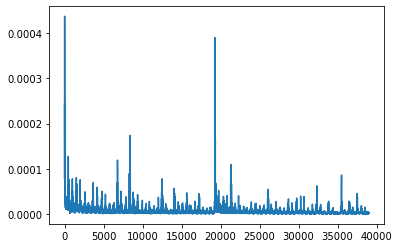

Validation loss


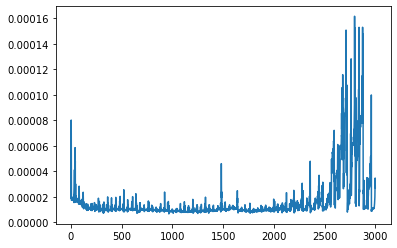

Test loss: 0.0
--------------------------------------------------------
QQQ
Train loss


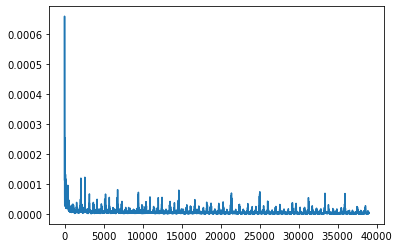

Validation loss


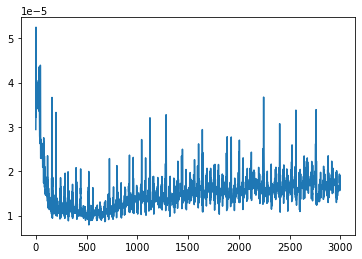

Test loss: 0.0001
--------------------------------------------------------
VEA
Train loss


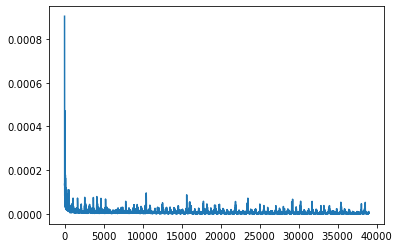

Validation loss


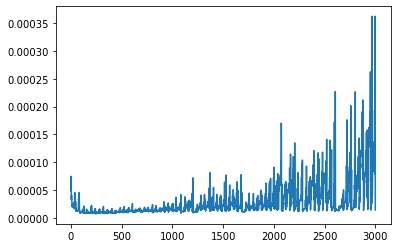

Test loss: 0.0
--------------------------------------------------------
VWO
Train loss


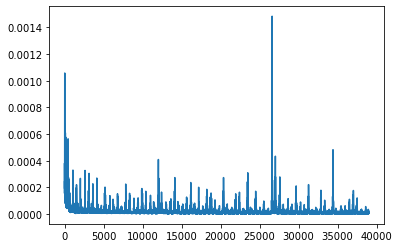

Validation loss


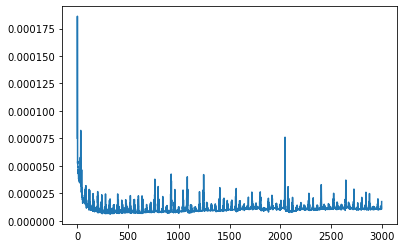

Test loss: 0.0002
--------------------------------------------------------
TLT
Train loss


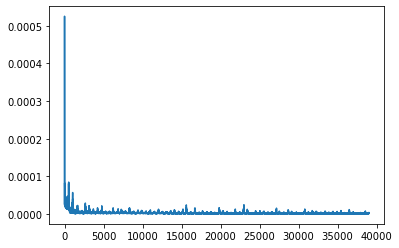

Validation loss


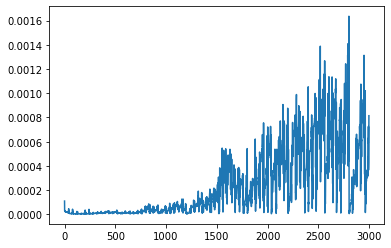

Test loss: 0.0
--------------------------------------------------------
IEF
Train loss


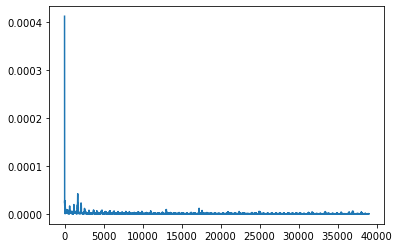

Validation loss


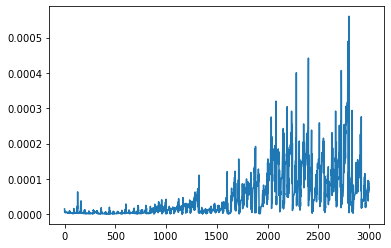

Test loss: 0.0
--------------------------------------------------------
SHY
Train loss


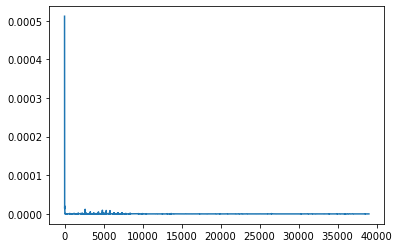

Validation loss


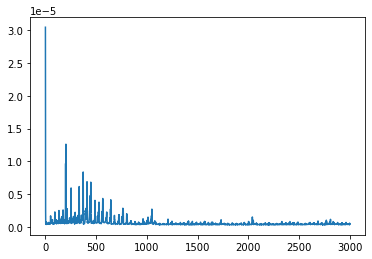

Test loss: 0.0
--------------------------------------------------------
IAU
Train loss


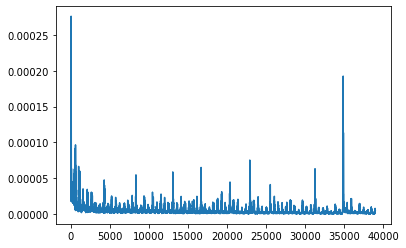

Validation loss


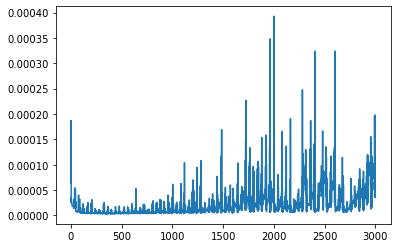

Test loss: 0.0001
--------------------------------------------------------


In [14]:
for i in range(len(assets)):
    print(assets[i])
    print('Train loss')
    plt.plot(trainloss_ls[i])
    plt.show()
    print('Validation loss')
    plt.plot(validloss_ls[i])
    plt.show()
    print(f'Test loss: {testloss_ls[i].round(4)}')
    print('--------------------------------------------------------')

SPY
validation


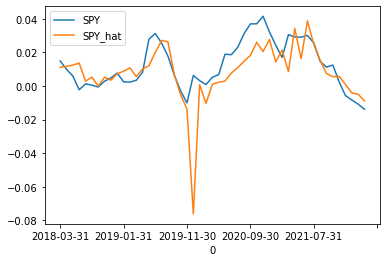

test


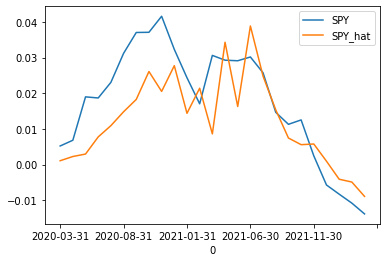

QQQ
validation


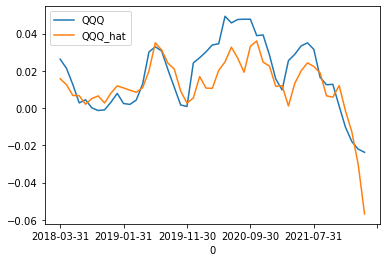

test


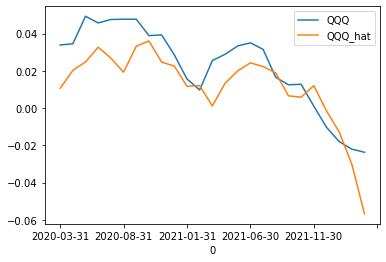

VEA
validation


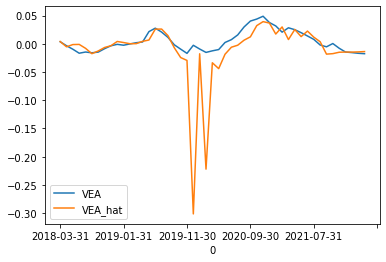

test


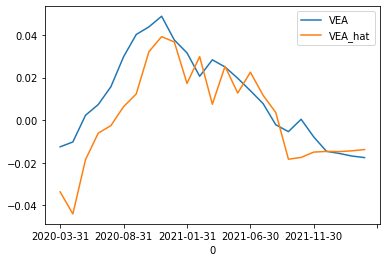

VWO
validation


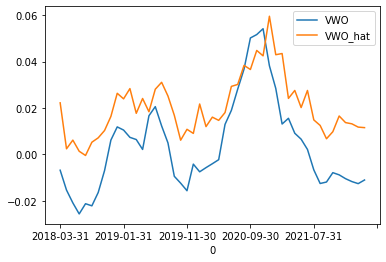

test


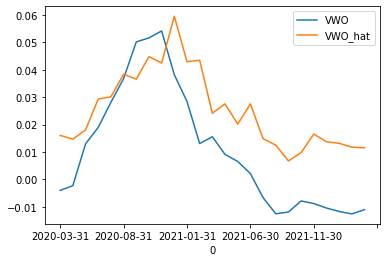

TLT
validation


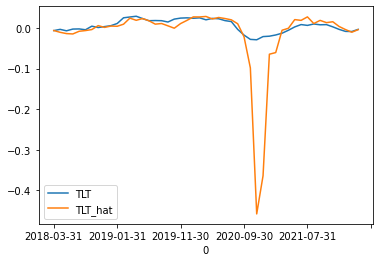

test


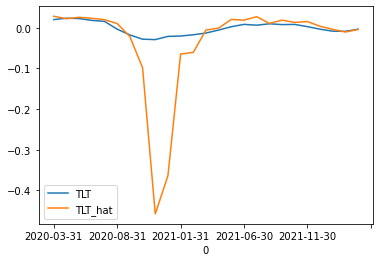

IEF
validation


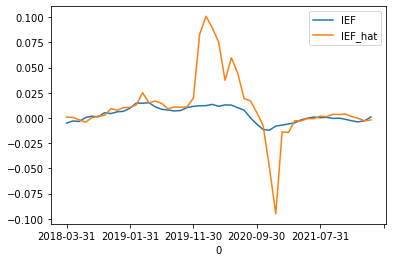

test


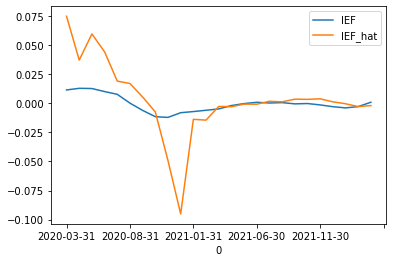

SHY
validation


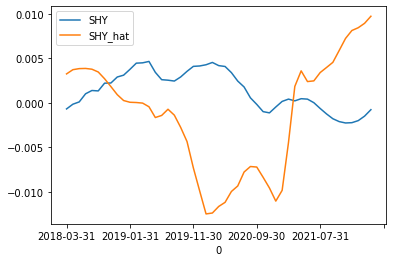

test


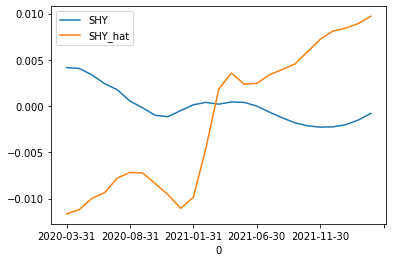

IAU
validation


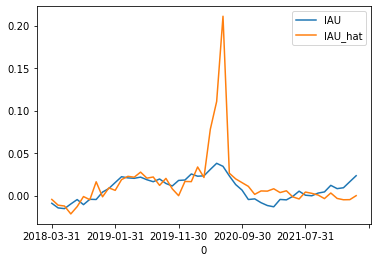

test


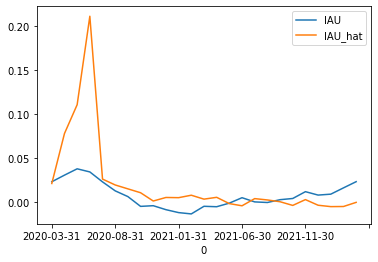

In [15]:
score_ls = []
for i in range(len(assets)): 
    print(assets[i])
    df_answer = pd.concat([train_ans_ls[i], valid_ans_ls[i], test_ans_ls[i]])
    df_answer[assets[i]] = ans_ls[i]
    df_answer[assets[i]+'_hat'] = hat_ls[i]
    print("validation")
    df_answer.set_index('0')['2018-03-31':].plot()
    plt.show()
    print("test")
    df_answer.set_index('0')['2020-03-31':].plot()
    score_ls.append(df_answer.set_index('0'))
    plt.show()

In [17]:
result_df = pd.concat(score_ls, axis=1)

In [18]:
date_idx = date.today().strftime('%Y-%m-%d')
result_df.to_csv(f'data/result_{date_idx}.csv')